# **SEL-NNML Tuning - Kaggle Heart Failure Prediction Dataset**

This notebook implements several tuning methods on the `Stacking Ensemble Learning with a Neural Network Meta-Learner (SEL-NNML)` model using the `Kaggle Heart Failure Prediction Dataset (KHFPD)`.

## **0. Global Configuration**

In [50]:
# Random state for reproducibility
RANDOM_STATE = 42

# Data splitting configuration
TEST_SIZE = 0.2

# Cross-validation configuration
CV_FOLDS = 5

# Hyperparameter tuning configuration
OPTIMIZATION_ITERATIONS = 100
OPTIMIZATION_METRIC = 'accuracy'
OPTIMIZATION_DIRECTION='maximize'

# Parallel processing configuration
N_JOBS = -1 

# Dataset configuration
DATASET_PATH = '../datasets/processed/ds1_kaggle_heart_clean.csv'
TARGET_COLUMN = 'HeartDisease'

# Training configuration
SKIP_TRAINING = False  # Set to True to load pre-existing models instead of training

print('Global configuration loaded successfully!')
print(f'Random State: {RANDOM_STATE}')
print(f'Test Size: {TEST_SIZE}')
print(f'CV Folds: {CV_FOLDS}')
print(f'Optimization Iterations: {OPTIMIZATION_ITERATIONS}')
print(f'Optimization Metric: {OPTIMIZATION_METRIC}')
print(f'Optimization Direction: {OPTIMIZATION_DIRECTION}')
print(f'Skip Training: {SKIP_TRAINING}')

Global configuration loaded successfully!
Random State: 42
Test Size: 0.2
CV Folds: 5
Optimization Iterations: 100
Optimization Metric: accuracy
Optimization Direction: maximize
Skip Training: False


## **1. Import Library**

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from src import base_model_tuning, meta_model_tuning
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.inspection import permutation_importance
import joblib

## **2. Load Dataset**

In [52]:
df = pd.read_csv(DATASET_PATH)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                746 non-null    int64  
 1   Sex                746 non-null    bool   
 2   RestingBP          746 non-null    int64  
 3   Cholesterol        746 non-null    int64  
 4   FastingBS          746 non-null    bool   
 5   MaxHR              746 non-null    int64  
 6   ExerciseAngina     746 non-null    bool   
 7   Oldpeak            746 non-null    float64
 8   HeartDisease       746 non-null    bool   
 9   ChestPainType_ASY  746 non-null    bool   
 10  ChestPainType_ATA  746 non-null    bool   
 11  ChestPainType_NAP  746 non-null    bool   
 12  ChestPainType_TA   746 non-null    bool   
 13  RestingECG_LVH     746 non-null    bool   
 14  RestingECG_Normal  746 non-null    bool   
 15  RestingECG_ST      746 non-null    bool   
 16  ST_Slope_Down      746 non

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,True,140,289,False,172,False,0.0,False,False,True,False,False,False,True,False,False,False,True
1,49,False,160,180,False,156,False,1.0,True,False,False,True,False,False,True,False,False,True,False
2,37,True,130,283,False,98,False,0.0,False,False,True,False,False,False,False,True,False,False,True
3,48,False,138,214,False,108,True,1.5,True,True,False,False,False,False,True,False,False,True,False
4,54,True,150,195,False,122,False,0.0,False,False,False,True,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,45,True,110,264,False,132,False,1.2,True,False,False,False,True,False,True,False,False,True,False
742,68,True,144,193,True,141,False,3.4,True,True,False,False,False,False,True,False,False,True,False
743,57,True,130,131,False,115,True,1.2,True,True,False,False,False,False,True,False,False,True,False
744,57,False,130,236,False,174,False,0.0,True,False,True,False,False,True,False,False,False,True,False


## **3. Data Preparation**

- Split the data into desired training and testing
- After that, Scaling the data using Min-Max Normalization

In [53]:
# Split dataset
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [54]:
# Min-Max Scaling
# Separate numeric and boolean columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
bool_cols = X_train.select_dtypes(include=['bool', 'uint8']).columns  # includes one-hot from get_dummies

# Initialize scaler and fit_transform only on numeric data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_cols, index=X_test.index)

# Concatenate back with boolean features (without modification)
X_train = pd.concat([X_train_scaled, X_train[bool_cols]], axis=1)
X_test = pd.concat([X_test_scaled, X_test[bool_cols]], axis=1)

# Save Min-Max Scaler
scaler_filename = '../artifacts/ds1/models/min_max_scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f'Saved Min-Max Scaler function for this dataset to {scaler_filename}')

Saved Min-Max Scaler function for this dataset to ../artifacts/ds1/models/min_max_scaler.pkl


## **3.1 Default Base Models (Baseline)**

Create base models with default parameters as a baseline for comparison.

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

if not SKIP_TRAINING:
    default_models_training_start = time.time()
    
    # Initialize base models with default parameters
    default_logistic_regression = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    default_decision_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
    default_random_forest = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS)
    default_knn = KNeighborsClassifier(n_jobs=N_JOBS)
    default_svc = SVC(random_state=RANDOM_STATE, probability=True)  # probability=True for predict_proba
    default_adaboost = AdaBoostClassifier(random_state=RANDOM_STATE)
    default_gradient_boosting = GradientBoostingClassifier(random_state=RANDOM_STATE)
    
    # Fit all default models
    print("Training default base models...")
    default_logistic_regression.fit(X_train, y_train)
    default_decision_tree.fit(X_train, y_train)
    default_random_forest.fit(X_train, y_train)
    default_knn.fit(X_train, y_train)
    default_svc.fit(X_train, y_train)
    default_adaboost.fit(X_train, y_train)
    default_gradient_boosting.fit(X_train, y_train)
    
    default_models_training_end = time.time()
    default_models_training_time = default_models_training_end - default_models_training_start
    
    print(f'Default Base Models Training Time: {default_models_training_time:.2f} seconds')
    
    # Store in dictionary
    default_base_models = {
        'Logistic Regression': default_logistic_regression,
        'Decision Tree': default_decision_tree,
        'Random Forest': default_random_forest,
        'K-Nearest Neighbors': default_knn,
        'Support Vector Machine': default_svc,
        'AdaBoost': default_adaboost,
        'Gradient Boosting': default_gradient_boosting
    }
else:
    print("Skipping default base models training (SKIP_TRAINING = True)")

Training default base models...
Default Base Models Training Time: 0.52 seconds
Default Base Models Training Time: 0.52 seconds


## **3.2 Stacking with Default Base Models + Linear Regression**

Create a stacking ensemble using default base learners with Linear Regression as the meta-learner.

In [56]:
from sklearn.ensemble import StackingClassifier

if not SKIP_TRAINING:
    stack_lr_training_start = time.time()
    
    # Create stacking ensemble with Linear Regression as meta-learner
    base_estimators = [
        ('Logistic Regression', default_logistic_regression),
        ('Decision Tree', default_decision_tree),
        ('Random Forest', default_random_forest),
        ('K-Nearest Neighbors', default_knn),
        ('Support Vector Machine', default_svc),
        ('AdaBoost', default_adaboost),
        ('Gradient Boosting', default_gradient_boosting)
    ]
    
    # Linear Regression meta-learner (using LogisticRegression for classification)
    meta_lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    
    stacking_lr = StackingClassifier(
        estimators=base_estimators,
        final_estimator=meta_lr,
        n_jobs=N_JOBS
    )
    
    print("Training Stacking model with Linear Regression meta-learner...")
    stacking_lr.fit(X_train, y_train)
    
    stack_lr_training_end = time.time()
    stack_lr_training_time = stack_lr_training_end - stack_lr_training_start
    
    print(f'Stacking + Linear Regression Training Time: {stack_lr_training_time:.2f} seconds')
else:
    print("Skipping Stacking + LR training (SKIP_TRAINING = True)")

Training Stacking model with Linear Regression meta-learner...
Stacking + Linear Regression Training Time: 2.84 seconds
Stacking + Linear Regression Training Time: 2.84 seconds


## **3.3 Stacking with Default Base Models + Default MLP**

Create a stacking ensemble using default base learners with a default MLP (Multi-Layer Perceptron) as the meta-learner.

In [57]:
from sklearn.neural_network import MLPClassifier

if not SKIP_TRAINING:
    stack_mlp_training_start = time.time()
    
    # Create stacking ensemble with default MLP as meta-learner
    # Using default MLP with just random_state for reproducibility
    meta_mlp = MLPClassifier(random_state=RANDOM_STATE, max_iter=300)
    
    stacking_mlp = StackingClassifier(
        estimators=base_estimators,
        final_estimator=meta_mlp,
        n_jobs=N_JOBS
    )
    
    print("Training Stacking model with default MLP meta-learner...")
    stacking_mlp.fit(X_train, y_train)
    
    stack_mlp_training_end = time.time()
    stack_mlp_training_time = stack_mlp_training_end - stack_mlp_training_start
    
    print(f'Stacking + Default MLP Training Time: {stack_mlp_training_time:.2f} seconds')
else:
    print("Skipping Stacking + MLP training (SKIP_TRAINING = True)")

Training Stacking model with default MLP meta-learner...
Stacking + Default MLP Training Time: 1.15 seconds
Stacking + Default MLP Training Time: 1.15 seconds


## **4. Base Model Hyperparameter Tuning**

**Note:** Set `SKIP_TRAINING = True` in the global configuration to skip steps 4 and 5 and load pre-existing models instead.

### **4.1 TPE & CV Hyperparameter Tuning**

In [58]:
if not SKIP_TRAINING:
    tpe_base_models_training_start = time.time()

    # TPE Hyperparameter Tuning with Cross Validation
    tpe_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

    # Model Fitting with best parameters
    tpe_logistic_regression.fit(X_train, y_train)
    tpe_decision_tree.fit(X_train, y_train)
    tpe_random_forest.fit(X_train, y_train)
    tpe_knn.fit(X_train, y_train)
    tpe_svc.fit(X_train, y_train)
    tpe_adaboost.fit(X_train, y_train)
    tpe_gradient_boosting.fit(X_train, y_train)

    tpe_base_models_training_end = time.time()

    # Time taken for TPE base models training
    tpe_base_models_training_time = tpe_base_models_training_end - tpe_base_models_training_start
    print(f'TPE Base Models Training Time: {tpe_base_models_training_time:.2f} seconds')
else:
    print("Skipping TPE base models training (SKIP_TRAINING = True)")

[I 2025-11-06 03:25:55,100] A new study created in memory with name: Logistic Regression Model Fine Tuning with TPESampler
Best trial: 4. Best value: 0.843908:   6%|▌         | 6/100 [00:00<00:02, 40.90it/s]

[I 2025-11-06 03:25:55,126] Trial 0 finished with value: 0.5352380952380952 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-11-06 03:25:55,150] Trial 1 finished with value: 0.8405882352941176 and parameters: {'solver': 'newton-cholesky', 'C': 0.3470266988650412}. Best is trial 1 with value: 0.8405882352941176.
[I 2025-11-06 03:25:55,174] Trial 2 finished with value: 0.5704481792717087 and parameters: {'solver': 'newton-cg', 'C': 0.0008111941985431928}. Best is trial 1 with value: 0.8405882352941176.
[I 2025-11-06 03:25:55,199] Trial 3 finished with value: 0.8288375350140056 and parameters: {'solver': 'newton-cholesky', 'C': 0.0028585493941961923}. Best is trial 1 with value: 0.8405882352941176.
[I 2025-11-06 03:25:55,223] Trial 4 finished with value: 0.84390756302521 and parameters: {'solver': 'lbfgs', 'C': 0.019069966103000432}. Best is trial 4 with value: 0.84390756302521.
[I 2025-11-06 03:25:55,247] Trial 5

Best trial: 4. Best value: 0.843908:   7%|▋         | 7/100 [00:00<00:02, 40.90it/s]

[I 2025-11-06 03:25:55,306] Trial 7 finished with value: 0.8405462184873949 and parameters: {'solver': 'lbfgs', 'C': 0.015876781526923997}. Best is trial 4 with value: 0.84390756302521.


Best trial: 11. Best value: 0.84563:  14%|█▍        | 14/100 [00:00<00:02, 35.61it/s]

[I 2025-11-06 03:25:55,330] Trial 8 finished with value: 0.8087254901960785 and parameters: {'solver': 'sag', 'C': 0.0019674328025306126}. Best is trial 4 with value: 0.84390756302521.
[I 2025-11-06 03:25:55,355] Trial 9 finished with value: 0.5888795518207283 and parameters: {'solver': 'lbfgs', 'C': 0.0008399864445957502}. Best is trial 4 with value: 0.84390756302521.
[I 2025-11-06 03:25:55,392] Trial 10 finished with value: 0.8439495798319328 and parameters: {'solver': 'lbfgs', 'C': 0.23114272501983432}. Best is trial 10 with value: 0.8439495798319328.
[I 2025-11-06 03:25:55,430] Trial 11 finished with value: 0.8456302521008403 and parameters: {'solver': 'lbfgs', 'C': 0.15812151458626894}. Best is trial 11 with value: 0.8456302521008403.
[I 2025-11-06 03:25:55,456] Trial 12 finished with value: 0.8422689075630252 and parameters: {'solver': 'lbfgs', 'C': 0.2826411346239431}. Best is trial 11 with value: 0.8456302521008403.
[I 2025-11-06 03:25:55,482] Trial 13 finished with value: 0.84

Best trial: 11. Best value: 0.84563:  14%|█▍        | 14/100 [00:00<00:02, 35.61it/s]

[I 2025-11-06 03:25:55,508] Trial 14 finished with value: 0.8372268907563024 and parameters: {'solver': 'lbfgs', 'C': 2.79098579692265}. Best is trial 11 with value: 0.8456302521008403.


Best trial: 18. Best value: 0.847269:  22%|██▏       | 22/100 [00:00<00:02, 37.40it/s]

[I 2025-11-06 03:25:55,534] Trial 15 finished with value: 0.8456162464985993 and parameters: {'solver': 'lbfgs', 'C': 0.08051559097588631}. Best is trial 11 with value: 0.8456302521008403.
[I 2025-11-06 03:25:55,559] Trial 16 finished with value: 0.8456162464985993 and parameters: {'solver': 'newton-cg', 'C': 0.0697350521837258}. Best is trial 11 with value: 0.8456302521008403.
[I 2025-11-06 03:25:55,585] Trial 17 finished with value: 0.83890756302521 and parameters: {'solver': 'sag', 'C': 1.3579090291127154}. Best is trial 11 with value: 0.8456302521008403.
[I 2025-11-06 03:25:55,611] Trial 18 finished with value: 0.8472689075630251 and parameters: {'solver': 'newton-cholesky', 'C': 0.051197944989624766}. Best is trial 18 with value: 0.8472689075630251.
[I 2025-11-06 03:25:55,637] Trial 19 finished with value: 0.8405602240896359 and parameters: {'solver': 'newton-cholesky', 'C': 0.008669040269005453}. Best is trial 18 with value: 0.8472689075630251.
[I 2025-11-06 03:25:55,663] Trial 2

Best trial: 18. Best value: 0.847269:  22%|██▏       | 22/100 [00:00<00:02, 37.40it/s]

[I 2025-11-06 03:25:55,714] Trial 22 finished with value: 0.8456162464985993 and parameters: {'solver': 'newton-cholesky', 'C': 0.08004964515949366}. Best is trial 18 with value: 0.8472689075630251.


Best trial: 18. Best value: 0.847269:  30%|███       | 30/100 [00:00<00:01, 37.98it/s]

[I 2025-11-06 03:25:55,740] Trial 23 finished with value: 0.8304901960784313 and parameters: {'solver': 'lbfgs', 'C': 0.007375728907568315}. Best is trial 18 with value: 0.8472689075630251.
[I 2025-11-06 03:25:55,766] Trial 24 finished with value: 0.8439495798319328 and parameters: {'solver': 'lbfgs', 'C': 0.1121745944965221}. Best is trial 18 with value: 0.8472689075630251.
[I 2025-11-06 03:25:55,792] Trial 25 finished with value: 0.8455882352941175 and parameters: {'solver': 'newton-cholesky', 'C': 0.032428127512365235}. Best is trial 18 with value: 0.8472689075630251.
[I 2025-11-06 03:25:55,818] Trial 26 finished with value: 0.83890756302521 and parameters: {'solver': 'newton-cg', 'C': 0.6910214262026088}. Best is trial 18 with value: 0.8472689075630251.
[I 2025-11-06 03:25:55,844] Trial 27 finished with value: 0.8439495798319328 and parameters: {'solver': 'sag', 'C': 0.11333540081021493}. Best is trial 18 with value: 0.8472689075630251.
[I 2025-11-06 03:25:55,870] Trial 28 finished

Best trial: 18. Best value: 0.847269:  30%|███       | 30/100 [00:00<00:01, 37.98it/s]

[I 2025-11-06 03:25:55,922] Trial 30 finished with value: 0.8372268907563024 and parameters: {'solver': 'newton-cholesky', 'C': 0.5728845685542986}. Best is trial 18 with value: 0.8472689075630251.


Best trial: 18. Best value: 0.847269:  38%|███▊      | 38/100 [00:01<00:01, 38.32it/s]

[I 2025-11-06 03:25:55,948] Trial 31 finished with value: 0.8456162464985993 and parameters: {'solver': 'newton-cg', 'C': 0.061712088176031694}. Best is trial 18 with value: 0.8472689075630251.
[I 2025-11-06 03:25:55,975] Trial 32 finished with value: 0.8439495798319328 and parameters: {'solver': 'newton-cg', 'C': 0.1262642748705284}. Best is trial 18 with value: 0.8472689075630251.
[I 2025-11-06 03:25:56,002] Trial 33 finished with value: 0.8455882352941175 and parameters: {'solver': 'newton-cg', 'C': 0.035109862732477626}. Best is trial 18 with value: 0.8472689075630251.
[I 2025-11-06 03:25:56,027] Trial 34 finished with value: 0.83890756302521 and parameters: {'solver': 'newton-cg', 'C': 0.3835045307309365}. Best is trial 18 with value: 0.8472689075630251.
[I 2025-11-06 03:25:56,053] Trial 35 finished with value: 0.8372268907563024 and parameters: {'solver': 'newton-cg', 'C': 1.7618478700595461}. Best is trial 18 with value: 0.8472689075630251.
[I 2025-11-06 03:25:56,078] Trial 36 f

Best trial: 18. Best value: 0.847269:  38%|███▊      | 38/100 [00:01<00:01, 38.32it/s]

[I 2025-11-06 03:25:56,130] Trial 38 finished with value: 0.8305182072829131 and parameters: {'solver': 'lbfgs', 'C': 0.0030410067875272263}. Best is trial 18 with value: 0.8472689075630251.


Best trial: 39. Best value: 0.84895:  46%|████▌     | 46/100 [00:01<00:01, 38.72it/s] 

[I 2025-11-06 03:25:56,155] Trial 39 finished with value: 0.8489495798319329 and parameters: {'solver': 'newton-cg', 'C': 0.05856966305534113}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:56,181] Trial 40 finished with value: 0.8455882352941175 and parameters: {'solver': 'sag', 'C': 0.02845165810479552}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:56,207] Trial 41 finished with value: 0.8455882352941175 and parameters: {'solver': 'newton-cg', 'C': 0.04768319394347644}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:56,232] Trial 42 finished with value: 0.8456162464985993 and parameters: {'solver': 'newton-cg', 'C': 0.10096174908404337}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:56,258] Trial 43 finished with value: 0.8456162464985993 and parameters: {'solver': 'newton-cg', 'C': 0.06921802568515421}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:56,283] Trial 44 fini

Best trial: 39. Best value: 0.84895:  46%|████▌     | 46/100 [00:01<00:01, 38.72it/s]

[I 2025-11-06 03:25:56,334] Trial 46 finished with value: 0.5352380952380952 and parameters: {'solver': 'lbfgs', 'C': 0.00021618818013690103}. Best is trial 39 with value: 0.8489495798319329.


Best trial: 39. Best value: 0.84895:  54%|█████▍    | 54/100 [00:01<00:01, 37.70it/s]

[I 2025-11-06 03:25:56,360] Trial 47 finished with value: 0.8405462184873949 and parameters: {'solver': 'newton-cholesky', 'C': 0.014579010740313215}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:56,385] Trial 48 finished with value: 0.8439495798319328 and parameters: {'solver': 'newton-cg', 'C': 0.21828528522579935}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:56,411] Trial 49 finished with value: 0.8455882352941175 and parameters: {'solver': 'sag', 'C': 0.04657721498227121}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:56,436] Trial 50 finished with value: 0.84390756302521 and parameters: {'solver': 'lbfgs', 'C': 0.022902951698565554}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:56,462] Trial 51 finished with value: 0.8439355742296918 and parameters: {'solver': 'newton-cholesky', 'C': 0.09731474393794935}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:56,488] Trial

Best trial: 39. Best value: 0.84895:  54%|█████▍    | 54/100 [00:01<00:01, 37.70it/s]

[I 2025-11-06 03:25:56,550] Trial 54 finished with value: 0.8405462184873949 and parameters: {'solver': 'newton-cholesky', 'C': 0.011622799886819657}. Best is trial 39 with value: 0.8489495798319329.


Best trial: 39. Best value: 0.84895:  62%|██████▏   | 62/100 [00:01<00:00, 38.29it/s]

[I 2025-11-06 03:25:56,576] Trial 55 finished with value: 0.8456162464985993 and parameters: {'solver': 'newton-cholesky', 'C': 0.07312656232811188}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:56,601] Trial 56 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.0381551221442807}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:56,627] Trial 57 finished with value: 0.8321848739495797 and parameters: {'solver': 'lbfgs', 'C': 0.003923855267960684}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:56,653] Trial 58 finished with value: 0.8372268907563024 and parameters: {'solver': 'lbfgs', 'C': 8.064276941408533}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:56,679] Trial 59 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.03791621774817249}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:56,704] Trial 60 finished w

Best trial: 39. Best value: 0.84895:  62%|██████▏   | 62/100 [00:01<00:00, 38.29it/s]

[I 2025-11-06 03:25:56,756] Trial 62 finished with value: 0.8456302521008403 and parameters: {'solver': 'lbfgs', 'C': 0.14990407553147933}. Best is trial 39 with value: 0.8489495798319329.


Best trial: 39. Best value: 0.84895:  70%|███████   | 70/100 [00:01<00:00, 38.57it/s]

[I 2025-11-06 03:25:56,782] Trial 63 finished with value: 0.84390756302521 and parameters: {'solver': 'lbfgs', 'C': 0.020280185040408252}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:56,808] Trial 64 finished with value: 0.8456302521008403 and parameters: {'solver': 'lbfgs', 'C': 0.15729553484021594}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:56,833] Trial 65 finished with value: 0.8439495798319328 and parameters: {'solver': 'lbfgs', 'C': 0.1649766208187189}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:56,859] Trial 66 finished with value: 0.8372268907563024 and parameters: {'solver': 'lbfgs', 'C': 0.5774556008496657}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:56,885] Trial 67 finished with value: 0.8456302521008403 and parameters: {'solver': 'lbfgs', 'C': 0.2490275872874681}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:56,911] Trial 68 finished with value: 0

Best trial: 39. Best value: 0.84895:  70%|███████   | 70/100 [00:01<00:00, 38.57it/s]

[I 2025-11-06 03:25:56,962] Trial 70 finished with value: 0.8405602240896359 and parameters: {'solver': 'lbfgs', 'C': 0.009756665159036369}. Best is trial 39 with value: 0.8489495798319329.


Best trial: 39. Best value: 0.84895:  78%|███████▊  | 78/100 [00:02<00:00, 38.61it/s]

[I 2025-11-06 03:25:56,988] Trial 71 finished with value: 0.8439495798319328 and parameters: {'solver': 'lbfgs', 'C': 0.2735543395700848}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:57,014] Trial 72 finished with value: 0.8456302521008403 and parameters: {'solver': 'lbfgs', 'C': 0.1415139420071471}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:57,040] Trial 73 finished with value: 0.8372268907563024 and parameters: {'solver': 'lbfgs', 'C': 0.41742037788882863}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:57,065] Trial 74 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.03733329128405272}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:57,091] Trial 75 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.03869645307868557}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:57,117] Trial 76 finished with value:

Best trial: 39. Best value: 0.84895:  78%|███████▊  | 78/100 [00:02<00:00, 38.61it/s]

[I 2025-11-06 03:25:57,169] Trial 78 finished with value: 0.8472689075630251 and parameters: {'solver': 'sag', 'C': 0.026728604297654224}. Best is trial 39 with value: 0.8489495798319329.


Best trial: 39. Best value: 0.84895:  86%|████████▌ | 86/100 [00:02<00:00, 38.31it/s]

[I 2025-11-06 03:25:57,196] Trial 79 finished with value: 0.8321708683473389 and parameters: {'solver': 'sag', 'C': 0.005678286963186669}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:57,222] Trial 80 finished with value: 0.8405462184873949 and parameters: {'solver': 'sag', 'C': 0.01628463082294873}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:57,248] Trial 81 finished with value: 0.8472689075630251 and parameters: {'solver': 'sag', 'C': 0.027002765082027362}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:57,273] Trial 82 finished with value: 0.8472689075630251 and parameters: {'solver': 'sag', 'C': 0.03920263854915853}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:57,299] Trial 83 finished with value: 0.8472689075630251 and parameters: {'solver': 'sag', 'C': 0.025816750619589275}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:57,325] Trial 84 finished with value: 0.84

Best trial: 39. Best value: 0.84895:  86%|████████▌ | 86/100 [00:02<00:00, 38.31it/s]

[I 2025-11-06 03:25:57,379] Trial 86 finished with value: 0.84390756302521 and parameters: {'solver': 'sag', 'C': 0.020681162708917507}. Best is trial 39 with value: 0.8489495798319329.


Best trial: 39. Best value: 0.84895:  94%|█████████▍| 94/100 [00:02<00:00, 38.29it/s]

[I 2025-11-06 03:25:57,407] Trial 87 finished with value: 0.8405462184873949 and parameters: {'solver': 'sag', 'C': 0.011952087204337748}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:57,434] Trial 88 finished with value: 0.7835994397759103 and parameters: {'solver': 'sag', 'C': 0.0016487953630811834}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:57,460] Trial 89 finished with value: 0.8405462184873949 and parameters: {'solver': 'sag', 'C': 0.0174598179732157}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:57,486] Trial 90 finished with value: 0.8456162464985993 and parameters: {'solver': 'sag', 'C': 0.09225357958481319}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:57,511] Trial 91 finished with value: 0.8472689075630251 and parameters: {'solver': 'sag', 'C': 0.026449542063198377}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:57,537] Trial 92 finished with value: 0.84

Best trial: 39. Best value: 0.84895:  94%|█████████▍| 94/100 [00:02<00:00, 38.29it/s]

[I 2025-11-06 03:25:57,589] Trial 94 finished with value: 0.8472689075630251 and parameters: {'solver': 'sag', 'C': 0.04100851208918775}. Best is trial 39 with value: 0.8489495798319329.


Best trial: 39. Best value: 0.84895: 100%|██████████| 100/100 [00:02<00:00, 38.21it/s]
[I 2025-11-06 03:25:57,720] A new study created in memory with name: Decision Tree Model Fine Tuning with TPESampler
Best trial: 39. Best value: 0.84895: 100%|██████████| 100/100 [00:02<00:00, 38.21it/s]
[I 2025-11-06 03:25:57,720] A new study created in memory with name: Decision Tree Model Fine Tuning with TPESampler


[I 2025-11-06 03:25:57,615] Trial 95 finished with value: 0.8472549019607843 and parameters: {'solver': 'sag', 'C': 0.03088753596943577}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:57,641] Trial 96 finished with value: 0.8405462184873949 and parameters: {'solver': 'sag', 'C': 0.01192382113477604}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:57,666] Trial 97 finished with value: 0.8405602240896359 and parameters: {'solver': 'newton-cg', 'C': 0.008521018011915764}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:57,692] Trial 98 finished with value: 0.8472829131652662 and parameters: {'solver': 'newton-cholesky', 'C': 0.05941864093493929}. Best is trial 39 with value: 0.8489495798319329.
[I 2025-11-06 03:25:57,718] Trial 99 finished with value: 0.8472829131652662 and parameters: {'solver': 'newton-cholesky', 'C': 0.05954942719938483}. Best is trial 39 with value: 0.8489495798319329.

Best Hyperparameters for Logistic

Best trial: 1. Best value: 0.842311:   3%|▎         | 3/100 [00:00<00:02, 43.67it/s]

[I 2025-11-06 03:25:57,735] Trial 0 finished with value: 0.8271848739495798 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8271848739495798.
[I 2025-11-06 03:25:57,749] Trial 1 finished with value: 0.8423109243697479 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8423109243697479.
[I 2025-11-06 03:25:57,773] Trial 2 finished with value: 0.807044817927171 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8423109243697479.
[I 2025-11-06 03:25:57,788] Trial 3 finished with value: 0.813781512605042 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.842310

Best trial: 1. Best value: 0.842311:   4%|▍         | 4/100 [00:00<00:02, 47.73it/s]

[I 2025-11-06 03:25:57,803] Trial 4 finished with value: 0.8053361344537814 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8423109243697479.


Best trial: 1. Best value: 0.842311:  11%|█         | 11/100 [00:00<00:01, 60.69it/s]

[I 2025-11-06 03:25:57,818] Trial 5 finished with value: 0.8070448179271708 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8423109243697479.
[I 2025-11-06 03:25:57,835] Trial 6 finished with value: 0.8272128851540617 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8423109243697479.
[I 2025-11-06 03:25:57,851] Trial 7 finished with value: 0.8036974789915966 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8423109243697479.
[I 2025-11-06 03:25:57,867] Trial 8 finished with value: 0.8373109243697477 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8423109243

Best trial: 15. Best value: 0.843978:  15%|█▌        | 15/100 [00:00<00:01, 59.37it/s]

[I 2025-11-06 03:25:57,937] Trial 12 finished with value: 0.8204901960784314 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8423109243697479.
[I 2025-11-06 03:25:57,955] Trial 13 finished with value: 0.8439495798319326 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 13 with value: 0.8439495798319326.
[I 2025-11-06 03:25:57,973] Trial 14 finished with value: 0.8221708683473388 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 13 with value: 0.8439495798319326.
[I 2025-11-06 03:25:57,991] Trial 15 finished with value: 0.8439775910364145 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 15 with value: 0

Best trial: 15. Best value: 0.843978:  16%|█▌        | 16/100 [00:00<00:01, 59.37it/s]

[I 2025-11-06 03:25:58,009] Trial 16 finished with value: 0.830532212885154 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 15 with value: 0.8439775910364145.


Best trial: 19. Best value: 0.847339:  23%|██▎       | 23/100 [00:00<00:01, 57.62it/s]

[I 2025-11-06 03:25:58,026] Trial 17 finished with value: 0.8288515406162464 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 15 with value: 0.8439775910364145.
[I 2025-11-06 03:25:58,044] Trial 18 finished with value: 0.8036974789915966 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 15 with value: 0.8439775910364145.
[I 2025-11-06 03:25:58,063] Trial 19 finished with value: 0.8473389355742297 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,081] Trial 20 finished with value: 0.8321848739495799 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 19 with value: 0.8473389355

Best trial: 19. Best value: 0.847339:  27%|██▋       | 27/100 [00:00<00:01, 56.86it/s]

[I 2025-11-06 03:25:58,152] Trial 24 finished with value: 0.8120308123249298 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,171] Trial 25 finished with value: 0.8137254901960784 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,189] Trial 26 finished with value: 0.8473389355742297 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,208] Trial 27 finished with value: 0.830532212885154 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 19 with value: 0.84733893557

Best trial: 19. Best value: 0.847339:  34%|███▍      | 34/100 [00:00<00:01, 54.35it/s]

[I 2025-11-06 03:25:58,227] Trial 28 finished with value: 0.8238655462184873 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,247] Trial 29 finished with value: 0.8271848739495798 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,269] Trial 30 finished with value: 0.8355742296918767 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,290] Trial 31 finished with value: 0.8473389355742297 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 19 with value: 0.847338

Best trial: 19. Best value: 0.847339:  38%|███▊      | 38/100 [00:00<00:01, 53.37it/s]

[I 2025-11-06 03:25:58,368] Trial 35 finished with value: 0.8355742296918767 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,387] Trial 36 finished with value: 0.8036554621848738 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,407] Trial 37 finished with value: 0.8423109243697479 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,425] Trial 38 finished with value: 0.8137675070028012 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 19 with value: 0.84733893557

Best trial: 19. Best value: 0.847339:  45%|████▌     | 45/100 [00:00<00:01, 53.65it/s]

[I 2025-11-06 03:25:58,444] Trial 39 finished with value: 0.8439495798319326 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,462] Trial 40 finished with value: 0.8322268907563025 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,481] Trial 41 finished with value: 0.8473389355742297 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,499] Trial 42 finished with value: 0.8473389355742297 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 19 with value: 0.8473389

Best trial: 19. Best value: 0.847339:  50%|█████     | 50/100 [00:00<00:00, 52.95it/s]

[I 2025-11-06 03:25:58,573] Trial 46 finished with value: 0.8439775910364145 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,591] Trial 47 finished with value: 0.813781512605042 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,614] Trial 48 finished with value: 0.8355742296918767 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,634] Trial 49 finished with value: 0.8271848739495798 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 19 with value: 0.8473

Best trial: 19. Best value: 0.847339:  56%|█████▌    | 56/100 [00:01<00:00, 52.45it/s]

[I 2025-11-06 03:25:58,656] Trial 50 finished with value: 0.8137675070028012 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,675] Trial 51 finished with value: 0.8473389355742297 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,694] Trial 52 finished with value: 0.8473389355742297 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,712] Trial 53 finished with value: 0.8473389355742297 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 19 with value: 0.847338935574

Best trial: 19. Best value: 0.847339:  60%|██████    | 60/100 [00:01<00:00, 52.45it/s]

[I 2025-11-06 03:25:58,789] Trial 57 finished with value: 0.830532212885154 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,808] Trial 58 finished with value: 0.8422969187675069 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,827] Trial 59 finished with value: 0.8288515406162464 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,846] Trial 60 finished with value: 0.8439495798319326 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 19 with value: 0.84733893

Best trial: 64. Best value: 0.8507:  68%|██████▊   | 68/100 [00:01<00:00, 52.84it/s]  

[I 2025-11-06 03:25:58,864] Trial 61 finished with value: 0.8473389355742297 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,883] Trial 62 finished with value: 0.8473389355742297 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,903] Trial 63 finished with value: 0.830532212885154 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 19 with value: 0.8473389355742297.
[I 2025-11-06 03:25:58,921] Trial 64 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 64 with value: 0.850700280112

Best trial: 64. Best value: 0.8507:  71%|███████   | 71/100 [00:01<00:00, 52.84it/s]

[I 2025-11-06 03:25:58,995] Trial 68 finished with value: 0.8238655462184873 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 64 with value: 0.850700280112045.
[I 2025-11-06 03:25:59,014] Trial 69 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 64 with value: 0.850700280112045.
[I 2025-11-06 03:25:59,032] Trial 70 finished with value: 0.8204901960784312 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 64 with value: 0.850700280112045.
[I 2025-11-06 03:25:59,051] Trial 71 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 64 with value: 0.85070028011204

Best trial: 64. Best value: 0.8507:  78%|███████▊  | 78/100 [00:01<00:00, 53.18it/s]

[I 2025-11-06 03:25:59,069] Trial 72 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 64 with value: 0.850700280112045.
[I 2025-11-06 03:25:59,088] Trial 73 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 64 with value: 0.850700280112045.
[I 2025-11-06 03:25:59,106] Trial 74 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 64 with value: 0.850700280112045.
[I 2025-11-06 03:25:59,125] Trial 75 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 64 with value: 0.8507002801120

Best trial: 64. Best value: 0.8507:  82%|████████▏ | 82/100 [00:01<00:00, 53.31it/s]

[I 2025-11-06 03:25:59,199] Trial 79 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 64 with value: 0.850700280112045.
[I 2025-11-06 03:25:59,218] Trial 80 finished with value: 0.8271848739495798 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 64 with value: 0.850700280112045.
[I 2025-11-06 03:25:59,243] Trial 81 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 64 with value: 0.850700280112045.
[I 2025-11-06 03:25:59,263] Trial 82 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 64 with value: 0.8507002801

Best trial: 64. Best value: 0.8507:  88%|████████▊ | 88/100 [00:01<00:00, 51.59it/s]

[I 2025-11-06 03:25:59,283] Trial 83 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 64 with value: 0.850700280112045.
[I 2025-11-06 03:25:59,305] Trial 84 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 64 with value: 0.850700280112045.
[I 2025-11-06 03:25:59,324] Trial 85 finished with value: 0.8154621848739495 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 64 with value: 0.850700280112045.
[I 2025-11-06 03:25:59,347] Trial 86 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 64 with value: 0.850700280112

Best trial: 64. Best value: 0.8507:  93%|█████████▎| 93/100 [00:01<00:00, 51.43it/s]

[I 2025-11-06 03:25:59,404] Trial 89 finished with value: 0.8255462184873948 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 64 with value: 0.850700280112045.
[I 2025-11-06 03:25:59,423] Trial 90 finished with value: 0.8406162464985993 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 64 with value: 0.850700280112045.
[I 2025-11-06 03:25:59,442] Trial 91 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 64 with value: 0.850700280112045.
[I 2025-11-06 03:25:59,461] Trial 92 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 64 with value: 0.850700280112

Best trial: 64. Best value: 0.8507: 100%|██████████| 100/100 [00:01<00:00, 53.27it/s]
[I 2025-11-06 03:25:59,599] A new study created in memory with name: Random Forest Model Fine Tuning with TPESampler
Best trial: 64. Best value: 0.8507: 100%|██████████| 100/100 [00:01<00:00, 53.27it/s]
[I 2025-11-06 03:25:59,599] A new study created in memory with name: Random Forest Model Fine Tuning with TPESampler


[I 2025-11-06 03:25:59,500] Trial 94 finished with value: 0.8204901960784312 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 64 with value: 0.850700280112045.
[I 2025-11-06 03:25:59,519] Trial 95 finished with value: 0.830532212885154 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 64 with value: 0.850700280112045.
[I 2025-11-06 03:25:59,539] Trial 96 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 64 with value: 0.850700280112045.
[I 2025-11-06 03:25:59,558] Trial 97 finished with value: 0.8439775910364145 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.85070028011204

Best trial: 0. Best value: 0.845658:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-06 03:25:59,663] Trial 0 finished with value: 0.8456582633053221 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8456582633053221.


Best trial: 1. Best value: 0.848992:   2%|▏         | 2/100 [00:00<00:07, 13.99it/s]

[I 2025-11-06 03:25:59,741] Trial 1 finished with value: 0.8489915966386554 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 37, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8489915966386554.
[I 2025-11-06 03:25:59,817] Trial 2 finished with value: 0.8288655462184874 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 28, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8489915966386554.


Best trial: 3. Best value: 0.852353:   4%|▍         | 4/100 [00:00<00:07, 13.01it/s]

[I 2025-11-06 03:25:59,903] Trial 3 finished with value: 0.8523529411764705 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 37, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8523529411764705.


Best trial: 3. Best value: 0.852353:   6%|▌         | 6/100 [00:00<00:07, 13.03it/s]

[I 2025-11-06 03:25:59,989] Trial 4 finished with value: 0.8489915966386554 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 38, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8523529411764705.
[I 2025-11-06 03:26:00,056] Trial 5 finished with value: 0.842282913165266 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 18, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8523529411764705.


Best trial: 3. Best value: 0.852353:   6%|▌         | 6/100 [00:00<00:07, 13.03it/s]

[I 2025-11-06 03:26:00,111] Trial 6 finished with value: 0.8355882352941176 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 22, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8523529411764705.


Best trial: 3. Best value: 0.852353:   8%|▊         | 8/100 [00:00<00:07, 12.18it/s]

[I 2025-11-06 03:26:00,236] Trial 7 finished with value: 0.8473249299719887 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 80, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8523529411764705.


Best trial: 3. Best value: 0.852353:   8%|▊         | 8/100 [00:00<00:07, 12.18it/s]

[I 2025-11-06 03:26:00,362] Trial 8 finished with value: 0.8406162464985993 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 76, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8523529411764705.


Best trial: 3. Best value: 0.852353:  10%|█         | 10/100 [00:00<00:08, 10.62it/s]

[I 2025-11-06 03:26:00,467] Trial 9 finished with value: 0.8489775910364145 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 57, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8523529411764705.


Best trial: 10. Best value: 0.852367:  10%|█         | 10/100 [00:01<00:08, 10.62it/s]

[I 2025-11-06 03:26:00,618] Trial 10 finished with value: 0.8523669467787116 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 98, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  12%|█▏        | 12/100 [00:01<00:10,  8.57it/s]

[I 2025-11-06 03:26:00,788] Trial 11 finished with value: 0.8523669467787116 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 96, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  13%|█▎        | 13/100 [00:01<00:10,  7.98it/s]

[I 2025-11-06 03:26:00,949] Trial 12 finished with value: 0.8523669467787116 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  14%|█▍        | 14/100 [00:01<00:11,  7.50it/s]

[I 2025-11-06 03:26:01,111] Trial 13 finished with value: 0.8523669467787116 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 99, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  15%|█▌        | 15/100 [00:01<00:11,  7.36it/s]

[I 2025-11-06 03:26:01,255] Trial 14 finished with value: 0.8523669467787116 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 84, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  16%|█▌        | 16/100 [00:01<00:10,  7.71it/s]

[I 2025-11-06 03:26:01,366] Trial 15 finished with value: 0.8473249299719887 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 65, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 16. Best value: 0.85909:  17%|█▋        | 17/100 [00:01<00:11,  7.34it/s] 

[I 2025-11-06 03:26:01,521] Trial 16 finished with value: 0.8590896358543418 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 92, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  18%|█▊        | 18/100 [00:02<00:10,  7.74it/s]

[I 2025-11-06 03:26:01,631] Trial 17 finished with value: 0.8557282913165267 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 68, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  19%|█▉        | 19/100 [00:02<00:10,  8.01it/s]

[I 2025-11-06 03:26:01,745] Trial 18 finished with value: 0.8540476190476192 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 68, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  20%|██        | 20/100 [00:02<00:10,  7.51it/s]

[I 2025-11-06 03:26:01,899] Trial 19 finished with value: 0.8540476190476192 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 87, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  21%|██        | 21/100 [00:02<00:09,  7.90it/s]

[I 2025-11-06 03:26:02,010] Trial 20 finished with value: 0.8557563025210083 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 51, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  22%|██▏       | 22/100 [00:02<00:09,  8.40it/s]

[I 2025-11-06 03:26:02,110] Trial 21 finished with value: 0.8540616246498601 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 49, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  23%|██▎       | 23/100 [00:02<00:09,  8.53it/s]

[I 2025-11-06 03:26:02,223] Trial 22 finished with value: 0.8523529411764705 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 51, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  24%|██▍       | 24/100 [00:02<00:08,  8.45it/s]

[I 2025-11-06 03:26:02,344] Trial 23 finished with value: 0.8557282913165267 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 67, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  25%|██▌       | 25/100 [00:02<00:08,  8.57it/s]

[I 2025-11-06 03:26:02,457] Trial 24 finished with value: 0.8456582633053221 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 58, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  26%|██▌       | 26/100 [00:02<00:08,  8.27it/s]

[I 2025-11-06 03:26:02,588] Trial 25 finished with value: 0.8590896358543418 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 76, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  27%|██▋       | 27/100 [00:03<00:09,  8.08it/s]

[I 2025-11-06 03:26:02,719] Trial 26 finished with value: 0.8557422969187677 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 75, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  28%|██▊       | 28/100 [00:03<00:09,  7.58it/s]

[I 2025-11-06 03:26:02,869] Trial 27 finished with value: 0.8557282913165267 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 90, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  28%|██▊       | 28/100 [00:03<00:09,  7.58it/s]

[I 2025-11-06 03:26:02,961] Trial 28 finished with value: 0.845658263305322 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 45, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  30%|███       | 30/100 [00:03<00:08,  7.88it/s]

[I 2025-11-06 03:26:03,112] Trial 29 finished with value: 0.8439915966386554 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 91, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  31%|███       | 31/100 [00:03<00:08,  7.96it/s]

[I 2025-11-06 03:26:03,233] Trial 30 finished with value: 0.8557142857142856 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 75, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  32%|███▏      | 32/100 [00:03<00:08,  7.85it/s]

[I 2025-11-06 03:26:03,365] Trial 31 finished with value: 0.850686274509804 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 75, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  33%|███▎      | 33/100 [00:03<00:08,  7.86it/s]

[I 2025-11-06 03:26:03,492] Trial 32 finished with value: 0.8540476190476192 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 64, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  34%|███▍      | 34/100 [00:04<00:08,  7.60it/s]

[I 2025-11-06 03:26:03,636] Trial 33 finished with value: 0.850686274509804 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 83, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  36%|███▌      | 36/100 [00:04<00:07,  8.99it/s]

[I 2025-11-06 03:26:03,727] Trial 34 finished with value: 0.8523809523809526 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 42, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.
[I 2025-11-06 03:26:03,807] Trial 35 finished with value: 0.8557002801120447 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 30, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  37%|███▋      | 37/100 [00:04<00:07,  8.99it/s]

[I 2025-11-06 03:26:03,918] Trial 36 finished with value: 0.8557142857142856 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 59, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  38%|███▊      | 38/100 [00:04<00:07,  8.58it/s]

[I 2025-11-06 03:26:04,050] Trial 37 finished with value: 0.8423109243697479 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 73, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  39%|███▉      | 39/100 [00:04<00:07,  7.93it/s]

[I 2025-11-06 03:26:04,202] Trial 38 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 91, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  40%|████      | 40/100 [00:04<00:07,  7.66it/s]

[I 2025-11-06 03:26:04,345] Trial 39 finished with value: 0.8406162464985993 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 80, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  40%|████      | 40/100 [00:04<00:07,  7.66it/s]

[I 2025-11-06 03:26:04,426] Trial 40 finished with value: 0.850686274509804 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 35, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  42%|████▏     | 42/100 [00:04<00:06,  8.31it/s]

[I 2025-11-06 03:26:04,559] Trial 41 finished with value: 0.8573949579831932 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 71, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  43%|████▎     | 43/100 [00:05<00:06,  8.64it/s]

[I 2025-11-06 03:26:04,660] Trial 42 finished with value: 0.8523809523809524 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 51, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.
[I 2025-11-06 03:26:04,722] Trial 43 finished with value: 0.8506862745098038 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 12, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  45%|████▌     | 45/100 [00:05<00:05,  9.66it/s]

[I 2025-11-06 03:26:04,832] Trial 44 finished with value: 0.8574089635854343 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 61, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  46%|████▌     | 46/100 [00:05<00:05,  9.45it/s]

[I 2025-11-06 03:26:04,946] Trial 45 finished with value: 0.8490196078431375 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 61, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  47%|████▋     | 47/100 [00:05<00:05,  9.55it/s]

[I 2025-11-06 03:26:05,047] Trial 46 finished with value: 0.8557282913165265 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 54, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  48%|████▊     | 48/100 [00:05<00:05,  8.95it/s]

[I 2025-11-06 03:26:05,179] Trial 47 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 71, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  49%|████▉     | 49/100 [00:05<00:06,  8.12it/s]

[I 2025-11-06 03:26:05,333] Trial 48 finished with value: 0.8423109243697479 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 79, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  50%|█████     | 50/100 [00:05<00:06,  8.33it/s]

[I 2025-11-06 03:26:05,445] Trial 49 finished with value: 0.8456442577030812 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 62, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  51%|█████     | 51/100 [00:06<00:06,  7.50it/s]

[I 2025-11-06 03:26:05,612] Trial 50 finished with value: 0.8540616246498601 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 95, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  52%|█████▏    | 52/100 [00:06<00:06,  7.63it/s]

[I 2025-11-06 03:26:05,737] Trial 51 finished with value: 0.8590896358543418 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 71, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  53%|█████▎    | 53/100 [00:06<00:06,  7.61it/s]

[I 2025-11-06 03:26:05,870] Trial 52 finished with value: 0.8590896358543418 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 71, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  54%|█████▍    | 54/100 [00:06<00:05,  7.80it/s]

[I 2025-11-06 03:26:05,990] Trial 53 finished with value: 0.8590896358543418 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 70, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  55%|█████▌    | 55/100 [00:06<00:05,  7.57it/s]

[I 2025-11-06 03:26:06,131] Trial 54 finished with value: 0.8590756302521008 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 84, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  56%|█████▌    | 56/100 [00:06<00:06,  7.02it/s]

[I 2025-11-06 03:26:06,298] Trial 55 finished with value: 0.8540476190476192 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 86, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  57%|█████▋    | 57/100 [00:06<00:06,  7.12it/s]

[I 2025-11-06 03:26:06,434] Trial 56 finished with value: 0.8490196078431375 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 81, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  58%|█████▊    | 58/100 [00:06<00:05,  7.11it/s]

[I 2025-11-06 03:26:06,575] Trial 57 finished with value: 0.8574089635854343 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 87, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  59%|█████▉    | 59/100 [00:07<00:06,  6.78it/s]

[I 2025-11-06 03:26:06,739] Trial 58 finished with value: 0.8540756302521008 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 94, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  60%|██████    | 60/100 [00:07<00:05,  6.95it/s]

[I 2025-11-06 03:26:06,875] Trial 59 finished with value: 0.8590896358543418 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 79, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  61%|██████    | 61/100 [00:07<00:05,  7.13it/s]

[I 2025-11-06 03:26:07,006] Trial 60 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 78, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  62%|██████▏   | 62/100 [00:07<00:05,  7.05it/s]

[I 2025-11-06 03:26:07,152] Trial 61 finished with value: 0.8590896358543418 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 70, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  63%|██████▎   | 63/100 [00:07<00:05,  7.31it/s]

[I 2025-11-06 03:26:07,277] Trial 62 finished with value: 0.8590896358543418 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 70, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  64%|██████▍   | 64/100 [00:07<00:04,  7.56it/s]

[I 2025-11-06 03:26:07,399] Trial 63 finished with value: 0.8557282913165267 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 65, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  65%|██████▌   | 65/100 [00:07<00:04,  7.67it/s]

[I 2025-11-06 03:26:07,524] Trial 64 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 67, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  66%|██████▌   | 66/100 [00:08<00:04,  7.66it/s]

[I 2025-11-06 03:26:07,656] Trial 65 finished with value: 0.8557282913165265 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 73, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  67%|██████▋   | 67/100 [00:08<00:04,  7.65it/s]

[I 2025-11-06 03:26:07,787] Trial 66 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 77, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  68%|██████▊   | 68/100 [00:08<00:04,  7.43it/s]

[I 2025-11-06 03:26:07,929] Trial 67 finished with value: 0.8523669467787116 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 82, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 16. Best value: 0.85909:  69%|██████▉   | 69/100 [00:08<00:04,  7.55it/s]

[I 2025-11-06 03:26:08,058] Trial 68 finished with value: 0.8523529411764705 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 70, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 16 with value: 0.8590896358543418.


Best trial: 69. Best value: 0.859104:  70%|███████   | 70/100 [00:08<00:04,  7.34it/s]

[I 2025-11-06 03:26:08,201] Trial 69 finished with value: 0.8591036414565828 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 87, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 69 with value: 0.8591036414565828.


Best trial: 69. Best value: 0.859104:  71%|███████   | 71/100 [00:08<00:04,  6.72it/s]

[I 2025-11-06 03:26:08,381] Trial 70 finished with value: 0.8406302521008403 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 90, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 69 with value: 0.8591036414565828.


Best trial: 69. Best value: 0.859104:  72%|███████▏  | 72/100 [00:08<00:03,  7.10it/s]

[I 2025-11-06 03:26:08,503] Trial 71 finished with value: 0.8590896358543418 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 73, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 69 with value: 0.8591036414565828.


Best trial: 69. Best value: 0.859104:  73%|███████▎  | 73/100 [00:09<00:03,  7.09it/s]

[I 2025-11-06 03:26:08,645] Trial 72 finished with value: 0.8590896358543418 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 85, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 69 with value: 0.8591036414565828.


Best trial: 69. Best value: 0.859104:  74%|███████▍  | 74/100 [00:09<00:03,  6.92it/s]

[I 2025-11-06 03:26:08,797] Trial 73 finished with value: 0.8573949579831932 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 77, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 69 with value: 0.8591036414565828.


Best trial: 69. Best value: 0.859104:  75%|███████▌  | 75/100 [00:09<00:03,  6.79it/s]

[I 2025-11-06 03:26:08,951] Trial 74 finished with value: 0.8591036414565828 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 89, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 69 with value: 0.8591036414565828.


Best trial: 69. Best value: 0.859104:  76%|███████▌  | 76/100 [00:09<00:03,  6.58it/s]

[I 2025-11-06 03:26:09,114] Trial 75 finished with value: 0.8523669467787116 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 99, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 69 with value: 0.8591036414565828.


Best trial: 69. Best value: 0.859104:  77%|███████▋  | 77/100 [00:09<00:03,  6.54it/s]

[I 2025-11-06 03:26:09,269] Trial 76 finished with value: 0.8590896358543418 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 93, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 69 with value: 0.8591036414565828.


Best trial: 69. Best value: 0.859104:  78%|███████▊  | 78/100 [00:09<00:03,  6.68it/s]

[I 2025-11-06 03:26:09,411] Trial 77 finished with value: 0.8590756302521008 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 87, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 69 with value: 0.8591036414565828.


Best trial: 69. Best value: 0.859104:  79%|███████▉  | 79/100 [00:09<00:03,  6.51it/s]

[I 2025-11-06 03:26:09,573] Trial 78 finished with value: 0.8506862745098038 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 97, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 69 with value: 0.8591036414565828.


Best trial: 79. Best value: 0.86077:  80%|████████  | 80/100 [00:10<00:03,  6.64it/s] 

[I 2025-11-06 03:26:09,717] Trial 79 finished with value: 0.8607703081232494 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 80, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 79 with value: 0.8607703081232494.


Best trial: 79. Best value: 0.86077:  81%|████████  | 81/100 [00:10<00:02,  6.76it/s]

[I 2025-11-06 03:26:09,859] Trial 80 finished with value: 0.8439635854341736 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 89, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 79 with value: 0.8607703081232494.


Best trial: 79. Best value: 0.86077:  82%|████████▏ | 82/100 [00:10<00:02,  6.85it/s]

[I 2025-11-06 03:26:10,001] Trial 81 finished with value: 0.8607703081232494 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 80, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 79 with value: 0.8607703081232494.


Best trial: 79. Best value: 0.86077:  83%|████████▎ | 83/100 [00:10<00:02,  7.04it/s]

[I 2025-11-06 03:26:10,133] Trial 82 finished with value: 0.8607703081232494 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 83, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 79 with value: 0.8607703081232494.


Best trial: 79. Best value: 0.86077:  84%|████████▍ | 84/100 [00:10<00:02,  7.19it/s]

[I 2025-11-06 03:26:10,266] Trial 83 finished with value: 0.8490196078431375 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 82, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 79 with value: 0.8607703081232494.


Best trial: 79. Best value: 0.86077:  85%|████████▌ | 85/100 [00:10<00:02,  7.14it/s]

[I 2025-11-06 03:26:10,407] Trial 84 finished with value: 0.8591036414565828 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 88, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 79 with value: 0.8607703081232494.


Best trial: 79. Best value: 0.86077:  86%|████████▌ | 86/100 [00:10<00:02,  6.87it/s]

[I 2025-11-06 03:26:10,566] Trial 85 finished with value: 0.8523669467787116 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 93, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 79 with value: 0.8607703081232494.


Best trial: 79. Best value: 0.86077:  87%|████████▋ | 87/100 [00:11<00:01,  6.58it/s]

[I 2025-11-06 03:26:10,733] Trial 86 finished with value: 0.8591036414565828 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 89, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 79 with value: 0.8607703081232494.


Best trial: 79. Best value: 0.86077:  88%|████████▊ | 88/100 [00:11<00:01,  6.57it/s]

[I 2025-11-06 03:26:10,886] Trial 87 finished with value: 0.8590756302521008 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 88, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 79 with value: 0.8607703081232494.


Best trial: 79. Best value: 0.86077:  89%|████████▉ | 89/100 [00:11<00:01,  6.42it/s]

[I 2025-11-06 03:26:11,050] Trial 88 finished with value: 0.8523669467787116 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 91, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 79 with value: 0.8607703081232494.


Best trial: 79. Best value: 0.86077:  90%|█████████ | 90/100 [00:11<00:01,  6.29it/s]

[I 2025-11-06 03:26:11,216] Trial 89 finished with value: 0.8574229691876752 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 84, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 79 with value: 0.8607703081232494.


Best trial: 79. Best value: 0.86077:  91%|█████████ | 91/100 [00:11<00:01,  6.20it/s]

[I 2025-11-06 03:26:11,384] Trial 90 finished with value: 0.8540476190476192 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 96, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 79 with value: 0.8607703081232494.


Best trial: 79. Best value: 0.86077:  92%|█████████▏| 92/100 [00:11<00:01,  6.30it/s]

[I 2025-11-06 03:26:11,536] Trial 91 finished with value: 0.8557282913165267 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 92, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 79 with value: 0.8607703081232494.


Best trial: 79. Best value: 0.86077:  93%|█████████▎| 93/100 [00:12<00:01,  6.45it/s]

[I 2025-11-06 03:26:11,683] Trial 92 finished with value: 0.8557422969187677 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 85, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 79 with value: 0.8607703081232494.


Best trial: 79. Best value: 0.86077:  94%|█████████▍| 94/100 [00:12<00:00,  6.60it/s]

[I 2025-11-06 03:26:11,826] Trial 93 finished with value: 0.8557282913165267 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 81, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 79 with value: 0.8607703081232494.


Best trial: 79. Best value: 0.86077:  95%|█████████▌| 95/100 [00:12<00:00,  6.70it/s]

[I 2025-11-06 03:26:11,970] Trial 94 finished with value: 0.8607703081232494 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 89, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 79 with value: 0.8607703081232494.


Best trial: 79. Best value: 0.86077:  96%|█████████▌| 96/100 [00:12<00:00,  6.51it/s]

[I 2025-11-06 03:26:12,133] Trial 95 finished with value: 0.8406162464985993 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 89, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 79 with value: 0.8607703081232494.


Best trial: 79. Best value: 0.86077:  97%|█████████▋| 97/100 [00:12<00:00,  6.14it/s]

[I 2025-11-06 03:26:12,318] Trial 96 finished with value: 0.8540476190476192 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 79 with value: 0.8607703081232494.


Best trial: 79. Best value: 0.86077:  98%|█████████▊| 98/100 [00:12<00:00,  6.21it/s]

[I 2025-11-06 03:26:12,475] Trial 97 finished with value: 0.8557282913165267 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 87, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 79 with value: 0.8607703081232494.


Best trial: 79. Best value: 0.86077:  99%|█████████▉| 99/100 [00:13<00:00,  6.31it/s]

[I 2025-11-06 03:26:12,627] Trial 98 finished with value: 0.8590756302521008 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 95, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 79 with value: 0.8607703081232494.


Best trial: 79. Best value: 0.86077: 100%|██████████| 100/100 [00:13<00:00,  7.59it/s]
[I 2025-11-06 03:26:12,774] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with TPESampler
Best trial: 79. Best value: 0.86077: 100%|██████████| 100/100 [00:13<00:00,  7.59it/s]
[I 2025-11-06 03:26:12,774] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with TPESampler


[I 2025-11-06 03:26:12,771] Trial 99 finished with value: 0.8607703081232494 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 84, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 79 with value: 0.8607703081232494.

Best Hyperparameters for Random Forest Using TPESampler: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 80, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 6}
Best accuracy: 0.8608, at trial: 79


Best trial: 0. Best value: 0.847325:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-06 03:26:12,809] Trial 0 finished with value: 0.8473249299719887 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.8473249299719887.


Best trial: 1. Best value: 0.848992:   4%|▍         | 4/100 [00:00<00:03, 28.28it/s]

[I 2025-11-06 03:26:12,844] Trial 1 finished with value: 0.8489915966386553 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 2}. Best is trial 1 with value: 0.8489915966386553.
[I 2025-11-06 03:26:12,879] Trial 2 finished with value: 0.8473249299719887 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 13, 'p': 1}. Best is trial 1 with value: 0.8489915966386553.
[I 2025-11-06 03:26:12,915] Trial 3 finished with value: 0.8439495798319326 and parameters: {'algorithm': 'brute', 'n_neighbors': 23, 'p': 1}. Best is trial 1 with value: 0.8489915966386553.
[I 2025-11-06 03:26:12,950] Trial 4 finished with value: 0.8439495798319328 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1}. Best is trial 1 with value: 0.8489915966386553.


Best trial: 1. Best value: 0.848992:   6%|▌         | 6/100 [00:00<00:03, 28.46it/s]

[I 2025-11-06 03:26:12,985] Trial 5 finished with value: 0.8473249299719887 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 1 with value: 0.8489915966386553.


Best trial: 6. Best value: 0.8507:   6%|▌         | 6/100 [00:00<00:03, 28.46it/s]  

[I 2025-11-06 03:26:13,020] Trial 6 finished with value: 0.8507002801120447 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 48, 'p': 2}. Best is trial 6 with value: 0.8507002801120447.


Best trial: 6. Best value: 0.8507:  10%|█         | 10/100 [00:00<00:03, 28.24it/s]

[I 2025-11-06 03:26:13,056] Trial 7 finished with value: 0.8490056022408963 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 35, 'p': 1}. Best is trial 6 with value: 0.8507002801120447.
[I 2025-11-06 03:26:13,092] Trial 8 finished with value: 0.8473389355742296 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 46, 'p': 1}. Best is trial 6 with value: 0.8507002801120447.
[I 2025-11-06 03:26:13,128] Trial 9 finished with value: 0.8439495798319326 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 29, 'p': 1}. Best is trial 6 with value: 0.8507002801120447.
[I 2025-11-06 03:26:13,165] Trial 10 finished with value: 0.8507002801120447 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 47, 'p': 2}. Best is trial 6 with value: 0.8507002801120447.


Best trial: 6. Best value: 0.8507:  12%|█▏        | 12/100 [00:00<00:03, 27.81it/s]

[I 2025-11-06 03:26:13,202] Trial 11 finished with value: 0.8473389355742296 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 2}. Best is trial 6 with value: 0.8507002801120447.


Best trial: 12. Best value: 0.852367:  12%|█▏        | 12/100 [00:00<00:03, 27.81it/s]

[I 2025-11-06 03:26:13,240] Trial 12 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 42, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  16%|█▌        | 16/100 [00:00<00:02, 28.51it/s]

[I 2025-11-06 03:26:13,277] Trial 13 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:13,303] Trial 14 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 40, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:13,340] Trial 15 finished with value: 0.8523669467787114 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:13,377] Trial 16 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  18%|█▊        | 18/100 [00:00<00:02, 27.93it/s]

[I 2025-11-06 03:26:13,415] Trial 17 finished with value: 0.8422689075630252 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 14, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  18%|█▊        | 18/100 [00:00<00:02, 27.93it/s]

[I 2025-11-06 03:26:13,452] Trial 18 finished with value: 0.8288515406162464 and parameters: {'algorithm': 'brute', 'n_neighbors': 4, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  22%|██▏       | 22/100 [00:00<00:02, 27.40it/s]

[I 2025-11-06 03:26:13,491] Trial 19 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 43, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:13,529] Trial 20 finished with value: 0.850672268907563 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 36, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:13,556] Trial 21 finished with value: 0.8490056022408965 and parameters: {'algorithm': 'brute', 'n_neighbors': 37, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:13,593] Trial 22 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 43, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  25%|██▌       | 25/100 [00:00<00:02, 29.56it/s]

[I 2025-11-06 03:26:13,620] Trial 23 finished with value: 0.850686274509804 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:13,647] Trial 24 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 40, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  25%|██▌       | 25/100 [00:00<00:02, 29.56it/s]

[I 2025-11-06 03:26:13,674] Trial 25 finished with value: 0.850672268907563 and parameters: {'algorithm': 'brute', 'n_neighbors': 34, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  29%|██▉       | 29/100 [00:01<00:02, 29.58it/s]

[I 2025-11-06 03:26:13,711] Trial 26 finished with value: 0.8523669467787114 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:13,748] Trial 27 finished with value: 0.8473389355742296 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:13,765] Trial 28 finished with value: 0.850658263305322 and parameters: {'algorithm': 'brute', 'n_neighbors': 26, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:13,802] Trial 29 finished with value: 0.8489915966386554 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 33, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  30%|███       | 30/100 [00:01<00:02, 29.58it/s]

[I 2025-11-06 03:26:13,840] Trial 30 finished with value: 0.850686274509804 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 44, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  32%|███▏      | 32/100 [00:01<00:02, 30.07it/s]

[I 2025-11-06 03:26:13,877] Trial 31 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  35%|███▌      | 35/100 [00:01<00:02, 27.99it/s]

[I 2025-11-06 03:26:13,914] Trial 32 finished with value: 0.8523529411764705 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 38, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:13,962] Trial 33 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:14,003] Trial 34 finished with value: 0.8473109243697479 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 28, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:14,033] Trial 35 finished with value: 0.850672268907563 and parameters: {'algorithm': 'brute', 'n_neighbors': 32, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  36%|███▌      | 36/100 [00:01<00:02, 27.99it/s]

[I 2025-11-06 03:26:14,071] Trial 36 finished with value: 0.8490196078431371 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  38%|███▊      | 38/100 [00:01<00:02, 28.17it/s]

[I 2025-11-06 03:26:14,108] Trial 37 finished with value: 0.8439355742296918 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 23, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  41%|████      | 41/100 [00:01<00:02, 28.54it/s]

[I 2025-11-06 03:26:14,146] Trial 38 finished with value: 0.8490056022408963 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 36, 'p': 1}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:14,183] Trial 39 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 42, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:14,210] Trial 40 finished with value: 0.8422689075630252 and parameters: {'algorithm': 'brute', 'n_neighbors': 30, 'p': 1}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:14,250] Trial 41 finished with value: 0.8490196078431371 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 45, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  42%|████▏     | 42/100 [00:01<00:02, 28.54it/s]

[I 2025-11-06 03:26:14,288] Trial 42 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 42, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  44%|████▍     | 44/100 [00:01<00:02, 27.56it/s]

[I 2025-11-06 03:26:14,328] Trial 43 finished with value: 0.8507002801120447 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 48, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  47%|████▋     | 47/100 [00:01<00:01, 27.34it/s]

[I 2025-11-06 03:26:14,365] Trial 44 finished with value: 0.8507002801120447 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 48, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:14,403] Trial 45 finished with value: 0.8490056022408965 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 37, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:14,440] Trial 46 finished with value: 0.8523669467787114 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:14,478] Trial 47 finished with value: 0.8456162464985993 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 16, 'p': 1}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  48%|████▊     | 48/100 [00:01<00:01, 27.34it/s]

[I 2025-11-06 03:26:14,515] Trial 48 finished with value: 0.850672268907563 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 34, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  54%|█████▍    | 54/100 [00:01<00:01, 27.69it/s]

[I 2025-11-06 03:26:14,573] Trial 49 finished with value: 0.8490196078431371 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 45, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:14,611] Trial 50 finished with value: 0.8254901960784313 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:14,642] Trial 51 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 43, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:14,669] Trial 52 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 42, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:14,697] Trial 53 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 40, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  55%|█████▌    | 55/100 [00:01<00:01, 27.69it/s]

[I 2025-11-06 03:26:14,725] Trial 54 finished with value: 0.8490196078431371 and parameters: {'algorithm': 'brute', 'n_neighbors': 46, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:14,753] Trial 55 finished with value: 0.8507002801120447 and parameters: {'algorithm': 'brute', 'n_neighbors': 49, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  60%|██████    | 60/100 [00:02<00:01, 28.74it/s]

[I 2025-11-06 03:26:14,785] Trial 56 finished with value: 0.850686274509804 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:14,827] Trial 57 finished with value: 0.850672268907563 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 36, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:14,855] Trial 58 finished with value: 0.8523529411764705 and parameters: {'algorithm': 'brute', 'n_neighbors': 38, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:14,896] Trial 59 finished with value: 0.8507002801120447 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 47, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:14,924] Trial 60 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 40, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  62%|██████▏   | 62/100 [00:02<00:01, 29.62it/s]

[I 2025-11-06 03:26:14,953] Trial 61 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 40, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:14,982] Trial 62 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 43, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  67%|██████▋   | 67/100 [00:02<00:01, 29.92it/s]

[I 2025-11-06 03:26:15,014] Trial 63 finished with value: 0.8523529411764705 and parameters: {'algorithm': 'brute', 'n_neighbors': 38, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:15,046] Trial 64 finished with value: 0.8473249299719887 and parameters: {'algorithm': 'brute', 'n_neighbors': 35, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:15,084] Trial 65 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 43, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:15,112] Trial 66 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:15,150] Trial 67 finished with value: 0.850672268907563 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 32, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  69%|██████▉   | 69/100 [00:02<00:01, 29.68it/s]

[I 2025-11-06 03:26:15,188] Trial 68 finished with value: 0.8490196078431371 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  73%|███████▎  | 73/100 [00:02<00:00, 29.25it/s]

[I 2025-11-06 03:26:15,225] Trial 69 finished with value: 0.8523669467787114 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:15,254] Trial 70 finished with value: 0.8490196078431371 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 1}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:15,294] Trial 71 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:15,332] Trial 72 finished with value: 0.8490056022408965 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 37, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:15,369] Trial 73 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  75%|███████▌  | 75/100 [00:02<00:00, 28.41it/s]

[I 2025-11-06 03:26:15,407] Trial 74 finished with value: 0.8490196078431371 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 45, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


[I 2025-11-06 03:26:15,456] Trial 75 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 42, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:15,495] Trial 76 finished with value: 0.8473249299719887 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 35, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:15,532] Trial 77 finished with value: 0.8523669467787114 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:15,570] Trial 78 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 43, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  81%|████████  | 81/100 [00:02<00:00, 27.57it/s]

[I 2025-11-06 03:26:15,608] Trial 79 finished with value: 0.8473389355742296 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 50, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:15,636] Trial 80 finished with value: 0.8439355742296918 and parameters: {'algorithm': 'brute', 'n_neighbors': 23, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  84%|████████▍ | 84/100 [00:03<00:00, 26.18it/s]

[I 2025-11-06 03:26:15,685] Trial 81 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:15,727] Trial 82 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:15,764] Trial 83 finished with value: 0.8490056022408965 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 37, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:15,803] Trial 84 finished with value: 0.8507002801120447 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 47, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  87%|████████▋ | 87/100 [00:03<00:00, 26.18it/s]

[I 2025-11-06 03:26:15,841] Trial 85 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 43, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:15,879] Trial 86 finished with value: 0.8523529411764705 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 38, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  90%|█████████ | 90/100 [00:03<00:00, 25.62it/s]

[I 2025-11-06 03:26:15,910] Trial 87 finished with value: 0.850686274509804 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:15,959] Trial 88 finished with value: 0.8422689075630252 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 19, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:16,002] Trial 89 finished with value: 0.8523529411764705 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 25, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:16,033] Trial 90 finished with value: 0.8490196078431371 and parameters: {'algorithm': 'brute', 'n_neighbors': 45, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  91%|█████████ | 91/100 [00:03<00:00, 25.62it/s]

[I 2025-11-06 03:26:16,075] Trial 91 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 42, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  96%|█████████▌| 96/100 [00:03<00:00, 25.98it/s]

[I 2025-11-06 03:26:16,114] Trial 92 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:16,152] Trial 93 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 42, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:16,190] Trial 94 finished with value: 0.8507002801120447 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 47, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:16,229] Trial 95 finished with value: 0.8523669467787114 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:16,260] Trial 96 finished with value: 0.8523529411764705 and parameters: {'algorithm': 'brute', 'n_neighbors': 38, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367:  97%|█████████▋| 97/100 [00:03<00:00, 25.98it/s]

[I 2025-11-06 03:26:16,299] Trial 97 finished with value: 0.850686274509804 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 44, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.


Best trial: 12. Best value: 0.852367: 100%|██████████| 100/100 [00:03<00:00, 27.93it/s]
[I 2025-11-06 03:26:16,357] A new study created in memory with name: Support Vector Machine Model Fine Tuning with TPESampler
Best trial: 12. Best value: 0.852367: 100%|██████████| 100/100 [00:03<00:00, 27.93it/s]
[I 2025-11-06 03:26:16,357] A new study created in memory with name: Support Vector Machine Model Fine Tuning with TPESampler


[I 2025-11-06 03:26:16,337] Trial 98 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.
[I 2025-11-06 03:26:16,354] Trial 99 finished with value: 0.850672268907563 and parameters: {'algorithm': 'brute', 'n_neighbors': 36, 'p': 2}. Best is trial 12 with value: 0.8523669467787116.

Best Hyperparameters for K-Nearest Neighbors Using TPESampler: {'algorithm': 'ball_tree', 'n_neighbors': 42, 'p': 2}
Best accuracy: 0.8524, at trial: 12


Best trial: 0. Best value: 0.535238:   4%|▍         | 4/100 [00:00<00:02, 33.43it/s]

[I 2025-11-06 03:26:16,391] Trial 0 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-11-06 03:26:16,416] Trial 1 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.005399484409787433}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-11-06 03:26:16,451] Trial 2 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.008706020878304856}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-11-06 03:26:16,475] Trial 3 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00023270677083837802}. Best is trial 0 with value: 0.5352380952380952.


Best trial: 0. Best value: 0.535238:   4%|▍         | 4/100 [00:00<00:02, 33.43it/s]

[I 2025-11-06 03:26:16,511] Trial 4 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0003823475224675188}. Best is trial 0 with value: 0.5352380952380952.


Best trial: 0. Best value: 0.535238:   6%|▌         | 6/100 [00:00<00:02, 33.43it/s]

[I 2025-11-06 03:26:16,539] Trial 5 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0005404103854647331}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-11-06 03:26:16,575] Trial 6 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0010677482709481358}. Best is trial 0 with value: 0.5352380952380952.


Best trial: 10. Best value: 0.771835:  10%|█         | 10/100 [00:00<00:02, 32.28it/s]

[I 2025-11-06 03:26:16,601] Trial 7 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.00021930485556643703, 'degree': 2}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-11-06 03:26:16,638] Trial 8 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0004066563313514797}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-11-06 03:26:16,674] Trial 9 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00017541893487450815}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-11-06 03:26:16,701] Trial 10 finished with value: 0.7718347338935574 and parameters: {'kernel': 'poly', 'C': 0.0021291805287692966, 'degree': 5}. Best is trial 10 with value: 0.7718347338935574.


Best trial: 10. Best value: 0.771835:  12%|█▏        | 12/100 [00:00<00:02, 32.02it/s]

[I 2025-11-06 03:26:16,729] Trial 11 finished with value: 0.7718347338935574 and parameters: {'kernel': 'poly', 'C': 0.0021085512855092427, 'degree': 5}. Best is trial 10 with value: 0.7718347338935574.


Best trial: 12. Best value: 0.790294:  13%|█▎        | 13/100 [00:00<00:02, 32.02it/s]

[I 2025-11-06 03:26:16,756] Trial 12 finished with value: 0.7902941176470588 and parameters: {'kernel': 'poly', 'C': 0.0030343529095853763, 'degree': 5}. Best is trial 12 with value: 0.7902941176470588.
[I 2025-11-06 03:26:16,783] Trial 13 finished with value: 0.7902941176470588 and parameters: {'kernel': 'poly', 'C': 0.0030833342416828552, 'degree': 5}. Best is trial 12 with value: 0.7902941176470588.


Best trial: 17. Best value: 0.837227:  18%|█▊        | 18/100 [00:00<00:02, 33.73it/s]

[I 2025-11-06 03:26:16,810] Trial 14 finished with value: 0.8154341736694677 and parameters: {'kernel': 'poly', 'C': 0.004499680933767338, 'degree': 5}. Best is trial 14 with value: 0.8154341736694677.
[I 2025-11-06 03:26:16,837] Trial 15 finished with value: 0.8171148459383752 and parameters: {'kernel': 'poly', 'C': 0.004080251178358777, 'degree': 4}. Best is trial 15 with value: 0.8171148459383752.
[I 2025-11-06 03:26:16,866] Trial 16 finished with value: 0.8355462184873949 and parameters: {'kernel': 'poly', 'C': 0.007999452977705724, 'degree': 3}. Best is trial 16 with value: 0.8355462184873949.
[I 2025-11-06 03:26:16,893] Trial 17 finished with value: 0.8372268907563024 and parameters: {'kernel': 'poly', 'C': 0.009851506433650771, 'degree': 3}. Best is trial 17 with value: 0.8372268907563024.
[I 2025-11-06 03:26:16,920] Trial 18 finished with value: 0.8372268907563024 and parameters: {'kernel': 'poly', 'C': 0.00976912882165916, 'degree': 3}. Best is trial 17 with value: 0.837226890

Best trial: 17. Best value: 0.837227:  20%|██        | 20/100 [00:00<00:02, 34.64it/s]

[I 2025-11-06 03:26:16,948] Trial 19 finished with value: 0.8355462184873949 and parameters: {'kernel': 'poly', 'C': 0.009563854514148548, 'degree': 3}. Best is trial 17 with value: 0.8372268907563024.


Best trial: 17. Best value: 0.837227:  21%|██        | 21/100 [00:00<00:02, 34.64it/s]

[I 2025-11-06 03:26:16,975] Trial 20 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.00011585594234321437, 'degree': 2}. Best is trial 17 with value: 0.8372268907563024.
[I 2025-11-06 03:26:17,002] Trial 21 finished with value: 0.8355462184873949 and parameters: {'kernel': 'poly', 'C': 0.006732534117889711, 'degree': 3}. Best is trial 17 with value: 0.8372268907563024.


[I 2025-11-06 03:26:17,019] Trial 22 finished with value: 0.8372268907563024 and parameters: {'kernel': 'poly', 'C': 0.009628531956521132, 'degree': 3}. Best is trial 17 with value: 0.8372268907563024.
[I 2025-11-06 03:26:17,035] Trial 23 finished with value: 0.8372268907563024 and parameters: {'kernel': 'poly', 'C': 0.009954618519931012, 'degree': 3}. Best is trial 17 with value: 0.8372268907563024.
[I 2025-11-06 03:26:17,062] Trial 24 finished with value: 0.8288375350140054 and parameters: {'kernel': 'poly', 'C': 0.0059581346138133625, 'degree': 4}. Best is trial 17 with value: 0.8372268907563024.
[I 2025-11-06 03:26:17,088] Trial 25 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0037433095612438585}. Best is trial 17 with value: 0.8372268907563024.
[I 2025-11-06 03:26:17,105] Trial 26 finished with value: 0.835532212885154 and parameters: {'kernel': 'poly', 'C': 0.006171605058256973, 'degree': 2}. Best is trial 17 with value: 0.8372268907563024.
[I 

Best trial: 17. Best value: 0.837227:  30%|███       | 30/100 [00:00<00:01, 39.96it/s]

[I 2025-11-06 03:26:17,148] Trial 28 finished with value: 0.8070728291316526 and parameters: {'kernel': 'poly', 'C': 0.0025815325463280866, 'degree': 3}. Best is trial 17 with value: 0.8372268907563024.
[I 2025-11-06 03:26:17,174] Trial 29 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0015388727422125698}. Best is trial 17 with value: 0.8372268907563024.


Best trial: 17. Best value: 0.837227:  31%|███       | 31/100 [00:00<00:01, 39.96it/s]

[I 2025-11-06 03:26:17,201] Trial 30 finished with value: 0.8338655462184873 and parameters: {'kernel': 'poly', 'C': 0.004837775947425763, 'degree': 3}. Best is trial 17 with value: 0.8372268907563024.
[I 2025-11-06 03:26:17,218] Trial 31 finished with value: 0.8338655462184873 and parameters: {'kernel': 'poly', 'C': 0.009130640392183169, 'degree': 3}. Best is trial 17 with value: 0.8372268907563024.


Best trial: 33. Best value: 0.840588:  35%|███▌      | 35/100 [00:00<00:01, 40.95it/s]

[I 2025-11-06 03:26:17,246] Trial 32 finished with value: 0.8355462184873949 and parameters: {'kernel': 'poly', 'C': 0.006901785891356755, 'degree': 3}. Best is trial 17 with value: 0.8372268907563024.
[I 2025-11-06 03:26:17,273] Trial 33 finished with value: 0.8405882352941175 and parameters: {'kernel': 'poly', 'C': 0.009922745041727202, 'degree': 4}. Best is trial 33 with value: 0.8405882352941175.
[I 2025-11-06 03:26:17,290] Trial 34 finished with value: 0.8238235294117645 and parameters: {'kernel': 'poly', 'C': 0.0055110877060886975, 'degree': 4}. Best is trial 33 with value: 0.8405882352941175.
[I 2025-11-06 03:26:17,316] Trial 35 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00773898695334506}. Best is trial 33 with value: 0.8405882352941175.


Best trial: 33. Best value: 0.840588:  38%|███▊      | 38/100 [00:01<00:01, 40.95it/s]

[I 2025-11-06 03:26:17,352] Trial 36 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.005131855034712691}. Best is trial 33 with value: 0.8405882352941175.
[I 2025-11-06 03:26:17,370] Trial 37 finished with value: 0.8372268907563024 and parameters: {'kernel': 'poly', 'C': 0.009810323221255414, 'degree': 4}. Best is trial 33 with value: 0.8405882352941175.
[I 2025-11-06 03:26:17,396] Trial 38 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.007203642503010532}. Best is trial 33 with value: 0.8405882352941175.


Best trial: 33. Best value: 0.840588:  40%|████      | 40/100 [00:01<00:01, 39.77it/s]

[I 2025-11-06 03:26:17,423] Trial 39 finished with value: 0.8070588235294117 and parameters: {'kernel': 'poly', 'C': 0.0033399318860387593, 'degree': 4}. Best is trial 33 with value: 0.8405882352941175.


Best trial: 33. Best value: 0.840588:  45%|████▌     | 45/100 [00:01<00:01, 40.97it/s]

[I 2025-11-06 03:26:17,449] Trial 40 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0014582841621375497}. Best is trial 33 with value: 0.8405882352941175.
[I 2025-11-06 03:26:17,466] Trial 41 finished with value: 0.8372268907563024 and parameters: {'kernel': 'poly', 'C': 0.00993824372973719, 'degree': 3}. Best is trial 33 with value: 0.8405882352941175.
[I 2025-11-06 03:26:17,493] Trial 42 finished with value: 0.8372268907563024 and parameters: {'kernel': 'poly', 'C': 0.007623399953065999, 'degree': 3}. Best is trial 33 with value: 0.8405882352941175.
[I 2025-11-06 03:26:17,521] Trial 43 finished with value: 0.8355462184873949 and parameters: {'kernel': 'poly', 'C': 0.005719587919802942, 'degree': 3}. Best is trial 33 with value: 0.8405882352941175.
[I 2025-11-06 03:26:17,537] Trial 44 finished with value: 0.8338515406162464 and parameters: {'kernel': 'poly', 'C': 0.008282062240761345, 'degree': 2}. Best is trial 33 with value: 0.8405882352941175.


Best trial: 33. Best value: 0.840588:  46%|████▌     | 46/100 [00:01<00:01, 40.97it/s]

[I 2025-11-06 03:26:17,565] Trial 45 finished with value: 0.8321848739495797 and parameters: {'kernel': 'poly', 'C': 0.00407772545215666, 'degree': 3}. Best is trial 33 with value: 0.8405882352941175.
[I 2025-11-06 03:26:17,601] Trial 46 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0007243510897530972}. Best is trial 33 with value: 0.8405882352941175.


Best trial: 33. Best value: 0.840588:  47%|████▋     | 47/100 [00:01<00:01, 40.97it/s]

[I 2025-11-06 03:26:17,629] Trial 47 finished with value: 0.8338515406162464 and parameters: {'kernel': 'poly', 'C': 0.006517584165480652, 'degree': 2}. Best is trial 33 with value: 0.8405882352941175.


Best trial: 33. Best value: 0.840588:  52%|█████▏    | 52/100 [00:01<00:01, 39.55it/s]

[I 2025-11-06 03:26:17,656] Trial 48 finished with value: 0.822142857142857 and parameters: {'kernel': 'poly', 'C': 0.005037187241321775, 'degree': 4}. Best is trial 33 with value: 0.8405882352941175.
[I 2025-11-06 03:26:17,673] Trial 49 finished with value: 0.8372268907563024 and parameters: {'kernel': 'poly', 'C': 0.009810624915759214, 'degree': 3}. Best is trial 33 with value: 0.8405882352941175.
[I 2025-11-06 03:26:17,700] Trial 50 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00038214412785407076}. Best is trial 33 with value: 0.8405882352941175.
[I 2025-11-06 03:26:17,727] Trial 51 finished with value: 0.8305042016806722 and parameters: {'kernel': 'poly', 'C': 0.008724882959588344, 'degree': 4}. Best is trial 33 with value: 0.8405882352941175.
[I 2025-11-06 03:26:17,755] Trial 52 finished with value: 0.83890756302521 and parameters: {'kernel': 'poly', 'C': 0.009937772238136338, 'degree': 4}. Best is trial 33 with value: 0.8405882352941175.


Best trial: 33. Best value: 0.840588:  54%|█████▍    | 54/100 [00:01<00:01, 38.76it/s]

[I 2025-11-06 03:26:17,783] Trial 53 finished with value: 0.8305042016806722 and parameters: {'kernel': 'poly', 'C': 0.00795065710253696, 'degree': 4}. Best is trial 33 with value: 0.8405882352941175.
[I 2025-11-06 03:26:17,809] Trial 54 finished with value: 0.8355462184873949 and parameters: {'kernel': 'poly', 'C': 0.006782145040738353, 'degree': 3}. Best is trial 33 with value: 0.8405882352941175.


Best trial: 33. Best value: 0.840588:  55%|█████▌    | 55/100 [00:01<00:01, 38.76it/s]

[I 2025-11-06 03:26:17,840] Trial 55 finished with value: 0.8321848739495797 and parameters: {'kernel': 'poly', 'C': 0.004507308749010253, 'degree': 3}. Best is trial 33 with value: 0.8405882352941175.


Best trial: 59. Best value: 0.842241:  59%|█████▉    | 59/100 [00:01<00:01, 36.91it/s]

[I 2025-11-06 03:26:17,868] Trial 56 finished with value: 0.8305042016806722 and parameters: {'kernel': 'poly', 'C': 0.008282894366622563, 'degree': 4}. Best is trial 33 with value: 0.8405882352941175.
[I 2025-11-06 03:26:17,904] Trial 57 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.005809302849933278}. Best is trial 33 with value: 0.8405882352941175.
[I 2025-11-06 03:26:17,934] Trial 58 finished with value: 0.8070728291316526 and parameters: {'kernel': 'poly', 'C': 0.0025811624051328354, 'degree': 3}. Best is trial 33 with value: 0.8405882352941175.
[I 2025-11-06 03:26:17,961] Trial 59 finished with value: 0.8422408963585436 and parameters: {'kernel': 'poly', 'C': 0.007083582159710286, 'degree': 5}. Best is trial 59 with value: 0.8422408963585436.


Best trial: 61. Best value: 0.843936:  62%|██████▏   | 62/100 [00:01<00:01, 36.42it/s]

[I 2025-11-06 03:26:17,991] Trial 60 finished with value: 0.8439215686274512 and parameters: {'kernel': 'poly', 'C': 0.007333742730493635, 'degree': 5}. Best is trial 60 with value: 0.8439215686274512.
[I 2025-11-06 03:26:18,018] Trial 61 finished with value: 0.8439355742296918 and parameters: {'kernel': 'poly', 'C': 0.007517219003413869, 'degree': 5}. Best is trial 61 with value: 0.8439355742296918.


Best trial: 61. Best value: 0.843936:  62%|██████▏   | 62/100 [00:01<00:01, 36.42it/s]

[I 2025-11-06 03:26:18,049] Trial 62 finished with value: 0.8372268907563025 and parameters: {'kernel': 'poly', 'C': 0.006792947383159986, 'degree': 5}. Best is trial 61 with value: 0.8439355742296918.


Best trial: 65. Best value: 0.845602:  67%|██████▋   | 67/100 [00:01<00:00, 36.65it/s]

[I 2025-11-06 03:26:18,080] Trial 63 finished with value: 0.8053781512605042 and parameters: {'kernel': 'poly', 'C': 0.0036879097359798843, 'degree': 5}. Best is trial 61 with value: 0.8439355742296918.
[I 2025-11-06 03:26:18,097] Trial 64 finished with value: 0.8355462184873949 and parameters: {'kernel': 'poly', 'C': 0.006572588012017085, 'degree': 5}. Best is trial 61 with value: 0.8439355742296918.
[I 2025-11-06 03:26:18,125] Trial 65 finished with value: 0.8456022408963587 and parameters: {'kernel': 'poly', 'C': 0.007460188396385473, 'degree': 5}. Best is trial 65 with value: 0.8456022408963587.
[I 2025-11-06 03:26:18,143] Trial 66 finished with value: 0.8154341736694677 and parameters: {'kernel': 'poly', 'C': 0.004414993991519198, 'degree': 5}. Best is trial 65 with value: 0.8456022408963587.
[I 2025-11-06 03:26:18,170] Trial 67 finished with value: 0.8271848739495796 and parameters: {'kernel': 'poly', 'C': 0.005337240697702612, 'degree': 5}. Best is trial 65 with value: 0.8456022

Best trial: 65. Best value: 0.845602:  70%|███████   | 70/100 [00:01<00:00, 37.36it/s]

[I 2025-11-06 03:26:18,197] Trial 68 finished with value: 0.8456022408963587 and parameters: {'kernel': 'poly', 'C': 0.007388511820807228, 'degree': 5}. Best is trial 65 with value: 0.8456022408963587.
[I 2025-11-06 03:26:18,227] Trial 69 finished with value: 0.8422549019607842 and parameters: {'kernel': 'poly', 'C': 0.007885015502918166, 'degree': 5}. Best is trial 65 with value: 0.8456022408963587.


Best trial: 65. Best value: 0.845602:  71%|███████   | 71/100 [00:01<00:00, 37.36it/s]

[I 2025-11-06 03:26:18,255] Trial 70 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.007559038769553499}. Best is trial 65 with value: 0.8456022408963587.
[I 2025-11-06 03:26:18,272] Trial 71 finished with value: 0.8439495798319328 and parameters: {'kernel': 'poly', 'C': 0.00844317900753262, 'degree': 5}. Best is trial 65 with value: 0.8456022408963587.


Best trial: 73. Best value: 0.845616:  75%|███████▌  | 75/100 [00:02<00:00, 38.09it/s]

[I 2025-11-06 03:26:18,300] Trial 72 finished with value: 0.8271708683473389 and parameters: {'kernel': 'poly', 'C': 0.006011136569235095, 'degree': 5}. Best is trial 65 with value: 0.8456022408963587.
[I 2025-11-06 03:26:18,327] Trial 73 finished with value: 0.8456162464985993 and parameters: {'kernel': 'poly', 'C': 0.008364135788078878, 'degree': 5}. Best is trial 73 with value: 0.8456162464985993.
[I 2025-11-06 03:26:18,355] Trial 74 finished with value: 0.8422408963585436 and parameters: {'kernel': 'poly', 'C': 0.0072543743468552, 'degree': 5}. Best is trial 73 with value: 0.8456162464985993.
[I 2025-11-06 03:26:18,383] Trial 75 finished with value: 0.8238375350140055 and parameters: {'kernel': 'poly', 'C': 0.005113322642067386, 'degree': 5}. Best is trial 73 with value: 0.8456162464985993.


Best trial: 76. Best value: 0.84563:  79%|███████▉  | 79/100 [00:02<00:00, 38.57it/s] 

[I 2025-11-06 03:26:18,400] Trial 76 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.00853675785145888, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.
[I 2025-11-06 03:26:18,427] Trial 77 finished with value: 0.8439495798319328 and parameters: {'kernel': 'poly', 'C': 0.008406692175155293, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.
[I 2025-11-06 03:26:18,454] Trial 78 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.006113188547700477}. Best is trial 76 with value: 0.8456302521008403.


Best trial: 76. Best value: 0.84563:  79%|███████▉  | 79/100 [00:02<00:00, 38.57it/s]

[I 2025-11-06 03:26:18,482] Trial 79 finished with value: 0.8456162464985993 and parameters: {'kernel': 'poly', 'C': 0.008290965185698286, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.


Best trial: 76. Best value: 0.84563:  83%|████████▎ | 83/100 [00:02<00:00, 37.19it/s]

[I 2025-11-06 03:26:18,510] Trial 80 finished with value: 0.8439495798319328 and parameters: {'kernel': 'poly', 'C': 0.008476056093565044, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.
[I 2025-11-06 03:26:18,541] Trial 81 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.008636199479668158, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.
[I 2025-11-06 03:26:18,571] Trial 82 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.008859635459319526, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.
[I 2025-11-06 03:26:18,600] Trial 83 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.008637382620282139, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.


Best trial: 76. Best value: 0.84563:  85%|████████▌ | 85/100 [00:02<00:00, 37.19it/s]

[I 2025-11-06 03:26:18,628] Trial 84 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.008582477953352227, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.
[I 2025-11-06 03:26:18,656] Trial 85 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.0001058987042386954, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.


Best trial: 76. Best value: 0.84563:  87%|████████▋ | 87/100 [00:02<00:00, 36.66it/s]

[I 2025-11-06 03:26:18,684] Trial 86 finished with value: 0.7449719887955182 and parameters: {'kernel': 'poly', 'C': 0.001281342686365661, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.
[I 2025-11-06 03:26:18,702] Trial 87 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.008881752436942987, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.


Best trial: 76. Best value: 0.84563:  91%|█████████ | 91/100 [00:02<00:00, 37.53it/s]

[I 2025-11-06 03:26:18,728] Trial 88 finished with value: 0.5436414565826331 and parameters: {'kernel': 'rbf', 'C': 0.00883657628064751}. Best is trial 76 with value: 0.8456302521008403.
[I 2025-11-06 03:26:18,757] Trial 89 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.00014802229440888514, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.
[I 2025-11-06 03:26:18,785] Trial 90 finished with value: 0.8305182072829131 and parameters: {'kernel': 'poly', 'C': 0.006298292623510285, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.
[I 2025-11-06 03:26:18,804] Trial 91 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.008989829508761106, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.


Best trial: 76. Best value: 0.84563:  93%|█████████▎| 93/100 [00:02<00:00, 37.53it/s]

[I 2025-11-06 03:26:18,831] Trial 92 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.008647036173285083, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.
[I 2025-11-06 03:26:18,859] Trial 93 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.00912154845235886, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.


Best trial: 76. Best value: 0.84563:  95%|█████████▌| 95/100 [00:02<00:00, 37.94it/s]

[I 2025-11-06 03:26:18,887] Trial 94 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.008838650343940858, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.
[I 2025-11-06 03:26:18,920] Trial 95 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.00906641557040225, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.


Best trial: 76. Best value: 0.84563:  99%|█████████▉| 99/100 [00:02<00:00, 36.20it/s]

[I 2025-11-06 03:26:18,962] Trial 96 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.005589297067796269}. Best is trial 76 with value: 0.8456302521008403.
[I 2025-11-06 03:26:18,979] Trial 97 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.009202211700664584, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.
[I 2025-11-06 03:26:19,010] Trial 98 finished with value: 0.8305182072829131 and parameters: {'kernel': 'poly', 'C': 0.006472105238798424, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.


Best trial: 76. Best value: 0.84563: 100%|██████████| 100/100 [00:02<00:00, 37.28it/s]
[I 2025-11-06 03:26:19,041] A new study created in memory with name: AdaBoost Model Fine Tuning with TPESampler
Best trial: 76. Best value: 0.84563: 100%|██████████| 100/100 [00:02<00:00, 37.28it/s]
[I 2025-11-06 03:26:19,041] A new study created in memory with name: AdaBoost Model Fine Tuning with TPESampler


[I 2025-11-06 03:26:19,038] Trial 99 finished with value: 0.6308683473389356 and parameters: {'kernel': 'poly', 'C': 0.0005453999564954659, 'degree': 5}. Best is trial 76 with value: 0.8456302521008403.

Best Hyperparameters for Support Vector Machine Using TPESampler: {'kernel': 'poly', 'C': 0.00853675785145888, 'degree': 5}
Best accuracy: 0.8456, at trial: 76


Best trial: 0. Best value: 0.848992:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-06 03:26:19,105] Trial 0 finished with value: 0.8489915966386553 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8489915966386553.


Best trial: 1. Best value: 0.850686:   2%|▏         | 2/100 [00:00<00:09,  9.96it/s]

[I 2025-11-06 03:26:19,241] Trial 1 finished with value: 0.850686274509804 and parameters: {'n_estimators': 76, 'learning_rate': 0.06251373574521749}. Best is trial 1 with value: 0.850686274509804.
[I 2025-11-06 03:26:19,286] Trial 2 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 24, 'learning_rate': 0.0029375384576328283}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:   5%|▌         | 5/100 [00:00<00:07, 13.54it/s]

[I 2025-11-06 03:26:19,320] Trial 3 finished with value: 0.8490196078431372 and parameters: {'n_estimators': 15, 'learning_rate': 0.39676050770529875}. Best is trial 1 with value: 0.850686274509804.
[I 2025-11-06 03:26:19,425] Trial 4 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 64, 'learning_rate': 0.13311216080736885}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:   5%|▌         | 5/100 [00:00<00:07, 13.54it/s]

[I 2025-11-06 03:26:19,450] Trial 5 finished with value: 0.8406022408963585 and parameters: {'n_estimators': 11, 'learning_rate': 0.8123245085588685}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:   7%|▋         | 7/100 [00:00<00:07, 12.98it/s]

[I 2025-11-06 03:26:19,588] Trial 6 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 85, 'learning_rate': 0.004335281794951566}. Best is trial 1 with value: 0.850686274509804.
[I 2025-11-06 03:26:19,644] Trial 7 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 26, 'learning_rate': 0.0035498788321965025}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:   9%|▉         | 9/100 [00:00<00:06, 14.08it/s]

[I 2025-11-06 03:26:19,710] Trial 8 finished with value: 0.8104201680672268 and parameters: {'n_estimators': 37, 'learning_rate': 0.03752055855124281}. Best is trial 1 with value: 0.850686274509804.
[I 2025-11-06 03:26:19,786] Trial 9 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 49, 'learning_rate': 0.007476312062252299}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  11%|█         | 11/100 [00:01<00:07, 11.23it/s]

[I 2025-11-06 03:26:19,957] Trial 10 finished with value: 0.8405882352941176 and parameters: {'n_estimators': 98, 'learning_rate': 0.026301587628514225}. Best is trial 1 with value: 0.850686274509804.
[I 2025-11-06 03:26:20,056] Trial 11 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 68, 'learning_rate': 0.1265897737239208}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  13%|█▎        | 13/100 [00:01<00:08, 10.12it/s]

[I 2025-11-06 03:26:20,195] Trial 12 finished with value: 0.8489915966386554 and parameters: {'n_estimators': 78, 'learning_rate': 0.19188668274684337}. Best is trial 1 with value: 0.850686274509804.
[I 2025-11-06 03:26:20,285] Trial 13 finished with value: 0.8121008403361344 and parameters: {'n_estimators': 60, 'learning_rate': 0.026033163308986574}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  17%|█▋        | 17/100 [00:01<00:08, 10.11it/s]

[I 2025-11-06 03:26:20,405] Trial 14 finished with value: 0.8456442577030812 and parameters: {'n_estimators': 81, 'learning_rate': 0.37268656911274406}. Best is trial 1 with value: 0.850686274509804.
[I 2025-11-06 03:26:20,445] Trial 15 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 11, 'learning_rate': 0.058533073152161025}. Best is trial 1 with value: 0.850686274509804.
[I 2025-11-06 03:26:20,595] Trial 16 finished with value: 0.8104201680672268 and parameters: {'n_estimators': 91, 'learning_rate': 0.01187451013407021}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  19%|█▉        | 19/100 [00:01<00:08,  9.97it/s]

[I 2025-11-06 03:26:20,704] Trial 17 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 74, 'learning_rate': 0.2851114291790847}. Best is trial 1 with value: 0.850686274509804.
[I 2025-11-06 03:26:20,802] Trial 18 finished with value: 0.8473109243697479 and parameters: {'n_estimators': 55, 'learning_rate': 0.05957319708513157}. Best is trial 1 with value: 0.850686274509804.
[I 2025-11-06 03:26:20,872] Trial 19 finished with value: 0.8406022408963585 and parameters: {'n_estimators': 34, 'learning_rate': 0.43971771996181436}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  21%|██        | 21/100 [00:01<00:06, 11.34it/s]

[I 2025-11-06 03:26:20,922] Trial 20 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 20, 'learning_rate': 0.001199787279804636}. Best is trial 1 with value: 0.850686274509804.
[I 2025-11-06 03:26:21,012] Trial 21 finished with value: 0.8489915966386554 and parameters: {'n_estimators': 65, 'learning_rate': 0.2558114094477825}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  23%|██▎       | 23/100 [00:02<00:07, 10.76it/s]

[I 2025-11-06 03:26:21,131] Trial 22 finished with value: 0.8473249299719887 and parameters: {'n_estimators': 73, 'learning_rate': 0.09409697218623146}. Best is trial 1 with value: 0.850686274509804.
[I 2025-11-06 03:26:21,229] Trial 23 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 75, 'learning_rate': 0.31270970402981324}. Best is trial 1 with value: 0.850686274509804.


Best trial: 25. Best value: 0.852353:  25%|██▌       | 25/100 [00:02<00:07,  9.48it/s]

[I 2025-11-06 03:26:21,399] Trial 24 finished with value: 0.8472969187675069 and parameters: {'n_estimators': 89, 'learning_rate': 0.6043826849048642}. Best is trial 1 with value: 0.850686274509804.
[I 2025-11-06 03:26:21,550] Trial 25 finished with value: 0.8523529411764705 and parameters: {'n_estimators': 100, 'learning_rate': 0.18421410660731247}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 25. Best value: 0.852353:  28%|██▊       | 28/100 [00:02<00:09,  7.58it/s]

[I 2025-11-06 03:26:21,719] Trial 26 finished with value: 0.8489915966386553 and parameters: {'n_estimators': 96, 'learning_rate': 0.07444634246579308}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:21,898] Trial 27 finished with value: 0.8104201680672268 and parameters: {'n_estimators': 100, 'learning_rate': 0.014075114167247478}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 25. Best value: 0.852353:  31%|███       | 31/100 [00:03<00:08,  8.32it/s]

[I 2025-11-06 03:26:22,046] Trial 28 finished with value: 0.8456302521008403 and parameters: {'n_estimators': 90, 'learning_rate': 0.16615521320951043}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:22,146] Trial 29 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 48, 'learning_rate': 0.9766289712820951}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:22,235] Trial 30 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 40, 'learning_rate': 0.526644097111549}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 25. Best value: 0.852353:  33%|███▎      | 33/100 [00:03<00:08,  8.37it/s]

[I 2025-11-06 03:26:22,322] Trial 31 finished with value: 0.8489915966386554 and parameters: {'n_estimators': 70, 'learning_rate': 0.23436732632306187}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:22,471] Trial 32 finished with value: 0.8456302521008402 and parameters: {'n_estimators': 82, 'learning_rate': 0.09486058845824513}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 25. Best value: 0.852353:  35%|███▌      | 35/100 [00:03<00:07,  8.88it/s]

[I 2025-11-06 03:26:22,569] Trial 33 finished with value: 0.8321848739495799 and parameters: {'n_estimators': 58, 'learning_rate': 0.037662549048883213}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:22,668] Trial 34 finished with value: 0.845658263305322 and parameters: {'n_estimators': 50, 'learning_rate': 0.14377891834776593}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 25. Best value: 0.852353:  37%|███▋      | 37/100 [00:03<00:07,  8.13it/s]

[I 2025-11-06 03:26:22,798] Trial 35 finished with value: 0.8439635854341738 and parameters: {'n_estimators': 85, 'learning_rate': 0.3152506662360831}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:22,947] Trial 36 finished with value: 0.8456162464985993 and parameters: {'n_estimators': 93, 'learning_rate': 0.6968302533622741}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 25. Best value: 0.852353:  39%|███▉      | 39/100 [00:04<00:05, 10.33it/s]

[I 2025-11-06 03:26:23,005] Trial 37 finished with value: 0.8422689075630252 and parameters: {'n_estimators': 32, 'learning_rate': 0.11903360375250044}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:23,055] Trial 38 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 18, 'learning_rate': 0.0490020255679608}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:23,195] Trial 39 finished with value: 0.8456302521008403 and parameters: {'n_estimators': 76, 'learning_rate': 0.2061841215095083}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 25. Best value: 0.852353:  43%|████▎     | 43/100 [00:04<00:05,  9.96it/s]

[I 2025-11-06 03:26:23,303] Trial 40 finished with value: 0.8489915966386554 and parameters: {'n_estimators': 64, 'learning_rate': 0.49131428142108335}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:23,391] Trial 41 finished with value: 0.83890756302521 and parameters: {'n_estimators': 45, 'learning_rate': 0.866417200821414}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:23,481] Trial 42 finished with value: 0.8472969187675069 and parameters: {'n_estimators': 49, 'learning_rate': 0.7629667864061842}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 25. Best value: 0.852353:  45%|████▌     | 45/100 [00:04<00:05, 10.73it/s]

[I 2025-11-06 03:26:23,549] Trial 43 finished with value: 0.8439635854341736 and parameters: {'n_estimators': 28, 'learning_rate': 0.3415139190728523}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:23,637] Trial 44 finished with value: 0.8489915966386553 and parameters: {'n_estimators': 70, 'learning_rate': 0.8906453700058113}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 25. Best value: 0.852353:  47%|████▋     | 47/100 [00:04<00:05,  9.15it/s]

[I 2025-11-06 03:26:23,777] Trial 45 finished with value: 0.8489775910364145 and parameters: {'n_estimators': 86, 'learning_rate': 0.9764789451622008}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:23,925] Trial 46 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 80, 'learning_rate': 0.24411995750255241}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 25. Best value: 0.852353:  49%|████▉     | 49/100 [00:05<00:05,  8.69it/s]

[I 2025-11-06 03:26:24,045] Trial 47 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 60, 'learning_rate': 0.4147270310370101}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:24,175] Trial 48 finished with value: 0.8489775910364145 and parameters: {'n_estimators': 95, 'learning_rate': 0.6207753616215793}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 25. Best value: 0.852353:  51%|█████     | 51/100 [00:05<00:05,  9.15it/s]

[I 2025-11-06 03:26:24,265] Trial 49 finished with value: 0.8439775910364145 and parameters: {'n_estimators': 43, 'learning_rate': 0.16769103513875397}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:24,373] Trial 50 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 56, 'learning_rate': 0.11077990501142669}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 25. Best value: 0.852353:  53%|█████▎    | 53/100 [00:05<00:05,  8.87it/s]

[I 2025-11-06 03:26:24,506] Trial 51 finished with value: 0.850672268907563 and parameters: {'n_estimators': 78, 'learning_rate': 0.19804074772706937}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:24,614] Trial 52 finished with value: 0.8456442577030812 and parameters: {'n_estimators': 65, 'learning_rate': 0.2711382285491887}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:24,652] Trial 53 finished with value: 0.8422829131652663 and parameters: {'n_estimators': 10, 'learning_rate': 0.4152162051617404}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 25. Best value: 0.852353:  57%|█████▋    | 57/100 [00:05<00:03, 10.98it/s]

[I 2025-11-06 03:26:24,751] Trial 54 finished with value: 0.8121008403361344 and parameters: {'n_estimators': 72, 'learning_rate': 0.022891739799804765}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:24,800] Trial 55 finished with value: 0.8104201680672268 and parameters: {'n_estimators': 17, 'learning_rate': 0.08051529683625983}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:24,919] Trial 56 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 78, 'learning_rate': 0.15226910253398476}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 25. Best value: 0.852353:  59%|█████▉    | 59/100 [00:06<00:04,  9.94it/s]

[I 2025-11-06 03:26:25,057] Trial 57 finished with value: 0.8439495798319326 and parameters: {'n_estimators': 82, 'learning_rate': 0.5371124824656728}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:25,157] Trial 58 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 52, 'learning_rate': 0.19386962438226799}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 25. Best value: 0.852353:  61%|██████    | 61/100 [00:06<00:04,  8.75it/s]

[I 2025-11-06 03:26:25,318] Trial 59 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 88, 'learning_rate': 0.0021850156068446663}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:25,442] Trial 60 finished with value: 0.8456302521008403 and parameters: {'n_estimators': 67, 'learning_rate': 0.05130118765228393}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 25. Best value: 0.852353:  63%|██████▎   | 63/100 [00:06<00:04,  8.51it/s]

[I 2025-11-06 03:26:25,570] Trial 61 finished with value: 0.8473109243697479 and parameters: {'n_estimators': 76, 'learning_rate': 0.19358349002407318}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:25,690] Trial 62 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 62, 'learning_rate': 0.29894162403934665}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 25. Best value: 0.852353:  66%|██████▌   | 66/100 [00:06<00:03,  9.55it/s]

[I 2025-11-06 03:26:25,799] Trial 63 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 61, 'learning_rate': 0.3184573222147383}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:25,856] Trial 64 finished with value: 0.8456442577030812 and parameters: {'n_estimators': 24, 'learning_rate': 0.3907634801065466}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:25,975] Trial 65 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 70, 'learning_rate': 0.25672144565223515}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 25. Best value: 0.852353:  68%|██████▊   | 68/100 [00:07<00:03,  9.56it/s]

[I 2025-11-06 03:26:26,074] Trial 66 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 53, 'learning_rate': 0.644959459425353}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:26,184] Trial 67 finished with value: 0.8104201680672268 and parameters: {'n_estimators': 73, 'learning_rate': 0.018979977396270355}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 25. Best value: 0.852353:  71%|███████   | 71/100 [00:07<00:02, 11.12it/s]

[I 2025-11-06 03:26:26,303] Trial 68 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 62, 'learning_rate': 0.006992934972302666}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:26,386] Trial 69 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 37, 'learning_rate': 0.13387206533559304}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:26,424] Trial 70 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 14, 'learning_rate': 0.0807187338766613}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 25. Best value: 0.852353:  73%|███████▎  | 73/100 [00:07<00:02,  9.26it/s]

[I 2025-11-06 03:26:26,562] Trial 71 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 79, 'learning_rate': 0.2154083220207688}. Best is trial 25 with value: 0.8523529411764705.
[I 2025-11-06 03:26:26,707] Trial 72 finished with value: 0.8473109243697479 and parameters: {'n_estimators': 84, 'learning_rate': 0.17789424466939782}. Best is trial 25 with value: 0.8523529411764705.


Best trial: 73. Best value: 0.8557:  75%|███████▌  | 75/100 [00:07<00:02,  8.95it/s]  

[I 2025-11-06 03:26:26,828] Trial 73 finished with value: 0.8557002801120449 and parameters: {'n_estimators': 100, 'learning_rate': 0.47987044663011336}. Best is trial 73 with value: 0.8557002801120449.
[I 2025-11-06 03:26:26,947] Trial 74 finished with value: 0.8489915966386554 and parameters: {'n_estimators': 100, 'learning_rate': 0.47583533640722525}. Best is trial 73 with value: 0.8557002801120449.


Best trial: 73. Best value: 0.8557:  76%|███████▌  | 76/100 [00:08<00:02,  8.40it/s]

[I 2025-11-06 03:26:27,096] Trial 75 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 96, 'learning_rate': 0.30085171069429667}. Best is trial 73 with value: 0.8557002801120449.
[I 2025-11-06 03:26:27,195] Trial 76 finished with value: 0.8523389355742296 and parameters: {'n_estimators': 67, 'learning_rate': 0.7158248090936833}. Best is trial 73 with value: 0.8557002801120449.


Best trial: 73. Best value: 0.8557:  79%|███████▉  | 79/100 [00:08<00:02,  7.77it/s]

[I 2025-11-06 03:26:27,344] Trial 77 finished with value: 0.8472969187675069 and parameters: {'n_estimators': 93, 'learning_rate': 0.7496791715555304}. Best is trial 73 with value: 0.8557002801120449.
[I 2025-11-06 03:26:27,504] Trial 78 finished with value: 0.8489915966386553 and parameters: {'n_estimators': 88, 'learning_rate': 0.5576502059126689}. Best is trial 73 with value: 0.8557002801120449.


Best trial: 73. Best value: 0.8557:  81%|████████  | 81/100 [00:08<00:02,  7.24it/s]

[I 2025-11-06 03:26:27,616] Trial 79 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 67, 'learning_rate': 0.3645009136029902}. Best is trial 73 with value: 0.8557002801120449.
[I 2025-11-06 03:26:27,796] Trial 80 finished with value: 0.8456162464985993 and parameters: {'n_estimators': 98, 'learning_rate': 0.7905971215954257}. Best is trial 73 with value: 0.8557002801120449.


Best trial: 73. Best value: 0.8557:  83%|████████▎ | 83/100 [00:08<00:02,  8.36it/s]

[I 2025-11-06 03:26:27,873] Trial 81 finished with value: 0.8456442577030812 and parameters: {'n_estimators': 57, 'learning_rate': 0.44536730648327466}. Best is trial 73 with value: 0.8557002801120449.
[I 2025-11-06 03:26:27,981] Trial 82 finished with value: 0.8405742296918767 and parameters: {'n_estimators': 74, 'learning_rate': 0.9361974013485613}. Best is trial 73 with value: 0.8557002801120449.


Best trial: 73. Best value: 0.8557:  85%|████████▌ | 85/100 [00:09<00:01,  8.35it/s]

[I 2025-11-06 03:26:28,110] Trial 83 finished with value: 0.8439635854341738 and parameters: {'n_estimators': 69, 'learning_rate': 0.2792615066754243}. Best is trial 73 with value: 0.8557002801120449.
[I 2025-11-06 03:26:28,224] Trial 84 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 64, 'learning_rate': 0.6400498827218242}. Best is trial 73 with value: 0.8557002801120449.


Best trial: 73. Best value: 0.8557:  86%|████████▌ | 86/100 [00:09<00:01,  8.00it/s]

[I 2025-11-06 03:26:28,364] Trial 85 finished with value: 0.8456302521008403 and parameters: {'n_estimators': 92, 'learning_rate': 0.03840380294937569}. Best is trial 73 with value: 0.8557002801120449.
[I 2025-11-06 03:26:28,425] Trial 86 finished with value: 0.8456302521008402 and parameters: {'n_estimators': 29, 'learning_rate': 0.5058728420238217}. Best is trial 73 with value: 0.8557002801120449.


Best trial: 73. Best value: 0.8557:  89%|████████▉ | 89/100 [00:09<00:01,  8.66it/s]

[I 2025-11-06 03:26:28,565] Trial 87 finished with value: 0.842282913165266 and parameters: {'n_estimators': 72, 'learning_rate': 0.3645032156733835}. Best is trial 73 with value: 0.8557002801120449.
[I 2025-11-06 03:26:28,684] Trial 88 finished with value: 0.8473109243697479 and parameters: {'n_estimators': 67, 'learning_rate': 0.2346349296089162}. Best is trial 73 with value: 0.8557002801120449.


Best trial: 73. Best value: 0.8557:  91%|█████████ | 91/100 [00:09<00:01,  8.08it/s]

[I 2025-11-06 03:26:28,812] Trial 89 finished with value: 0.8489915966386553 and parameters: {'n_estimators': 77, 'learning_rate': 0.09770639584336664}. Best is trial 73 with value: 0.8557002801120449.
[I 2025-11-06 03:26:28,950] Trial 90 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 81, 'learning_rate': 0.06737215057623977}. Best is trial 73 with value: 0.8557002801120449.


Best trial: 73. Best value: 0.8557:  93%|█████████▎| 93/100 [00:10<00:00,  9.62it/s]

[I 2025-11-06 03:26:29,028] Trial 91 finished with value: 0.850672268907563 and parameters: {'n_estimators': 64, 'learning_rate': 0.6307059506194986}. Best is trial 73 with value: 0.8557002801120449.
[I 2025-11-06 03:26:29,105] Trial 92 finished with value: 0.8473109243697479 and parameters: {'n_estimators': 62, 'learning_rate': 0.6013871504548516}. Best is trial 73 with value: 0.8557002801120449.
[I 2025-11-06 03:26:29,183] Trial 93 finished with value: 0.8489775910364145 and parameters: {'n_estimators': 58, 'learning_rate': 0.7251021221198122}. Best is trial 73 with value: 0.8557002801120449.


Best trial: 73. Best value: 0.8557:  97%|█████████▋| 97/100 [00:10<00:00, 10.79it/s]

[I 2025-11-06 03:26:29,264] Trial 94 finished with value: 0.8523529411764705 and parameters: {'n_estimators': 53, 'learning_rate': 0.46592652438999344}. Best is trial 73 with value: 0.8557002801120449.
[I 2025-11-06 03:26:29,332] Trial 95 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 52, 'learning_rate': 0.43180896367977445}. Best is trial 73 with value: 0.8557002801120449.
[I 2025-11-06 03:26:29,442] Trial 96 finished with value: 0.8489635854341737 and parameters: {'n_estimators': 71, 'learning_rate': 0.8626987480459354}. Best is trial 73 with value: 0.8557002801120449.


Best trial: 73. Best value: 0.8557: 100%|██████████| 100/100 [00:10<00:00,  9.40it/s]
[I 2025-11-06 03:26:29,684] A new study created in memory with name: Gradient Boosting Model Fine Tuning with TPESampler
Best trial: 73. Best value: 0.8557: 100%|██████████| 100/100 [00:10<00:00,  9.40it/s]
[I 2025-11-06 03:26:29,684] A new study created in memory with name: Gradient Boosting Model Fine Tuning with TPESampler


[I 2025-11-06 03:26:29,522] Trial 97 finished with value: 0.8523529411764705 and parameters: {'n_estimators': 46, 'learning_rate': 0.9717141621275407}. Best is trial 73 with value: 0.8557002801120449.
[I 2025-11-06 03:26:29,602] Trial 98 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 46, 'learning_rate': 0.5383795828686457}. Best is trial 73 with value: 0.8557002801120449.
[I 2025-11-06 03:26:29,680] Trial 99 finished with value: 0.8456442577030812 and parameters: {'n_estimators': 55, 'learning_rate': 0.3596524469843851}. Best is trial 73 with value: 0.8557002801120449.

Best Hyperparameters for AdaBoost Using TPESampler: {'n_estimators': 100, 'learning_rate': 0.47987044663011336}
Best accuracy: 0.8557, at trial: 73


Best trial: 1. Best value: 0.837241:   2%|▏         | 2/100 [00:00<00:09, 10.34it/s]

[I 2025-11-06 03:26:29,751] Trial 0 finished with value: 0.800280112044818 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.800280112044818.
[I 2025-11-06 03:26:29,877] Trial 1 finished with value: 0.8372408963585434 and parameters: {'max_features': None, 'n_estimators': 85, 'learning_rate': 0.0026587543983272706, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.762378215816119}. Best is trial 1 with value: 0.8372408963585434.
[I 2025-11-06 03:26:29,923] Trial 2 finished with value: 0.6844257703081233 and parameters: {'max_features': None, 'n_estimators': 22, 'learning_rate': 0.00383962929980417, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.5998368910791798}. Best is trial 1 with value: 0.8372408963585434.


Best trial: 1. Best value: 0.837241:   6%|▌         | 6/100 [00:00<00:07, 12.19it/s]

[I 2025-11-06 03:26:29,998] Trial 3 finished with value: 0.8019887955182072 and parameters: {'max_features': 'log2', 'n_estimators': 65, 'learning_rate': 0.002193048555664369, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.9041986740582306}. Best is trial 1 with value: 0.8372408963585434.
[I 2025-11-06 03:26:30,093] Trial 4 finished with value: 0.6978151260504202 and parameters: {'max_features': None, 'n_estimators': 50, 'learning_rate': 0.0017541893487450805, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.6293899908000085}. Best is trial 1 with value: 0.8372408963585434.
[I 2025-11-06 03:26:30,178] Trial 5 finished with value: 0.8103361344537815 and parameters: {'max_features': 'sqrt', 'n_estimators': 59, 'learning_rate': 0.0023426581058204046, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 10, 'subsample': 0.9474136752138245}. Best is trial 1 with value: 0.8372408963585434.


Best trial: 8. Best value: 0.855714:   9%|▉         | 9/100 [00:00<00:06, 14.80it/s]

[I 2025-11-06 03:26:30,223] Trial 6 finished with value: 0.5352380952380952 and parameters: {'max_features': 'log2', 'n_estimators': 27, 'learning_rate': 0.0012315571723666018, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.9143687545759647}. Best is trial 1 with value: 0.8372408963585434.
[I 2025-11-06 03:26:30,258] Trial 7 finished with value: 0.8439495798319326 and parameters: {'max_features': None, 'n_estimators': 22, 'learning_rate': 0.040215545266902894, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 8, 'subsample': 0.5993578407670862}. Best is trial 7 with value: 0.8439495798319326.
[I 2025-11-06 03:26:30,335] Trial 8 finished with value: 0.8557142857142856 and parameters: {'max_features': 'log2', 'n_estimators': 76, 'learning_rate': 0.034877126245459314, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.9315517129377968}. Best is trial 8 with value: 0.8557142857142856.


Best trial: 8. Best value: 0.855714:   9%|▉         | 9/100 [00:00<00:06, 14.80it/s]

[I 2025-11-06 03:26:30,432] Trial 9 finished with value: 0.8204341736694678 and parameters: {'max_features': 'sqrt', 'n_estimators': 38, 'learning_rate': 0.004470608546778492, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 9, 'subsample': 0.7361074625809747}. Best is trial 8 with value: 0.8557142857142856.


Best trial: 8. Best value: 0.855714:  11%|█         | 11/100 [00:01<00:09,  9.09it/s]

[I 2025-11-06 03:26:30,736] Trial 10 finished with value: 0.8540056022408965 and parameters: {'max_features': 'log2', 'n_estimators': 92, 'learning_rate': 0.08691089486124967, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.9861142660861426}. Best is trial 8 with value: 0.8557142857142856.


Best trial: 8. Best value: 0.855714:  11%|█         | 11/100 [00:01<00:09,  9.09it/s]

[I 2025-11-06 03:26:31,081] Trial 11 finished with value: 0.8540056022408964 and parameters: {'max_features': 'log2', 'n_estimators': 97, 'learning_rate': 0.09888513616343735, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.995813023603747}. Best is trial 8 with value: 0.8557142857142856.


Best trial: 8. Best value: 0.855714:  13%|█▎        | 13/100 [00:01<00:14,  6.01it/s]

[I 2025-11-06 03:26:31,315] Trial 12 finished with value: 0.8556862745098041 and parameters: {'max_features': 'log2', 'n_estimators': 81, 'learning_rate': 0.023976227274240734, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.8555615028924779}. Best is trial 8 with value: 0.8557142857142856.


Best trial: 8. Best value: 0.855714:  15%|█▌        | 15/100 [00:02<00:15,  5.53it/s]

[I 2025-11-06 03:26:31,558] Trial 13 finished with value: 0.8490056022408965 and parameters: {'max_features': 'log2', 'n_estimators': 79, 'learning_rate': 0.019597196379450572, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 3, 'subsample': 0.8369320744702511}. Best is trial 8 with value: 0.8557142857142856.
[I 2025-11-06 03:26:31,741] Trial 14 finished with value: 0.8540336134453781 and parameters: {'max_features': 'log2', 'n_estimators': 75, 'learning_rate': 0.012844059574698552, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5, 'subsample': 0.8548207254040888}. Best is trial 8 with value: 0.8557142857142856.


Best trial: 8. Best value: 0.855714:  18%|█▊        | 18/100 [00:02<00:12,  6.72it/s]

[I 2025-11-06 03:26:31,924] Trial 15 finished with value: 0.8557002801120449 and parameters: {'max_features': 'sqrt', 'n_estimators': 73, 'learning_rate': 0.031278455072893535, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 2, 'subsample': 0.7136632120691078}. Best is trial 8 with value: 0.8557142857142856.
[I 2025-11-06 03:26:32,021] Trial 16 finished with value: 0.8490056022408963 and parameters: {'max_features': 'sqrt', 'n_estimators': 46, 'learning_rate': 0.04434341112622502, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.5054945946218856}. Best is trial 8 with value: 0.8557142857142856.
[I 2025-11-06 03:26:32,122] Trial 17 finished with value: 0.8540476190476192 and parameters: {'max_features': 'sqrt', 'n_estimators': 69, 'learning_rate': 0.007687329516325839, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 6, 'subsample': 0.6875366586759303}. Best is trial 8 with value: 0.8557142857142856.


Best trial: 18. Best value: 0.857423:  20%|██        | 20/100 [00:02<00:11,  7.17it/s]

[I 2025-11-06 03:26:32,255] Trial 18 finished with value: 0.8574229691876752 and parameters: {'max_features': 'sqrt', 'n_estimators': 87, 'learning_rate': 0.047981562165459325, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 6, 'subsample': 0.6903747941999199}. Best is trial 18 with value: 0.8574229691876752.
[I 2025-11-06 03:26:32,377] Trial 19 finished with value: 0.8523949579831933 and parameters: {'max_features': 'sqrt', 'n_estimators': 89, 'learning_rate': 0.05849609053505989, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 6, 'subsample': 0.6601698676289584}. Best is trial 18 with value: 0.8574229691876752.


Best trial: 20. Best value: 0.865784:  22%|██▏       | 22/100 [00:02<00:10,  7.10it/s]

[I 2025-11-06 03:26:32,498] Trial 20 finished with value: 0.8657843137254903 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.013787870379812286, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.5161460692134067}. Best is trial 20 with value: 0.8657843137254903.
[I 2025-11-06 03:26:32,655] Trial 21 finished with value: 0.8557142857142856 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.012880373514060562, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.5303773315185901}. Best is trial 20 with value: 0.8657843137254903.


Best trial: 20. Best value: 0.865784:  24%|██▍       | 24/100 [00:03<00:09,  7.85it/s]

[I 2025-11-06 03:26:32,768] Trial 22 finished with value: 0.8573809523809522 and parameters: {'max_features': 'sqrt', 'n_estimators': 91, 'learning_rate': 0.02206736157554314, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.5426926844851822}. Best is trial 20 with value: 0.8657843137254903.
[I 2025-11-06 03:26:32,880] Trial 23 finished with value: 0.8557142857142856 and parameters: {'max_features': 'sqrt', 'n_estimators': 93, 'learning_rate': 0.008120134025166328, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 7, 'subsample': 0.5570445354475513}. Best is trial 20 with value: 0.8657843137254903.


Best trial: 20. Best value: 0.865784:  26%|██▌       | 26/100 [00:03<00:07, 10.21it/s]

[I 2025-11-06 03:26:32,973] Trial 24 finished with value: 0.8540336134453781 and parameters: {'max_features': 'sqrt', 'n_estimators': 86, 'learning_rate': 0.017180322330833487, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.5633322207844776}. Best is trial 20 with value: 0.8657843137254903.
[I 2025-11-06 03:26:33,004] Trial 25 finished with value: 0.8490336134453781 and parameters: {'max_features': 'sqrt', 'n_estimators': 11, 'learning_rate': 0.057181298482540804, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 7, 'subsample': 0.6270450192142747}. Best is trial 20 with value: 0.8657843137254903.
[I 2025-11-06 03:26:33,126] Trial 26 finished with value: 0.8607422969187674 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.025190969920898042, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.5586526552527352}. Best is trial 20 with value: 0.8657843137254903.


Best trial: 20. Best value: 0.865784:  29%|██▉       | 29/100 [00:03<00:08,  8.52it/s]

[I 2025-11-06 03:26:33,279] Trial 27 finished with value: 0.8557002801120447 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.011625158724780779, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 5, 'subsample': 0.5893740291315798}. Best is trial 20 with value: 0.8657843137254903.
[I 2025-11-06 03:26:33,411] Trial 28 finished with value: 0.8573949579831932 and parameters: {'max_features': 'sqrt', 'n_estimators': 84, 'learning_rate': 0.005589742705104939, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 4, 'subsample': 0.5095048722678216}. Best is trial 20 with value: 0.8657843137254903.


Best trial: 20. Best value: 0.865784:  31%|███       | 31/100 [00:04<00:08,  7.74it/s]

[I 2025-11-06 03:26:33,544] Trial 29 finished with value: 0.8573809523809525 and parameters: {'max_features': 'sqrt', 'n_estimators': 95, 'learning_rate': 0.027313128880679986, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 4, 'subsample': 0.6570072117962636}. Best is trial 20 with value: 0.8657843137254903.
[I 2025-11-06 03:26:33,697] Trial 30 finished with value: 0.8574089635854343 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.06422637576165698, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.7811000969963324}. Best is trial 20 with value: 0.8657843137254903.


Best trial: 32. Best value: 0.865798:  33%|███▎      | 33/100 [00:04<00:08,  7.97it/s]

[I 2025-11-06 03:26:33,830] Trial 31 finished with value: 0.8557142857142856 and parameters: {'max_features': 'sqrt', 'n_estimators': 98, 'learning_rate': 0.064268219678733, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.7793644003515996}. Best is trial 20 with value: 0.8657843137254903.
[I 2025-11-06 03:26:33,943] Trial 32 finished with value: 0.865798319327731 and parameters: {'max_features': 'sqrt', 'n_estimators': 88, 'learning_rate': 0.04672849394110595, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.7919843658546906}. Best is trial 32 with value: 0.865798319327731.


Best trial: 32. Best value: 0.865798:  36%|███▌      | 36/100 [00:04<00:07,  8.41it/s]

[I 2025-11-06 03:26:34,116] Trial 33 finished with value: 0.8523529411764705 and parameters: {'max_features': None, 'n_estimators': 88, 'learning_rate': 0.017027364129382213, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.8122786472063286}. Best is trial 32 with value: 0.865798319327731.
[I 2025-11-06 03:26:34,211] Trial 34 finished with value: 0.8624369747899159 and parameters: {'max_features': 'sqrt', 'n_estimators': 84, 'learning_rate': 0.04534628958346056, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5, 'subsample': 0.7308877649798509}. Best is trial 32 with value: 0.865798319327731.
[I 2025-11-06 03:26:34,304] Trial 35 finished with value: 0.8523389355742296 and parameters: {'max_features': 'sqrt', 'n_estimators': 68, 'learning_rate': 0.02865107866996682, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 4, 'subsample': 0.7440281175908554}. Best is trial 32 with value: 0.865798319327731.


Best trial: 32. Best value: 0.865798:  38%|███▊      | 38/100 [00:04<00:06,  9.11it/s]

[I 2025-11-06 03:26:34,387] Trial 36 finished with value: 0.8439495798319328 and parameters: {'max_features': None, 'n_estimators': 60, 'learning_rate': 0.017043841968654466, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.8048665773517084}. Best is trial 32 with value: 0.865798319327731.
[I 2025-11-06 03:26:34,495] Trial 37 finished with value: 0.8557002801120447 and parameters: {'max_features': 'sqrt', 'n_estimators': 82, 'learning_rate': 0.08021299192608095, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 4, 'subsample': 0.5827900714147162}. Best is trial 32 with value: 0.865798319327731.


Best trial: 32. Best value: 0.865798:  40%|████      | 40/100 [00:05<00:07,  8.35it/s]

[I 2025-11-06 03:26:34,608] Trial 38 finished with value: 0.8540336134453781 and parameters: {'max_features': 'sqrt', 'n_estimators': 93, 'learning_rate': 0.03621940543594962, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 4, 'subsample': 0.6302647942138906}. Best is trial 32 with value: 0.865798319327731.
[I 2025-11-06 03:26:34,757] Trial 39 finished with value: 0.8439635854341738 and parameters: {'max_features': None, 'n_estimators': 79, 'learning_rate': 0.046083854687159066, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 8, 'subsample': 0.8836454504869727}. Best is trial 32 with value: 0.865798319327731.


Best trial: 32. Best value: 0.865798:  42%|████▏     | 42/100 [00:05<00:06,  8.47it/s]

[I 2025-11-06 03:26:34,836] Trial 40 finished with value: 0.8473109243697479 and parameters: {'max_features': 'sqrt', 'n_estimators': 48, 'learning_rate': 0.009960813548726102, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.5208014800665194}. Best is trial 32 with value: 0.865798319327731.
[I 2025-11-06 03:26:34,989] Trial 41 finished with value: 0.8573809523809525 and parameters: {'max_features': 'sqrt', 'n_estimators': 87, 'learning_rate': 0.04848155042753175, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 6, 'subsample': 0.7221601788782247}. Best is trial 32 with value: 0.865798319327731.


Best trial: 32. Best value: 0.865798:  44%|████▍     | 44/100 [00:05<00:06,  8.66it/s]

[I 2025-11-06 03:26:35,112] Trial 42 finished with value: 0.8573809523809522 and parameters: {'max_features': 'sqrt', 'n_estimators': 95, 'learning_rate': 0.034748828338556616, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.7004729745264185}. Best is trial 32 with value: 0.865798319327731.
[I 2025-11-06 03:26:35,216] Trial 43 finished with value: 0.862450980392157 and parameters: {'max_features': 'sqrt', 'n_estimators': 85, 'learning_rate': 0.07036077957409849, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 6, 'subsample': 0.7692124523863746}. Best is trial 32 with value: 0.865798319327731.
[I 2025-11-06 03:26:35,311] Trial 44 finished with value: 0.8607422969187674 and parameters: {'max_features': 'sqrt', 'n_estimators': 70, 'learning_rate': 0.07373573250735048, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.7580255835149641}. Best is trial 32 with value: 0.865798319327731.


Best trial: 32. Best value: 0.865798:  48%|████▊     | 48/100 [00:05<00:05,  9.48it/s]

[I 2025-11-06 03:26:35,431] Trial 45 finished with value: 0.8540336134453781 and parameters: {'max_features': 'sqrt', 'n_estimators': 90, 'learning_rate': 0.026219240016145326, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5, 'subsample': 0.7793889058393713}. Best is trial 32 with value: 0.865798319327731.
[I 2025-11-06 03:26:35,524] Trial 46 finished with value: 0.8557002801120447 and parameters: {'max_features': None, 'n_estimators': 63, 'learning_rate': 0.09782152832005259, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 7, 'subsample': 0.8244923917789724}. Best is trial 32 with value: 0.865798319327731.
[I 2025-11-06 03:26:35,619] Trial 47 finished with value: 0.8557282913165267 and parameters: {'max_features': 'sqrt', 'n_estimators': 79, 'learning_rate': 0.03804104838671349, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 6, 'subsample': 0.8711640681706166}. Best is trial 32 with value: 0.865798319327731.


Best trial: 50. Best value: 0.870812:  50%|█████     | 50/100 [00:06<00:04, 10.04it/s]

[I 2025-11-06 03:26:35,697] Trial 48 finished with value: 0.6693837535014007 and parameters: {'max_features': 'sqrt', 'n_estimators': 55, 'learning_rate': 0.001684850686429211, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 8, 'subsample': 0.6168186680216196}. Best is trial 32 with value: 0.865798319327731.
[I 2025-11-06 03:26:35,796] Trial 49 finished with value: 0.8523529411764705 and parameters: {'max_features': 'log2', 'n_estimators': 38, 'learning_rate': 0.021679873827209692, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.9652742867089056}. Best is trial 32 with value: 0.865798319327731.
[I 2025-11-06 03:26:35,879] Trial 50 finished with value: 0.8708123249299721 and parameters: {'max_features': 'sqrt', 'n_estimators': 96, 'learning_rate': 0.054180144140120005, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'subsample': 0.6630138018155808}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  53%|█████▎    | 53/100 [00:06<00:04,  9.60it/s]

[I 2025-11-06 03:26:36,004] Trial 51 finished with value: 0.8590896358543418 and parameters: {'max_features': 'sqrt', 'n_estimators': 96, 'learning_rate': 0.05426206793852861, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 2, 'subsample': 0.6647208219432589}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:36,121] Trial 52 finished with value: 0.8557142857142856 and parameters: {'max_features': 'sqrt', 'n_estimators': 83, 'learning_rate': 0.07600266983711466, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.7388557481830393}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  56%|█████▌    | 56/100 [00:06<00:04, 10.06it/s]

[I 2025-11-06 03:26:36,224] Trial 53 finished with value: 0.8473109243697478 and parameters: {'max_features': 'sqrt', 'n_estimators': 91, 'learning_rate': 0.041429012576456016, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 4, 'subsample': 0.7888996701160418}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:36,315] Trial 54 finished with value: 0.854033613445378 and parameters: {'max_features': 'sqrt', 'n_estimators': 96, 'learning_rate': 0.032230582471315466, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 2, 'subsample': 0.7608712362641558}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:36,408] Trial 55 finished with value: 0.8641176470588234 and parameters: {'max_features': 'sqrt', 'n_estimators': 76, 'learning_rate': 0.05140414503917157, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.7202858728190467}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  58%|█████▊    | 58/100 [00:07<00:04,  9.52it/s]

[I 2025-11-06 03:26:36,521] Trial 56 finished with value: 0.8557142857142856 and parameters: {'max_features': 'log2', 'n_estimators': 76, 'learning_rate': 0.06825932159386326, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.72090447860332}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:36,635] Trial 57 finished with value: 0.8473249299719889 and parameters: {'max_features': 'sqrt', 'n_estimators': 74, 'learning_rate': 0.003038408474883655, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 3, 'subsample': 0.8429830091886441}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:36,719] Trial 58 finished with value: 0.8590616246498598 and parameters: {'max_features': 'sqrt', 'n_estimators': 80, 'learning_rate': 0.0887943664537212, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5, 'subsample': 0.687919241175891}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  61%|██████    | 61/100 [00:07<00:04,  8.88it/s]

[I 2025-11-06 03:26:36,833] Trial 59 finished with value: 0.8624229691876751 and parameters: {'max_features': 'sqrt', 'n_estimators': 85, 'learning_rate': 0.055204686852344066, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.7131860349255719}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:36,981] Trial 60 finished with value: 0.842282913165266 and parameters: {'max_features': None, 'n_estimators': 93, 'learning_rate': 0.005500815553529528, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 7, 'subsample': 0.6712303259815854}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  63%|██████▎   | 63/100 [00:07<00:04,  8.61it/s]

[I 2025-11-06 03:26:37,089] Trial 61 finished with value: 0.8657843137254903 and parameters: {'max_features': 'sqrt', 'n_estimators': 86, 'learning_rate': 0.05236806369146034, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.7106078209715436}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:37,218] Trial 62 finished with value: 0.8590756302521008 and parameters: {'max_features': 'sqrt', 'n_estimators': 88, 'learning_rate': 0.050231401035256494, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4, 'subsample': 0.7291918501037301}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  65%|██████▌   | 65/100 [00:07<00:04,  8.27it/s]

[I 2025-11-06 03:26:37,363] Trial 63 finished with value: 0.850672268907563 and parameters: {'max_features': 'sqrt', 'n_estimators': 84, 'learning_rate': 0.042018118275034225, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.643604632317173}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:37,477] Trial 64 finished with value: 0.8523669467787116 and parameters: {'max_features': 'sqrt', 'n_estimators': 71, 'learning_rate': 0.0638030932390806, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3, 'subsample': 0.7022610599768222}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  67%|██████▋   | 67/100 [00:08<00:04,  6.86it/s]

[I 2025-11-06 03:26:37,670] Trial 65 finished with value: 0.8657983193277312 and parameters: {'max_features': 'sqrt', 'n_estimators': 90, 'learning_rate': 0.08438763559799105, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.7481394344228249}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:37,827] Trial 66 finished with value: 0.8590896358543418 and parameters: {'max_features': 'sqrt', 'n_estimators': 90, 'learning_rate': 0.08679940108870791, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.7563862374864693}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  69%|██████▉   | 69/100 [00:08<00:04,  6.24it/s]

[I 2025-11-06 03:26:38,045] Trial 67 finished with value: 0.8590336134453782 and parameters: {'max_features': 'log2', 'n_estimators': 97, 'learning_rate': 0.09970675885126178, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.789973162504724}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:38,189] Trial 68 finished with value: 0.8473249299719889 and parameters: {'max_features': 'sqrt', 'n_estimators': 77, 'learning_rate': 0.07150498310081782, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 4, 'subsample': 0.7706604261357785}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  71%|███████   | 71/100 [00:08<00:04,  6.79it/s]

[I 2025-11-06 03:26:38,323] Trial 69 finished with value: 0.8557142857142856 and parameters: {'max_features': 'sqrt', 'n_estimators': 94, 'learning_rate': 0.057422889066578865, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.8169050827297789}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:38,458] Trial 70 finished with value: 0.8573809523809525 and parameters: {'max_features': 'sqrt', 'n_estimators': 87, 'learning_rate': 0.08156906680756895, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.6778528192071884}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  73%|███████▎  | 73/100 [00:09<00:03,  7.03it/s]

[I 2025-11-06 03:26:38,583] Trial 71 finished with value: 0.8641036414565827 and parameters: {'max_features': 'sqrt', 'n_estimators': 81, 'learning_rate': 0.04402919273279465, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 5, 'subsample': 0.7049203445082161}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:38,728] Trial 72 finished with value: 0.8624369747899159 and parameters: {'max_features': 'sqrt', 'n_estimators': 81, 'learning_rate': 0.062023005946969516, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 5, 'subsample': 0.7425085225591311}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  75%|███████▌  | 75/100 [00:09<00:03,  6.62it/s]

[I 2025-11-06 03:26:38,907] Trial 73 finished with value: 0.8590616246498598 and parameters: {'max_features': 'sqrt', 'n_estimators': 92, 'learning_rate': 0.02981423560274286, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 6, 'subsample': 0.7089305426144833}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:39,053] Trial 74 finished with value: 0.8573949579831934 and parameters: {'max_features': 'sqrt', 'n_estimators': 98, 'learning_rate': 0.05185179718770824, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.7999578702596333}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  77%|███████▋  | 77/100 [00:09<00:03,  6.99it/s]

[I 2025-11-06 03:26:39,191] Trial 75 finished with value: 0.8641176470588234 and parameters: {'max_features': 'sqrt', 'n_estimators': 66, 'learning_rate': 0.041462720889086854, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 5, 'subsample': 0.7490874911601403}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:39,325] Trial 76 finished with value: 0.8607422969187674 and parameters: {'max_features': 'sqrt', 'n_estimators': 67, 'learning_rate': 0.04003101468012454, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.6485986156771009}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  79%|███████▉  | 79/100 [00:09<00:02,  8.04it/s]

[I 2025-11-06 03:26:39,430] Trial 77 finished with value: 0.5352380952380952 and parameters: {'max_features': 'sqrt', 'n_estimators': 61, 'learning_rate': 0.00110480519741112, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5, 'subsample': 0.7493922352543096}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:39,537] Trial 78 finished with value: 0.8557282913165267 and parameters: {'max_features': 'sqrt', 'n_estimators': 55, 'learning_rate': 0.03353334354749079, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 3, 'subsample': 0.6946760766301525}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  81%|████████  | 81/100 [00:10<00:02,  7.60it/s]

[I 2025-11-06 03:26:39,665] Trial 79 finished with value: 0.8607563025210083 and parameters: {'max_features': None, 'n_estimators': 71, 'learning_rate': 0.047467440369737775, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.6849581858919055}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:39,812] Trial 80 finished with value: 0.8540336134453781 and parameters: {'max_features': 'sqrt', 'n_estimators': 77, 'learning_rate': 0.020371383441077053, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.729063254520304}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  82%|████████▏ | 82/100 [00:10<00:02,  6.47it/s]

[I 2025-11-06 03:26:40,020] Trial 81 finished with value: 0.8573669467787116 and parameters: {'max_features': 'sqrt', 'n_estimators': 89, 'learning_rate': 0.06965271354737577, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 6, 'subsample': 0.7591283841773488}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  84%|████████▍ | 84/100 [00:10<00:02,  5.51it/s]

[I 2025-11-06 03:26:40,356] Trial 82 finished with value: 0.8523809523809526 and parameters: {'max_features': 'sqrt', 'n_estimators': 86, 'learning_rate': 0.05910396505178538, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 5, 'subsample': 0.7707538511193733}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:40,473] Trial 83 finished with value: 0.8607422969187676 and parameters: {'max_features': 'sqrt', 'n_estimators': 73, 'learning_rate': 0.03828458884149859, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 6, 'subsample': 0.7166917128824416}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  85%|████████▌ | 85/100 [00:10<00:02,  6.30it/s]

[I 2025-11-06 03:26:40,579] Trial 84 finished with value: 0.8523669467787116 and parameters: {'max_features': 'sqrt', 'n_estimators': 82, 'learning_rate': 0.05084921293881153, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.7453583350797471}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:40,677] Trial 85 finished with value: 0.8523529411764705 and parameters: {'max_features': 'sqrt', 'n_estimators': 65, 'learning_rate': 0.043443552588327536, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7, 'subsample': 0.7972235950368479}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  88%|████████▊ | 88/100 [00:11<00:01,  6.84it/s]

[I 2025-11-06 03:26:40,853] Trial 86 finished with value: 0.8573809523809525 and parameters: {'max_features': 'sqrt', 'n_estimators': 90, 'learning_rate': 0.08111190603964645, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.8352454983709849}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:40,992] Trial 87 finished with value: 0.8523529411764705 and parameters: {'max_features': 'log2', 'n_estimators': 78, 'learning_rate': 0.015336059948457034, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 6, 'subsample': 0.6130281990066051}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  90%|█████████ | 90/100 [00:11<00:01,  7.47it/s]

[I 2025-11-06 03:26:41,088] Trial 88 finished with value: 0.862450980392157 and parameters: {'max_features': 'sqrt', 'n_estimators': 85, 'learning_rate': 0.09045831330864404, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 10, 'subsample': 0.7705854881657994}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:41,224] Trial 89 finished with value: 0.8573809523809522 and parameters: {'max_features': 'sqrt', 'n_estimators': 98, 'learning_rate': 0.02390437707105367, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7, 'subsample': 0.706281692153831}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  92%|█████████▏| 92/100 [00:11<00:01,  7.17it/s]

[I 2025-11-06 03:26:41,393] Trial 90 finished with value: 0.850686274509804 and parameters: {'max_features': 'sqrt', 'n_estimators': 94, 'learning_rate': 0.00781680571236978, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 2, 'subsample': 0.5681598014685998}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:41,525] Trial 91 finished with value: 0.8590756302521008 and parameters: {'max_features': 'sqrt', 'n_estimators': 85, 'learning_rate': 0.06574054327021286, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 9, 'subsample': 0.7699074104450954}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  94%|█████████▍| 94/100 [00:12<00:00,  7.29it/s]

[I 2025-11-06 03:26:41,670] Trial 92 finished with value: 0.8557142857142856 and parameters: {'max_features': 'sqrt', 'n_estimators': 82, 'learning_rate': 0.09513366501772057, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 9, 'subsample': 0.812040862512819}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:41,797] Trial 93 finished with value: 0.8624369747899159 and parameters: {'max_features': 'sqrt', 'n_estimators': 92, 'learning_rate': 0.07694880472323223, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 10, 'subsample': 0.7374483638165427}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  96%|█████████▌| 96/100 [00:12<00:00,  7.67it/s]

[I 2025-11-06 03:26:41,916] Trial 94 finished with value: 0.8657843137254903 and parameters: {'max_features': 'sqrt', 'n_estimators': 75, 'learning_rate': 0.08893297965656974, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 8, 'subsample': 0.7800712765275872}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:42,042] Trial 95 finished with value: 0.8624369747899159 and parameters: {'max_features': 'sqrt', 'n_estimators': 74, 'learning_rate': 0.05854558950697988, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 8, 'subsample': 0.789819182907331}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812:  98%|█████████▊| 98/100 [00:12<00:00,  7.03it/s]

[I 2025-11-06 03:26:42,189] Trial 96 finished with value: 0.8624229691876751 and parameters: {'max_features': 'sqrt', 'n_estimators': 80, 'learning_rate': 0.03555713664974279, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.7270910159859596}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:42,348] Trial 97 finished with value: 0.850658263305322 and parameters: {'max_features': None, 'n_estimators': 58, 'learning_rate': 0.04580183146734926, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 4, 'subsample': 0.7537590650531004}. Best is trial 50 with value: 0.8708123249299721.


Best trial: 50. Best value: 0.870812: 100%|██████████| 100/100 [00:12<00:00,  7.78it/s]


[I 2025-11-06 03:26:42,496] Trial 98 finished with value: 0.845658263305322 and parameters: {'max_features': 'sqrt', 'n_estimators': 75, 'learning_rate': 0.07218572461419843, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 3, 'subsample': 0.8251584346921869}. Best is trial 50 with value: 0.8708123249299721.
[I 2025-11-06 03:26:42,534] Trial 99 finished with value: 0.8422969187675069 and parameters: {'max_features': 'sqrt', 'n_estimators': 11, 'learning_rate': 0.0845796017372293, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 5, 'subsample': 0.6782523593167542}. Best is trial 50 with value: 0.8708123249299721.

Best Hyperparameters for Gradient Boosting Using TPESampler: {'max_features': 'sqrt', 'n_estimators': 96, 'learning_rate': 0.054180144140120005, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'subsample': 0.6630138018155808}
Best accuracy: 0.8708, at trial: 50
TPE Base Models Training Time: 47.76 seconds
TPE Base Models Training Time: 47.7

### **4.2 GP & CV Hyperparameter Tuning**

In [59]:
if not SKIP_TRAINING:
    gp_base_models_training_start = time.time()

    # GP Hyperparameter Tuning with Cross Validation
    gp_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

    # Model Fitting with best parameters
    gp_logistic_regression.fit(X_train, y_train)
    gp_decision_tree.fit(X_train, y_train)
    gp_random_forest.fit(X_train, y_train)
    gp_knn.fit(X_train, y_train)
    gp_svc.fit(X_train, y_train)
    gp_adaboost.fit(X_train, y_train)
    gp_gradient_boosting.fit(X_train, y_train)

    gp_base_models_training_end = time.time()

    # Time taken for GP base models training
    gp_base_models_training_time = gp_base_models_training_end - gp_base_models_training_start
    print(f'GP Base Models Training Time: {gp_base_models_training_time:.2f} seconds')
else:
    print("Skipping GP base models training (SKIP_TRAINING = True)")

/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:26:48,606] A new study created in memory with name: Logistic Regression Model Fine Tuning with GPSampler
Best trial: 4. Best value: 0.843908:   6%|▌         | 6/100 [00:00<00:02, 36.26it/s]

[I 2025-11-06 03:26:48,632] Trial 0 finished with value: 0.5352380952380952 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-11-06 03:26:48,657] Trial 1 finished with value: 0.8405882352941176 and parameters: {'solver': 'newton-cholesky', 'C': 0.3470266988650412}. Best is trial 1 with value: 0.8405882352941176.
[I 2025-11-06 03:26:48,691] Trial 2 finished with value: 0.5704481792717087 and parameters: {'solver': 'newton-cg', 'C': 0.0008111941985431928}. Best is trial 1 with value: 0.8405882352941176.
[I 2025-11-06 03:26:48,716] Trial 3 finished with value: 0.8288375350140056 and parameters: {'solver': 'newton-cholesky', 'C': 0.0028585493941961923}. Best is trial 1 with value: 0.8405882352941176.
[I 2025-11-06 03:26:48,741] Trial 4 finished with value: 0.84390756302521 and parameters: {'solver': 'lbfgs', 'C': 0.019069966103000432}. Best is trial 4 with value: 0.84390756302521.
[I 2025-11-06 03:26:48,776] Trial 5

Best trial: 4. Best value: 0.843908:   9%|▉         | 9/100 [00:00<00:02, 30.49it/s]

[I 2025-11-06 03:26:48,861] Trial 7 finished with value: 0.8405462184873949 and parameters: {'solver': 'lbfgs', 'C': 0.015876781526923997}. Best is trial 4 with value: 0.84390756302521.
[I 2025-11-06 03:26:48,887] Trial 8 finished with value: 0.8087254901960785 and parameters: {'solver': 'sag', 'C': 0.0019674328025306126}. Best is trial 4 with value: 0.84390756302521.
[I 2025-11-06 03:26:48,912] Trial 9 finished with value: 0.5888795518207283 and parameters: {'solver': 'lbfgs', 'C': 0.0008399864445957502}. Best is trial 4 with value: 0.84390756302521.


Best trial: 4. Best value: 0.843908:  10%|█         | 10/100 [00:03<00:02, 30.49it/s]

[I 2025-11-06 03:26:52,291] Trial 10 finished with value: 0.8422268907563024 and parameters: {'solver': 'sag', 'C': 0.018417084349358723}. Best is trial 4 with value: 0.84390756302521.


Best trial: 4. Best value: 0.843908:  12%|█▏        | 12/100 [00:08<01:20,  1.09it/s]

[I 2025-11-06 03:26:56,761] Trial 11 finished with value: 0.8405462184873949 and parameters: {'solver': 'newton-cholesky', 'C': 0.015696165881354737}. Best is trial 4 with value: 0.84390756302521.


Best trial: 4. Best value: 0.843908:  12%|█▏        | 12/100 [00:11<01:20,  1.09it/s]

[I 2025-11-06 03:27:00,240] Trial 12 finished with value: 0.8372268907563024 and parameters: {'solver': 'lbfgs', 'C': 1.074326851683653}. Best is trial 4 with value: 0.84390756302521.


Best trial: 4. Best value: 0.843908:  14%|█▍        | 14/100 [00:13<02:00,  1.40s/it]

[I 2025-11-06 03:27:02,535] Trial 13 finished with value: 0.8304901960784313 and parameters: {'solver': 'sag', 'C': 0.006083280540299024}. Best is trial 4 with value: 0.84390756302521.


Best trial: 14. Best value: 0.845616:  14%|█▍        | 14/100 [00:15<02:00,  1.40s/it]

[I 2025-11-06 03:27:04,561] Trial 14 finished with value: 0.8456162464985993 and parameters: {'solver': 'lbfgs', 'C': 0.09010567835308779}. Best is trial 14 with value: 0.8456162464985993.


Best trial: 14. Best value: 0.845616:  16%|█▌        | 16/100 [00:17<02:11,  1.56s/it]

[I 2025-11-06 03:27:06,569] Trial 15 finished with value: 0.8372268907563024 and parameters: {'solver': 'newton-cg', 'C': 0.6008632954775631}. Best is trial 14 with value: 0.8456162464985993.


Best trial: 14. Best value: 0.845616:  17%|█▋        | 17/100 [00:19<02:08,  1.55s/it]

[I 2025-11-06 03:27:08,065] Trial 16 finished with value: 0.8355462184873949 and parameters: {'solver': 'sag', 'C': 0.46070611208585377}. Best is trial 14 with value: 0.8456162464985993.


Best trial: 14. Best value: 0.845616:  19%|█▉        | 19/100 [00:21<01:40,  1.25s/it]

[I 2025-11-06 03:27:09,576] Trial 17 finished with value: 0.8372268907563024 and parameters: {'solver': 'newton-cholesky', 'C': 9.999999999999993}. Best is trial 14 with value: 0.8456162464985993.
[I 2025-11-06 03:27:09,676] Trial 18 finished with value: 0.83890756302521 and parameters: {'solver': 'newton-cg', 'C': 9.999999999999993}. Best is trial 14 with value: 0.8456162464985993.


Best trial: 14. Best value: 0.845616:  21%|██        | 21/100 [00:21<01:00,  1.30it/s]

[I 2025-11-06 03:27:09,800] Trial 19 finished with value: 0.8455882352941175 and parameters: {'solver': 'newton-cholesky', 'C': 0.050191213912528725}. Best is trial 14 with value: 0.8456162464985993.
[I 2025-11-06 03:27:09,904] Trial 20 finished with value: 0.8372268907563024 and parameters: {'solver': 'newton-cholesky', 'C': 2.769173067714974}. Best is trial 14 with value: 0.8456162464985993.


Best trial: 22. Best value: 0.847269:  23%|██▎       | 23/100 [00:21<00:35,  2.14it/s]

[I 2025-11-06 03:27:10,024] Trial 21 finished with value: 0.8456302521008403 and parameters: {'solver': 'newton-cg', 'C': 0.1473353251482281}. Best is trial 21 with value: 0.8456302521008403.
[I 2025-11-06 03:27:10,127] Trial 22 finished with value: 0.8472689075630251 and parameters: {'solver': 'newton-cg', 'C': 0.03738257527308778}. Best is trial 22 with value: 0.8472689075630251.
[I 2025-11-06 03:27:10,210] Trial 23 finished with value: 0.8456162464985993 and parameters: {'solver': 'sag', 'C': 0.0715869774323177}. Best is trial 22 with value: 0.8472689075630251.


Best trial: 22. Best value: 0.847269:  26%|██▌       | 26/100 [00:21<00:19,  3.78it/s]

[I 2025-11-06 03:27:10,345] Trial 24 finished with value: 0.8439495798319328 and parameters: {'solver': 'lbfgs', 'C': 0.22944176789209383}. Best is trial 22 with value: 0.8472689075630251.
[I 2025-11-06 03:27:10,459] Trial 25 finished with value: 0.8372268907563024 and parameters: {'solver': 'lbfgs', 'C': 4.978284159295906}. Best is trial 22 with value: 0.8472689075630251.


Best trial: 22. Best value: 0.847269:  28%|██▊       | 28/100 [00:22<00:14,  5.03it/s]

[I 2025-11-06 03:27:10,601] Trial 26 finished with value: 0.835546218487395 and parameters: {'solver': 'sag', 'C': 0.003351695813870593}. Best is trial 22 with value: 0.8472689075630251.
[I 2025-11-06 03:27:10,705] Trial 27 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.03847872078500744}. Best is trial 22 with value: 0.8472689075630251.
[I 2025-11-06 03:27:10,800] Trial 28 finished with value: 0.8456302521008403 and parameters: {'solver': 'newton-cholesky', 'C': 0.140545846623691}. Best is trial 22 with value: 0.8472689075630251.


Best trial: 22. Best value: 0.847269:  30%|███       | 30/100 [00:22<00:10,  6.43it/s]

[I 2025-11-06 03:27:10,902] Trial 29 finished with value: 0.8372268907563024 and parameters: {'solver': 'newton-cg', 'C': 1.8759392041658183}. Best is trial 22 with value: 0.8472689075630251.
[I 2025-11-06 03:27:10,994] Trial 30 finished with value: 0.8456162464985993 and parameters: {'solver': 'newton-cg', 'C': 0.06782824069731738}. Best is trial 22 with value: 0.8472689075630251.


Best trial: 33. Best value: 0.847269:  34%|███▍      | 34/100 [00:22<00:07,  8.32it/s]

[I 2025-11-06 03:27:11,106] Trial 31 finished with value: 0.8455882352941175 and parameters: {'solver': 'sag', 'C': 0.03386908840269092}. Best is trial 22 with value: 0.8472689075630251.
[I 2025-11-06 03:27:11,196] Trial 32 finished with value: 0.8456302521008403 and parameters: {'solver': 'sag', 'C': 0.16016997560597576}. Best is trial 22 with value: 0.8472689075630251.
[I 2025-11-06 03:27:11,291] Trial 33 finished with value: 0.8472689075630253 and parameters: {'solver': 'newton-cholesky', 'C': 0.02891295150832041}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  36%|███▌      | 36/100 [00:22<00:07,  8.38it/s]

[I 2025-11-06 03:27:11,422] Trial 34 finished with value: 0.8455882352941175 and parameters: {'solver': 'newton-cg', 'C': 0.025145170079241295}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:11,531] Trial 35 finished with value: 0.8472689075630253 and parameters: {'solver': 'lbfgs', 'C': 0.029343585104900878}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  38%|███▊      | 38/100 [00:23<00:06,  8.87it/s]

[I 2025-11-06 03:27:11,628] Trial 36 finished with value: 0.8456302521008403 and parameters: {'solver': 'newton-cg', 'C': 0.24375322212703046}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:11,736] Trial 37 finished with value: 0.8372268907563024 and parameters: {'solver': 'lbfgs', 'C': 9.973531625144435}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  40%|████      | 40/100 [00:23<00:06,  9.09it/s]

[I 2025-11-06 03:27:11,829] Trial 38 finished with value: 0.8456162464985993 and parameters: {'solver': 'sag', 'C': 0.10704669971135193}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:11,947] Trial 39 finished with value: 0.8372268907563024 and parameters: {'solver': 'newton-cholesky', 'C': 1.1407558018759867}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  42%|████▏     | 42/100 [00:23<00:06,  8.87it/s]

[I 2025-11-06 03:27:12,056] Trial 40 finished with value: 0.8439495798319328 and parameters: {'solver': 'newton-cholesky', 'C': 0.20546121451525162}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:12,178] Trial 41 finished with value: 0.8456162464985993 and parameters: {'solver': 'newton-cholesky', 'C': 0.08586395933072768}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  44%|████▍     | 44/100 [00:23<00:06,  8.95it/s]

[I 2025-11-06 03:27:12,285] Trial 42 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.055778466933647936}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:12,398] Trial 43 finished with value: 0.8455882352941175 and parameters: {'solver': 'newton-cg', 'C': 0.046745732139246564}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  46%|████▌     | 46/100 [00:24<00:05,  9.19it/s]

[I 2025-11-06 03:27:12,495] Trial 44 finished with value: 0.8455882352941175 and parameters: {'solver': 'newton-cg', 'C': 0.032772102424213925}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:12,608] Trial 45 finished with value: 0.8455882352941175 and parameters: {'solver': 'newton-cholesky', 'C': 0.03466313251170192}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  48%|████▊     | 48/100 [00:24<00:05,  8.94it/s]

[I 2025-11-06 03:27:12,712] Trial 46 finished with value: 0.8455882352941175 and parameters: {'solver': 'newton-cholesky', 'C': 0.02462267397892108}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:12,836] Trial 47 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.045021639068542244}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  50%|█████     | 50/100 [00:24<00:05,  9.32it/s]

[I 2025-11-06 03:27:12,936] Trial 48 finished with value: 0.8455882352941175 and parameters: {'solver': 'lbfgs', 'C': 0.03261333507552999}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:13,038] Trial 49 finished with value: 0.8355462184873949 and parameters: {'solver': 'sag', 'C': 2.1472364783337987}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  52%|█████▏    | 52/100 [00:24<00:05,  9.42it/s]

[I 2025-11-06 03:27:13,139] Trial 50 finished with value: 0.8456162464985993 and parameters: {'solver': 'lbfgs', 'C': 0.061998279409119075}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:13,246] Trial 51 finished with value: 0.8456302521008403 and parameters: {'solver': 'lbfgs', 'C': 0.13974878110132358}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  55%|█████▌    | 55/100 [00:24<00:04,  9.93it/s]

[I 2025-11-06 03:27:13,351] Trial 52 finished with value: 0.8455882352941175 and parameters: {'solver': 'lbfgs', 'C': 0.045571823838192915}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:13,448] Trial 53 finished with value: 0.8372268907563024 and parameters: {'solver': 'newton-cg', 'C': 3.9691899518191813}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:13,538] Trial 54 finished with value: 0.8455882352941175 and parameters: {'solver': 'sag', 'C': 0.049994212880943474}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  57%|█████▋    | 57/100 [00:25<00:04,  9.54it/s]

[I 2025-11-06 03:27:13,651] Trial 55 finished with value: 0.8456162464985993 and parameters: {'solver': 'newton-cg', 'C': 0.10407653010263498}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:13,760] Trial 56 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.026206480104668264}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  59%|█████▉    | 59/100 [00:25<00:04,  9.68it/s]

[I 2025-11-06 03:27:13,859] Trial 57 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.02637006917736786}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:13,962] Trial 58 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.026424613981005117}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  61%|██████    | 61/100 [00:25<00:04,  9.44it/s]

[I 2025-11-06 03:27:14,065] Trial 59 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.026437290019611617}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:14,180] Trial 60 finished with value: 0.8456302521008403 and parameters: {'solver': 'sag', 'C': 0.24319806018481982}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  63%|██████▎   | 63/100 [00:25<00:03,  9.63it/s]

[I 2025-11-06 03:27:14,278] Trial 61 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.02643864825203037}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:14,381] Trial 62 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.026412269884377188}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:14,478] Trial 63 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.026380543262900475}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  66%|██████▌   | 66/100 [00:26<00:03,  8.57it/s]

[I 2025-11-06 03:27:14,631] Trial 64 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.026344082254932847}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:14,766] Trial 65 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.026308791781855176}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  68%|██████▊   | 68/100 [00:26<00:03,  8.33it/s]

[I 2025-11-06 03:27:14,887] Trial 66 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.02626803713060258}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:15,015] Trial 67 finished with value: 0.8472689075630251 and parameters: {'solver': 'sag', 'C': 0.026387451518210002}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  70%|███████   | 70/100 [00:26<00:03,  8.28it/s]

[I 2025-11-06 03:27:15,121] Trial 68 finished with value: 0.8472689075630251 and parameters: {'solver': 'sag', 'C': 0.026518631083500433}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:15,253] Trial 69 finished with value: 0.8472689075630251 and parameters: {'solver': 'sag', 'C': 0.02654372715476297}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  71%|███████   | 71/100 [00:26<00:03,  8.67it/s]

[I 2025-11-06 03:27:15,355] Trial 70 finished with value: 0.8472689075630251 and parameters: {'solver': 'sag', 'C': 0.026554445007632658}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:15,447] Trial 71 finished with value: 0.8472689075630251 and parameters: {'solver': 'sag', 'C': 0.02656043582580038}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  74%|███████▍  | 74/100 [00:27<00:02,  8.82it/s]

[I 2025-11-06 03:27:15,566] Trial 72 finished with value: 0.8472689075630251 and parameters: {'solver': 'sag', 'C': 0.026566313316824058}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:15,687] Trial 73 finished with value: 0.8405882352941176 and parameters: {'solver': 'newton-cg', 'C': 0.31751141012738765}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  76%|███████▌  | 76/100 [00:27<00:02,  8.15it/s]

[I 2025-11-06 03:27:15,808] Trial 74 finished with value: 0.8439495798319328 and parameters: {'solver': 'newton-cg', 'C': 0.1953340999794254}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:15,951] Trial 75 finished with value: 0.8472689075630251 and parameters: {'solver': 'sag', 'C': 0.026783829681213553}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  78%|███████▊  | 78/100 [00:27<00:02,  8.00it/s]

[I 2025-11-06 03:27:16,080] Trial 76 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.026196664206369024}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:16,206] Trial 77 finished with value: 0.8472689075630251 and parameters: {'solver': 'sag', 'C': 0.026861132122876538}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  80%|████████  | 80/100 [00:27<00:02,  7.37it/s]

[I 2025-11-06 03:27:16,378] Trial 78 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.02653410301884969}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:16,507] Trial 79 finished with value: 0.8372268907563024 and parameters: {'solver': 'newton-cg', 'C': 6.93056057187548}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  82%|████████▏ | 82/100 [00:28<00:02,  6.33it/s]

[I 2025-11-06 03:27:16,720] Trial 80 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.02663270136857549}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:16,876] Trial 81 finished with value: 0.8472689075630251 and parameters: {'solver': 'sag', 'C': 0.027071274944559735}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  84%|████████▍ | 84/100 [00:28<00:02,  6.52it/s]

[I 2025-11-06 03:27:17,050] Trial 82 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.026847532731474846}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:17,182] Trial 83 finished with value: 0.83890756302521 and parameters: {'solver': 'sag', 'C': 0.8477344030343167}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  86%|████████▌ | 86/100 [00:28<00:02,  6.63it/s]

[I 2025-11-06 03:27:17,357] Trial 84 finished with value: 0.8455882352941175 and parameters: {'solver': 'sag', 'C': 0.027171005094309777}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:17,487] Trial 85 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.025468632258231552}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  88%|████████▊ | 88/100 [00:29<00:01,  6.60it/s]

[I 2025-11-06 03:27:17,642] Trial 86 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.02557041446964749}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:17,792] Trial 87 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.02566178152866987}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  90%|█████████ | 90/100 [00:29<00:01,  7.11it/s]

[I 2025-11-06 03:27:17,900] Trial 88 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.025749612311445177}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:18,046] Trial 89 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.025835839471059642}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  92%|█████████▏| 92/100 [00:29<00:01,  7.20it/s]

[I 2025-11-06 03:27:18,180] Trial 90 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.025928981632315763}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:18,319] Trial 91 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.02601924445954526}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  94%|█████████▍| 94/100 [00:30<00:00,  6.63it/s]

[I 2025-11-06 03:27:18,493] Trial 92 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.026116608155004238}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:18,648] Trial 93 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.026186421317371884}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  96%|█████████▌| 96/100 [00:30<00:00,  6.83it/s]

[I 2025-11-06 03:27:18,776] Trial 94 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.026264138637030202}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:18,928] Trial 95 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.026301121688643132}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  97%|█████████▋| 97/100 [00:30<00:00,  6.53it/s]

[I 2025-11-06 03:27:19,097] Trial 96 finished with value: 0.8439495798319328 and parameters: {'solver': 'newton-cholesky', 'C': 0.11365711415192098}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269:  99%|█████████▉| 99/100 [00:30<00:00,  6.44it/s]

[I 2025-11-06 03:27:19,305] Trial 97 finished with value: 0.8455882352941175 and parameters: {'solver': 'sag', 'C': 0.02490655061875848}. Best is trial 33 with value: 0.8472689075630253.
[I 2025-11-06 03:27:19,427] Trial 98 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.02707814779720893}. Best is trial 33 with value: 0.8472689075630253.


Best trial: 33. Best value: 0.847269: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:27:19,563] A new study created in memory with name: Decision Tree Model Fine Tuning with GPSampler
Best trial: 33. Best value: 0.847269: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:27:19,563] A new study created in memory with name: Decision Tree Model Fine Tuning with GPSampler


[I 2025-11-06 03:27:19,560] Trial 99 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.027047234336771284}. Best is trial 33 with value: 0.8472689075630253.

Best Hyperparameters for Logistic Regression Using GPSampler: {'solver': 'newton-cholesky', 'C': 0.02891295150832041}
Best accuracy: 0.8473, at trial: 33


Best trial: 1. Best value: 0.842311:   8%|▊         | 8/100 [00:00<00:02, 33.62it/s]

[I 2025-11-06 03:27:19,597] Trial 0 finished with value: 0.8271848739495798 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8271848739495798.
[I 2025-11-06 03:27:19,621] Trial 1 finished with value: 0.8423109243697479 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8423109243697479.
[I 2025-11-06 03:27:19,656] Trial 2 finished with value: 0.807044817927171 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8423109243697479.
[I 2025-11-06 03:27:19,681] Trial 3 finished with value: 0.813781512605042 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.842310

Best trial: 1. Best value: 0.842311:   9%|▉         | 9/100 [00:00<00:02, 33.62it/s]

[I 2025-11-06 03:27:19,769] Trial 9 finished with value: 0.8002941176470589 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8423109243697479.


Best trial: 1. Best value: 0.842311:  11%|█         | 11/100 [00:00<00:02, 41.14it/s]

[I 2025-11-06 03:27:19,836] Trial 10 finished with value: 0.8271848739495798 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8423109243697479.
[I 2025-11-06 03:27:19,901] Trial 11 finished with value: 0.8271848739495798 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8423109243697479.


Best trial: 1. Best value: 0.842311:  12%|█▏        | 12/100 [00:00<00:02, 41.14it/s]

[I 2025-11-06 03:27:19,979] Trial 12 finished with value: 0.8271848739495798 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8423109243697479.


Best trial: 1. Best value: 0.842311:  14%|█▍        | 14/100 [00:00<00:02, 41.14it/s]

[I 2025-11-06 03:27:20,056] Trial 13 finished with value: 0.8423109243697479 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8423109243697479.
[I 2025-11-06 03:27:20,116] Trial 14 finished with value: 0.8204901960784312 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8423109243697479.


Best trial: 1. Best value: 0.842311:  16%|█▌        | 16/100 [00:00<00:03, 23.18it/s]

[I 2025-11-06 03:27:20,181] Trial 15 finished with value: 0.8373109243697477 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8423109243697479.
[I 2025-11-06 03:27:20,239] Trial 16 finished with value: 0.8255322128851541 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8423109243697479.


Best trial: 18. Best value: 0.847311:  19%|█▉        | 19/100 [00:00<00:03, 20.60it/s]

[I 2025-11-06 03:27:20,306] Trial 17 finished with value: 0.8439775910364145 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 17 with value: 0.8439775910364145.
[I 2025-11-06 03:27:20,371] Trial 18 finished with value: 0.8473109243697479 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 18 with value: 0.8473109243697479.


Best trial: 18. Best value: 0.847311:  20%|██        | 20/100 [00:00<00:03, 20.60it/s]

[I 2025-11-06 03:27:20,437] Trial 19 finished with value: 0.8423109243697479 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 18 with value: 0.8473109243697479.
[I 2025-11-06 03:27:20,497] Trial 20 finished with value: 0.8423109243697479 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 18 with value: 0.8473109243697479.


Best trial: 18. Best value: 0.847311:  22%|██▏       | 22/100 [00:01<00:04, 18.46it/s]

[I 2025-11-06 03:27:20,578] Trial 21 finished with value: 0.8423109243697479 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 18 with value: 0.8473109243697479.


Best trial: 23. Best value: 0.8507:  23%|██▎       | 23/100 [00:01<00:04, 18.46it/s]  

[I 2025-11-06 03:27:20,668] Trial 22 finished with value: 0.8439495798319326 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 18 with value: 0.8473109243697479.
[I 2025-11-06 03:27:20,731] Trial 23 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  25%|██▌       | 25/100 [00:01<00:04, 17.10it/s]

[I 2025-11-06 03:27:20,786] Trial 24 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:20,844] Trial 25 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  27%|██▋       | 27/100 [00:01<00:04, 17.37it/s]

[I 2025-11-06 03:27:20,895] Trial 26 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:20,946] Trial 27 finished with value: 0.8423109243697479 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  29%|██▉       | 29/100 [00:01<00:04, 17.65it/s]

[I 2025-11-06 03:27:21,002] Trial 28 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:21,058] Trial 29 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  31%|███       | 31/100 [00:01<00:03, 17.68it/s]

[I 2025-11-06 03:27:21,115] Trial 30 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:21,172] Trial 31 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  33%|███▎      | 33/100 [00:01<00:04, 15.53it/s]

[I 2025-11-06 03:27:21,288] Trial 32 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  35%|███▌      | 35/100 [00:01<00:04, 16.09it/s]

[I 2025-11-06 03:27:21,344] Trial 33 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:21,400] Trial 34 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:21,464] Trial 35 finished with value: 0.7969467787114846 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  37%|███▋      | 37/100 [00:01<00:03, 15.88it/s]

[I 2025-11-06 03:27:21,530] Trial 36 finished with value: 0.830532212885154 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  39%|███▉      | 39/100 [00:02<00:03, 16.22it/s]

[I 2025-11-06 03:27:21,589] Trial 37 finished with value: 0.8406162464985993 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:21,647] Trial 38 finished with value: 0.8255462184873948 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:21,727] Trial 39 finished with value: 0.8423109243697479 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  43%|████▎     | 43/100 [00:02<00:03, 15.81it/s]

[I 2025-11-06 03:27:21,800] Trial 40 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:21,858] Trial 41 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:21,913] Trial 42 finished with value: 0.8104621848739495 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:21,975] Trial 43 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.85070028

Best trial: 23. Best value: 0.8507:  47%|████▋     | 47/100 [00:02<00:03, 15.51it/s]

[I 2025-11-06 03:27:22,038] Trial 44 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:22,104] Trial 45 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:22,174] Trial 46 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  49%|████▉     | 49/100 [00:02<00:03, 14.12it/s]

[I 2025-11-06 03:27:22,244] Trial 47 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:22,346] Trial 48 finished with value: 0.8473389355742297 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:22,423] Trial 49 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  53%|█████▎    | 53/100 [00:03<00:03, 13.67it/s]

[I 2025-11-06 03:27:22,494] Trial 50 finished with value: 0.8389215686274509 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:22,567] Trial 51 finished with value: 0.8255182072829133 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:22,646] Trial 52 finished with value: 0.8271848739495798 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  55%|█████▌    | 55/100 [00:03<00:03, 13.82it/s]

[I 2025-11-06 03:27:22,720] Trial 53 finished with value: 0.8423109243697479 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:22,788] Trial 54 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:22,858] Trial 55 finished with value: 0.8255182072829133 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  59%|█████▉    | 59/100 [00:03<00:03, 13.40it/s]

[I 2025-11-06 03:27:22,935] Trial 56 finished with value: 0.8423109243697479 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:23,014] Trial 57 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:23,093] Trial 58 finished with value: 0.8473109243697479 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  61%|██████    | 61/100 [00:03<00:02, 13.03it/s]

[I 2025-11-06 03:27:23,184] Trial 59 finished with value: 0.7987254901960783 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:23,256] Trial 60 finished with value: 0.8422969187675069 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:23,335] Trial 61 finished with value: 0.8271848739495798 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  65%|██████▌   | 65/100 [00:03<00:02, 13.30it/s]

[I 2025-11-06 03:27:23,407] Trial 62 finished with value: 0.8222128851540618 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:23,479] Trial 63 finished with value: 0.8138375350140056 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:23,552] Trial 64 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  67%|██████▋   | 67/100 [00:04<00:02, 13.29it/s]

[I 2025-11-06 03:27:23,629] Trial 65 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:23,702] Trial 66 finished with value: 0.8422969187675069 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:23,787] Trial 67 finished with value: 0.8422969187675069 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  71%|███████   | 71/100 [00:04<00:02, 12.69it/s]

[I 2025-11-06 03:27:23,868] Trial 68 finished with value: 0.8188235294117646 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:23,950] Trial 69 finished with value: 0.8255322128851541 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:24,032] Trial 70 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  73%|███████▎  | 73/100 [00:04<00:02, 12.59it/s]

[I 2025-11-06 03:27:24,113] Trial 71 finished with value: 0.8020028011204481 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:24,194] Trial 72 finished with value: 0.7936274509803921 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:24,275] Trial 73 finished with value: 0.8372829131652659 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  77%|███████▋  | 77/100 [00:04<00:01, 12.52it/s]

[I 2025-11-06 03:27:24,354] Trial 74 finished with value: 0.8255462184873948 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:24,435] Trial 75 finished with value: 0.8372829131652659 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:24,515] Trial 76 finished with value: 0.830532212885154 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  79%|███████▉  | 79/100 [00:05<00:01, 12.71it/s]

[I 2025-11-06 03:27:24,591] Trial 77 finished with value: 0.8439495798319326 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:24,666] Trial 78 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:24,747] Trial 79 finished with value: 0.8422969187675069 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  83%|████████▎ | 83/100 [00:05<00:01, 12.61it/s]

[I 2025-11-06 03:27:24,826] Trial 80 finished with value: 0.8439495798319326 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:24,903] Trial 81 finished with value: 0.8020308123249299 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:24,986] Trial 82 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  85%|████████▌ | 85/100 [00:05<00:01, 12.45it/s]

[I 2025-11-06 03:27:25,065] Trial 83 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:25,150] Trial 84 finished with value: 0.8171148459383752 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:25,243] Trial 85 finished with value: 0.830532212885154 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  89%|████████▉ | 89/100 [00:05<00:00, 12.31it/s]

[I 2025-11-06 03:27:25,339] Trial 86 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:25,413] Trial 87 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:25,487] Trial 88 finished with value: 0.8322408963585433 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  91%|█████████ | 91/100 [00:06<00:00, 12.34it/s]

[I 2025-11-06 03:27:25,570] Trial 89 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:25,648] Trial 90 finished with value: 0.8389495798319327 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:25,731] Trial 91 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  95%|█████████▌| 95/100 [00:06<00:00, 12.55it/s]

[I 2025-11-06 03:27:25,803] Trial 92 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:25,881] Trial 93 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:25,961] Trial 94 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507:  97%|█████████▋| 97/100 [00:06<00:00, 12.51it/s]

[I 2025-11-06 03:27:26,040] Trial 95 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:26,122] Trial 96 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:26,202] Trial 97 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 23 with value: 0.850700280112045.


Best trial: 23. Best value: 0.8507: 100%|██████████| 100/100 [00:06<00:00, 14.70it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:27:26,366] A new study created in memory with name: Random Forest Model Fine Tuning with GPSampler
Best trial: 23. Best value: 0.8507: 100%|██████████| 100/100 [00:06<00:00, 14.70it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:27:26,366] A new study created in memory with name: Random Forest Model Fine Tuning with GPSampler


[I 2025-11-06 03:27:26,283] Trial 98 finished with value: 0.8423109243697479 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.
[I 2025-11-06 03:27:26,363] Trial 99 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.850700280112045.

Best Hyperparameters for Decision Tree Using GPSampler: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 10}
Best accuracy: 0.8507, at trial: 23


Best trial: 0. Best value: 0.845658:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-06 03:27:26,430] Trial 0 finished with value: 0.8456582633053221 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8456582633053221.


Best trial: 1. Best value: 0.848992:   2%|▏         | 2/100 [00:00<00:07, 12.48it/s]

[I 2025-11-06 03:27:26,525] Trial 1 finished with value: 0.8489915966386554 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 37, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8489915966386554.
[I 2025-11-06 03:27:26,611] Trial 2 finished with value: 0.8288655462184874 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 28, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8489915966386554.


Best trial: 3. Best value: 0.852353:   4%|▍         | 4/100 [00:00<00:07, 12.46it/s]

[I 2025-11-06 03:27:26,686] Trial 3 finished with value: 0.8523529411764705 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 37, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8523529411764705.


Best trial: 3. Best value: 0.852353:   6%|▌         | 6/100 [00:00<00:06, 13.59it/s]

[I 2025-11-06 03:27:26,762] Trial 4 finished with value: 0.8489915966386554 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 38, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8523529411764705.
[I 2025-11-06 03:27:26,817] Trial 5 finished with value: 0.842282913165266 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 18, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8523529411764705.
[I 2025-11-06 03:27:26,884] Trial 6 finished with value: 0.8355882352941176 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 22, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8523529411764705.


Best trial: 3. Best value: 0.852353:   8%|▊         | 8/100 [00:00<00:07, 11.79it/s]

[I 2025-11-06 03:27:27,021] Trial 7 finished with value: 0.8473249299719887 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 80, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8523529411764705.
[I 2025-11-06 03:27:27,159] Trial 8 finished with value: 0.8406162464985993 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 76, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8523529411764705.


Best trial: 3. Best value: 0.852353:  10%|█         | 10/100 [00:00<00:08, 10.18it/s]

[I 2025-11-06 03:27:27,265] Trial 9 finished with value: 0.8489775910364145 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 57, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8523529411764705.


Best trial: 3. Best value: 0.852353:  12%|█▏        | 12/100 [00:01<00:12,  7.07it/s]

[I 2025-11-06 03:27:27,531] Trial 10 finished with value: 0.8456582633053223 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 60, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.8523529411764705.
[I 2025-11-06 03:27:27,716] Trial 11 finished with value: 0.8439635854341738 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 26, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8523529411764705.


Best trial: 3. Best value: 0.852353:  13%|█▎        | 13/100 [00:01<00:13,  6.50it/s]

[I 2025-11-06 03:27:27,921] Trial 12 finished with value: 0.8490196078431375 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 42, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8523529411764705.


Best trial: 3. Best value: 0.852353:  14%|█▍        | 14/100 [00:01<00:14,  6.03it/s]

[I 2025-11-06 03:27:28,130] Trial 13 finished with value: 0.842296918767507 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 14, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.8523529411764705.


Best trial: 3. Best value: 0.852353:  15%|█▌        | 15/100 [00:02<00:15,  5.47it/s]

[I 2025-11-06 03:27:28,366] Trial 14 finished with value: 0.8490056022408965 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 46, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.8523529411764705.


Best trial: 3. Best value: 0.852353:  16%|█▌        | 16/100 [00:02<00:16,  5.08it/s]

[I 2025-11-06 03:27:28,605] Trial 15 finished with value: 0.8473529411764705 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 40, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8523529411764705.


Best trial: 3. Best value: 0.852353:  17%|█▋        | 17/100 [00:02<00:18,  4.57it/s]

[I 2025-11-06 03:27:28,885] Trial 16 finished with value: 0.8489915966386554 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8523529411764705.


Best trial: 3. Best value: 0.852353:  18%|█▊        | 18/100 [00:02<00:17,  4.62it/s]

[I 2025-11-06 03:27:29,096] Trial 17 finished with value: 0.8490056022408965 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 37, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8523529411764705.


Best trial: 3. Best value: 0.852353:  19%|█▉        | 19/100 [00:02<00:17,  4.70it/s]

[I 2025-11-06 03:27:29,299] Trial 18 finished with value: 0.850686274509804 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 45, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8523529411764705.


Best trial: 19. Best value: 0.852367:  20%|██        | 20/100 [00:03<00:18,  4.44it/s]

[I 2025-11-06 03:27:29,555] Trial 19 finished with value: 0.8523669467787116 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 63, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 19 with value: 0.8523669467787116.


Best trial: 19. Best value: 0.852367:  21%|██        | 21/100 [00:03<00:18,  4.24it/s]

[I 2025-11-06 03:27:29,816] Trial 20 finished with value: 0.8490196078431375 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 59, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 19 with value: 0.8523669467787116.


Best trial: 21. Best value: 0.857367:  22%|██▏       | 22/100 [00:03<00:19,  4.02it/s]

[I 2025-11-06 03:27:30,096] Trial 21 finished with value: 0.8573669467787115 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 67, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8573669467787115.


Best trial: 21. Best value: 0.857367:  23%|██▎       | 23/100 [00:04<00:19,  3.86it/s]

[I 2025-11-06 03:27:30,379] Trial 22 finished with value: 0.8540476190476189 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 79, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.8573669467787115.


Best trial: 21. Best value: 0.857367:  24%|██▍       | 24/100 [00:04<00:19,  3.95it/s]

[I 2025-11-06 03:27:30,618] Trial 23 finished with value: 0.8523529411764705 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 67, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 21 with value: 0.8573669467787115.


Best trial: 21. Best value: 0.857367:  25%|██▌       | 25/100 [00:04<00:18,  3.96it/s]

[I 2025-11-06 03:27:30,870] Trial 24 finished with value: 0.8557142857142856 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 64, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 21 with value: 0.8573669467787115.


Best trial: 21. Best value: 0.857367:  26%|██▌       | 26/100 [00:04<00:18,  3.96it/s]

[I 2025-11-06 03:27:31,122] Trial 25 finished with value: 0.8473109243697478 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 70, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 21 with value: 0.8573669467787115.


Best trial: 21. Best value: 0.857367:  27%|██▋       | 27/100 [00:05<00:19,  3.70it/s]

[I 2025-11-06 03:27:31,434] Trial 26 finished with value: 0.8557142857142856 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 70, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 21 with value: 0.8573669467787115.


Best trial: 21. Best value: 0.857367:  28%|██▊       | 28/100 [00:05<00:18,  3.89it/s]

[I 2025-11-06 03:27:31,659] Trial 27 finished with value: 0.850672268907563 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 68, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 21 with value: 0.8573669467787115.


Best trial: 21. Best value: 0.857367:  29%|██▉       | 29/100 [00:05<00:19,  3.69it/s]

[I 2025-11-06 03:27:31,962] Trial 28 finished with value: 0.845658263305322 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 80, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 21 with value: 0.8573669467787115.


Best trial: 21. Best value: 0.857367:  30%|███       | 30/100 [00:05<00:18,  3.73it/s]

[I 2025-11-06 03:27:32,225] Trial 29 finished with value: 0.850658263305322 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 57, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.8573669467787115.


Best trial: 21. Best value: 0.857367:  31%|███       | 31/100 [00:06<00:18,  3.67it/s]

[I 2025-11-06 03:27:32,507] Trial 30 finished with value: 0.8523669467787116 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 86, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 21 with value: 0.8573669467787115.


Best trial: 31. Best value: 0.857395:  32%|███▏      | 32/100 [00:06<00:17,  3.84it/s]

[I 2025-11-06 03:27:32,739] Trial 31 finished with value: 0.8573949579831932 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 66, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8573949579831932.


Best trial: 31. Best value: 0.857395:  33%|███▎      | 33/100 [00:06<00:16,  4.03it/s]

[I 2025-11-06 03:27:32,959] Trial 32 finished with value: 0.850686274509804 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 65, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 31 with value: 0.8573949579831932.


Best trial: 31. Best value: 0.857395:  34%|███▍      | 34/100 [00:06<00:16,  3.97it/s]

[I 2025-11-06 03:27:33,219] Trial 33 finished with value: 0.8557282913165267 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 76, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8573949579831932.


Best trial: 31. Best value: 0.857395:  35%|███▌      | 35/100 [00:07<00:16,  3.99it/s]

[I 2025-11-06 03:27:33,468] Trial 34 finished with value: 0.8557282913165267 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 65, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8573949579831932.


Best trial: 31. Best value: 0.857395:  37%|███▋      | 37/100 [00:07<00:15,  4.13it/s]

[I 2025-11-06 03:27:33,762] Trial 35 finished with value: 0.8557282913165267 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8573949579831932.
[I 2025-11-06 03:27:33,954] Trial 36 finished with value: 0.8422829131652663 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8573949579831932.


Best trial: 31. Best value: 0.857395:  38%|███▊      | 38/100 [00:07<00:15,  3.99it/s]

[I 2025-11-06 03:27:34,224] Trial 37 finished with value: 0.8557282913165267 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8573949579831932.


Best trial: 31. Best value: 0.857395:  39%|███▉      | 39/100 [00:08<00:16,  3.78it/s]

[I 2025-11-06 03:27:34,521] Trial 38 finished with value: 0.8557282913165267 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8573949579831932.


Best trial: 31. Best value: 0.857395:  40%|████      | 40/100 [00:08<00:16,  3.73it/s]

[I 2025-11-06 03:27:34,797] Trial 39 finished with value: 0.8523389355742296 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8573949579831932.


Best trial: 31. Best value: 0.857395:  41%|████      | 41/100 [00:08<00:15,  3.76it/s]

[I 2025-11-06 03:27:35,058] Trial 40 finished with value: 0.8540476190476192 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 31 with value: 0.8573949579831932.


Best trial: 31. Best value: 0.857395:  42%|████▏     | 42/100 [00:08<00:14,  3.93it/s]

[I 2025-11-06 03:27:35,287] Trial 41 finished with value: 0.8557282913165267 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 76, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8573949579831932.


Best trial: 42. Best value: 0.859076:  43%|████▎     | 43/100 [00:09<00:14,  3.87it/s]

[I 2025-11-06 03:27:35,555] Trial 42 finished with value: 0.8590756302521008 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 42 with value: 0.8590756302521008.


Best trial: 42. Best value: 0.859076:  44%|████▍     | 44/100 [00:09<00:14,  3.74it/s]

[I 2025-11-06 03:27:35,842] Trial 43 finished with value: 0.8573949579831932 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 42 with value: 0.8590756302521008.


Best trial: 42. Best value: 0.859076:  45%|████▌     | 45/100 [00:09<00:14,  3.70it/s]

[I 2025-11-06 03:27:36,119] Trial 44 finished with value: 0.8557142857142856 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 42 with value: 0.8590756302521008.


Best trial: 42. Best value: 0.859076:  46%|████▌     | 46/100 [00:10<00:14,  3.72it/s]

[I 2025-11-06 03:27:36,383] Trial 45 finished with value: 0.8540476190476192 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 42 with value: 0.8590756302521008.


Best trial: 42. Best value: 0.859076:  47%|████▋     | 47/100 [00:10<00:13,  3.85it/s]

[I 2025-11-06 03:27:36,622] Trial 46 finished with value: 0.8557282913165267 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 86, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 42 with value: 0.8590756302521008.


Best trial: 42. Best value: 0.859076:  48%|████▊     | 48/100 [00:10<00:13,  3.84it/s]

[I 2025-11-06 03:27:36,884] Trial 47 finished with value: 0.8573949579831932 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 42 with value: 0.8590756302521008.


Best trial: 42. Best value: 0.859076:  49%|████▉     | 49/100 [00:10<00:13,  3.89it/s]

[I 2025-11-06 03:27:37,133] Trial 48 finished with value: 0.8489915966386554 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 42 with value: 0.8590756302521008.


Best trial: 42. Best value: 0.859076:  50%|█████     | 50/100 [00:11<00:13,  3.70it/s]

[I 2025-11-06 03:27:37,435] Trial 49 finished with value: 0.8590756302521008 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 42 with value: 0.8590756302521008.


Best trial: 42. Best value: 0.859076:  51%|█████     | 51/100 [00:11<00:13,  3.68it/s]

[I 2025-11-06 03:27:37,710] Trial 50 finished with value: 0.8590756302521008 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 42 with value: 0.8590756302521008.


Best trial: 42. Best value: 0.859076:  52%|█████▏    | 52/100 [00:11<00:12,  3.73it/s]

[I 2025-11-06 03:27:37,969] Trial 51 finished with value: 0.8590756302521008 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 42 with value: 0.8590756302521008.


Best trial: 42. Best value: 0.859076:  53%|█████▎    | 53/100 [00:11<00:12,  3.89it/s]

[I 2025-11-06 03:27:38,200] Trial 52 finished with value: 0.8590756302521008 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 42 with value: 0.8590756302521008.


Best trial: 42. Best value: 0.859076:  54%|█████▍    | 54/100 [00:12<00:12,  3.83it/s]

[I 2025-11-06 03:27:38,472] Trial 53 finished with value: 0.8590756302521008 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 42 with value: 0.8590756302521008.


Best trial: 42. Best value: 0.859076:  55%|█████▌    | 55/100 [00:12<00:12,  3.62it/s]

[I 2025-11-06 03:27:38,783] Trial 54 finished with value: 0.850672268907563 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 42 with value: 0.8590756302521008.


Best trial: 42. Best value: 0.859076:  56%|█████▌    | 56/100 [00:12<00:12,  3.60it/s]

[I 2025-11-06 03:27:39,064] Trial 55 finished with value: 0.850672268907563 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 42 with value: 0.8590756302521008.


Best trial: 42. Best value: 0.859076:  57%|█████▋    | 57/100 [00:12<00:11,  3.60it/s]

[I 2025-11-06 03:27:39,342] Trial 56 finished with value: 0.8540476190476192 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 42 with value: 0.8590756302521008.


Best trial: 42. Best value: 0.859076:  58%|█████▊    | 58/100 [00:13<00:11,  3.58it/s]

[I 2025-11-06 03:27:39,624] Trial 57 finished with value: 0.8540476190476192 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 42 with value: 0.8590756302521008.


Best trial: 58. Best value: 0.860784:  59%|█████▉    | 59/100 [00:13<00:10,  3.78it/s]

[I 2025-11-06 03:27:39,855] Trial 58 finished with value: 0.8607843137254904 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 68, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 58 with value: 0.8607843137254904.


Best trial: 58. Best value: 0.860784:  60%|██████    | 60/100 [00:13<00:10,  3.99it/s]

[I 2025-11-06 03:27:40,074] Trial 59 finished with value: 0.8591036414565826 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 57, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 58 with value: 0.8607843137254904.


Best trial: 60. Best value: 0.862451:  61%|██████    | 61/100 [00:13<00:09,  4.00it/s]

[I 2025-11-06 03:27:40,322] Trial 60 finished with value: 0.862450980392157 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 72, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  62%|██████▏   | 62/100 [00:14<00:09,  3.86it/s]

[I 2025-11-06 03:27:40,603] Trial 61 finished with value: 0.8590896358543418 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 84, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  63%|██████▎   | 63/100 [00:14<00:09,  3.82it/s]

[I 2025-11-06 03:27:40,871] Trial 62 finished with value: 0.8456442577030814 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 68, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  64%|██████▍   | 64/100 [00:14<00:09,  3.61it/s]

[I 2025-11-06 03:27:41,184] Trial 63 finished with value: 0.8473389355742296 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 70, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  65%|██████▌   | 65/100 [00:15<00:09,  3.50it/s]

[I 2025-11-06 03:27:41,488] Trial 64 finished with value: 0.850672268907563 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 69, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  66%|██████▌   | 66/100 [00:15<00:09,  3.63it/s]

[I 2025-11-06 03:27:41,740] Trial 65 finished with value: 0.862450980392157 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 65, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  67%|██████▋   | 67/100 [00:15<00:08,  3.71it/s]

[I 2025-11-06 03:27:41,996] Trial 66 finished with value: 0.8591036414565828 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 69, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  68%|██████▊   | 68/100 [00:15<00:08,  3.69it/s]

[I 2025-11-06 03:27:42,269] Trial 67 finished with value: 0.8590756302521008 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 69, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  69%|██████▉   | 69/100 [00:16<00:08,  3.58it/s]

[I 2025-11-06 03:27:42,568] Trial 68 finished with value: 0.8489915966386554 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  70%|███████   | 70/100 [00:16<00:08,  3.64it/s]

[I 2025-11-06 03:27:42,833] Trial 69 finished with value: 0.8339495798319326 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 74, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  71%|███████   | 71/100 [00:16<00:08,  3.52it/s]

[I 2025-11-06 03:27:43,140] Trial 70 finished with value: 0.8540476190476192 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  72%|███████▏  | 72/100 [00:17<00:08,  3.34it/s]

[I 2025-11-06 03:27:43,475] Trial 71 finished with value: 0.8523669467787116 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  73%|███████▎  | 73/100 [00:17<00:07,  3.63it/s]

[I 2025-11-06 03:27:43,695] Trial 72 finished with value: 0.8574089635854343 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 44, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  75%|███████▌  | 75/100 [00:17<00:06,  3.96it/s]

[I 2025-11-06 03:27:43,982] Trial 73 finished with value: 0.8540476190476192 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 60 with value: 0.862450980392157.
[I 2025-11-06 03:27:44,172] Trial 74 finished with value: 0.8574089635854343 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  76%|███████▌  | 76/100 [00:18<00:06,  3.66it/s]

[I 2025-11-06 03:27:44,494] Trial 75 finished with value: 0.8406302521008403 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  77%|███████▋  | 77/100 [00:18<00:06,  3.82it/s]

[I 2025-11-06 03:27:44,728] Trial 76 finished with value: 0.8540336134453781 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 28, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  78%|███████▊  | 78/100 [00:18<00:05,  3.81it/s]

[I 2025-11-06 03:27:44,992] Trial 77 finished with value: 0.8590896358543418 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 43, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  80%|████████  | 80/100 [00:19<00:04,  4.13it/s]

[I 2025-11-06 03:27:45,278] Trial 78 finished with value: 0.8439635854341738 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 60 with value: 0.862450980392157.
[I 2025-11-06 03:27:45,456] Trial 79 finished with value: 0.8288515406162464 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 10, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  82%|████████▏ | 82/100 [00:19<00:03,  4.67it/s]

[I 2025-11-06 03:27:45,658] Trial 80 finished with value: 0.850686274509804 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 60 with value: 0.862450980392157.
[I 2025-11-06 03:27:45,836] Trial 81 finished with value: 0.8406022408963585 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 10, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  83%|████████▎ | 83/100 [00:19<00:03,  4.38it/s]

[I 2025-11-06 03:27:46,097] Trial 82 finished with value: 0.8540476190476192 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 45, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  84%|████████▍ | 84/100 [00:20<00:03,  4.13it/s]

[I 2025-11-06 03:27:46,371] Trial 83 finished with value: 0.8557142857142856 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 63, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  85%|████████▌ | 85/100 [00:20<00:03,  4.08it/s]

[I 2025-11-06 03:27:46,623] Trial 84 finished with value: 0.8473249299719889 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 63, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  86%|████████▌ | 86/100 [00:20<00:03,  4.15it/s]

[I 2025-11-06 03:27:46,854] Trial 85 finished with value: 0.8439775910364145 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  87%|████████▋ | 87/100 [00:20<00:03,  3.82it/s]

[I 2025-11-06 03:27:47,164] Trial 86 finished with value: 0.8523669467787116 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  88%|████████▊ | 88/100 [00:21<00:03,  3.74it/s]

[I 2025-11-06 03:27:47,445] Trial 87 finished with value: 0.8490056022408965 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 64, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  89%|████████▉ | 89/100 [00:21<00:02,  3.77it/s]

[I 2025-11-06 03:27:47,705] Trial 88 finished with value: 0.8523669467787116 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 57, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  90%|█████████ | 90/100 [00:21<00:02,  3.48it/s]

[I 2025-11-06 03:27:48,045] Trial 89 finished with value: 0.8423109243697479 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  91%|█████████ | 91/100 [00:22<00:02,  3.15it/s]

[I 2025-11-06 03:27:48,433] Trial 90 finished with value: 0.8339075630252101 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  92%|█████████▏| 92/100 [00:22<00:02,  3.03it/s]

[I 2025-11-06 03:27:48,790] Trial 91 finished with value: 0.8540476190476192 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  93%|█████████▎| 93/100 [00:22<00:02,  3.09it/s]

[I 2025-11-06 03:27:49,098] Trial 92 finished with value: 0.8456582633053221 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 60, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  94%|█████████▍| 94/100 [00:23<00:02,  2.93it/s]

[I 2025-11-06 03:27:49,481] Trial 93 finished with value: 0.8523669467787116 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  95%|█████████▌| 95/100 [00:23<00:01,  2.90it/s]

[I 2025-11-06 03:27:49,835] Trial 94 finished with value: 0.8557142857142856 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  96%|█████████▌| 96/100 [00:23<00:01,  2.83it/s]

[I 2025-11-06 03:27:50,209] Trial 95 finished with value: 0.8540476190476192 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  97%|█████████▋| 97/100 [00:24<00:01,  2.84it/s]

[I 2025-11-06 03:27:50,558] Trial 96 finished with value: 0.850686274509804 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 61, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  98%|█████████▊| 98/100 [00:24<00:00,  3.08it/s]

[I 2025-11-06 03:27:50,821] Trial 97 finished with value: 0.8473249299719889 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451:  99%|█████████▉| 99/100 [00:24<00:00,  3.02it/s]

[I 2025-11-06 03:27:51,166] Trial 98 finished with value: 0.8557142857142856 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 60 with value: 0.862450980392157.


Best trial: 60. Best value: 0.862451: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:27:51,487] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with GPSampler
Best trial: 60. Best value: 0.862451: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:27:51,487] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with GPSampler


[I 2025-11-06 03:27:51,482] Trial 99 finished with value: 0.8557142857142856 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 60 with value: 0.862450980392157.

Best Hyperparameters for Random Forest Using GPSampler: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 72, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best accuracy: 0.8625, at trial: 60


Best trial: 1. Best value: 0.848992:   2%|▏         | 2/100 [00:00<00:05, 16.85it/s]

[I 2025-11-06 03:27:51,543] Trial 0 finished with value: 0.8473249299719887 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.8473249299719887.
[I 2025-11-06 03:27:51,604] Trial 1 finished with value: 0.8489915966386553 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 2}. Best is trial 1 with value: 0.8489915966386553.
[I 2025-11-06 03:27:51,652] Trial 2 finished with value: 0.8473249299719887 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 13, 'p': 1}. Best is trial 1 with value: 0.8489915966386553.


Best trial: 1. Best value: 0.848992:   5%|▌         | 5/100 [00:00<00:04, 20.71it/s]

[I 2025-11-06 03:27:51,698] Trial 3 finished with value: 0.8439495798319326 and parameters: {'algorithm': 'brute', 'n_neighbors': 23, 'p': 1}. Best is trial 1 with value: 0.8489915966386553.
[I 2025-11-06 03:27:51,734] Trial 4 finished with value: 0.8439495798319328 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1}. Best is trial 1 with value: 0.8489915966386553.


Best trial: 6. Best value: 0.8507:   8%|▊         | 8/100 [00:00<00:03, 23.73it/s]  

[I 2025-11-06 03:27:51,770] Trial 5 finished with value: 0.8473249299719887 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 1 with value: 0.8489915966386553.
[I 2025-11-06 03:27:51,805] Trial 6 finished with value: 0.8507002801120447 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 48, 'p': 2}. Best is trial 6 with value: 0.8507002801120447.
[I 2025-11-06 03:27:51,841] Trial 7 finished with value: 0.8490056022408963 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 35, 'p': 1}. Best is trial 6 with value: 0.8507002801120447.
[I 2025-11-06 03:27:51,878] Trial 8 finished with value: 0.8473389355742296 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 46, 'p': 1}. Best is trial 6 with value: 0.8507002801120447.


Best trial: 6. Best value: 0.8507:   9%|▉         | 9/100 [00:00<00:03, 23.73it/s]

[I 2025-11-06 03:27:51,913] Trial 9 finished with value: 0.8439495798319326 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 29, 'p': 1}. Best is trial 6 with value: 0.8507002801120447.


Best trial: 10. Best value: 0.852367:  11%|█         | 11/100 [00:00<00:04, 19.68it/s]

[I 2025-11-06 03:27:52,031] Trial 10 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  12%|█▏        | 12/100 [00:00<00:04, 19.68it/s]

[I 2025-11-06 03:27:52,128] Trial 11 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 41, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:52,219] Trial 12 finished with value: 0.8523669467787114 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  14%|█▍        | 14/100 [00:00<00:05, 14.96it/s]

[I 2025-11-06 03:27:52,312] Trial 13 finished with value: 0.8523669467787114 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  16%|█▌        | 16/100 [00:01<00:06, 13.47it/s]

[I 2025-11-06 03:27:52,410] Trial 14 finished with value: 0.8523669467787114 and parameters: {'algorithm': 'brute', 'n_neighbors': 39, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:52,503] Trial 15 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  16%|█▌        | 16/100 [00:01<00:06, 13.47it/s]

[I 2025-11-06 03:27:52,605] Trial 16 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  18%|█▊        | 18/100 [00:01<00:06, 12.74it/s]

[I 2025-11-06 03:27:52,683] Trial 17 finished with value: 0.8271008403361346 and parameters: {'algorithm': 'brute', 'n_neighbors': 3, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:52,802] Trial 18 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 43, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  20%|██        | 20/100 [00:01<00:06, 11.48it/s]

[I 2025-11-06 03:27:52,900] Trial 19 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 42, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:53,007] Trial 20 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  24%|██▍       | 24/100 [00:01<00:07,  9.87it/s]

[I 2025-11-06 03:27:53,191] Trial 21 finished with value: 0.850672268907563 and parameters: {'algorithm': 'brute', 'n_neighbors': 36, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:53,296] Trial 22 finished with value: 0.8456302521008402 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 22, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:53,383] Trial 23 finished with value: 0.850686274509804 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 44, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  26%|██▌       | 26/100 [00:02<00:07,  9.53it/s]

[I 2025-11-06 03:27:53,514] Trial 24 finished with value: 0.8473389355742296 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 50, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:53,610] Trial 25 finished with value: 0.8507002801120447 and parameters: {'algorithm': 'brute', 'n_neighbors': 47, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  28%|██▊       | 28/100 [00:02<00:07,  9.46it/s]

[I 2025-11-06 03:27:53,715] Trial 26 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 42, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:53,823] Trial 27 finished with value: 0.850672268907563 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 34, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  31%|███       | 31/100 [00:02<00:07,  9.77it/s]

[I 2025-11-06 03:27:53,936] Trial 28 finished with value: 0.8456162464985993 and parameters: {'algorithm': 'brute', 'n_neighbors': 16, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:54,028] Trial 29 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 40, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:54,126] Trial 30 finished with value: 0.8490056022408965 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 37, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  33%|███▎      | 33/100 [00:02<00:07,  9.17it/s]

[I 2025-11-06 03:27:54,262] Trial 31 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:54,368] Trial 32 finished with value: 0.8490056022408965 and parameters: {'algorithm': 'brute', 'n_neighbors': 40, 'p': 1}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:54,459] Trial 33 finished with value: 0.850686274509804 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  36%|███▌      | 36/100 [00:03<00:06,  9.42it/s]

[I 2025-11-06 03:27:54,564] Trial 34 finished with value: 0.8490196078431371 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:54,676] Trial 35 finished with value: 0.845658263305322 and parameters: {'algorithm': 'brute', 'n_neighbors': 50, 'p': 1}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  37%|███▋      | 37/100 [00:03<00:06,  9.50it/s]

[I 2025-11-06 03:27:54,779] Trial 36 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 42, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:54,869] Trial 37 finished with value: 0.8489915966386554 and parameters: {'algorithm': 'brute', 'n_neighbors': 33, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  40%|████      | 40/100 [00:03<00:07,  8.36it/s]

[I 2025-11-06 03:27:55,062] Trial 38 finished with value: 0.8523529411764705 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 38, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:55,180] Trial 39 finished with value: 0.8473389355742296 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  42%|████▏     | 42/100 [00:03<00:06,  8.68it/s]

[I 2025-11-06 03:27:55,293] Trial 40 finished with value: 0.850672268907563 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 12, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:55,400] Trial 41 finished with value: 0.8405882352941175 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 11, 'p': 1}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  44%|████▍     | 44/100 [00:04<00:06,  8.72it/s]

[I 2025-11-06 03:27:55,510] Trial 42 finished with value: 0.8506862745098038 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 13, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:55,627] Trial 43 finished with value: 0.8422689075630252 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 14, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  46%|████▌     | 46/100 [00:04<00:06,  8.05it/s]

[I 2025-11-06 03:27:55,752] Trial 44 finished with value: 0.8473249299719889 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 11, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:55,893] Trial 45 finished with value: 0.8439355742296918 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 9, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  48%|████▊     | 48/100 [00:04<00:06,  8.29it/s]

[I 2025-11-06 03:27:55,992] Trial 46 finished with value: 0.850672268907563 and parameters: {'algorithm': 'brute', 'n_neighbors': 12, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:56,125] Trial 47 finished with value: 0.8473389355742296 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 42, 'p': 1}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  49%|████▉     | 49/100 [00:04<00:05,  8.55it/s]

[I 2025-11-06 03:27:56,231] Trial 48 finished with value: 0.8472969187675069 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 18, 'p': 1}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:56,327] Trial 49 finished with value: 0.8473389355742296 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 39, 'p': 1}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  52%|█████▏    | 52/100 [00:05<00:05,  8.90it/s]

[I 2025-11-06 03:27:56,437] Trial 50 finished with value: 0.8456442577030812 and parameters: {'algorithm': 'brute', 'n_neighbors': 33, 'p': 1}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:56,553] Trial 51 finished with value: 0.8473109243697479 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 29, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  54%|█████▍    | 54/100 [00:05<00:05,  8.46it/s]

[I 2025-11-06 03:27:56,652] Trial 52 finished with value: 0.8490056022408965 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 37, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:56,808] Trial 53 finished with value: 0.850672268907563 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 32, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  56%|█████▌    | 56/100 [00:05<00:04,  8.95it/s]

[I 2025-11-06 03:27:56,901] Trial 54 finished with value: 0.8523529411764705 and parameters: {'algorithm': 'brute', 'n_neighbors': 38, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:57,008] Trial 55 finished with value: 0.8489915966386554 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 33, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  59%|█████▉    | 59/100 [00:05<00:04,  9.24it/s]

[I 2025-11-06 03:27:57,141] Trial 56 finished with value: 0.8473249299719887 and parameters: {'algorithm': 'brute', 'n_neighbors': 37, 'p': 1}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:57,230] Trial 57 finished with value: 0.8422689075630252 and parameters: {'algorithm': 'brute', 'n_neighbors': 19, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:57,330] Trial 58 finished with value: 0.8523529411764705 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 25, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  61%|██████    | 61/100 [00:06<00:04,  9.06it/s]

[I 2025-11-06 03:27:57,443] Trial 59 finished with value: 0.850658263305322 and parameters: {'algorithm': 'brute', 'n_neighbors': 26, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:57,558] Trial 60 finished with value: 0.8523529411764705 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 25, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  63%|██████▎   | 63/100 [00:06<00:04,  9.04it/s]

[I 2025-11-06 03:27:57,679] Trial 61 finished with value: 0.850658263305322 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 26, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:57,783] Trial 62 finished with value: 0.8523529411764705 and parameters: {'algorithm': 'brute', 'n_neighbors': 25, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  65%|██████▌   | 65/100 [00:06<00:03,  9.37it/s]

[I 2025-11-06 03:27:57,885] Trial 63 finished with value: 0.8489775910364145 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 24, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:57,987] Trial 64 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 43, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  68%|██████▊   | 68/100 [00:06<00:03,  9.53it/s]

[I 2025-11-06 03:27:58,113] Trial 65 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 43, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:58,197] Trial 66 finished with value: 0.8473249299719887 and parameters: {'algorithm': 'brute', 'n_neighbors': 35, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:58,306] Trial 67 finished with value: 0.850658263305322 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 26, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  71%|███████   | 71/100 [00:07<00:02,  9.73it/s]

[I 2025-11-06 03:27:58,429] Trial 68 finished with value: 0.8456442577030812 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 25, 'p': 1}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:58,522] Trial 69 finished with value: 0.8507002801120447 and parameters: {'algorithm': 'brute', 'n_neighbors': 48, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:58,616] Trial 70 finished with value: 0.8490196078431371 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 48, 'p': 1}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  74%|███████▍  | 74/100 [00:07<00:02,  9.86it/s]

[I 2025-11-06 03:27:58,735] Trial 71 finished with value: 0.8490056022408965 and parameters: {'algorithm': 'brute', 'n_neighbors': 37, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:58,831] Trial 72 finished with value: 0.8523529411764705 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 38, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:58,922] Trial 73 finished with value: 0.850672268907563 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 12, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  77%|███████▋  | 77/100 [00:07<00:02,  9.80it/s]

[I 2025-11-06 03:27:59,041] Trial 74 finished with value: 0.8456162464985993 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 16, 'p': 1}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:59,141] Trial 75 finished with value: 0.8372549019607842 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 7, 'p': 1}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:59,235] Trial 76 finished with value: 0.8507002801120447 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 48, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  79%|███████▉  | 79/100 [00:07<00:02,  9.52it/s]

[I 2025-11-06 03:27:59,347] Trial 77 finished with value: 0.8490196078431371 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 1}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:59,455] Trial 78 finished with value: 0.8489915966386554 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 33, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  81%|████████  | 81/100 [00:08<00:02,  9.28it/s]

[I 2025-11-06 03:27:59,566] Trial 79 finished with value: 0.8456162464985993 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 27, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:59,677] Trial 80 finished with value: 0.8473109243697479 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 17, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  82%|████████▏ | 82/100 [00:08<00:01,  9.34it/s]

[I 2025-11-06 03:27:59,782] Trial 81 finished with value: 0.8523669467787114 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:27:59,869] Trial 82 finished with value: 0.8523669467787114 and parameters: {'algorithm': 'brute', 'n_neighbors': 39, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  85%|████████▌ | 85/100 [00:08<00:01,  9.38it/s]

[I 2025-11-06 03:27:59,984] Trial 83 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 40, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:28:00,098] Trial 84 finished with value: 0.8523669467787114 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  88%|████████▊ | 88/100 [00:08<00:01,  9.74it/s]

[I 2025-11-06 03:28:00,219] Trial 85 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:28:00,304] Trial 86 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 41, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:28:00,403] Trial 87 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 42, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  90%|█████████ | 90/100 [00:09<00:01,  8.92it/s]

[I 2025-11-06 03:28:00,541] Trial 88 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 43, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:28:00,657] Trial 89 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 43, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  93%|█████████▎| 93/100 [00:09<00:00,  9.43it/s]

[I 2025-11-06 03:28:00,780] Trial 90 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 42, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:28:00,870] Trial 91 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 43, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:28:00,968] Trial 92 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 42, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  95%|█████████▌| 95/100 [00:09<00:00,  8.97it/s]

[I 2025-11-06 03:28:01,086] Trial 93 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:28:01,205] Trial 94 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  97%|█████████▋| 97/100 [00:09<00:00,  8.58it/s]

[I 2025-11-06 03:28:01,325] Trial 95 finished with value: 0.8490056022408963 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 36, 'p': 1}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:28:01,449] Trial 96 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 43, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367:  99%|█████████▉| 99/100 [00:10<00:00,  8.31it/s]

[I 2025-11-06 03:28:01,570] Trial 97 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 42, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.
[I 2025-11-06 03:28:01,697] Trial 98 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.


Best trial: 10. Best value: 0.852367: 100%|██████████| 100/100 [00:10<00:00,  9.63it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:28:01,875] A new study created in memory with name: Support Vector Machine Model Fine Tuning with GPSampler
Best trial: 10. Best value: 0.852367: 100%|██████████| 100/100 [00:10<00:00,  9.63it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:28:01,875] A new study created in memory with name: Support Vector Machine Model Fine Tuning with GPSampler


[I 2025-11-06 03:28:01,872] Trial 99 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 10 with value: 0.8523669467787116.

Best Hyperparameters for K-Nearest Neighbors Using GPSampler: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}
Best accuracy: 0.8524, at trial: 10


Best trial: 0. Best value: 0.535238:   5%|▌         | 5/100 [00:00<00:02, 33.00it/s]

[I 2025-11-06 03:28:01,909] Trial 0 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-11-06 03:28:01,934] Trial 1 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.005399484409787433}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-11-06 03:28:01,970] Trial 2 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.008706020878304856}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-11-06 03:28:01,995] Trial 3 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00023270677083837802}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-11-06 03:28:02,031] Trial 4 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0003823475224675188}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-11-06 03:28:02,056] Trial 5 finished with valu

Best trial: 0. Best value: 0.535238:   6%|▌         | 6/100 [00:00<00:02, 33.00it/s]

[I 2025-11-06 03:28:02,092] Trial 6 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0010677482709481358}. Best is trial 0 with value: 0.5352380952380952.


Best trial: 0. Best value: 0.535238:   9%|▉         | 9/100 [00:00<00:02, 30.80it/s]

[I 2025-11-06 03:28:02,130] Trial 7 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.00021930485556643703, 'degree': 2}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-11-06 03:28:02,179] Trial 8 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0004066563313514797}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-11-06 03:28:02,216] Trial 9 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00017541893487450815}. Best is trial 0 with value: 0.5352380952380952.


Best trial: 0. Best value: 0.535238:  10%|█         | 10/100 [00:00<00:02, 30.80it/s]

[W 2025-11-06 03:28:02,310] The parameter `degree` in Trial#10 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.


Best trial: 10. Best value: 0.837227:  12%|█▏        | 12/100 [00:00<00:04, 18.89it/s]

[I 2025-11-06 03:28:02,336] Trial 10 finished with value: 0.8372268907563024 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 3}. Best is trial 10 with value: 0.8372268907563024.
[W 2025-11-06 03:28:02,415] The parameter `degree` in Trial#11 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:02,440] Trial 11 finished with value: 0.8338515406162464 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 10 with value: 0.8372268907563024.


Best trial: 10. Best value: 0.837227:  12%|█▏        | 12/100 [00:00<00:04, 18.89it/s]

[W 2025-11-06 03:28:02,514] The parameter `degree` in Trial#12 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.84563:  13%|█▎        | 13/100 [00:00<00:04, 18.89it/s] 

[I 2025-11-06 03:28:02,538] Trial 12 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 5}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:02,606] The parameter `degree` in Trial#13 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:02,632] Trial 13 finished with value: 0.8372268907563024 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 3}. Best is trial 12 with value: 0.8456302521008403.


Best trial: 12. Best value: 0.84563:  17%|█▋        | 17/100 [00:01<00:05, 14.16it/s]

[W 2025-11-06 03:28:02,746] The parameter `degree` in Trial#14 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:02,772] Trial 14 finished with value: 0.8288375350140054 and parameters: {'kernel': 'poly', 'C': 0.00597387645685049, 'degree': 4}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:02,815] The parameter `degree` in Trial#15 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor

Best trial: 12. Best value: 0.84563:  19%|█▉        | 19/100 [00:01<00:06, 13.15it/s]

[W 2025-11-06 03:28:02,951] The parameter `degree` in Trial#17 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:02,975] Trial 17 finished with value: 0.83890756302521 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 4}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:03,064] The parameter `degree` in Trial#18 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor 

Best trial: 12. Best value: 0.84563:  21%|██        | 21/100 [00:01<00:06, 12.90it/s]

[W 2025-11-06 03:28:03,162] The parameter `degree` in Trial#19 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:03,187] Trial 19 finished with value: 0.781890756302521 and parameters: {'kernel': 'poly', 'C': 0.0028509818657600134, 'degree': 5}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:03,227] The parameter `degree` in Trial#20 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 12. Best value: 0.84563:  25%|██▌       | 25/100 [00:01<00:05, 14.32it/s]

[W 2025-11-06 03:28:03,368] The parameter `degree` in Trial#22 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:03,392] Trial 22 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 5}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:03,424] The parameter `degree` in Trial#23 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 12. Best value: 0.84563:  29%|██▉       | 29/100 [00:01<00:04, 15.01it/s]

[W 2025-11-06 03:28:03,593] The parameter `degree` in Trial#26 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:03,618] Trial 26 finished with value: 0.8338515406162464 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 2}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:03,659] The parameter `degree` in Trial#27 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 12. Best value: 0.84563:  31%|███       | 31/100 [00:02<00:05, 12.91it/s]

[W 2025-11-06 03:28:03,840] The parameter `degree` in Trial#29 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:03,864] Trial 29 finished with value: 0.8372268907563024 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 3}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:03,935] The parameter `degree` in Trial#30 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 12. Best value: 0.84563:  33%|███▎      | 33/100 [00:02<00:06, 10.90it/s]

[W 2025-11-06 03:28:04,071] The parameter `degree` in Trial#31 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:04,096] Trial 31 finished with value: 0.8422549019607842 and parameters: {'kernel': 'poly', 'C': 0.007626875156604568, 'degree': 5}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:04,188] The parameter `degree` in Trial#32 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 12. Best value: 0.84563:  35%|███▌      | 35/100 [00:02<00:06, 10.21it/s]

[W 2025-11-06 03:28:04,327] The parameter `degree` in Trial#33 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:04,351] Trial 33 finished with value: 0.8372268907563024 and parameters: {'kernel': 'poly', 'C': 0.0076256566924412005, 'degree': 3}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:04,413] The parameter `degree` in Trial#34 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the construct

Best trial: 12. Best value: 0.84563:  37%|███▋      | 37/100 [00:02<00:07,  8.88it/s]

[I 2025-11-06 03:28:04,546] Trial 35 finished with value: 0.8338515406162464 and parameters: {'kernel': 'poly', 'C': 0.007613480023511459, 'degree': 2}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:04,706] The parameter `degree` in Trial#36 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:04,731] Trial 36 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 12 with value: 0.8456302521008403.


Best trial: 12. Best value: 0.84563:  40%|████      | 40/100 [00:03<00:06,  9.96it/s]

[W 2025-11-06 03:28:04,781] The parameter `degree` in Trial#37 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:04,806] Trial 37 finished with value: 0.8338515406162464 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 2}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:04,849] The parameter `degree` in Trial#38 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 12. Best value: 0.84563:  43%|████▎     | 43/100 [00:03<00:05, 11.28it/s]

[I 2025-11-06 03:28:04,996] Trial 40 finished with value: 0.8338515406162464 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:05,043] The parameter `degree` in Trial#41 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:05,068] Trial 41 finished with value: 0.8338515406162464 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 2}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:05,148] The parameter `degree` in Trial#42 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization perfor

Best trial: 12. Best value: 0.84563:  45%|████▌     | 45/100 [00:03<00:05, 10.72it/s]

[W 2025-11-06 03:28:05,285] The parameter `degree` in Trial#43 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:05,310] Trial 43 finished with value: 0.8305042016806722 and parameters: {'kernel': 'poly', 'C': 0.007553201827051025, 'degree': 4}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:05,357] The parameter `degree` in Trial#44 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 12. Best value: 0.84563:  49%|████▉     | 49/100 [00:03<00:04, 10.97it/s]

[W 2025-11-06 03:28:05,556] The parameter `degree` in Trial#46 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:05,580] Trial 46 finished with value: 0.8338515406162464 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:05,632] The parameter `degree` in Trial#47 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 12. Best value: 0.84563:  51%|█████     | 51/100 [00:04<00:04, 11.50it/s]

[W 2025-11-06 03:28:05,793] The parameter `degree` in Trial#49 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:05,817] Trial 49 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 5}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:05,875] The parameter `degree` in Trial#50 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 12. Best value: 0.84563:  53%|█████▎    | 53/100 [00:04<00:04, 11.67it/s]

[W 2025-11-06 03:28:06,041] The parameter `degree` in Trial#52 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:06,065] Trial 52 finished with value: 0.8338515406162464 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:06,158] The parameter `degree` in Trial#53 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 12. Best value: 0.84563:  56%|█████▌    | 56/100 [00:04<00:05,  8.42it/s]

[W 2025-11-06 03:28:06,442] The parameter `degree` in Trial#54 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:06,456] Trial 54 finished with value: 0.8372268907563024 and parameters: {'kernel': 'poly', 'C': 0.007471019608817415, 'degree': 3}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:06,505] The parameter `degree` in Trial#55 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 12. Best value: 0.84563:  59%|█████▉    | 59/100 [00:04<00:03, 10.38it/s]

[I 2025-11-06 03:28:06,649] Trial 56 finished with value: 0.8288235294117646 and parameters: {'kernel': 'poly', 'C': 0.0074733532552842845, 'degree': 4}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:06,689] The parameter `degree` in Trial#57 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:06,713] Trial 57 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 5}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:06,754] The parameter `degree` in Trial#58 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the op

Best trial: 12. Best value: 0.84563:  61%|██████    | 61/100 [00:05<00:03, 10.70it/s]

[W 2025-11-06 03:28:06,919] The parameter `degree` in Trial#60 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:06,943] Trial 60 finished with value: 0.83890756302521 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 4}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:07,070] The parameter `degree` in Trial#61 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor 

Best trial: 12. Best value: 0.84563:  64%|██████▍   | 64/100 [00:05<00:03,  9.98it/s]

[W 2025-11-06 03:28:07,161] The parameter `degree` in Trial#62 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:07,175] Trial 62 finished with value: 0.83890756302521 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 4}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:07,223] The parameter `degree` in Trial#63 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor 

Best trial: 12. Best value: 0.84563:  66%|██████▌   | 66/100 [00:05<00:03, 10.18it/s]

[I 2025-11-06 03:28:07,361] Trial 64 finished with value: 0.8372268907563024 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 3}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:07,421] The parameter `degree` in Trial#65 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:07,445] Trial 65 finished with value: 0.83890756302521 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 4}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:07,546] The parameter `degree` in Trial#66 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performa

Best trial: 12. Best value: 0.84563:  68%|██████▊   | 68/100 [00:05<00:03,  9.99it/s]

[I 2025-11-06 03:28:07,570] Trial 66 finished with value: 0.8372268907563024 and parameters: {'kernel': 'poly', 'C': 0.007478516560772253, 'degree': 3}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:07,629] The parameter `degree` in Trial#67 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:07,645] Trial 67 finished with value: 0.8338515406162464 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 2}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:07,770] The parameter `degree` in Trial#68 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the opt

Best trial: 12. Best value: 0.84563:  70%|███████   | 70/100 [00:06<00:03,  8.56it/s]

[I 2025-11-06 03:28:07,796] Trial 68 finished with value: 0.8338515406162464 and parameters: {'kernel': 'poly', 'C': 0.007441543131830453, 'degree': 2}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:07,949] The parameter `degree` in Trial#69 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:07,973] Trial 69 finished with value: 0.8338515406162464 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 12 with value: 0.8456302521008403.


Best trial: 12. Best value: 0.84563:  72%|███████▏  | 72/100 [00:06<00:02,  9.61it/s]

[W 2025-11-06 03:28:08,040] The parameter `degree` in Trial#70 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:08,064] Trial 70 finished with value: 0.8288235294117646 and parameters: {'kernel': 'poly', 'C': 0.007399318010479571, 'degree': 4}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:08,106] The parameter `degree` in Trial#71 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 12. Best value: 0.84563:  74%|███████▍  | 74/100 [00:06<00:02, 10.80it/s]

[W 2025-11-06 03:28:08,254] The parameter `degree` in Trial#73 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:08,268] Trial 73 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 5}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:08,415] The parameter `degree` in Trial#74 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 12. Best value: 0.84563:  76%|███████▌  | 76/100 [00:06<00:02,  9.46it/s]

[W 2025-11-06 03:28:08,510] The parameter `degree` in Trial#75 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:08,535] Trial 75 finished with value: 0.8372268907563024 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 3}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:08,645] The parameter `degree` in Trial#76 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 12. Best value: 0.84563:  78%|███████▊  | 78/100 [00:07<00:02,  8.42it/s]

[W 2025-11-06 03:28:08,807] The parameter `degree` in Trial#77 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:08,831] Trial 77 finished with value: 0.8338515406162464 and parameters: {'kernel': 'poly', 'C': 0.007357042473988604, 'degree': 2}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:08,900] The parameter `degree` in Trial#78 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 12. Best value: 0.84563:  80%|████████  | 80/100 [00:07<00:02,  6.95it/s]

[W 2025-11-06 03:28:09,218] The parameter `degree` in Trial#79 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:09,232] Trial 79 finished with value: 0.8372268907563024 and parameters: {'kernel': 'poly', 'C': 0.007314166121905914, 'degree': 3}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:09,411] The parameter `degree` in Trial#80 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 12. Best value: 0.84563:  81%|████████  | 81/100 [00:07<00:02,  6.54it/s]

[I 2025-11-06 03:28:09,426] Trial 80 finished with value: 0.8338515406162464 and parameters: {'kernel': 'poly', 'C': 0.007319261012209399, 'degree': 2}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:09,490] The parameter `degree` in Trial#81 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:09,504] Trial 81 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 12 with value: 0.8456302521008403.


Best trial: 12. Best value: 0.84563:  84%|████████▍ | 84/100 [00:07<00:02,  7.39it/s]

[W 2025-11-06 03:28:09,653] The parameter `degree` in Trial#82 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:09,677] Trial 82 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 5}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:09,754] The parameter `degree` in Trial#83 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 12. Best value: 0.84563:  86%|████████▌ | 86/100 [00:08<00:01,  8.47it/s]

[I 2025-11-06 03:28:09,865] Trial 84 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 5}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:09,929] The parameter `degree` in Trial#85 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:09,953] Trial 85 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 12 with value: 0.8456302521008403.


Best trial: 12. Best value: 0.84563:  88%|████████▊ | 88/100 [00:08<00:01,  7.52it/s]

[W 2025-11-06 03:28:10,120] The parameter `degree` in Trial#86 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:10,143] Trial 86 finished with value: 0.8338515406162464 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 2}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:10,251] The parameter `degree` in Trial#87 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 12. Best value: 0.84563:  90%|█████████ | 90/100 [00:08<00:01,  7.75it/s]

[W 2025-11-06 03:28:10,376] The parameter `degree` in Trial#88 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:10,402] Trial 88 finished with value: 0.83890756302521 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 4}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:10,501] The parameter `degree` in Trial#89 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor 

Best trial: 12. Best value: 0.84563:  92%|█████████▏| 92/100 [00:08<00:00,  9.34it/s]

[W 2025-11-06 03:28:10,581] The parameter `degree` in Trial#90 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:10,595] Trial 90 finished with value: 0.8456302521008403 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:10,655] The parameter `degree` in Trial#91 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 12. Best value: 0.84563:  94%|█████████▍| 94/100 [00:09<00:00,  8.24it/s]

[W 2025-11-06 03:28:10,800] The parameter `degree` in Trial#92 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:10,825] Trial 92 finished with value: 0.8338515406162464 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:10,938] The parameter `degree` in Trial#93 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 12. Best value: 0.84563:  96%|█████████▌| 96/100 [00:09<00:00,  8.70it/s]

[W 2025-11-06 03:28:11,039] The parameter `degree` in Trial#94 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:11,063] Trial 94 finished with value: 0.8372268907563024 and parameters: {'kernel': 'poly', 'C': 0.007469861792921523, 'degree': 3}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:11,162] The parameter `degree` in Trial#95 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 12. Best value: 0.84563:  97%|█████████▋| 97/100 [00:09<00:00,  6.22it/s]

[W 2025-11-06 03:28:11,428] The parameter `degree` in Trial#96 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:11,454] Trial 96 finished with value: 0.8439355742296918 and parameters: {'kernel': 'poly', 'C': 0.007488315454086649, 'degree': 5}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:11,604] The parameter `degree` in Trial#97 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

[W 2025-11-06 03:28:11,753] The parameter `degree` in Trial#98 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:28:11,779] Trial 98 finished with value: 0.8288235294117646 and parameters: {'kernel': 'poly', 'C': 0.007498430166188635, 'degree': 4}. Best is trial 12 with value: 0.8456302521008403.
[W 2025-11-06 03:28:11,931] The parameter `degree` in Trial#99 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructo

Best trial: 12. Best value: 0.84563: 100%|██████████| 100/100 [00:10<00:00,  9.92it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:28:11,958] A new study created in memory with name: AdaBoost Model Fine Tuning with GPSampler
Best trial: 12. Best value: 0.84563: 100%|██████████| 100/100 [00:10<00:00,  9.92it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:28:11,958] A new study created in memory with name: AdaBoost Model Fine Tuning with GPSampler


[I 2025-11-06 03:28:11,955] Trial 99 finished with value: 0.8372268907563024 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 3}. Best is trial 12 with value: 0.8456302521008403.

Best Hyperparameters for Support Vector Machine Using GPSampler: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 5}
Best accuracy: 0.8456, at trial: 12


Best trial: 0. Best value: 0.848992:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-06 03:28:12,032] Trial 0 finished with value: 0.8489915966386553 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8489915966386553.


Best trial: 1. Best value: 0.850686:   2%|▏         | 2/100 [00:00<00:09,  9.94it/s]

[I 2025-11-06 03:28:12,158] Trial 1 finished with value: 0.850686274509804 and parameters: {'n_estimators': 76, 'learning_rate': 0.06251373574521749}. Best is trial 1 with value: 0.850686274509804.
[I 2025-11-06 03:28:12,214] Trial 2 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 24, 'learning_rate': 0.0029375384576328283}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:   4%|▍         | 4/100 [00:00<00:06, 13.97it/s]

[I 2025-11-06 03:28:12,260] Trial 3 finished with value: 0.8490196078431372 and parameters: {'n_estimators': 15, 'learning_rate': 0.39676050770529875}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:   6%|▌         | 6/100 [00:00<00:06, 13.56it/s]

[I 2025-11-06 03:28:12,388] Trial 4 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 64, 'learning_rate': 0.13311216080736885}. Best is trial 1 with value: 0.850686274509804.
[I 2025-11-06 03:28:12,413] Trial 5 finished with value: 0.8406022408963585 and parameters: {'n_estimators': 11, 'learning_rate': 0.8123245085588685}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:   6%|▌         | 6/100 [00:00<00:06, 13.56it/s]

[I 2025-11-06 03:28:12,539] Trial 6 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 85, 'learning_rate': 0.004335281794951566}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:   8%|▊         | 8/100 [00:00<00:07, 11.57it/s]

[I 2025-11-06 03:28:12,625] Trial 7 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 26, 'learning_rate': 0.0035498788321965025}. Best is trial 1 with value: 0.850686274509804.
[I 2025-11-06 03:28:12,681] Trial 8 finished with value: 0.8104201680672268 and parameters: {'n_estimators': 37, 'learning_rate': 0.03752055855124281}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  10%|█         | 10/100 [00:00<00:07, 11.84it/s]

[I 2025-11-06 03:28:12,787] Trial 9 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 49, 'learning_rate': 0.007476312062252299}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  10%|█         | 10/100 [00:01<00:07, 11.84it/s]

[I 2025-11-06 03:28:13,170] Trial 10 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 96, 'learning_rate': 0.10760350038064395}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  12%|█▏        | 12/100 [00:01<00:14,  6.13it/s]

[I 2025-11-06 03:28:13,418] Trial 11 finished with value: 0.8456442577030812 and parameters: {'n_estimators': 79, 'learning_rate': 0.9741263394920423}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  13%|█▎        | 13/100 [00:01<00:17,  5.03it/s]

[I 2025-11-06 03:28:13,765] Trial 12 finished with value: 0.8473249299719887 and parameters: {'n_estimators': 82, 'learning_rate': 0.08311971700767475}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  14%|█▍        | 14/100 [00:02<00:17,  4.79it/s]

[I 2025-11-06 03:28:14,009] Trial 13 finished with value: 0.8406022408963585 and parameters: {'n_estimators': 39, 'learning_rate': 0.3756092410805447}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  15%|█▌        | 15/100 [00:02<00:18,  4.50it/s]

[I 2025-11-06 03:28:14,274] Trial 14 finished with value: 0.8422689075630251 and parameters: {'n_estimators': 58, 'learning_rate': 1.0}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  16%|█▌        | 16/100 [00:02<00:20,  4.12it/s]

[I 2025-11-06 03:28:14,576] Trial 15 finished with value: 0.8473109243697478 and parameters: {'n_estimators': 100, 'learning_rate': 0.5181579440306674}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  17%|█▋        | 17/100 [00:02<00:20,  4.14it/s]

[I 2025-11-06 03:28:14,814] Trial 16 finished with value: 0.850686274509804 and parameters: {'n_estimators': 81, 'learning_rate': 0.22170188252677445}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  18%|█▊        | 18/100 [00:03<00:21,  3.88it/s]

[I 2025-11-06 03:28:15,115] Trial 17 finished with value: 0.8456302521008403 and parameters: {'n_estimators': 81, 'learning_rate': 0.17542634718223402}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  19%|█▉        | 19/100 [00:03<00:23,  3.50it/s]

[I 2025-11-06 03:28:15,473] Trial 18 finished with value: 0.843921568627451 and parameters: {'n_estimators': 100, 'learning_rate': 1.0}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  20%|██        | 20/100 [00:03<00:23,  3.33it/s]

[I 2025-11-06 03:28:15,808] Trial 19 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 100, 'learning_rate': 0.04732611944746715}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  21%|██        | 21/100 [00:04<00:23,  3.36it/s]

[I 2025-11-06 03:28:16,099] Trial 20 finished with value: 0.8489915966386553 and parameters: {'n_estimators': 100, 'learning_rate': 0.07569433652217944}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  22%|██▏       | 22/100 [00:04<00:22,  3.48it/s]

[I 2025-11-06 03:28:16,361] Trial 21 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 89, 'learning_rate': 0.05528172899756078}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  23%|██▎       | 23/100 [00:04<00:22,  3.44it/s]

[I 2025-11-06 03:28:16,660] Trial 22 finished with value: 0.850686274509804 and parameters: {'n_estimators': 76, 'learning_rate': 0.3878883295065908}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  24%|██▍       | 24/100 [00:04<00:21,  3.52it/s]

[I 2025-11-06 03:28:16,929] Trial 23 finished with value: 0.850686274509804 and parameters: {'n_estimators': 82, 'learning_rate': 0.39692740736362625}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  25%|██▌       | 25/100 [00:05<00:20,  3.74it/s]

[I 2025-11-06 03:28:17,156] Trial 24 finished with value: 0.8372408963585434 and parameters: {'n_estimators': 34, 'learning_rate': 1.0}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  26%|██▌       | 26/100 [00:05<00:19,  3.84it/s]

[I 2025-11-06 03:28:17,400] Trial 25 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 73, 'learning_rate': 0.41616637544284435}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  27%|██▋       | 27/100 [00:05<00:22,  3.27it/s]

[I 2025-11-06 03:28:17,811] Trial 26 finished with value: 0.8473109243697479 and parameters: {'n_estimators': 100, 'learning_rate': 0.2653850737572907}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  28%|██▊       | 28/100 [00:06<00:21,  3.29it/s]

[I 2025-11-06 03:28:18,110] Trial 27 finished with value: 0.850686274509804 and parameters: {'n_estimators': 84, 'learning_rate': 0.3924407785535902}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  29%|██▉       | 29/100 [00:06<00:19,  3.66it/s]

[I 2025-11-06 03:28:18,314] Trial 28 finished with value: 0.8406162464985993 and parameters: {'n_estimators': 10, 'learning_rate': 0.2925619073282315}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  30%|███       | 30/100 [00:06<00:20,  3.49it/s]

[I 2025-11-06 03:28:18,630] Trial 29 finished with value: 0.8439495798319328 and parameters: {'n_estimators': 100, 'learning_rate': 0.0400962976622918}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  31%|███       | 31/100 [00:06<00:20,  3.37it/s]

[I 2025-11-06 03:28:18,951] Trial 30 finished with value: 0.8473249299719887 and parameters: {'n_estimators': 83, 'learning_rate': 0.3717519038730115}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  32%|███▏      | 32/100 [00:07<00:21,  3.11it/s]

[I 2025-11-06 03:28:19,331] Trial 31 finished with value: 0.8473249299719887 and parameters: {'n_estimators': 88, 'learning_rate': 0.08335750841183492}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  33%|███▎      | 33/100 [00:07<00:22,  3.04it/s]

[I 2025-11-06 03:28:19,678] Trial 32 finished with value: 0.8456442577030812 and parameters: {'n_estimators': 69, 'learning_rate': 0.37708414066721957}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  34%|███▍      | 34/100 [00:08<00:21,  3.08it/s]

[I 2025-11-06 03:28:19,991] Trial 33 finished with value: 0.842282913165266 and parameters: {'n_estimators': 89, 'learning_rate': 0.3186118531378612}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  35%|███▌      | 35/100 [00:08<00:22,  2.87it/s]

[I 2025-11-06 03:28:20,395] Trial 34 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 100, 'learning_rate': 0.09069702155531724}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  36%|███▌      | 36/100 [00:08<00:22,  2.82it/s]

[I 2025-11-06 03:28:20,765] Trial 35 finished with value: 0.845658263305322 and parameters: {'n_estimators': 86, 'learning_rate': 0.08237695207894867}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  37%|███▋      | 37/100 [00:09<00:22,  2.84it/s]

[I 2025-11-06 03:28:21,113] Trial 36 finished with value: 0.8456302521008402 and parameters: {'n_estimators': 100, 'learning_rate': 0.14375817210094835}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  38%|███▊      | 38/100 [00:09<00:21,  2.85it/s]

[I 2025-11-06 03:28:21,459] Trial 37 finished with value: 0.850658263305322 and parameters: {'n_estimators': 79, 'learning_rate': 0.5684475131575192}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  39%|███▉      | 39/100 [00:09<00:22,  2.71it/s]

[I 2025-11-06 03:28:21,870] Trial 38 finished with value: 0.850658263305322 and parameters: {'n_estimators': 79, 'learning_rate': 0.5685092692914604}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  40%|████      | 40/100 [00:10<00:21,  2.85it/s]

[I 2025-11-06 03:28:22,179] Trial 39 finished with value: 0.850672268907563 and parameters: {'n_estimators': 80, 'learning_rate': 0.5704396319856013}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  41%|████      | 41/100 [00:10<00:20,  2.90it/s]

[I 2025-11-06 03:28:22,509] Trial 40 finished with value: 0.8489915966386554 and parameters: {'n_estimators': 80, 'learning_rate': 0.5708696337390805}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  42%|████▏     | 42/100 [00:10<00:19,  3.03it/s]

[I 2025-11-06 03:28:22,804] Trial 41 finished with value: 0.8456302521008403 and parameters: {'n_estimators': 72, 'learning_rate': 0.550328728058182}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  43%|████▎     | 43/100 [00:11<00:19,  2.88it/s]

[I 2025-11-06 03:28:23,190] Trial 42 finished with value: 0.8472969187675069 and parameters: {'n_estimators': 87, 'learning_rate': 0.5630421585402817}. Best is trial 1 with value: 0.850686274509804.


Best trial: 1. Best value: 0.850686:  44%|████▍     | 44/100 [00:11<00:20,  2.77it/s]

[I 2025-11-06 03:28:23,583] Trial 43 finished with value: 0.850672268907563 and parameters: {'n_estimators': 86, 'learning_rate': 0.05115127042723974}. Best is trial 1 with value: 0.850686274509804.


Best trial: 44. Best value: 0.852353:  45%|████▌     | 45/100 [00:11<00:19,  2.84it/s]

[I 2025-11-06 03:28:23,917] Trial 44 finished with value: 0.8523529411764705 and parameters: {'n_estimators': 84, 'learning_rate': 0.04859910910941437}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  46%|████▌     | 46/100 [00:12<00:17,  3.01it/s]

[I 2025-11-06 03:28:24,200] Trial 45 finished with value: 0.8456302521008403 and parameters: {'n_estimators': 81, 'learning_rate': 0.03784729508577795}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  48%|████▊     | 48/100 [00:12<00:14,  3.67it/s]

[I 2025-11-06 03:28:24,488] Trial 46 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 100, 'learning_rate': 0.0010000000000000002}. Best is trial 44 with value: 0.8523529411764705.
[I 2025-11-06 03:28:24,654] Trial 47 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 10, 'learning_rate': 0.0010000000000000002}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  49%|████▉     | 49/100 [00:13<00:15,  3.37it/s]

[I 2025-11-06 03:28:25,005] Trial 48 finished with value: 0.8321848739495799 and parameters: {'n_estimators': 100, 'learning_rate': 0.023132225171388052}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  50%|█████     | 50/100 [00:13<00:15,  3.17it/s]

[I 2025-11-06 03:28:25,364] Trial 49 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 86, 'learning_rate': 0.05871070128868415}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  51%|█████     | 51/100 [00:13<00:15,  3.17it/s]

[I 2025-11-06 03:28:25,682] Trial 50 finished with value: 0.850686274509804 and parameters: {'n_estimators': 77, 'learning_rate': 0.06226970022406121}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  52%|█████▏    | 52/100 [00:14<00:15,  3.10it/s]

[I 2025-11-06 03:28:26,021] Trial 51 finished with value: 0.850686274509804 and parameters: {'n_estimators': 76, 'learning_rate': 0.06143909081102446}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  53%|█████▎    | 53/100 [00:14<00:15,  2.96it/s]

[I 2025-11-06 03:28:26,395] Trial 52 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 75, 'learning_rate': 0.05979445496370857}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  54%|█████▍    | 54/100 [00:14<00:15,  2.92it/s]

[I 2025-11-06 03:28:26,747] Trial 53 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 86, 'learning_rate': 0.0564113978622165}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  55%|█████▌    | 55/100 [00:15<00:14,  3.12it/s]

[I 2025-11-06 03:28:27,015] Trial 54 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 55, 'learning_rate': 0.0010000000000000002}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  56%|█████▌    | 56/100 [00:15<00:13,  3.15it/s]

[I 2025-11-06 03:28:27,326] Trial 55 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 59, 'learning_rate': 0.5454671531443763}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  57%|█████▋    | 57/100 [00:15<00:13,  3.16it/s]

[I 2025-11-06 03:28:27,640] Trial 56 finished with value: 0.850686274509804 and parameters: {'n_estimators': 73, 'learning_rate': 0.08000582015366905}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  58%|█████▊    | 58/100 [00:16<00:14,  2.93it/s]

[I 2025-11-06 03:28:28,040] Trial 57 finished with value: 0.8523529411764705 and parameters: {'n_estimators': 73, 'learning_rate': 0.056512838303340966}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  59%|█████▉    | 59/100 [00:16<00:13,  3.10it/s]

[I 2025-11-06 03:28:28,319] Trial 58 finished with value: 0.8523529411764705 and parameters: {'n_estimators': 72, 'learning_rate': 0.05428230106182469}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  60%|██████    | 60/100 [00:16<00:12,  3.31it/s]

[I 2025-11-06 03:28:28,574] Trial 59 finished with value: 0.8473109243697479 and parameters: {'n_estimators': 68, 'learning_rate': 0.050142564851609235}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  61%|██████    | 61/100 [00:16<00:11,  3.54it/s]

[I 2025-11-06 03:28:28,809] Trial 60 finished with value: 0.8439635854341738 and parameters: {'n_estimators': 50, 'learning_rate': 0.5077441033906889}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  62%|██████▏   | 62/100 [00:17<00:10,  3.47it/s]

[I 2025-11-06 03:28:29,112] Trial 61 finished with value: 0.8439775910364145 and parameters: {'n_estimators': 22, 'learning_rate': 0.3655804773227637}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  63%|██████▎   | 63/100 [00:17<00:10,  3.55it/s]

[I 2025-11-06 03:28:29,378] Trial 62 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 71, 'learning_rate': 0.0730406918675398}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  64%|██████▍   | 64/100 [00:17<00:10,  3.39it/s]

[I 2025-11-06 03:28:29,705] Trial 63 finished with value: 0.8456302521008403 and parameters: {'n_estimators': 78, 'learning_rate': 0.052178930184457475}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  65%|██████▌   | 65/100 [00:18<00:10,  3.33it/s]

[I 2025-11-06 03:28:30,016] Trial 64 finished with value: 0.8489915966386554 and parameters: {'n_estimators': 69, 'learning_rate': 0.22701426797811253}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  66%|██████▌   | 66/100 [00:18<00:09,  3.44it/s]

[I 2025-11-06 03:28:30,284] Trial 65 finished with value: 0.8473249299719887 and parameters: {'n_estimators': 73, 'learning_rate': 0.09459936278398139}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  67%|██████▋   | 67/100 [00:18<00:09,  3.43it/s]

[I 2025-11-06 03:28:30,578] Trial 66 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 100, 'learning_rate': 0.06480113553072854}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  68%|██████▊   | 68/100 [00:18<00:08,  3.69it/s]

[I 2025-11-06 03:28:30,803] Trial 67 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 10, 'learning_rate': 0.4954342425034238}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  69%|██████▉   | 69/100 [00:19<00:08,  3.67it/s]

[I 2025-11-06 03:28:31,078] Trial 68 finished with value: 0.8489775910364145 and parameters: {'n_estimators': 89, 'learning_rate': 0.6546546408674782}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  70%|███████   | 70/100 [00:19<00:08,  3.44it/s]

[I 2025-11-06 03:28:31,411] Trial 69 finished with value: 0.850658263305322 and parameters: {'n_estimators': 100, 'learning_rate': 0.49169389372411776}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  71%|███████   | 71/100 [00:19<00:08,  3.34it/s]

[I 2025-11-06 03:28:31,731] Trial 70 finished with value: 0.8523389355742296 and parameters: {'n_estimators': 100, 'learning_rate': 0.5137519311666967}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  72%|███████▏  | 72/100 [00:20<00:08,  3.31it/s]

[I 2025-11-06 03:28:32,040] Trial 71 finished with value: 0.8472969187675069 and parameters: {'n_estimators': 100, 'learning_rate': 0.5373365902432213}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  73%|███████▎  | 73/100 [00:20<00:08,  3.30it/s]

[I 2025-11-06 03:28:32,343] Trial 72 finished with value: 0.8506862745098038 and parameters: {'n_estimators': 100, 'learning_rate': 0.3795824458773077}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  74%|███████▍  | 74/100 [00:20<00:07,  3.37it/s]

[I 2025-11-06 03:28:32,626] Trial 73 finished with value: 0.8506862745098038 and parameters: {'n_estimators': 100, 'learning_rate': 0.38069721088883307}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  75%|███████▌  | 75/100 [00:21<00:07,  3.20it/s]

[I 2025-11-06 03:28:32,974] Trial 74 finished with value: 0.8490056022408963 and parameters: {'n_estimators': 100, 'learning_rate': 0.3827888293078718}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  76%|███████▌  | 76/100 [00:21<00:07,  3.14it/s]

[I 2025-11-06 03:28:33,308] Trial 75 finished with value: 0.8439495798319326 and parameters: {'n_estimators': 91, 'learning_rate': 0.5164765468860938}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  77%|███████▋  | 77/100 [00:21<00:07,  3.09it/s]

[I 2025-11-06 03:28:33,642] Trial 76 finished with value: 0.8456302521008403 and parameters: {'n_estimators': 75, 'learning_rate': 0.04230105575960469}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  78%|███████▊  | 78/100 [00:21<00:06,  3.18it/s]

[I 2025-11-06 03:28:33,935] Trial 77 finished with value: 0.8489915966386554 and parameters: {'n_estimators': 63, 'learning_rate': 0.23596090704826675}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  79%|███████▉  | 79/100 [00:22<00:06,  3.20it/s]

[I 2025-11-06 03:28:34,243] Trial 78 finished with value: 0.850686274509804 and parameters: {'n_estimators': 72, 'learning_rate': 0.2482958838230826}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  80%|████████  | 80/100 [00:22<00:06,  3.06it/s]

[I 2025-11-06 03:28:34,604] Trial 79 finished with value: 0.8489915966386554 and parameters: {'n_estimators': 72, 'learning_rate': 0.19372674952946614}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  81%|████████  | 81/100 [00:23<00:06,  2.89it/s]

[I 2025-11-06 03:28:34,994] Trial 80 finished with value: 0.8439635854341738 and parameters: {'n_estimators': 73, 'learning_rate': 0.280907662811928}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  82%|████████▏ | 82/100 [00:23<00:05,  3.02it/s]

[I 2025-11-06 03:28:35,290] Trial 81 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 53, 'learning_rate': 0.17303281332145945}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  83%|████████▎ | 83/100 [00:23<00:05,  3.03it/s]

[I 2025-11-06 03:28:35,616] Trial 82 finished with value: 0.8456302521008402 and parameters: {'n_estimators': 100, 'learning_rate': 0.26642994149369514}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  84%|████████▍ | 84/100 [00:24<00:05,  2.84it/s]

[I 2025-11-06 03:28:36,020] Trial 83 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 83, 'learning_rate': 0.06013507883012529}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 44. Best value: 0.852353:  85%|████████▌ | 85/100 [00:24<00:05,  2.77it/s]

[I 2025-11-06 03:28:36,405] Trial 84 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 100, 'learning_rate': 0.06317158828248719}. Best is trial 44 with value: 0.8523529411764705.


Best trial: 85. Best value: 0.85402:  86%|████████▌ | 86/100 [00:24<00:05,  2.74it/s] 

[I 2025-11-06 03:28:36,775] Trial 85 finished with value: 0.8540196078431371 and parameters: {'n_estimators': 100, 'learning_rate': 0.6460013719822092}. Best is trial 85 with value: 0.8540196078431371.


Best trial: 85. Best value: 0.85402:  87%|████████▋ | 87/100 [00:25<00:04,  2.73it/s]

[I 2025-11-06 03:28:37,148] Trial 86 finished with value: 0.843921568627451 and parameters: {'n_estimators': 100, 'learning_rate': 1.0}. Best is trial 85 with value: 0.8540196078431371.


Best trial: 85. Best value: 0.85402:  88%|████████▊ | 88/100 [00:25<00:03,  3.09it/s]

[I 2025-11-06 03:28:37,371] Trial 87 finished with value: 0.8171428571428571 and parameters: {'n_estimators': 10, 'learning_rate': 0.13430649841558304}. Best is trial 85 with value: 0.8540196078431371.


Best trial: 85. Best value: 0.85402:  89%|████████▉ | 89/100 [00:25<00:03,  3.20it/s]

[I 2025-11-06 03:28:37,657] Trial 88 finished with value: 0.8523389355742296 and parameters: {'n_estimators': 100, 'learning_rate': 0.6339260387444429}. Best is trial 85 with value: 0.8540196078431371.


Best trial: 85. Best value: 0.85402:  90%|█████████ | 90/100 [00:26<00:03,  3.13it/s]

[I 2025-11-06 03:28:37,992] Trial 89 finished with value: 0.850658263305322 and parameters: {'n_estimators': 100, 'learning_rate': 0.6358961342343696}. Best is trial 85 with value: 0.8540196078431371.


Best trial: 85. Best value: 0.85402:  91%|█████████ | 91/100 [00:26<00:02,  3.52it/s]

[I 2025-11-06 03:28:38,194] Trial 90 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 10, 'learning_rate': 0.009714480187564422}. Best is trial 85 with value: 0.8540196078431371.


Best trial: 85. Best value: 0.85402:  92%|█████████▏| 92/100 [00:26<00:02,  3.76it/s]

[I 2025-11-06 03:28:38,417] Trial 91 finished with value: 0.8489775910364145 and parameters: {'n_estimators': 25, 'learning_rate': 0.5558488205750016}. Best is trial 85 with value: 0.8540196078431371.


Best trial: 85. Best value: 0.85402:  93%|█████████▎| 93/100 [00:26<00:01,  3.71it/s]

[I 2025-11-06 03:28:38,697] Trial 92 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 61, 'learning_rate': 0.08686443109631407}. Best is trial 85 with value: 0.8540196078431371.


Best trial: 93. Best value: 0.8557:  94%|█████████▍| 94/100 [00:27<00:01,  3.22it/s] 

[I 2025-11-06 03:28:39,104] Trial 93 finished with value: 0.8557002801120447 and parameters: {'n_estimators': 100, 'learning_rate': 0.6457519690929153}. Best is trial 93 with value: 0.8557002801120447.


Best trial: 93. Best value: 0.8557:  95%|█████████▌| 95/100 [00:27<00:01,  3.09it/s]

[I 2025-11-06 03:28:39,457] Trial 94 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 53, 'learning_rate': 0.10340089632823472}. Best is trial 93 with value: 0.8557002801120447.


Best trial: 93. Best value: 0.8557:  96%|█████████▌| 96/100 [00:27<00:01,  3.12it/s]

[I 2025-11-06 03:28:39,770] Trial 95 finished with value: 0.8523529411764705 and parameters: {'n_estimators': 61, 'learning_rate': 0.07250088083246777}. Best is trial 93 with value: 0.8557002801120447.


Best trial: 93. Best value: 0.8557:  97%|█████████▋| 97/100 [00:28<00:01,  2.42it/s]

[I 2025-11-06 03:28:40,399] Trial 96 finished with value: 0.8439775910364145 and parameters: {'n_estimators': 60, 'learning_rate': 0.07193248368715434}. Best is trial 93 with value: 0.8557002801120447.


Best trial: 93. Best value: 0.8557:  98%|█████████▊| 98/100 [00:28<00:00,  2.66it/s]

[I 2025-11-06 03:28:40,687] Trial 97 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 42, 'learning_rate': 0.1911859339344796}. Best is trial 93 with value: 0.8557002801120447.


Best trial: 93. Best value: 0.8557:  99%|█████████▉| 99/100 [00:29<00:00,  2.84it/s]

[I 2025-11-06 03:28:40,986] Trial 98 finished with value: 0.8439635854341738 and parameters: {'n_estimators': 52, 'learning_rate': 0.24858593873152618}. Best is trial 93 with value: 0.8557002801120447.


Best trial: 93. Best value: 0.8557: 100%|██████████| 100/100 [00:29<00:00,  3.41it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:28:41,277] A new study created in memory with name: Gradient Boosting Model Fine Tuning with GPSampler
Best trial: 93. Best value: 0.8557: 100%|██████████| 100/100 [00:29<00:00,  3.41it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:28:41,277] A new study created in memory with name: Gradient Boosting Model Fine Tuning with GPSampler


[I 2025-11-06 03:28:41,274] Trial 99 finished with value: 0.8489915966386554 and parameters: {'n_estimators': 48, 'learning_rate': 0.12749544099180685}. Best is trial 93 with value: 0.8557002801120447.

Best Hyperparameters for AdaBoost Using GPSampler: {'n_estimators': 100, 'learning_rate': 0.6457519690929153}
Best accuracy: 0.8557, at trial: 93


Best trial: 0. Best value: 0.80028:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-06 03:28:41,362] Trial 0 finished with value: 0.800280112044818 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.800280112044818.


Best trial: 1. Best value: 0.837241:   2%|▏         | 2/100 [00:00<00:12,  7.54it/s]

[I 2025-11-06 03:28:41,541] Trial 1 finished with value: 0.8372408963585434 and parameters: {'max_features': None, 'n_estimators': 85, 'learning_rate': 0.0026587543983272706, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.762378215816119}. Best is trial 1 with value: 0.8372408963585434.


Best trial: 1. Best value: 0.837241:   4%|▍         | 4/100 [00:00<00:09,  9.71it/s]

[I 2025-11-06 03:28:41,608] Trial 2 finished with value: 0.6844257703081233 and parameters: {'max_features': None, 'n_estimators': 22, 'learning_rate': 0.00383962929980417, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.5998368910791798}. Best is trial 1 with value: 0.8372408963585434.
[I 2025-11-06 03:28:41,705] Trial 3 finished with value: 0.8019887955182072 and parameters: {'max_features': 'log2', 'n_estimators': 65, 'learning_rate': 0.002193048555664369, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.9041986740582306}. Best is trial 1 with value: 0.8372408963585434.


Best trial: 1. Best value: 0.837241:   6%|▌         | 6/100 [00:00<00:12,  7.74it/s]

[I 2025-11-06 03:28:41,845] Trial 4 finished with value: 0.6978151260504202 and parameters: {'max_features': None, 'n_estimators': 50, 'learning_rate': 0.0017541893487450805, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.6293899908000085}. Best is trial 1 with value: 0.8372408963585434.
[I 2025-11-06 03:28:42,026] Trial 5 finished with value: 0.8103361344537815 and parameters: {'max_features': 'sqrt', 'n_estimators': 59, 'learning_rate': 0.0023426581058204046, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 10, 'subsample': 0.9474136752138245}. Best is trial 1 with value: 0.8372408963585434.


Best trial: 8. Best value: 0.855714:   8%|▊         | 8/100 [00:01<00:10,  9.19it/s]

[I 2025-11-06 03:28:42,124] Trial 6 finished with value: 0.5352380952380952 and parameters: {'max_features': 'log2', 'n_estimators': 27, 'learning_rate': 0.0012315571723666018, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.9143687545759647}. Best is trial 1 with value: 0.8372408963585434.
[I 2025-11-06 03:28:42,181] Trial 7 finished with value: 0.8439495798319326 and parameters: {'max_features': None, 'n_estimators': 22, 'learning_rate': 0.040215545266902894, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 8, 'subsample': 0.5993578407670862}. Best is trial 7 with value: 0.8439495798319326.
[I 2025-11-06 03:28:42,278] Trial 8 finished with value: 0.8557142857142856 and parameters: {'max_features': 'log2', 'n_estimators': 76, 'learning_rate': 0.034877126245459314, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.9315517129377968}. Best is trial 8 with value: 0.8557142857142856.


Best trial: 8. Best value: 0.855714:  10%|█         | 10/100 [00:01<00:09,  9.91it/s]

[I 2025-11-06 03:28:42,355] Trial 9 finished with value: 0.8204341736694678 and parameters: {'max_features': 'sqrt', 'n_estimators': 38, 'learning_rate': 0.004470608546778492, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 9, 'subsample': 0.7361074625809747}. Best is trial 8 with value: 0.8557142857142856.


Best trial: 10. Best value: 0.860756:  10%|█         | 10/100 [00:01<00:09,  9.91it/s]

[I 2025-11-06 03:28:42,804] Trial 10 finished with value: 0.8607563025210083 and parameters: {'max_features': 'sqrt', 'n_estimators': 67, 'learning_rate': 0.019803074190325808, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 9, 'subsample': 0.7121615336796734}. Best is trial 10 with value: 0.8607563025210083.


Best trial: 10. Best value: 0.860756:  12%|█▏        | 12/100 [00:01<00:19,  4.61it/s]

[I 2025-11-06 03:28:43,238] Trial 11 finished with value: 0.850672268907563 and parameters: {'max_features': 'log2', 'n_estimators': 99, 'learning_rate': 0.007647731307876651, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 8, 'subsample': 0.802312933947943}. Best is trial 10 with value: 0.8607563025210083.


Best trial: 10. Best value: 0.860756:  13%|█▎        | 13/100 [00:02<00:22,  3.84it/s]

[I 2025-11-06 03:28:43,680] Trial 12 finished with value: 0.8590896358543416 and parameters: {'max_features': 'sqrt', 'n_estimators': 34, 'learning_rate': 0.05294574090813342, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.7163066381452272}. Best is trial 10 with value: 0.8607563025210083.


Best trial: 13. Best value: 0.860756:  14%|█▍        | 14/100 [00:02<00:24,  3.55it/s]

[I 2025-11-06 03:28:44,036] Trial 13 finished with value: 0.8607563025210085 and parameters: {'max_features': None, 'n_estimators': 62, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6, 'subsample': 0.6536142037824885}. Best is trial 13 with value: 0.8607563025210085.


Best trial: 13. Best value: 0.860756:  15%|█▌        | 15/100 [00:03<00:28,  2.94it/s]

[I 2025-11-06 03:28:44,566] Trial 14 finished with value: 0.850672268907563 and parameters: {'max_features': None, 'n_estimators': 100, 'learning_rate': 0.024651721623397384, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 1, 'subsample': 0.7096650513258991}. Best is trial 13 with value: 0.8607563025210085.


Best trial: 13. Best value: 0.860756:  16%|█▌        | 16/100 [00:03<00:29,  2.89it/s]

[I 2025-11-06 03:28:44,928] Trial 15 finished with value: 0.8456302521008403 and parameters: {'max_features': 'sqrt', 'n_estimators': 43, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 4, 'subsample': 0.5}. Best is trial 13 with value: 0.8607563025210085.


Best trial: 13. Best value: 0.860756:  17%|█▋        | 17/100 [00:04<00:32,  2.56it/s]

[I 2025-11-06 03:28:45,440] Trial 16 finished with value: 0.8473249299719889 and parameters: {'max_features': 'sqrt', 'n_estimators': 49, 'learning_rate': 0.012281741145542827, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.7394783396299751}. Best is trial 13 with value: 0.8607563025210085.


Best trial: 13. Best value: 0.860756:  18%|█▊        | 18/100 [00:04<00:32,  2.56it/s]

[I 2025-11-06 03:28:45,834] Trial 17 finished with value: 0.8557142857142856 and parameters: {'max_features': 'log2', 'n_estimators': 66, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.6982752543422941}. Best is trial 13 with value: 0.8607563025210085.


Best trial: 13. Best value: 0.860756:  19%|█▉        | 19/100 [00:04<00:30,  2.65it/s]

[I 2025-11-06 03:28:46,174] Trial 18 finished with value: 0.8590476190476191 and parameters: {'max_features': 'sqrt', 'n_estimators': 86, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4, 'subsample': 1.0}. Best is trial 13 with value: 0.8607563025210085.


Best trial: 19. Best value: 0.862437:  20%|██        | 20/100 [00:05<00:28,  2.81it/s]

[I 2025-11-06 03:28:46,476] Trial 19 finished with value: 0.8624369747899159 and parameters: {'max_features': 'sqrt', 'n_estimators': 45, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  21%|██        | 21/100 [00:05<00:28,  2.81it/s]

[I 2025-11-06 03:28:46,834] Trial 20 finished with value: 0.850672268907563 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.004843865585930926, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  22%|██▏       | 22/100 [00:05<00:24,  3.13it/s]

[I 2025-11-06 03:28:47,066] Trial 21 finished with value: 0.8573949579831932 and parameters: {'max_features': None, 'n_estimators': 37, 'learning_rate': 0.09999999999999998, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  23%|██▎       | 23/100 [00:05<00:21,  3.50it/s]

[I 2025-11-06 03:28:47,271] Trial 22 finished with value: 0.8372268907563024 and parameters: {'max_features': 'sqrt', 'n_estimators': 10, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  24%|██▍       | 24/100 [00:06<00:24,  3.17it/s]

[I 2025-11-06 03:28:47,658] Trial 23 finished with value: 0.8473109243697479 and parameters: {'max_features': 'sqrt', 'n_estimators': 72, 'learning_rate': 0.006138768215920103, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  25%|██▌       | 25/100 [00:06<00:27,  2.70it/s]

[I 2025-11-06 03:28:48,156] Trial 24 finished with value: 0.8372268907563025 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.0025317914083876525, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  26%|██▌       | 26/100 [00:07<00:31,  2.37it/s]

[I 2025-11-06 03:28:48,702] Trial 25 finished with value: 0.8473109243697478 and parameters: {'max_features': None, 'n_estimators': 69, 'learning_rate': 0.0705027978162431, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  27%|██▋       | 27/100 [00:07<00:30,  2.41it/s]

[I 2025-11-06 03:28:49,102] Trial 26 finished with value: 0.8590616246498598 and parameters: {'max_features': 'sqrt', 'n_estimators': 86, 'learning_rate': 0.053378534659907474, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  28%|██▊       | 28/100 [00:08<00:26,  2.70it/s]

[I 2025-11-06 03:28:49,367] Trial 27 finished with value: 0.8557282913165267 and parameters: {'max_features': 'sqrt', 'n_estimators': 59, 'learning_rate': 0.04920084949812709, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  29%|██▉       | 29/100 [00:08<00:24,  2.88it/s]

[I 2025-11-06 03:28:49,658] Trial 28 finished with value: 0.8489915966386554 and parameters: {'max_features': 'sqrt', 'n_estimators': 71, 'learning_rate': 0.030673800025129008, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  30%|███       | 30/100 [00:08<00:24,  2.81it/s]

[I 2025-11-06 03:28:50,035] Trial 29 finished with value: 0.8557282913165267 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  31%|███       | 31/100 [00:09<00:25,  2.69it/s]

[I 2025-11-06 03:28:50,443] Trial 30 finished with value: 0.8523389355742296 and parameters: {'max_features': 'log2', 'n_estimators': 82, 'learning_rate': 0.009260849640906389, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  32%|███▏      | 32/100 [00:09<00:24,  2.81it/s]

[I 2025-11-06 03:28:50,764] Trial 31 finished with value: 0.8523529411764705 and parameters: {'max_features': None, 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  33%|███▎      | 33/100 [00:09<00:25,  2.62it/s]

[I 2025-11-06 03:28:51,207] Trial 32 finished with value: 0.8473249299719889 and parameters: {'max_features': 'log2', 'n_estimators': 32, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  34%|███▍      | 34/100 [00:10<00:24,  2.67it/s]

[I 2025-11-06 03:28:51,564] Trial 33 finished with value: 0.8490196078431371 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.02445903989992873, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  35%|███▌      | 35/100 [00:10<00:21,  3.00it/s]

[I 2025-11-06 03:28:51,800] Trial 34 finished with value: 0.8489915966386554 and parameters: {'max_features': 'log2', 'n_estimators': 81, 'learning_rate': 0.019851625689718547, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  36%|███▌      | 36/100 [00:10<00:20,  3.08it/s]

[I 2025-11-06 03:28:52,104] Trial 35 finished with value: 0.8607563025210083 and parameters: {'max_features': 'log2', 'n_estimators': 79, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  37%|███▋      | 37/100 [00:11<00:18,  3.40it/s]

[I 2025-11-06 03:28:52,329] Trial 36 finished with value: 0.8422408963585433 and parameters: {'max_features': 'sqrt', 'n_estimators': 65, 'learning_rate': 0.005508914823163481, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  38%|███▊      | 38/100 [00:11<00:16,  3.74it/s]

[I 2025-11-06 03:28:52,533] Trial 37 finished with value: 0.8472969187675069 and parameters: {'max_features': 'sqrt', 'n_estimators': 33, 'learning_rate': 0.03464572305820764, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  39%|███▉      | 39/100 [00:11<00:16,  3.61it/s]

[I 2025-11-06 03:28:52,831] Trial 38 finished with value: 0.8489915966386554 and parameters: {'max_features': 'sqrt', 'n_estimators': 60, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  40%|████      | 40/100 [00:11<00:16,  3.73it/s]

[I 2025-11-06 03:28:53,078] Trial 39 finished with value: 0.850672268907563 and parameters: {'max_features': None, 'n_estimators': 87, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  41%|████      | 41/100 [00:12<00:17,  3.34it/s]

[I 2025-11-06 03:28:53,450] Trial 40 finished with value: 0.8607422969187676 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.060615559739820295, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  42%|████▏     | 42/100 [00:12<00:17,  3.37it/s]

[I 2025-11-06 03:28:53,743] Trial 41 finished with value: 0.8540196078431371 and parameters: {'max_features': 'sqrt', 'n_estimators': 80, 'learning_rate': 0.015894545017235473, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  43%|████▎     | 43/100 [00:12<00:17,  3.21it/s]

[I 2025-11-06 03:28:54,089] Trial 42 finished with value: 0.8557142857142856 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.06591702826642064, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  44%|████▍     | 44/100 [00:13<00:29,  1.89it/s]

[I 2025-11-06 03:28:55,126] Trial 43 finished with value: 0.8489775910364145 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.01564254492346166, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  45%|████▌     | 45/100 [00:14<00:25,  2.13it/s]

[I 2025-11-06 03:28:55,456] Trial 44 finished with value: 0.6929131652661065 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.0010000000000000002, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  46%|████▌     | 46/100 [00:15<00:32,  1.67it/s]

[I 2025-11-06 03:28:56,354] Trial 45 finished with value: 0.8473109243697478 and parameters: {'max_features': 'log2', 'n_estimators': 80, 'learning_rate': 0.00436407084121933, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  47%|████▋     | 47/100 [00:15<00:28,  1.88it/s]

[I 2025-11-06 03:28:56,736] Trial 46 finished with value: 0.835546218487395 and parameters: {'max_features': 'log2', 'n_estimators': 84, 'learning_rate': 0.0038606823051978737, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  48%|████▊     | 48/100 [00:16<00:29,  1.75it/s]

[I 2025-11-06 03:28:57,395] Trial 47 finished with value: 0.7936134453781513 and parameters: {'max_features': None, 'n_estimators': 100, 'learning_rate': 0.006453978797381782, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  49%|████▉     | 49/100 [00:16<00:26,  1.90it/s]

[I 2025-11-06 03:28:57,819] Trial 48 finished with value: 0.8489915966386553 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.014345246413095392, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  50%|█████     | 50/100 [00:17<00:28,  1.76it/s]

[I 2025-11-06 03:28:58,481] Trial 49 finished with value: 0.8456302521008403 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.01593914767085272, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  51%|█████     | 51/100 [00:17<00:26,  1.86it/s]

[I 2025-11-06 03:28:58,950] Trial 50 finished with value: 0.8490196078431375 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.03817014473834525, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  52%|█████▏    | 52/100 [00:17<00:22,  2.12it/s]

[I 2025-11-06 03:28:59,264] Trial 51 finished with value: 0.8590896358543418 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.0317834431155916, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  53%|█████▎    | 53/100 [00:18<00:19,  2.37it/s]

[I 2025-11-06 03:28:59,572] Trial 52 finished with value: 0.825518207282913 and parameters: {'max_features': 'sqrt', 'n_estimators': 10, 'learning_rate': 0.048354208944067376, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  54%|█████▍    | 54/100 [00:18<00:17,  2.62it/s]

[I 2025-11-06 03:28:59,861] Trial 53 finished with value: 0.8574089635854343 and parameters: {'max_features': None, 'n_estimators': 55, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  55%|█████▌    | 55/100 [00:18<00:17,  2.61it/s]

[I 2025-11-06 03:29:00,246] Trial 54 finished with value: 0.8540476190476192 and parameters: {'max_features': None, 'n_estimators': 37, 'learning_rate': 0.06565802541722043, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  56%|█████▌    | 56/100 [00:19<00:16,  2.72it/s]

[I 2025-11-06 03:29:00,578] Trial 55 finished with value: 0.850658263305322 and parameters: {'max_features': 'sqrt', 'n_estimators': 52, 'learning_rate': 0.03152580031150816, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  57%|█████▋    | 57/100 [00:19<00:15,  2.79it/s]

[I 2025-11-06 03:29:00,914] Trial 56 finished with value: 0.850672268907563 and parameters: {'max_features': 'sqrt', 'n_estimators': 80, 'learning_rate': 0.024485525268659176, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  58%|█████▊    | 58/100 [00:19<00:14,  2.85it/s]

[I 2025-11-06 03:29:01,248] Trial 57 finished with value: 0.8540196078431371 and parameters: {'max_features': 'sqrt', 'n_estimators': 64, 'learning_rate': 0.01026130589896256, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  59%|█████▉    | 59/100 [00:20<00:15,  2.65it/s]

[I 2025-11-06 03:29:01,686] Trial 58 finished with value: 0.8523529411764705 and parameters: {'max_features': 'log2', 'n_estimators': 40, 'learning_rate': 0.06459324566923343, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 19. Best value: 0.862437:  60%|██████    | 60/100 [00:20<00:14,  2.67it/s]

[I 2025-11-06 03:29:02,053] Trial 59 finished with value: 0.8523529411764704 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 19 with value: 0.8624369747899159.


Best trial: 60. Best value: 0.864118:  61%|██████    | 61/100 [00:21<00:15,  2.46it/s]

[I 2025-11-06 03:29:02,534] Trial 60 finished with value: 0.8641176470588234 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.05215365129804328, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  62%|██████▏   | 62/100 [00:21<00:15,  2.52it/s]

[I 2025-11-06 03:29:02,907] Trial 61 finished with value: 0.8573949579831932 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.033803664562853226, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  63%|██████▎   | 63/100 [00:22<00:24,  1.54it/s]

[I 2025-11-06 03:29:04,153] Trial 62 finished with value: 0.8523249299719889 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  64%|██████▍   | 64/100 [00:23<00:21,  1.66it/s]

[I 2025-11-06 03:29:04,637] Trial 63 finished with value: 0.8573809523809522 and parameters: {'max_features': 'sqrt', 'n_estimators': 71, 'learning_rate': 0.016110117064028533, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  65%|██████▌   | 65/100 [00:23<00:19,  1.83it/s]

[I 2025-11-06 03:29:05,052] Trial 64 finished with value: 0.8590756302521008 and parameters: {'max_features': 'log2', 'n_estimators': 86, 'learning_rate': 0.06831347968699793, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  66%|██████▌   | 66/100 [00:24<00:18,  1.86it/s]

[I 2025-11-06 03:29:05,569] Trial 65 finished with value: 0.8574089635854343 and parameters: {'max_features': None, 'n_estimators': 100, 'learning_rate': 0.04463075349943418, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  67%|██████▋   | 67/100 [00:25<00:20,  1.64it/s]

[I 2025-11-06 03:29:06,351] Trial 66 finished with value: 0.8422689075630252 and parameters: {'max_features': 'sqrt', 'n_estimators': 57, 'learning_rate': 0.005514290846083999, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  68%|██████▊   | 68/100 [00:25<00:16,  1.90it/s]

[I 2025-11-06 03:29:06,682] Trial 67 finished with value: 0.8573809523809525 and parameters: {'max_features': None, 'n_estimators': 54, 'learning_rate': 0.06063393253978083, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  69%|██████▉   | 69/100 [00:25<00:15,  2.06it/s]

[I 2025-11-06 03:29:07,073] Trial 68 finished with value: 0.8254621848739495 and parameters: {'max_features': 'sqrt', 'n_estimators': 83, 'learning_rate': 0.003121004868317477, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  70%|███████   | 70/100 [00:26<00:15,  1.90it/s]

[I 2025-11-06 03:29:07,691] Trial 69 finished with value: 0.8540056022408965 and parameters: {'max_features': 'sqrt', 'n_estimators': 73, 'learning_rate': 0.00494000171643232, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'subsample': 0.7380341703489416}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  71%|███████   | 71/100 [00:26<00:14,  1.99it/s]

[I 2025-11-06 03:29:08,138] Trial 70 finished with value: 0.8624229691876751 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.055495580645387385, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.762024233035087}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  72%|███████▏  | 72/100 [00:27<00:13,  2.01it/s]

[I 2025-11-06 03:29:08,628] Trial 71 finished with value: 0.8540196078431371 and parameters: {'max_features': 'sqrt', 'n_estimators': 68, 'learning_rate': 0.01651532255187687, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.7045089317221163}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  73%|███████▎  | 73/100 [00:27<00:13,  2.06it/s]

[I 2025-11-06 03:29:09,081] Trial 72 finished with value: 0.8489915966386554 and parameters: {'max_features': 'log2', 'n_estimators': 89, 'learning_rate': 0.009327035446639775, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  74%|███████▍  | 74/100 [00:28<00:12,  2.09it/s]

[I 2025-11-06 03:29:09,548] Trial 73 finished with value: 0.8490056022408965 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  75%|███████▌  | 75/100 [00:28<00:11,  2.09it/s]

[I 2025-11-06 03:29:10,023] Trial 74 finished with value: 0.8573949579831932 and parameters: {'max_features': 'sqrt', 'n_estimators': 78, 'learning_rate': 0.014534209826690979, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5766970497371116}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  76%|███████▌  | 76/100 [00:29<00:11,  2.18it/s]

[I 2025-11-06 03:29:10,439] Trial 75 finished with value: 0.8573809523809522 and parameters: {'max_features': None, 'n_estimators': 46, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.7729036856857565}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  77%|███████▋  | 77/100 [00:29<00:10,  2.23it/s]

[I 2025-11-06 03:29:10,861] Trial 76 finished with value: 0.8573809523809522 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  78%|███████▊  | 78/100 [00:30<00:10,  2.16it/s]

[I 2025-11-06 03:29:11,358] Trial 77 finished with value: 0.8590896358543418 and parameters: {'max_features': 'sqrt', 'n_estimators': 72, 'learning_rate': 0.07675900499447898, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.7827915544744448}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  79%|███████▉  | 79/100 [00:30<00:10,  1.98it/s]

[I 2025-11-06 03:29:11,963] Trial 78 finished with value: 0.8607563025210083 and parameters: {'max_features': 'sqrt', 'n_estimators': 79, 'learning_rate': 0.027876602230264363, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.6768013328113138}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  80%|████████  | 80/100 [00:31<00:09,  2.12it/s]

[I 2025-11-06 03:29:12,358] Trial 79 finished with value: 0.8372549019607842 and parameters: {'max_features': None, 'n_estimators': 10, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  81%|████████  | 81/100 [00:31<00:08,  2.18it/s]

[I 2025-11-06 03:29:12,783] Trial 80 finished with value: 0.8506722689075629 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.03762999451134458, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.750305009357086}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  82%|████████▏ | 82/100 [00:31<00:07,  2.27it/s]

[I 2025-11-06 03:29:13,181] Trial 81 finished with value: 0.8557142857142856 and parameters: {'max_features': 'sqrt', 'n_estimators': 32, 'learning_rate': 0.07506050232161923, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  83%|████████▎ | 83/100 [00:32<00:08,  2.12it/s]

[I 2025-11-06 03:29:13,730] Trial 82 finished with value: 0.8590756302521008 and parameters: {'max_features': 'log2', 'n_estimators': 81, 'learning_rate': 0.02122546573204557, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.9622658401204434}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  84%|████████▍ | 84/100 [00:32<00:07,  2.08it/s]

[I 2025-11-06 03:29:14,231] Trial 83 finished with value: 0.8573949579831932 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.051199140740849566, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  85%|████████▌ | 85/100 [00:33<00:07,  2.10it/s]

[I 2025-11-06 03:29:14,696] Trial 84 finished with value: 0.8540616246498601 and parameters: {'max_features': None, 'n_estimators': 78, 'learning_rate': 0.04801856826308168, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  86%|████████▌ | 86/100 [00:33<00:06,  2.12it/s]

[I 2025-11-06 03:29:15,155] Trial 85 finished with value: 0.8557142857142856 and parameters: {'max_features': 'log2', 'n_estimators': 78, 'learning_rate': 0.062221487420524364, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  87%|████████▋ | 87/100 [00:34<00:06,  2.10it/s]

[I 2025-11-06 03:29:15,640] Trial 86 finished with value: 0.8641036414565827 and parameters: {'max_features': None, 'n_estimators': 78, 'learning_rate': 0.051917132248507795, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.6325024941144618}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  88%|████████▊ | 88/100 [00:34<00:06,  2.00it/s]

[I 2025-11-06 03:29:16,200] Trial 87 finished with value: 0.850672268907563 and parameters: {'max_features': None, 'n_estimators': 86, 'learning_rate': 0.04538043254459475, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  89%|████████▉ | 89/100 [00:35<00:05,  1.88it/s]

[I 2025-11-06 03:29:16,805] Trial 88 finished with value: 0.8523529411764704 and parameters: {'max_features': None, 'n_estimators': 72, 'learning_rate': 0.028177872016607715, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.7120933257393698}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  90%|█████████ | 90/100 [00:36<00:05,  1.88it/s]

[I 2025-11-06 03:29:17,333] Trial 89 finished with value: 0.8557282913165267 and parameters: {'max_features': None, 'n_estimators': 73, 'learning_rate': 0.07266820874804247, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.6960377969119598}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 60. Best value: 0.864118:  91%|█████████ | 91/100 [00:36<00:04,  1.92it/s]

[I 2025-11-06 03:29:17,834] Trial 90 finished with value: 0.8540196078431374 and parameters: {'max_features': 'log2', 'n_estimators': 84, 'learning_rate': 0.04390221020456657, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.7585876429714971}. Best is trial 60 with value: 0.8641176470588234.


Best trial: 91. Best value: 0.867479:  92%|█████████▏| 92/100 [00:36<00:03,  2.08it/s]

[I 2025-11-06 03:29:18,221] Trial 91 finished with value: 0.8674789915966385 and parameters: {'max_features': 'log2', 'n_estimators': 65, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 91 with value: 0.8674789915966385.


Best trial: 91. Best value: 0.867479:  93%|█████████▎| 93/100 [00:37<00:03,  1.80it/s]

[I 2025-11-06 03:29:18,955] Trial 92 finished with value: 0.8607282913165267 and parameters: {'max_features': 'log2', 'n_estimators': 65, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 91 with value: 0.8674789915966385.


Best trial: 91. Best value: 0.867479:  94%|█████████▍| 94/100 [00:38<00:02,  2.04it/s]

[I 2025-11-06 03:29:19,288] Trial 93 finished with value: 0.865798319327731 and parameters: {'max_features': 'sqrt', 'n_estimators': 64, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 91 with value: 0.8674789915966385.


Best trial: 91. Best value: 0.867479:  95%|█████████▌| 95/100 [00:38<00:02,  2.24it/s]

[I 2025-11-06 03:29:19,631] Trial 94 finished with value: 0.8607422969187676 and parameters: {'max_features': 'log2', 'n_estimators': 71, 'learning_rate': 0.07635730322742852, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 91 with value: 0.8674789915966385.


Best trial: 91. Best value: 0.867479:  96%|█████████▌| 96/100 [00:39<00:02,  1.55it/s]

[I 2025-11-06 03:29:20,737] Trial 95 finished with value: 0.850658263305322 and parameters: {'max_features': 'log2', 'n_estimators': 61, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 91 with value: 0.8674789915966385.


Best trial: 91. Best value: 0.867479:  97%|█████████▋| 97/100 [00:39<00:01,  1.81it/s]

[I 2025-11-06 03:29:21,073] Trial 96 finished with value: 0.8456162464985993 and parameters: {'max_features': 'log2', 'n_estimators': 67, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 91 with value: 0.8674789915966385.


Best trial: 91. Best value: 0.867479:  98%|█████████▊| 98/100 [00:40<00:01,  1.84it/s]

[I 2025-11-06 03:29:21,597] Trial 97 finished with value: 0.8557142857142856 and parameters: {'max_features': None, 'n_estimators': 53, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 91 with value: 0.8674789915966385.


Best trial: 91. Best value: 0.867479:  99%|█████████▉| 99/100 [00:40<00:00,  1.76it/s]

[I 2025-11-06 03:29:22,225] Trial 98 finished with value: 0.8473249299719889 and parameters: {'max_features': 'log2', 'n_estimators': 65, 'learning_rate': 0.004848165753392966, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.8679376491252244}. Best is trial 91 with value: 0.8674789915966385.


Best trial: 91. Best value: 0.867479: 100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


[I 2025-11-06 03:29:22,702] Trial 99 finished with value: 0.8473389355742296 and parameters: {'max_features': 'log2', 'n_estimators': 19, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 91 with value: 0.8674789915966385.

Best Hyperparameters for Gradient Boosting Using GPSampler: {'max_features': 'log2', 'n_estimators': 65, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}
Best accuracy: 0.8675, at trial: 91
GP Base Models Training Time: 154.42 seconds
GP Base Models Training Time: 154.42 seconds


### **4.3 CMA-ES & CV Hyperparameter Tuning**

In [60]:
if not SKIP_TRAINING:
    cmaes_base_models_training_start = time.time()

    # CMA-ES Hyperparameter Tuning with Cross Validation
    cmaes_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

    # Model Fitting with best parameters
    cmaes_logistic_regression.fit(X_train, y_train)
    cmaes_decision_tree.fit(X_train, y_train)
    cmaes_random_forest.fit(X_train, y_train)
    cmaes_knn.fit(X_train, y_train)
    cmaes_svc.fit(X_train, y_train)
    cmaes_adaboost.fit(X_train, y_train)
    cmaes_gradient_boosting.fit(X_train, y_train)

    cmaes_base_models_training_end = time.time()

    # Time taken for CMA-ES base models training
    cmaes_base_models_training_time = cmaes_base_models_training_end - cmaes_base_models_training_start
    print(f'CMA-ES Base Models Training Time: {cmaes_base_models_training_time:.2f} seconds')
else:
    print("Skipping CMA-ES base models training (SKIP_TRAINING = True)")

[I 2025-11-06 03:29:46,752] A new study created in memory with name: Logistic Regression Model Fine Tuning with CmaEsSampler
Best trial: 2. Best value: 0.845588:   5%|▌         | 5/100 [00:00<00:03, 24.41it/s]

[I 2025-11-06 03:29:46,791] Trial 0 finished with value: 0.5352380952380952 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-06 03:29:46,817] The parameter `solver` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:29:46,865] Trial 1 finished with value: 0.84390756302521 and parameters: {'solver': 'newton-cholesky', 'C': 0.02205741280502818}. Best is trial 1 with value: 0.84390756302521.
[W 2025-11-06 03:29:46,868] The parameter `solver` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, pote

Best trial: 9. Best value: 0.84563:  12%|█▏        | 12/100 [00:00<00:03, 27.90it/s]

[I 2025-11-06 03:29:46,994] Trial 5 finished with value: 0.8456162464985993 and parameters: {'solver': 'sag', 'C': 0.07655750872937357}. Best is trial 5 with value: 0.8456162464985993.
[W 2025-11-06 03:29:46,997] The parameter `solver` in Trial#6 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:29:47,022] Trial 6 finished with value: 0.8455882352941175 and parameters: {'solver': 'lbfgs', 'C': 0.03395851947833526}. Best is trial 5 with value: 0.8456162464985993.
[W 2025-11-06 03:29:47,024] The parameter `solver` in Trial#7 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrad

Best trial: 9. Best value: 0.84563:  20%|██        | 20/100 [00:00<00:02, 32.15it/s]

[I 2025-11-06 03:29:47,225] Trial 12 finished with value: 0.8456162464985993 and parameters: {'solver': 'newton-cg', 'C': 0.1050060268493344}. Best is trial 9 with value: 0.8456302521008403.
[W 2025-11-06 03:29:47,228] The parameter `solver` in Trial#13 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:29:47,252] Trial 13 finished with value: 0.83890756302521 and parameters: {'solver': 'newton-cholesky', 'C': 0.9738305134854172}. Best is trial 9 with value: 0.8456302521008403.
[W 2025-11-06 03:29:47,254] The parameter `solver` in Trial#14 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, po

Best trial: 22. Best value: 0.847283:  27%|██▋       | 27/100 [00:00<00:02, 32.67it/s]

[I 2025-11-06 03:29:47,432] Trial 20 finished with value: 0.8456162464985993 and parameters: {'solver': 'lbfgs', 'C': 0.07854266350187925}. Best is trial 9 with value: 0.8456302521008403.
[W 2025-11-06 03:29:47,435] The parameter `solver` in Trial#21 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:29:47,459] Trial 21 finished with value: 0.8372268907563024 and parameters: {'solver': 'sag', 'C': 0.5168408542929493}. Best is trial 9 with value: 0.8456302521008403.
[W 2025-11-06 03:29:47,461] The parameter `solver` in Trial#22 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially deg

Best trial: 34. Best value: 0.84895:  35%|███▌      | 35/100 [00:01<00:01, 35.03it/s] 

[I 2025-11-06 03:29:47,645] Trial 27 finished with value: 0.84390756302521 and parameters: {'solver': 'sag', 'C': 0.019268687553882072}. Best is trial 22 with value: 0.8472829131652662.
[W 2025-11-06 03:29:47,648] The parameter `solver` in Trial#28 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:29:47,672] Trial 28 finished with value: 0.8472969187675069 and parameters: {'solver': 'newton-cholesky', 'C': 0.08248633845203973}. Best is trial 28 with value: 0.8472969187675069.
[W 2025-11-06 03:29:47,675] The parameter `solver` in Trial#29 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, pot

Best trial: 34. Best value: 0.84895:  41%|████      | 41/100 [00:01<00:01, 31.58it/s]

[I 2025-11-06 03:29:47,871] Trial 35 finished with value: 0.8456162464985993 and parameters: {'solver': 'newton-cg', 'C': 0.10614080148388617}. Best is trial 34 with value: 0.8489495798319329.
[W 2025-11-06 03:29:47,874] The parameter `solver` in Trial#36 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:29:47,909] Trial 36 finished with value: 0.8472689075630251 and parameters: {'solver': 'newton-cg', 'C': 0.04223167409928886}. Best is trial 34 with value: 0.8489495798319329.
[W 2025-11-06 03:29:47,912] The parameter `solver` in Trial#37 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, po

Best trial: 34. Best value: 0.84895:  49%|████▉     | 49/100 [00:01<00:01, 34.00it/s]

[I 2025-11-06 03:29:48,082] Trial 41 finished with value: 0.8455882352941175 and parameters: {'solver': 'lbfgs', 'C': 0.04573213023521467}. Best is trial 34 with value: 0.8489495798319329.
[W 2025-11-06 03:29:48,085] The parameter `solver` in Trial#42 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:29:48,110] Trial 42 finished with value: 0.8472689075630251 and parameters: {'solver': 'newton-cg', 'C': 0.05137907460083155}. Best is trial 34 with value: 0.8489495798319329.
[W 2025-11-06 03:29:48,113] The parameter `solver` in Trial#43 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potent

Best trial: 34. Best value: 0.84895:  56%|█████▌    | 56/100 [00:01<00:01, 33.00it/s]

[I 2025-11-06 03:29:48,299] Trial 49 finished with value: 0.8455882352941175 and parameters: {'solver': 'lbfgs', 'C': 0.048117186206091137}. Best is trial 34 with value: 0.8489495798319329.
[W 2025-11-06 03:29:48,302] The parameter `solver` in Trial#50 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:29:48,338] Trial 50 finished with value: 0.8472829131652662 and parameters: {'solver': 'newton-cholesky', 'C': 0.059797234749209456}. Best is trial 34 with value: 0.8489495798319329.
[W 2025-11-06 03:29:48,341] The parameter `solver` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`

Best trial: 34. Best value: 0.84895:  64%|██████▍   | 64/100 [00:01<00:01, 34.74it/s]

[I 2025-11-06 03:29:48,518] Trial 56 finished with value: 0.8472829131652662 and parameters: {'solver': 'newton-cg', 'C': 0.06001991804146136}. Best is trial 34 with value: 0.8489495798319329.
[W 2025-11-06 03:29:48,521] The parameter `solver` in Trial#57 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:29:48,545] Trial 57 finished with value: 0.8472829131652662 and parameters: {'solver': 'newton-cg', 'C': 0.05913531392888549}. Best is trial 34 with value: 0.8489495798319329.
[W 2025-11-06 03:29:48,548] The parameter `solver` in Trial#58 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, po

Best trial: 34. Best value: 0.84895:  71%|███████   | 71/100 [00:02<00:00, 33.44it/s]

[I 2025-11-06 03:29:48,742] Trial 64 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.05772079167845554}. Best is trial 34 with value: 0.8489495798319329.
[W 2025-11-06 03:29:48,746] The parameter `solver` in Trial#65 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:29:48,781] Trial 65 finished with value: 0.8472829131652662 and parameters: {'solver': 'lbfgs', 'C': 0.060644659352029895}. Best is trial 34 with value: 0.8489495798319329.
[W 2025-11-06 03:29:48,783] The parameter `solver` in Trial#66 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potential

Best trial: 34. Best value: 0.84895:  78%|███████▊  | 78/100 [00:02<00:00, 33.87it/s]

[I 2025-11-06 03:29:48,948] Trial 71 finished with value: 0.8472689075630251 and parameters: {'solver': 'newton-cholesky', 'C': 0.05477785575189903}. Best is trial 34 with value: 0.8489495798319329.
[W 2025-11-06 03:29:48,950] The parameter `solver` in Trial#72 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:29:48,974] Trial 72 finished with value: 0.8472689075630251 and parameters: {'solver': 'sag', 'C': 0.05367862621189727}. Best is trial 34 with value: 0.8489495798319329.
[W 2025-11-06 03:29:48,977] The parameter `solver` in Trial#73 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, po

Best trial: 34. Best value: 0.84895:  85%|████████▌ | 85/100 [00:02<00:00, 33.17it/s]

[I 2025-11-06 03:29:49,175] Trial 78 finished with value: 0.8472689075630251 and parameters: {'solver': 'lbfgs', 'C': 0.05720671130689813}. Best is trial 34 with value: 0.8489495798319329.
[W 2025-11-06 03:29:49,177] The parameter `solver` in Trial#79 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:29:49,211] Trial 79 finished with value: 0.8472829131652662 and parameters: {'solver': 'sag', 'C': 0.05956530398980257}. Best is trial 34 with value: 0.8489495798319329.
[W 2025-11-06 03:29:49,215] The parameter `solver` in Trial#80 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially 

Best trial: 34. Best value: 0.84895:  92%|█████████▏| 92/100 [00:02<00:00, 34.64it/s]

[I 2025-11-06 03:29:49,379] Trial 85 finished with value: 0.8472829131652662 and parameters: {'solver': 'lbfgs', 'C': 0.05998588705875748}. Best is trial 34 with value: 0.8489495798319329.
[W 2025-11-06 03:29:49,381] The parameter `solver` in Trial#86 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:29:49,405] Trial 86 finished with value: 0.8472689075630251 and parameters: {'solver': 'newton-cg', 'C': 0.057985048425705156}. Best is trial 34 with value: 0.8489495798319329.
[W 2025-11-06 03:29:49,407] The parameter `solver` in Trial#87 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, poten

Best trial: 34. Best value: 0.84895:  99%|█████████▉| 99/100 [00:03<00:00, 32.52it/s]

[I 2025-11-06 03:29:49,591] Trial 92 finished with value: 0.8472829131652662 and parameters: {'solver': 'newton-cg', 'C': 0.060138108968675226}. Best is trial 34 with value: 0.8489495798319329.
[W 2025-11-06 03:29:49,593] The parameter `solver` in Trial#93 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:29:49,627] Trial 93 finished with value: 0.8472829131652662 and parameters: {'solver': 'sag', 'C': 0.060197400854050634}. Best is trial 34 with value: 0.8489495798319329.
[W 2025-11-06 03:29:49,629] The parameter `solver` in Trial#94 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potent

Best trial: 34. Best value: 0.84895: 100%|██████████| 100/100 [00:03<00:00, 32.86it/s]
[I 2025-11-06 03:29:49,799] A new study created in memory with name: Decision Tree Model Fine Tuning with CmaEsSampler
Best trial: 34. Best value: 0.84895: 100%|██████████| 100/100 [00:03<00:00, 32.86it/s]
[I 2025-11-06 03:29:49,799] A new study created in memory with name: Decision Tree Model Fine Tuning with CmaEsSampler


[I 2025-11-06 03:29:49,796] Trial 99 finished with value: 0.8456162464985993 and parameters: {'solver': 'newton-cholesky', 'C': 0.061084058496037166}. Best is trial 34 with value: 0.8489495798319329.

Best Hyperparameters for Logistic Regression Using CmaEsSampler: {'solver': 'newton-cholesky', 'C': 0.05851500684973518}
Best accuracy: 0.8489, at trial: 34


Best trial: 0. Best value: 0.827185:   9%|▉         | 9/100 [00:00<00:01, 53.49it/s]

[I 2025-11-06 03:29:49,813] Trial 0 finished with value: 0.8271848739495798 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8271848739495798.
[W 2025-11-06 03:29:49,816] The parameter `criterion` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:49,817] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribut

Best trial: 10. Best value: 0.84395:  20%|██        | 20/100 [00:00<00:01, 48.88it/s]

[I 2025-11-06 03:29:50,014] Trial 9 finished with value: 0.8171148459383752 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8271848739495798.
[W 2025-11-06 03:29:50,017] The parameter `criterion` in Trial#10 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:50,018] The parameter `max_features` in Trial#10 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribu

Best trial: 10. Best value: 0.84395:  30%|███       | 30/100 [00:00<00:01, 49.76it/s]

[I 2025-11-06 03:29:50,220] Trial 20 finished with value: 0.8423109243697479 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 10 with value: 0.8439495798319326.
[W 2025-11-06 03:29:50,222] The parameter `criterion` in Trial#21 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:50,223] The parameter `max_features` in Trial#21 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDis

Best trial: 34. Best value: 0.843978:  42%|████▏     | 42/100 [00:00<00:01, 53.75it/s]

[W 2025-11-06 03:29:50,422] The parameter `criterion` in Trial#31 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:50,423] The parameter `max_features` in Trial#31 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:29:50,438] Trial 31 fini

Best trial: 34. Best value: 0.843978:  47%|████▋     | 47/100 [00:00<00:00, 53.75it/s]

[I 2025-11-06 03:29:50,628] Trial 42 finished with value: 0.8238375350140055 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 34 with value: 0.8439775910364145.
[W 2025-11-06 03:29:50,631] The parameter `criterion` in Trial#43 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:50,632] The parameter `max_features` in Trial#43 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistrib

[I 2025-11-06 03:29:51,211] Trial 47 finished with value: 0.8104621848739495 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 34 with value: 0.8439775910364145.
[W 2025-11-06 03:29:51,214] The parameter `criterion` in Trial#48 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:51,216] The parameter `max_features` in Trial#48 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDis

Best trial: 34. Best value: 0.843978:  68%|██████▊   | 68/100 [00:01<00:00, 37.14it/s]

[W 2025-11-06 03:29:51,412] The parameter `max_features` in Trial#58 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:29:51,426] Trial 58 finished with value: 0.818795518207283 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 34 with value: 0.8439775910364145.
[W 2025-11-06 03:29:51,428] The parameter `criterion` in Trial#59 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribut

Best trial: 78. Best value: 0.847339:  79%|███████▉  | 79/100 [00:02<00:00, 43.49it/s]

[W 2025-11-06 03:29:51,615] The parameter `criterion` in Trial#69 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:51,616] The parameter `max_features` in Trial#69 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:29:51,629] Trial 69 fini

Best trial: 78. Best value: 0.847339:  91%|█████████ | 91/100 [00:02<00:00, 49.56it/s]

[I 2025-11-06 03:29:51,816] Trial 79 finished with value: 0.8373109243697477 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 78 with value: 0.8473389355742297.
[W 2025-11-06 03:29:51,819] The parameter `criterion` in Trial#80 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:51,820] The parameter `max_features` in Trial#80 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistr

Best trial: 93. Best value: 0.8507: 100%|██████████| 100/100 [00:02<00:00, 41.58it/s] 
[I 2025-11-06 03:29:52,206] A new study created in memory with name: Random Forest Model Fine Tuning with CmaEsSampler
Best trial: 93. Best value: 0.8507: 100%|██████████| 100/100 [00:02<00:00, 41.58it/s]
[I 2025-11-06 03:29:52,206] A new study created in memory with name: Random Forest Model Fine Tuning with CmaEsSampler


[I 2025-11-06 03:29:52,023] Trial 91 finished with value: 0.8238375350140055 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 78 with value: 0.8473389355742297.
[W 2025-11-06 03:29:52,026] The parameter `criterion` in Trial#92 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:52,027] The parameter `max_features` in Trial#92 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistri

Best trial: 1. Best value: 0.854034:   2%|▏         | 2/100 [00:00<00:08, 12.09it/s]

[I 2025-11-06 03:29:52,272] Trial 0 finished with value: 0.8456582633053221 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8456582633053221.
[W 2025-11-06 03:29:52,275] The parameter `criterion` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:52,276] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 3. Best value: 0.854048:   5%|▌         | 5/100 [00:00<00:09, 10.22it/s]

[I 2025-11-06 03:29:52,490] Trial 2 finished with value: 0.8523669467787114 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 72, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8540336134453781.
[W 2025-11-06 03:29:52,492] The parameter `criterion` in Trial#3 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:52,493] The parameter `max_features` in Trial#3 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 3. Best value: 0.854048:   8%|▊         | 8/100 [00:00<00:08, 10.60it/s]

[I 2025-11-06 03:29:52,815] Trial 5 finished with value: 0.850700280112045 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 79, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8540476190476192.
[W 2025-11-06 03:29:52,818] The parameter `criterion` in Trial#6 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:52,819] The parameter `max_features` in Trial#6 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 3. Best value: 0.854048:  10%|█         | 10/100 [00:00<00:08, 10.27it/s]

[I 2025-11-06 03:29:53,078] Trial 8 finished with value: 0.8523809523809526 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 60, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.8540476190476192.
[W 2025-11-06 03:29:53,081] The parameter `criterion` in Trial#9 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:53,082] The parameter `max_features` in Trial#9 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 3. Best value: 0.854048:  12%|█▏        | 12/100 [00:01<00:09,  8.85it/s]

[I 2025-11-06 03:29:53,308] Trial 10 finished with value: 0.8490196078431372 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 65, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8540476190476192.
[W 2025-11-06 03:29:53,312] The parameter `criterion` in Trial#11 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:53,313] The parameter `max_features` in Trial#11 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 3. Best value: 0.854048:  14%|█▍        | 14/100 [00:01<00:09,  8.70it/s]

[I 2025-11-06 03:29:53,595] Trial 12 finished with value: 0.8523669467787116 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 73, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8540476190476192.
[W 2025-11-06 03:29:53,597] The parameter `criterion` in Trial#13 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:53,598] The parameter `max_features` in Trial#13 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 3. Best value: 0.854048:  16%|█▌        | 16/100 [00:01<00:09,  8.56it/s]

[I 2025-11-06 03:29:53,803] Trial 14 finished with value: 0.8473529411764705 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 52, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8540476190476192.
[W 2025-11-06 03:29:53,805] The parameter `criterion` in Trial#15 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:53,806] The parameter `max_features` in Trial#15 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 3. Best value: 0.854048:  18%|█▊        | 18/100 [00:01<00:08,  9.20it/s]

[I 2025-11-06 03:29:54,013] Trial 16 finished with value: 0.8439495798319328 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 23, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8540476190476192.
[W 2025-11-06 03:29:54,016] The parameter `criterion` in Trial#17 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:54,017] The parameter `max_features` in Trial#17 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 3. Best value: 0.854048:  20%|██        | 20/100 [00:02<00:08,  9.35it/s]

[I 2025-11-06 03:29:54,229] Trial 18 finished with value: 0.8540336134453781 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 51, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8540476190476192.
[W 2025-11-06 03:29:54,232] The parameter `criterion` in Trial#19 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:54,233] The parameter `max_features` in Trial#19 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 3. Best value: 0.854048:  22%|██▏       | 22/100 [00:02<00:09,  8.31it/s]

[I 2025-11-06 03:29:54,487] Trial 20 finished with value: 0.8490056022408963 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 81, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8540476190476192.
[W 2025-11-06 03:29:54,490] The parameter `criterion` in Trial#21 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:54,491] The parameter `max_features` in Trial#21 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space a

Best trial: 23. Best value: 0.854062:  24%|██▍       | 24/100 [00:02<00:08,  8.54it/s]

[I 2025-11-06 03:29:54,755] Trial 22 finished with value: 0.850700280112045 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 71, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8540476190476192.
[W 2025-11-06 03:29:54,759] The parameter `criterion` in Trial#23 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:54,760] The parameter `max_features` in Trial#23 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and

Best trial: 23. Best value: 0.854062:  26%|██▌       | 26/100 [00:02<00:10,  7.39it/s]

[I 2025-11-06 03:29:55,027] Trial 24 finished with value: 0.8406442577030813 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 77, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 23 with value: 0.8540616246498601.
[W 2025-11-06 03:29:55,033] The parameter `criterion` in Trial#25 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:55,035] The parameter `max_features` in Trial#25 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 23. Best value: 0.854062:  28%|██▊       | 28/100 [00:03<00:11,  6.51it/s]

[I 2025-11-06 03:29:55,368] Trial 26 finished with value: 0.8490336134453781 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 76, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 23 with value: 0.8540616246498601.
[W 2025-11-06 03:29:55,375] The parameter `criterion` in Trial#27 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:55,379] The parameter `max_features` in Trial#27 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 23. Best value: 0.854062:  31%|███       | 31/100 [00:03<00:08,  8.57it/s]

[I 2025-11-06 03:29:55,647] Trial 28 finished with value: 0.8439775910364146 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 41, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 23 with value: 0.8540616246498601.
[W 2025-11-06 03:29:55,650] The parameter `criterion` in Trial#29 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:55,651] The parameter `max_features` in Trial#29 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 32. Best value: 0.857367:  33%|███▎      | 33/100 [00:03<00:07,  8.79it/s]

[I 2025-11-06 03:29:55,924] Trial 31 finished with value: 0.8423109243697479 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 47, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 23 with value: 0.8540616246498601.
[W 2025-11-06 03:29:55,928] The parameter `criterion` in Trial#32 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:55,929] The parameter `max_features` in Trial#32 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 32. Best value: 0.857367:  35%|███▌      | 35/100 [00:04<00:07,  8.47it/s]

[I 2025-11-06 03:29:56,159] Trial 33 finished with value: 0.8473669467787113 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 45, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 32 with value: 0.8573669467787116.
[W 2025-11-06 03:29:56,163] The parameter `criterion` in Trial#34 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:56,164] The parameter `max_features` in Trial#34 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and

Best trial: 32. Best value: 0.857367:  37%|███▋      | 37/100 [00:04<00:06,  9.43it/s]

[I 2025-11-06 03:29:56,371] Trial 35 finished with value: 0.83890756302521 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 26, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 32 with value: 0.8573669467787116.
[W 2025-11-06 03:29:56,375] The parameter `criterion` in Trial#36 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:56,377] The parameter `max_features` in Trial#36 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 32. Best value: 0.857367:  39%|███▉      | 39/100 [00:04<00:07,  8.28it/s]

[I 2025-11-06 03:29:56,614] Trial 37 finished with value: 0.8557142857142856 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 75, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 32 with value: 0.8573669467787116.
[W 2025-11-06 03:29:56,618] The parameter `criterion` in Trial#38 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:56,619] The parameter `max_features` in Trial#38 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 32. Best value: 0.857367:  40%|████      | 40/100 [00:04<00:07,  8.28it/s]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/utils/_response.py", line 214, in _get_respons

[I 2025-11-06 03:29:56,836] Trial 39 finished with value: 0.8540056022408965 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 32, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 32 with value: 0.8573669467787116.
[W 2025-11-06 03:29:56,840] The parameter `criterion` in Trial#40 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:56,841] The parameter `max_features` in Trial#40 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 32. Best value: 0.857367:  42%|████▏     | 42/100 [00:04<00:07,  7.47it/s]

[W 2025-11-06 03:29:57,039] The parameter `criterion` in Trial#41 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:57,041] The parameter `max_features` in Trial#41 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:29:57,179] Trial 41 fini

Best trial: 43. Best value: 0.857395:  44%|████▍     | 44/100 [00:05<00:07,  7.50it/s]

[I 2025-11-06 03:29:57,341] Trial 42 finished with value: 0.8422969187675069 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 70, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 32 with value: 0.8573669467787116.
[W 2025-11-06 03:29:57,345] The parameter `criterion` in Trial#43 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:57,347] The parameter `max_features` in Trial#43 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `C

Best trial: 43. Best value: 0.857395:  46%|████▌     | 46/100 [00:05<00:06,  8.05it/s]

[I 2025-11-06 03:29:57,553] Trial 44 finished with value: 0.8422829131652663 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 28, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 43 with value: 0.8573949579831932.
[W 2025-11-06 03:29:57,557] The parameter `criterion` in Trial#45 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:57,558] The parameter `max_features` in Trial#45 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space a

Best trial: 43. Best value: 0.857395:  48%|████▊     | 48/100 [00:05<00:06,  8.64it/s]

[I 2025-11-06 03:29:57,772] Trial 46 finished with value: 0.8439635854341736 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 72, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 43 with value: 0.8573949579831932.
[W 2025-11-06 03:29:57,775] The parameter `criterion` in Trial#47 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:57,776] The parameter `max_features` in Trial#47 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 43. Best value: 0.857395:  50%|█████     | 50/100 [00:06<00:06,  7.30it/s]

[I 2025-11-06 03:29:58,057] Trial 48 finished with value: 0.8523809523809526 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 63, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 43 with value: 0.8573949579831932.
[W 2025-11-06 03:29:58,061] The parameter `criterion` in Trial#49 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:58,063] The parameter `max_features` in Trial#49 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 43. Best value: 0.857395:  52%|█████▏    | 52/100 [00:06<00:06,  7.88it/s]

[I 2025-11-06 03:29:58,333] Trial 50 finished with value: 0.8557002801120447 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 43 with value: 0.8573949579831932.
[W 2025-11-06 03:29:58,337] The parameter `criterion` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:58,339] The parameter `max_features` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space

Best trial: 43. Best value: 0.857395:  53%|█████▎    | 53/100 [00:06<00:05,  8.34it/s]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/utils/_response.py", line 214, in _get_respons

[I 2025-11-06 03:29:58,547] Trial 52 finished with value: 0.8439495798319326 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 29, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 43 with value: 0.8573949579831932.
[W 2025-11-06 03:29:58,552] The parameter `criterion` in Trial#53 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:58,554] The parameter `max_features` in Trial#53 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 43. Best value: 0.857395:  56%|█████▌    | 56/100 [00:06<00:05,  8.19it/s]

[I 2025-11-06 03:29:58,797] Trial 54 finished with value: 0.8557422969187677 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 49, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 43 with value: 0.8573949579831932.
[W 2025-11-06 03:29:58,800] The parameter `criterion` in Trial#55 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:58,801] The parameter `max_features` in Trial#55 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 43. Best value: 0.857395:  58%|█████▊    | 58/100 [00:06<00:05,  8.27it/s]

[I 2025-11-06 03:29:59,005] Trial 56 finished with value: 0.8406022408963585 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 42, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 43 with value: 0.8573949579831932.
[W 2025-11-06 03:29:59,008] The parameter `criterion` in Trial#57 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:59,009] The parameter `max_features` in Trial#57 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 43. Best value: 0.857395:  60%|██████    | 60/100 [00:07<00:04,  8.21it/s]

[I 2025-11-06 03:29:59,258] Trial 58 finished with value: 0.8557282913165267 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 44, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 43 with value: 0.8573949579831932.
[W 2025-11-06 03:29:59,262] The parameter `criterion` in Trial#59 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:59,263] The parameter `max_features` in Trial#59 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 43. Best value: 0.857395:  61%|██████    | 61/100 [00:07<00:05,  7.76it/s]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[I 2025-11-06 03:29:59,537] Trial 60 finished with value: 0.8523669467787116 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 67, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 43 with value: 0.8573949579831932.
[W 2025-11-06 03:29:59,540] The parameter `criterion` in Trial#61 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:59,542] The parameter `max_features` in Trial#61 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 43. Best value: 0.857395:  64%|██████▍   | 64/100 [00:07<00:04,  8.01it/s]

[I 2025-11-06 03:29:59,783] Trial 62 finished with value: 0.8288375350140056 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 29, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 43 with value: 0.8573949579831932.
[W 2025-11-06 03:29:59,787] The parameter `criterion` in Trial#63 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:29:59,788] The parameter `max_features` in Trial#63 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 43. Best value: 0.857395:  66%|██████▌   | 66/100 [00:08<00:04,  7.13it/s]

[I 2025-11-06 03:30:00,056] Trial 64 finished with value: 0.850686274509804 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 53, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 43 with value: 0.8573949579831932.
[W 2025-11-06 03:30:00,060] The parameter `criterion` in Trial#65 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:00,062] The parameter `max_features` in Trial#65 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and

Best trial: 43. Best value: 0.857395:  68%|██████▊   | 68/100 [00:08<00:03,  8.15it/s]

[I 2025-11-06 03:30:00,317] Trial 66 finished with value: 0.8288935574229692 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 30, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 43 with value: 0.8573949579831932.
[W 2025-11-06 03:30:00,321] The parameter `criterion` in Trial#67 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:00,322] The parameter `max_features` in Trial#67 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and

Best trial: 43. Best value: 0.857395:  70%|███████   | 70/100 [00:08<00:03,  7.56it/s]

[I 2025-11-06 03:30:00,548] Trial 68 finished with value: 0.8557282913165267 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 60, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 43 with value: 0.8573949579831932.
[W 2025-11-06 03:30:00,551] The parameter `criterion` in Trial#69 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:00,553] The parameter `max_features` in Trial#69 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 43. Best value: 0.857395:  72%|███████▏  | 72/100 [00:08<00:03,  7.18it/s]

[I 2025-11-06 03:30:00,850] Trial 70 finished with value: 0.8557282913165267 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 68, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 43 with value: 0.8573949579831932.
[W 2025-11-06 03:30:00,854] The parameter `criterion` in Trial#71 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:00,855] The parameter `max_features` in Trial#71 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space a

Best trial: 43. Best value: 0.857395:  74%|███████▍  | 74/100 [00:09<00:03,  7.51it/s]

[I 2025-11-06 03:30:01,091] Trial 72 finished with value: 0.8557282913165267 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 33, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 43 with value: 0.8573949579831932.
[W 2025-11-06 03:30:01,094] The parameter `criterion` in Trial#73 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:01,096] The parameter `max_features` in Trial#73 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and

Best trial: 43. Best value: 0.857395:  76%|███████▌  | 76/100 [00:09<00:03,  7.52it/s]

[I 2025-11-06 03:30:01,386] Trial 74 finished with value: 0.850686274509804 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 33, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 43 with value: 0.8573949579831932.
[W 2025-11-06 03:30:01,391] The parameter `criterion` in Trial#75 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:01,393] The parameter `max_features` in Trial#75 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 43. Best value: 0.857395:  78%|███████▊  | 78/100 [00:09<00:03,  6.40it/s]

[I 2025-11-06 03:30:01,760] Trial 76 finished with value: 0.8523809523809526 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 67, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 43 with value: 0.8573949579831932.
[W 2025-11-06 03:30:01,764] The parameter `criterion` in Trial#77 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:01,765] The parameter `max_features` in Trial#77 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 43. Best value: 0.857395:  80%|████████  | 80/100 [00:09<00:02,  6.81it/s]

[I 2025-11-06 03:30:02,063] Trial 78 finished with value: 0.8540476190476192 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 71, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 43 with value: 0.8573949579831932.
[W 2025-11-06 03:30:02,067] The parameter `criterion` in Trial#79 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:02,068] The parameter `max_features` in Trial#79 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space a

Best trial: 43. Best value: 0.857395:  82%|████████▏ | 82/100 [00:10<00:02,  7.55it/s]

[I 2025-11-06 03:30:02,313] Trial 80 finished with value: 0.8473109243697478 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 70, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 43 with value: 0.8573949579831932.
[W 2025-11-06 03:30:02,316] The parameter `criterion` in Trial#81 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:02,317] The parameter `max_features` in Trial#81 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space a

Best trial: 83. Best value: 0.857409:  84%|████████▍ | 84/100 [00:10<00:02,  7.14it/s]

[I 2025-11-06 03:30:02,610] Trial 82 finished with value: 0.8540476190476192 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 66, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 43 with value: 0.8573949579831932.
[W 2025-11-06 03:30:02,613] The parameter `criterion` in Trial#83 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:02,614] The parameter `max_features` in Trial#83 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 83. Best value: 0.857409:  86%|████████▌ | 86/100 [00:10<00:02,  6.87it/s]

[I 2025-11-06 03:30:02,893] Trial 84 finished with value: 0.8523669467787116 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 81, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 83 with value: 0.8574089635854343.
[W 2025-11-06 03:30:02,897] The parameter `criterion` in Trial#85 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:02,898] The parameter `max_features` in Trial#85 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 83. Best value: 0.857409:  88%|████████▊ | 88/100 [00:11<00:01,  7.68it/s]

[I 2025-11-06 03:30:03,146] Trial 86 finished with value: 0.850686274509804 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 47, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 83 with value: 0.8574089635854343.
[W 2025-11-06 03:30:03,149] The parameter `criterion` in Trial#87 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:03,150] The parameter `max_features` in Trial#87 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space a

Best trial: 83. Best value: 0.857409:  89%|████████▉ | 89/100 [00:11<00:01,  8.04it/s]

[I 2025-11-06 03:30:03,374] Trial 88 finished with value: 0.8557142857142856 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 46, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 83 with value: 0.8574089635854343.
[W 2025-11-06 03:30:03,379] The parameter `criterion` in Trial#89 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:03,380] The parameter `max_features` in Trial#89 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 83. Best value: 0.857409:  91%|█████████ | 91/100 [00:11<00:01,  7.12it/s]

[I 2025-11-06 03:30:03,579] Trial 89 finished with value: 0.8439915966386554 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 72, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 83 with value: 0.8574089635854343.
[W 2025-11-06 03:30:03,583] The parameter `criterion` in Trial#90 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:03,585] The parameter `max_features` in Trial#90 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 83. Best value: 0.857409:  93%|█████████▎| 93/100 [00:11<00:00,  7.49it/s]

[I 2025-11-06 03:30:03,834] Trial 91 finished with value: 0.850700280112045 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 60, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 83 with value: 0.8574089635854343.
[W 2025-11-06 03:30:03,838] The parameter `criterion` in Trial#92 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:03,840] The parameter `max_features` in Trial#92 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 83. Best value: 0.857409:  94%|█████████▍| 94/100 [00:11<00:00,  7.52it/s]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[I 2025-11-06 03:30:04,087] Trial 93 finished with value: 0.8523669467787116 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 60, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 83 with value: 0.8574089635854343.
[W 2025-11-06 03:30:04,092] The parameter `criterion` in Trial#94 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:04,094] The parameter `max_features` in Trial#94 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 83. Best value: 0.857409:  97%|█████████▋| 97/100 [00:12<00:00,  7.43it/s]

[I 2025-11-06 03:30:04,383] Trial 95 finished with value: 0.8523529411764705 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 76, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 83 with value: 0.8574089635854343.
[W 2025-11-06 03:30:04,386] The parameter `criterion` in Trial#96 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:04,387] The parameter `max_features` in Trial#96 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space 

Best trial: 83. Best value: 0.857409:  99%|█████████▉| 99/100 [00:12<00:00,  7.10it/s]

[I 2025-11-06 03:30:04,657] Trial 97 finished with value: 0.845658263305322 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 58, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 83 with value: 0.8574089635854343.
[W 2025-11-06 03:30:04,662] The parameter `criterion` in Trial#98 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:04,663] The parameter `max_features` in Trial#98 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and

Best trial: 83. Best value: 0.857409: 100%|██████████| 100/100 [00:12<00:00,  7.86it/s]
[I 2025-11-06 03:30:04,924] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with CmaEsSampler
Best trial: 83. Best value: 0.857409: 100%|██████████| 100/100 [00:12<00:00,  7.86it/s]
[I 2025-11-06 03:30:04,924] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with CmaEsSampler


[I 2025-11-06 03:30:04,921] Trial 99 finished with value: 0.8540336134453781 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 52, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 83 with value: 0.8574089635854343.

Best Hyperparameters for Random Forest Using CmaEsSampler: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 49, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 7}
Best accuracy: 0.8574, at trial: 83


Best trial: 3. Best value: 0.849006:   4%|▍         | 4/100 [00:00<00:04, 22.56it/s]

[I 2025-11-06 03:30:04,970] Trial 0 finished with value: 0.8473249299719887 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.8473249299719887.
[W 2025-11-06 03:30:04,973] The parameter `algorithm` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:05,009] Trial 1 finished with value: 0.8456442577030812 and parameters: {'algorithm': 'brute', 'n_neighbors': 25, 'p': 1}. Best is trial 0 with value: 0.8473249299719887.
[W 2025-11-06 03:30:05,012] The parameter `algorithm` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, 

Best trial: 3. Best value: 0.849006:   5%|▌         | 5/100 [00:00<00:04, 22.56it/s]

[I 2025-11-06 03:30:05,136] Trial 4 finished with value: 0.8271008403361346 and parameters: {'algorithm': 'brute', 'n_neighbors': 3, 'p': 2}. Best is trial 3 with value: 0.8490056022408965.
[W 2025-11-06 03:30:05,139] The parameter `algorithm` in Trial#5 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 8. Best value: 0.850672:   9%|▉         | 9/100 [00:00<00:03, 24.31it/s]

[I 2025-11-06 03:30:05,186] Trial 5 finished with value: 0.8473249299719887 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 34, 'p': 1}. Best is trial 3 with value: 0.8490056022408965.
[W 2025-11-06 03:30:05,191] The parameter `algorithm` in Trial#6 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:05,237] Trial 6 finished with value: 0.8490056022408963 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 35, 'p': 1}. Best is trial 3 with value: 0.8490056022408965.
[W 2025-11-06 03:30:05,241] The parameter `algorithm` in Trial#7 is sampled independently using `RandomSampler` instead of `CmaEsSamp

Best trial: 8. Best value: 0.850672:  11%|█         | 11/100 [00:00<00:03, 24.31it/s]

[I 2025-11-06 03:30:05,350] Trial 9 finished with value: 0.850672268907563 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 34, 'p': 2}. Best is trial 8 with value: 0.850672268907563.
[W 2025-11-06 03:30:05,353] The parameter `algorithm` in Trial#10 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:05,377] Trial 10 finished with value: 0.850658263305322 and parameters: {'algorithm': 'brute', 'n_neighbors': 26, 'p': 2}. Best is trial 8 with value: 0.850672268907563.
[W 2025-11-06 03:30:05,380] The parameter `algorithm` in Trial#11 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, p

Best trial: 8. Best value: 0.850672:  15%|█▌        | 15/100 [00:00<00:03, 26.62it/s]

[I 2025-11-06 03:30:05,414] Trial 11 finished with value: 0.8473109243697479 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 28, 'p': 2}. Best is trial 8 with value: 0.850672268907563.
[W 2025-11-06 03:30:05,417] The parameter `algorithm` in Trial#12 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:05,451] Trial 12 finished with value: 0.8473249299719887 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 35, 'p': 2}. Best is trial 8 with value: 0.850672268907563.
[W 2025-11-06 03:30:05,454] The parameter `algorithm` in Trial#13 is sampled independently using `RandomSampler` instead of `CmaEsSa

Best trial: 8. Best value: 0.850672:  17%|█▋        | 17/100 [00:00<00:03, 26.62it/s]

[I 2025-11-06 03:30:05,552] Trial 15 finished with value: 0.8456302521008402 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 28, 'p': 1}. Best is trial 8 with value: 0.850672268907563.
[W 2025-11-06 03:30:05,555] The parameter `algorithm` in Trial#16 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:05,589] Trial 16 finished with value: 0.8490196078431371 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 8 with value: 0.850672268907563.
[W 2025-11-06 03:30:05,593] The parameter `algorithm` in Trial#17 is sampled independently using `RandomSampler` instead of `CmaEsSamp

Best trial: 19. Best value: 0.852367:  21%|██        | 21/100 [00:00<00:03, 26.31it/s]

[I 2025-11-06 03:30:05,618] Trial 17 finished with value: 0.8456442577030812 and parameters: {'algorithm': 'brute', 'n_neighbors': 33, 'p': 1}. Best is trial 8 with value: 0.850672268907563.
[W 2025-11-06 03:30:05,621] The parameter `algorithm` in Trial#18 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:05,654] Trial 18 finished with value: 0.850672268907563 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 34, 'p': 2}. Best is trial 8 with value: 0.850672268907563.
[W 2025-11-06 03:30:05,657] The parameter `algorithm` in Trial#19 is sampled independently using `RandomSampler` instead of `CmaEsSampler`,

[I 2025-11-06 03:30:05,770] Trial 21 finished with value: 0.8507002801120447 and parameters: {'algorithm': 'brute', 'n_neighbors': 48, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:05,773] The parameter `algorithm` in Trial#22 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:05,818] Trial 22 finished with value: 0.8473109243697479 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 28, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.


Best trial: 19. Best value: 0.852367:  27%|██▋       | 27/100 [00:01<00:02, 27.56it/s]

[W 2025-11-06 03:30:05,822] The parameter `algorithm` in Trial#23 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:05,846] Trial 23 finished with value: 0.850686274509804 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:05,850] The parameter `algorithm` in Trial#24 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress thi

Best trial: 19. Best value: 0.852367:  29%|██▉       | 29/100 [00:01<00:02, 27.56it/s]

[I 2025-11-06 03:30:05,977] Trial 27 finished with value: 0.8523529411764705 and parameters: {'algorithm': 'brute', 'n_neighbors': 38, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:05,981] The parameter `algorithm` in Trial#28 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:06,004] Trial 28 finished with value: 0.8523669467787114 and parameters: {'algorithm': 'brute', 'n_neighbors': 39, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:06,008] The parameter `algorithm` in Trial#29 is sampled independently using `RandomSampler` instead of `CmaEsSample

Best trial: 19. Best value: 0.852367:  33%|███▎      | 33/100 [00:01<00:02, 30.40it/s]

[I 2025-11-06 03:30:06,032] Trial 29 finished with value: 0.8489915966386553 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:06,035] The parameter `algorithm` in Trial#30 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:06,059] Trial 30 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 43, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:06,063] The parameter `algorithm` in Trial#31 is sampled independently using `RandomSampler` instead of `CmaEsSample

Best trial: 19. Best value: 0.852367:  35%|███▌      | 35/100 [00:01<00:02, 28.30it/s]

[I 2025-11-06 03:30:06,183] Trial 33 finished with value: 0.8523669467787114 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:06,185] The parameter `algorithm` in Trial#34 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:06,219] Trial 34 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:06,222] The parameter `algorithm` in Trial#35 is sampled independently using `RandomSampler` instead of `Cma

Best trial: 19. Best value: 0.852367:  40%|████      | 40/100 [00:01<00:01, 30.05it/s]

[I 2025-11-06 03:30:06,256] Trial 35 finished with value: 0.8490196078431371 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 45, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:06,258] The parameter `algorithm` in Trial#36 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:06,282] Trial 36 finished with value: 0.850672268907563 and parameters: {'algorithm': 'brute', 'n_neighbors': 34, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:06,285] The parameter `algorithm` in Trial#37 is sampled independently using `RandomSampler` instead of `CmaEsSam

Best trial: 19. Best value: 0.852367:  42%|████▏     | 42/100 [00:01<00:01, 30.05it/s]

[I 2025-11-06 03:30:06,399] Trial 40 finished with value: 0.850672268907563 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 34, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:06,402] The parameter `algorithm` in Trial#41 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:06,426] Trial 41 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 40, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:06,428] The parameter `algorithm` in Trial#42 is sampled independently using `RandomSampler` instead of `CmaEsSam

Best trial: 19. Best value: 0.852367:  46%|████▌     | 46/100 [00:01<00:01, 30.52it/s]

[I 2025-11-06 03:30:06,462] Trial 42 finished with value: 0.8523529411764705 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 38, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:06,466] The parameter `algorithm` in Trial#43 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:06,490] Trial 43 finished with value: 0.8523529411764705 and parameters: {'algorithm': 'brute', 'n_neighbors': 38, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:06,493] The parameter `algorithm` in Trial#44 is sampled independently using `RandomSampler` instead of `CmaEsSamp

Best trial: 19. Best value: 0.852367:  47%|████▋     | 47/100 [00:01<00:01, 29.66it/s]

[I 2025-11-06 03:30:06,605] Trial 46 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:06,609] The parameter `algorithm` in Trial#47 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 19. Best value: 0.852367:  52%|█████▏    | 52/100 [00:01<00:01, 27.28it/s]

[I 2025-11-06 03:30:06,664] Trial 47 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:06,668] The parameter `algorithm` in Trial#48 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:06,703] Trial 48 finished with value: 0.8523669467787114 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:06,707] The parameter `algorithm` in Trial#49 is sampled independently using `RandomSampler` instead of `Cma

Best trial: 19. Best value: 0.852367:  53%|█████▎    | 53/100 [00:01<00:01, 27.63it/s]

[I 2025-11-06 03:30:06,846] Trial 52 finished with value: 0.8523669467787114 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:06,850] The parameter `algorithm` in Trial#53 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 19. Best value: 0.852367:  58%|█████▊    | 58/100 [00:02<00:01, 27.97it/s]

[I 2025-11-06 03:30:06,884] Trial 53 finished with value: 0.8523669467787114 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:06,887] The parameter `algorithm` in Trial#54 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:06,922] Trial 54 finished with value: 0.8523669467787114 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:06,925] The parameter `algorithm` in Trial#55 is sampled independently using `RandomSampler` instead of `CmaEsSa

Best trial: 19. Best value: 0.852367:  59%|█████▉    | 59/100 [00:02<00:01, 28.46it/s]

[I 2025-11-06 03:30:07,051] Trial 58 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 41, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:07,054] The parameter `algorithm` in Trial#59 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 19. Best value: 0.852367:  63%|██████▎   | 63/100 [00:02<00:01, 26.76it/s]

[I 2025-11-06 03:30:07,089] Trial 59 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 42, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:07,093] The parameter `algorithm` in Trial#60 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:07,140] Trial 60 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:07,144] The parameter `algorithm` in Trial#61 is sampled independently using `RandomSampler` instead of `CmaEs

Best trial: 19. Best value: 0.852367:  65%|██████▌   | 65/100 [00:02<00:01, 27.49it/s]

[I 2025-11-06 03:30:07,255] Trial 63 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:07,258] The parameter `algorithm` in Trial#64 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:07,281] Trial 64 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 41, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:07,284] The parameter `algorithm` in Trial#65 is sampled independently using `RandomSampler` instead of `CmaEsSamp

[I 2025-11-06 03:30:07,318] Trial 65 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:07,321] The parameter `algorithm` in Trial#66 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:07,355] Trial 66 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:07,358] The parameter `algorithm` in Trial#67 is sampled independently using `RandomSampler` instead of `Cma

Best trial: 19. Best value: 0.852367:  72%|███████▏  | 72/100 [00:02<00:00, 29.50it/s]

[I 2025-11-06 03:30:07,455] Trial 69 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 41, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:07,458] The parameter `algorithm` in Trial#70 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:07,482] Trial 70 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 43, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:07,484] The parameter `algorithm` in Trial#71 is sampled independently using `RandomSampler` instead of `CmaEsSample

Best trial: 19. Best value: 0.852367:  75%|███████▌  | 75/100 [00:02<00:00, 27.41it/s]

[I 2025-11-06 03:30:07,560] Trial 72 finished with value: 0.850686274509804 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 44, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:07,564] The parameter `algorithm` in Trial#73 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:07,609] Trial 73 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:07,612] The parameter `algorithm` in Trial#74 is sampled independently using `RandomSampler` instead of `CmaEsS

Best trial: 19. Best value: 0.852367:  78%|███████▊  | 78/100 [00:02<00:00, 27.98it/s]

[I 2025-11-06 03:30:07,675] Trial 75 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:07,678] The parameter `algorithm` in Trial#76 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:07,713] Trial 76 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:07,715] The parameter `algorithm` in Trial#77 is sampled independently using `RandomSampler` instead of `CmaEs

Best trial: 19. Best value: 0.852367:  82%|████████▏ | 82/100 [00:02<00:00, 28.32it/s]

[I 2025-11-06 03:30:07,767] Trial 78 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 41, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:07,771] The parameter `algorithm` in Trial#79 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:07,795] Trial 79 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 40, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:07,798] The parameter `algorithm` in Trial#80 is sampled independently using `RandomSampler` instead of `CmaEsSample

Best trial: 19. Best value: 0.852367:  84%|████████▍ | 84/100 [00:03<00:00, 28.57it/s]

[I 2025-11-06 03:30:07,907] Trial 82 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:07,910] The parameter `algorithm` in Trial#83 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:07,945] Trial 83 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 42, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:07,949] The parameter `algorithm` in Trial#84 is sampled independently using `RandomSampler` instead of `CmaEs

Best trial: 19. Best value: 0.852367:  87%|████████▋ | 87/100 [00:03<00:00, 27.62it/s]

[I 2025-11-06 03:30:07,974] Trial 84 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 41, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:07,978] The parameter `algorithm` in Trial#85 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:08,024] Trial 85 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:08,027] The parameter `algorithm` in Trial#86 is sampled independently using `RandomSampler` instead of `CmaEsSa

Best trial: 19. Best value: 0.852367:  89%|████████▉ | 89/100 [00:03<00:00, 27.62it/s]

[I 2025-11-06 03:30:08,112] Trial 87 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 42, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:08,114] The parameter `algorithm` in Trial#88 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:08,148] Trial 88 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:08,152] The parameter `algorithm` in Trial#89 is sampled independently using `RandomSampler` instead of `CmaEsSa

Best trial: 19. Best value: 0.852367:  93%|█████████▎| 93/100 [00:03<00:00, 27.61it/s]

[I 2025-11-06 03:30:08,176] Trial 89 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 42, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:08,180] The parameter `algorithm` in Trial#90 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:08,215] Trial 90 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:08,220] The parameter `algorithm` in Trial#91 is sampled independently using `RandomSampler` instead of `CmaEsSamp

Best trial: 19. Best value: 0.852367:  95%|█████████▌| 95/100 [00:03<00:00, 27.61it/s]

[I 2025-11-06 03:30:08,319] Trial 93 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:08,322] The parameter `algorithm` in Trial#94 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:08,356] Trial 94 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:08,358] The parameter `algorithm` in Trial#95 is sampled independently using `RandomSampler` instead of `CmaEs

Best trial: 19. Best value: 0.852367: 100%|██████████| 100/100 [00:03<00:00, 27.94it/s]
[I 2025-11-06 03:30:08,506] A new study created in memory with name: Support Vector Machine Model Fine Tuning with CmaEsSampler
Best trial: 19. Best value: 0.852367: 100%|██████████| 100/100 [00:03<00:00, 27.94it/s]
[I 2025-11-06 03:30:08,506] A new study created in memory with name: Support Vector Machine Model Fine Tuning with CmaEsSampler


[I 2025-11-06 03:30:08,382] Trial 95 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 41, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:08,385] The parameter `algorithm` in Trial#96 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:08,408] Trial 96 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'brute', 'n_neighbors': 40, 'p': 2}. Best is trial 19 with value: 0.8523669467787116.
[W 2025-11-06 03:30:08,413] The parameter `algorithm` in Trial#97 is sampled independently using `RandomSampler` instead of `CmaEsSample

Best trial: 0. Best value: 0.535238:   1%|          | 1/100 [00:00<00:03, 26.38it/s]

[I 2025-11-06 03:30:08,540] Trial 0 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-06 03:30:08,543] The parameter `kernel` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 0. Best value: 0.535238:   5%|▌         | 5/100 [00:00<00:04, 22.39it/s]

[I 2025-11-06 03:30:08,599] Trial 1 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.000865808466690932}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-06 03:30:08,603] The parameter `kernel` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:08,638] Trial 2 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0009528924787594206}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-06 03:30:08,641] The parameter `kernel` in Trial#3 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degra

[I 2025-11-06 03:30:08,743] Trial 5 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0013648551870204498}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-06 03:30:08,746] The parameter `kernel` in Trial#6 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:08,770] Trial 6 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0009741063383591005}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-06 03:30:08,773] The parameter `kernel` in Trial#7 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentia

Best trial: 0. Best value: 0.535238:  12%|█▏        | 12/100 [00:00<00:02, 30.05it/s]

[I 2025-11-06 03:30:08,800] Trial 7 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.00035536968608811256, 'degree': 5}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-06 03:30:08,803] The parameter `kernel` in Trial#8 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:08,805] The parameter `degree` in Trial#8 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress t

Best trial: 0. Best value: 0.535238:  14%|█▍        | 14/100 [00:00<00:02, 29.20it/s]

[I 2025-11-06 03:30:08,959] Trial 12 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0015484212122073447}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-06 03:30:08,963] The parameter `kernel` in Trial#13 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:08,998] Trial 13 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.004325242884695832}. Best is trial 0 with value: 0.5352380952380952.


Best trial: 16. Best value: 0.718151:  18%|█▊        | 18/100 [00:00<00:02, 30.19it/s]

[W 2025-11-06 03:30:09,001] The parameter `kernel` in Trial#14 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:09,003] The parameter `degree` in Trial#14 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:09,026] Trial 14 finished with

Best trial: 16. Best value: 0.718151:  19%|█▉        | 19/100 [00:00<00:02, 30.19it/s]

[I 2025-11-06 03:30:09,175] Trial 18 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.004213260002115004}. Best is trial 16 with value: 0.7181512605042017.
[W 2025-11-06 03:30:09,179] The parameter `kernel` in Trial#19 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.820476:  25%|██▌       | 25/100 [00:00<00:02, 29.08it/s]

[I 2025-11-06 03:30:09,214] Trial 19 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.003937407690960455}. Best is trial 16 with value: 0.7181512605042017.
[W 2025-11-06 03:30:09,217] The parameter `kernel` in Trial#20 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:09,219] The parameter `degree` in Trial#20 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warn

[W 2025-11-06 03:30:09,377] The parameter `kernel` in Trial#25 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:09,413] Trial 25 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.001224735277924092}. Best is trial 21 with value: 0.8204761904761904.


Best trial: 21. Best value: 0.820476:  30%|███       | 30/100 [00:01<00:02, 28.16it/s]

[W 2025-11-06 03:30:09,415] The parameter `kernel` in Trial#26 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:09,440] Trial 26 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0018560190113149195}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:09,443] The parameter `kernel` in Trial#27 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning

Best trial: 21. Best value: 0.820476:  31%|███       | 31/100 [00:01<00:02, 28.16it/s]

[I 2025-11-06 03:30:09,582] Trial 30 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0034407015907837787}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:09,585] The parameter `kernel` in Trial#31 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.820476:  36%|███▌      | 36/100 [00:01<00:02, 28.34it/s]

[I 2025-11-06 03:30:09,631] Trial 31 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0006216718417477061}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:09,634] The parameter `kernel` in Trial#32 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:09,669] Trial 32 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0014139694325885457}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:09,673] The parameter `kernel` in Trial#33 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, po

Best trial: 21. Best value: 0.820476:  38%|███▊      | 38/100 [00:01<00:02, 28.34it/s]

[I 2025-11-06 03:30:09,790] Trial 36 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0006578423719111183}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:09,794] The parameter `kernel` in Trial#37 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:09,818] Trial 37 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00040296678905901224}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:09,821] The parameter `kernel` in Trial#38 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potential

Best trial: 21. Best value: 0.820476:  43%|████▎     | 43/100 [00:01<00:01, 31.09it/s]

[I 2025-11-06 03:30:09,847] Trial 38 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.00012428354273999503, 'degree': 5}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:09,850] The parameter `kernel` in Trial#39 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:09,885] Trial 39 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0005486766842278361}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:09,888] The parameter `kernel` in Trial#40 is sampled independently using `RandomSampler` instead of `CmaEsS

Best trial: 21. Best value: 0.820476:  45%|████▌     | 45/100 [00:01<00:01, 31.09it/s]

[I 2025-11-06 03:30:10,008] Trial 43 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00018268201190564155}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:10,010] The parameter `kernel` in Trial#44 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:10,044] Trial 44 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0009777458483130996}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:10,047] The parameter `kernel` in Trial#45 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, poten

Best trial: 21. Best value: 0.820476:  49%|████▉     | 49/100 [00:01<00:01, 31.07it/s]

[W 2025-11-06 03:30:10,048] The parameter `degree` in Trial#45 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:10,072] Trial 45 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.0011801408167297345, 'degree': 2}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:10,074] The parameter `kernel` in Trial#46 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppres

Best trial: 21. Best value: 0.820476:  50%|█████     | 50/100 [00:01<00:01, 31.07it/s]

[I 2025-11-06 03:30:10,216] Trial 49 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00014577705498660268}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:10,220] The parameter `kernel` in Trial#50 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.820476:  56%|█████▌    | 56/100 [00:01<00:01, 30.40it/s]

[I 2025-11-06 03:30:10,254] Trial 50 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0013881861015164923}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:10,258] The parameter `kernel` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:10,260] The parameter `degree` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning

Best trial: 21. Best value: 0.820476:  57%|█████▋    | 57/100 [00:01<00:01, 30.40it/s]

[I 2025-11-06 03:30:10,433] Trial 56 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00024255693132920944}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:10,436] The parameter `kernel` in Trial#57 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.820476:  62%|██████▏   | 62/100 [00:02<00:01, 30.78it/s]

[I 2025-11-06 03:30:10,470] Trial 57 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0011143711571493776}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:10,473] The parameter `kernel` in Trial#58 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:10,475] The parameter `degree` in Trial#58 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this war

Best trial: 21. Best value: 0.820476:  63%|██████▎   | 63/100 [00:02<00:01, 30.40it/s]

[I 2025-11-06 03:30:10,636] Trial 62 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.00044388438395863867, 'degree': 4}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:10,639] The parameter `kernel` in Trial#63 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.820476:  67%|██████▋   | 67/100 [00:02<00:01, 26.98it/s]

[I 2025-11-06 03:30:10,673] Trial 63 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0035352281090840366}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:10,676] The parameter `kernel` in Trial#64 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:10,711] Trial 64 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0006330195558208901}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:10,714] The parameter `kernel` in Trial#65 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, po

Best trial: 21. Best value: 0.820476:  73%|███████▎  | 73/100 [00:02<00:01, 25.75it/s]

[I 2025-11-06 03:30:10,883] Trial 67 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0001661049745920624}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:10,887] The parameter `kernel` in Trial#68 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:10,923] Trial 68 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0002891007001888575}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:10,927] The parameter `kernel` in Trial#69 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potent

Best trial: 21. Best value: 0.820476:  80%|████████  | 80/100 [00:02<00:00, 28.15it/s]

[I 2025-11-06 03:30:11,105] Trial 73 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.0008707416477194328, 'degree': 3}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:11,108] The parameter `kernel` in Trial#74 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:11,144] Trial 74 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00033401688760111763}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:11,148] The parameter `kernel` in Trial#75 is sampled independently using `RandomSampler` instead of `CmaEsSampl

Best trial: 21. Best value: 0.820476:  86%|████████▌ | 86/100 [00:02<00:00, 29.46it/s]

[W 2025-11-06 03:30:11,306] The parameter `kernel` in Trial#80 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:30:11,308] The parameter `degree` in Trial#80 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:11,334] Trial 80 finished with

Best trial: 21. Best value: 0.820476:  93%|█████████▎| 93/100 [00:03<00:00, 31.59it/s]

[I 2025-11-06 03:30:11,515] Trial 86 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.000698339733628747}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:11,518] The parameter `kernel` in Trial#87 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:11,542] Trial 87 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0013706374941728995}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:11,545] The parameter `kernel` in Trial#88 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially

[W 2025-11-06 03:30:11,718] The parameter `kernel` in Trial#94 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:11,752] Trial 94 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00120581367618869}. Best is trial 21 with value: 0.8204761904761904.
[W 2025-11-06 03:30:11,756] The parameter `kernel` in Trial#95 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning b

Best trial: 98. Best value: 0.833852: 100%|██████████| 100/100 [00:03<00:00, 29.03it/s]
[I 2025-11-06 03:30:11,952] A new study created in memory with name: AdaBoost Model Fine Tuning with CmaEsSampler
Best trial: 98. Best value: 0.833852: 100%|██████████| 100/100 [00:03<00:00, 29.03it/s]
[I 2025-11-06 03:30:11,952] A new study created in memory with name: AdaBoost Model Fine Tuning with CmaEsSampler


[I 2025-11-06 03:30:11,918] Trial 98 finished with value: 0.8338515406162464 and parameters: {'kernel': 'poly', 'C': 0.007082326034013085, 'degree': 2}. Best is trial 98 with value: 0.8338515406162464.
[W 2025-11-06 03:30:11,922] The parameter `kernel` in Trial#99 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:11,948] Trial 99 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.004206127735212308}. Best is trial 98 with value: 0.8338515406162464.

Best Hyperparameters for Support Vector Machine Using CmaEsSampler: {'kernel': 'poly', 'C': 0.007082326034013085, 'degree': 2}
Best ac

Best trial: 0. Best value: 0.848992:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-06 03:30:12,047] Trial 0 finished with value: 0.8489915966386553 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8489915966386553.


Best trial: 0. Best value: 0.848992:   2%|▏         | 2/100 [00:00<00:09, 10.44it/s]

[I 2025-11-06 03:30:12,143] Trial 1 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 43, 'learning_rate': 0.025476088134515826}. Best is trial 0 with value: 0.8489915966386553.
[I 2025-11-06 03:30:12,230] Trial 2 finished with value: 0.8104201680672268 and parameters: {'n_estimators': 41, 'learning_rate': 0.029414796527869724}. Best is trial 0 with value: 0.8489915966386553.


Best trial: 0. Best value: 0.848992:   4%|▍         | 4/100 [00:00<00:09, 10.39it/s]

[I 2025-11-06 03:30:12,336] Trial 3 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 60, 'learning_rate': 0.13653880096488336}. Best is trial 0 with value: 0.8489915966386553.


Best trial: 0. Best value: 0.848992:   6%|▌         | 6/100 [00:00<00:09, 10.39it/s]

[I 2025-11-06 03:30:12,453] Trial 4 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 57, 'learning_rate': 0.0011072190527544395}. Best is trial 0 with value: 0.8489915966386553.
[I 2025-11-06 03:30:12,529] Trial 5 finished with value: 0.8473109243697479 and parameters: {'n_estimators': 36, 'learning_rate': 0.08721915368491258}. Best is trial 0 with value: 0.8489915966386553.


Best trial: 6. Best value: 0.84902:   8%|▊         | 8/100 [00:00<00:07, 12.15it/s] 

[I 2025-11-06 03:30:12,605] Trial 6 finished with value: 0.8490196078431371 and parameters: {'n_estimators': 39, 'learning_rate': 0.11322743764742889}. Best is trial 6 with value: 0.8490196078431371.
[I 2025-11-06 03:30:12,651] Trial 7 finished with value: 0.8405882352941176 and parameters: {'n_estimators': 13, 'learning_rate': 0.2334394218151809}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:   8%|▊         | 8/100 [00:00<00:07, 12.15it/s]

[I 2025-11-06 03:30:12,747] Trial 8 finished with value: 0.8473109243697479 and parameters: {'n_estimators': 43, 'learning_rate': 0.07399096721519229}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  10%|█         | 10/100 [00:00<00:07, 11.94it/s]

[I 2025-11-06 03:30:12,823] Trial 9 finished with value: 0.8473249299719887 and parameters: {'n_estimators': 46, 'learning_rate': 0.1484765386958742}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  10%|█         | 10/100 [00:01<00:07, 11.94it/s]

[I 2025-11-06 03:30:12,992] Trial 10 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 63, 'learning_rate': 0.13319245398373342}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  12%|█▏        | 12/100 [00:01<00:09,  9.63it/s]

[I 2025-11-06 03:30:13,109] Trial 11 finished with value: 0.8456302521008403 and parameters: {'n_estimators': 55, 'learning_rate': 0.05581453477296136}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  12%|█▏        | 12/100 [00:01<00:09,  9.63it/s]

[I 2025-11-06 03:30:13,195] Trial 12 finished with value: 0.8456442577030812 and parameters: {'n_estimators': 44, 'learning_rate': 0.14935226414613875}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  14%|█▍        | 14/100 [00:01<00:08,  9.70it/s]

[I 2025-11-06 03:30:13,312] Trial 13 finished with value: 0.8489915966386553 and parameters: {'n_estimators': 49, 'learning_rate': 0.13842401731481163}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  14%|█▍        | 14/100 [00:01<00:08,  9.70it/s]

[I 2025-11-06 03:30:13,428] Trial 14 finished with value: 0.8489915966386553 and parameters: {'n_estimators': 53, 'learning_rate': 0.13195147366696638}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  16%|█▌        | 16/100 [00:01<00:08,  9.58it/s]

[I 2025-11-06 03:30:13,526] Trial 15 finished with value: 0.8422689075630252 and parameters: {'n_estimators': 45, 'learning_rate': 0.8075854510810863}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  17%|█▋        | 17/100 [00:01<00:09,  8.56it/s]

[I 2025-11-06 03:30:13,697] Trial 16 finished with value: 0.8473109243697479 and parameters: {'n_estimators': 64, 'learning_rate': 0.04942512603468035}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  18%|█▊        | 18/100 [00:01<00:09,  8.70it/s]

[I 2025-11-06 03:30:13,805] Trial 17 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 52, 'learning_rate': 0.6336609183426142}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  19%|█▉        | 19/100 [00:01<00:09,  8.84it/s]

[I 2025-11-06 03:30:13,912] Trial 18 finished with value: 0.845658263305322 and parameters: {'n_estimators': 47, 'learning_rate': 0.10288801595611617}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  20%|██        | 20/100 [00:02<00:09,  8.22it/s]

[I 2025-11-06 03:30:14,060] Trial 19 finished with value: 0.8456442577030812 and parameters: {'n_estimators': 62, 'learning_rate': 0.43221559482885463}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  21%|██        | 21/100 [00:02<00:09,  8.49it/s]

[I 2025-11-06 03:30:14,167] Trial 20 finished with value: 0.8489915966386553 and parameters: {'n_estimators': 52, 'learning_rate': 0.7282689287680214}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  22%|██▏       | 22/100 [00:02<00:08,  8.72it/s]

[I 2025-11-06 03:30:14,274] Trial 21 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 46, 'learning_rate': 0.10918100906664782}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  23%|██▎       | 23/100 [00:02<00:08,  8.90it/s]

[I 2025-11-06 03:30:14,380] Trial 22 finished with value: 0.8456302521008403 and parameters: {'n_estimators': 50, 'learning_rate': 0.06067154702689071}. Best is trial 6 with value: 0.8490196078431371.
[I 2025-11-06 03:30:14,446] Trial 23 finished with value: 0.8422969187675069 and parameters: {'n_estimators': 29, 'learning_rate': 0.3170927675415055}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  25%|██▌       | 25/100 [00:02<00:07,  9.68it/s]

[I 2025-11-06 03:30:14,563] Trial 24 finished with value: 0.8456302521008403 and parameters: {'n_estimators': 48, 'learning_rate': 0.07602769676274204}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  27%|██▋       | 27/100 [00:02<00:06, 10.51it/s]

[I 2025-11-06 03:30:14,652] Trial 25 finished with value: 0.8405882352941176 and parameters: {'n_estimators': 34, 'learning_rate': 0.07278225797241931}. Best is trial 6 with value: 0.8490196078431371.
[I 2025-11-06 03:30:14,728] Trial 26 finished with value: 0.8171428571428571 and parameters: {'n_estimators': 29, 'learning_rate': 0.06516576033789111}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  27%|██▋       | 27/100 [00:02<00:06, 10.51it/s]

[I 2025-11-06 03:30:14,845] Trial 27 finished with value: 0.8439635854341738 and parameters: {'n_estimators': 61, 'learning_rate': 0.30611471590890166}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  29%|██▉       | 29/100 [00:03<00:07,  9.71it/s]

[I 2025-11-06 03:30:14,962] Trial 28 finished with value: 0.8439355742296918 and parameters: {'n_estimators': 72, 'learning_rate': 0.8577176564263388}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  30%|███       | 30/100 [00:03<00:07,  8.92it/s]

[I 2025-11-06 03:30:15,110] Trial 29 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 68, 'learning_rate': 0.13342575965110032}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  31%|███       | 31/100 [00:03<00:07,  9.01it/s]

[I 2025-11-06 03:30:15,218] Trial 30 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 48, 'learning_rate': 0.31831534584679094}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  32%|███▏      | 32/100 [00:03<00:07,  8.71it/s]

[I 2025-11-06 03:30:15,344] Trial 31 finished with value: 0.8489915966386554 and parameters: {'n_estimators': 72, 'learning_rate': 0.5770983224907398}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  33%|███▎      | 33/100 [00:03<00:07,  8.68it/s]

[I 2025-11-06 03:30:15,460] Trial 32 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 53, 'learning_rate': 0.20833137086749112}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  34%|███▍      | 34/100 [00:03<00:07,  8.60it/s]

[I 2025-11-06 03:30:15,579] Trial 33 finished with value: 0.8439635854341738 and parameters: {'n_estimators': 70, 'learning_rate': 0.3112044025276943}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  35%|███▌      | 35/100 [00:03<00:07,  8.14it/s]

[I 2025-11-06 03:30:15,719] Trial 34 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 63, 'learning_rate': 0.09290634866187134}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  36%|███▌      | 36/100 [00:03<00:07,  8.06it/s]

[I 2025-11-06 03:30:15,847] Trial 35 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 54, 'learning_rate': 0.28673317197139264}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  37%|███▋      | 37/100 [00:04<00:07,  8.20it/s]

[I 2025-11-06 03:30:15,964] Trial 36 finished with value: 0.8338655462184874 and parameters: {'n_estimators': 72, 'learning_rate': 0.031143252490389673}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  38%|███▊      | 38/100 [00:04<00:07,  8.50it/s]

[I 2025-11-06 03:30:16,070] Trial 37 finished with value: 0.8489915966386554 and parameters: {'n_estimators': 59, 'learning_rate': 0.23147137953568783}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  39%|███▉      | 39/100 [00:04<00:06,  8.75it/s]

[I 2025-11-06 03:30:16,177] Trial 38 finished with value: 0.8439495798319326 and parameters: {'n_estimators': 59, 'learning_rate': 0.3272954464732462}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  40%|████      | 40/100 [00:04<00:06,  8.66it/s]

[I 2025-11-06 03:30:16,295] Trial 39 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 62, 'learning_rate': 0.3020274012286614}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  41%|████      | 41/100 [00:04<00:06,  8.54it/s]

[I 2025-11-06 03:30:16,416] Trial 40 finished with value: 0.8489915966386554 and parameters: {'n_estimators': 50, 'learning_rate': 0.25914640700655756}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  42%|████▏     | 42/100 [00:04<00:06,  8.77it/s]

[I 2025-11-06 03:30:16,523] Trial 41 finished with value: 0.8473249299719887 and parameters: {'n_estimators': 68, 'learning_rate': 0.3673818935425286}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  43%|████▎     | 43/100 [00:04<00:06,  8.48it/s]

[I 2025-11-06 03:30:16,650] Trial 42 finished with value: 0.8405882352941175 and parameters: {'n_estimators': 65, 'learning_rate': 0.8382368194270798}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  43%|████▎     | 43/100 [00:04<00:06,  8.48it/s]

[I 2025-11-06 03:30:16,747] Trial 43 finished with value: 0.8489775910364145 and parameters: {'n_estimators': 57, 'learning_rate': 0.723009850506859}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  45%|████▌     | 45/100 [00:04<00:06,  8.51it/s]

[I 2025-11-06 03:30:16,884] Trial 44 finished with value: 0.8456302521008403 and parameters: {'n_estimators': 63, 'learning_rate': 0.2265048895530469}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  46%|████▌     | 46/100 [00:05<00:06,  8.34it/s]

[I 2025-11-06 03:30:17,011] Trial 45 finished with value: 0.8473109243697479 and parameters: {'n_estimators': 55, 'learning_rate': 0.13722410621042982}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  47%|████▋     | 47/100 [00:05<00:06,  8.59it/s]

[I 2025-11-06 03:30:17,118] Trial 46 finished with value: 0.8439915966386554 and parameters: {'n_estimators': 64, 'learning_rate': 0.1318415087841612}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  48%|████▊     | 48/100 [00:05<00:06,  8.20it/s]

[I 2025-11-06 03:30:17,255] Trial 47 finished with value: 0.8456302521008402 and parameters: {'n_estimators': 66, 'learning_rate': 0.2676831117999835}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 6. Best value: 0.84902:  49%|████▉     | 49/100 [00:05<00:06,  8.11it/s]

[I 2025-11-06 03:30:17,382] Trial 48 finished with value: 0.842282913165266 and parameters: {'n_estimators': 58, 'learning_rate': 0.5224639056265394}. Best is trial 6 with value: 0.8490196078431371.


Best trial: 49. Best value: 0.850686:  50%|█████     | 50/100 [00:05<00:06,  7.66it/s]

[I 2025-11-06 03:30:17,530] Trial 49 finished with value: 0.850686274509804 and parameters: {'n_estimators': 61, 'learning_rate': 0.46684762630779697}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  51%|█████     | 51/100 [00:05<00:06,  8.08it/s]

[I 2025-11-06 03:30:17,637] Trial 50 finished with value: 0.8473109243697479 and parameters: {'n_estimators': 53, 'learning_rate': 0.6928423423430802}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:17,723] Trial 51 finished with value: 0.8439635854341736 and parameters: {'n_estimators': 63, 'learning_rate': 0.32969172842538436}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  53%|█████▎    | 53/100 [00:05<00:04,  9.58it/s]

[I 2025-11-06 03:30:17,799] Trial 52 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 54, 'learning_rate': 0.6678262122957844}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  55%|█████▌    | 55/100 [00:06<00:04, 10.07it/s]

[I 2025-11-06 03:30:17,876] Trial 53 finished with value: 0.8372408963585434 and parameters: {'n_estimators': 52, 'learning_rate': 0.8307476099841097}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:17,982] Trial 54 finished with value: 0.842282913165266 and parameters: {'n_estimators': 53, 'learning_rate': 0.6591045772773171}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  57%|█████▋    | 57/100 [00:06<00:04,  8.96it/s]

[I 2025-11-06 03:30:18,113] Trial 55 finished with value: 0.8422689075630251 and parameters: {'n_estimators': 61, 'learning_rate': 0.9971948754002546}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:18,242] Trial 56 finished with value: 0.8439635854341736 and parameters: {'n_estimators': 58, 'learning_rate': 0.4430766714194921}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  59%|█████▉    | 59/100 [00:06<00:04,  9.14it/s]

[I 2025-11-06 03:30:18,338] Trial 57 finished with value: 0.8473249299719887 and parameters: {'n_estimators': 53, 'learning_rate': 0.34517772412828807}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:18,454] Trial 58 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 57, 'learning_rate': 0.2615695769939464}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  61%|██████    | 61/100 [00:06<00:04,  8.62it/s]

[I 2025-11-06 03:30:18,592] Trial 59 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 61, 'learning_rate': 0.280822261432388}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:18,709] Trial 60 finished with value: 0.8489915966386554 and parameters: {'n_estimators': 57, 'learning_rate': 0.23003895798447352}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  63%|██████▎   | 63/100 [00:07<00:04,  7.65it/s]

[I 2025-11-06 03:30:18,858] Trial 61 finished with value: 0.8473249299719887 and parameters: {'n_estimators': 64, 'learning_rate': 0.11723273364843288}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:19,005] Trial 62 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 64, 'learning_rate': 0.09415611217211962}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  65%|██████▌   | 65/100 [00:07<00:04,  7.74it/s]

[I 2025-11-06 03:30:19,134] Trial 63 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 57, 'learning_rate': 0.09177618111522291}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:19,260] Trial 64 finished with value: 0.850672268907563 and parameters: {'n_estimators': 62, 'learning_rate': 0.27023426061294153}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  67%|██████▋   | 67/100 [00:07<00:04,  7.81it/s]

[I 2025-11-06 03:30:19,388] Trial 65 finished with value: 0.8439635854341736 and parameters: {'n_estimators': 59, 'learning_rate': 0.36813638473923505}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:19,514] Trial 66 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 57, 'learning_rate': 0.42258730227581615}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  69%|██████▉   | 69/100 [00:07<00:03,  8.37it/s]

[I 2025-11-06 03:30:19,632] Trial 67 finished with value: 0.8439635854341736 and parameters: {'n_estimators': 56, 'learning_rate': 0.3625835356262582}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:19,738] Trial 68 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 63, 'learning_rate': 0.3019914100302694}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  71%|███████   | 71/100 [00:08<00:03,  8.01it/s]

[I 2025-11-06 03:30:19,855] Trial 69 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 59, 'learning_rate': 0.17025592365121792}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:19,994] Trial 70 finished with value: 0.8473109243697479 and parameters: {'n_estimators': 66, 'learning_rate': 0.5756562844391273}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  73%|███████▎  | 73/100 [00:08<00:03,  7.57it/s]

[I 2025-11-06 03:30:20,121] Trial 71 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 62, 'learning_rate': 0.0727605228317948}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:20,269] Trial 72 finished with value: 0.8456302521008403 and parameters: {'n_estimators': 68, 'learning_rate': 0.04487326581316685}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  75%|███████▌  | 75/100 [00:08<00:03,  7.53it/s]

[I 2025-11-06 03:30:20,409] Trial 73 finished with value: 0.8489915966386554 and parameters: {'n_estimators': 60, 'learning_rate': 0.22884454027300194}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:20,538] Trial 74 finished with value: 0.8439635854341738 and parameters: {'n_estimators': 59, 'learning_rate': 0.516131352478289}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  77%|███████▋  | 77/100 [00:08<00:03,  7.44it/s]

[I 2025-11-06 03:30:20,687] Trial 75 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 62, 'learning_rate': 0.5263862561025988}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:20,814] Trial 76 finished with value: 0.8473109243697479 and parameters: {'n_estimators': 59, 'learning_rate': 0.5525903137332405}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  79%|███████▉  | 79/100 [00:09<00:02,  7.58it/s]

[I 2025-11-06 03:30:20,942] Trial 77 finished with value: 0.842282913165266 and parameters: {'n_estimators': 58, 'learning_rate': 0.37948667713866246}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:21,072] Trial 78 finished with value: 0.8439495798319328 and parameters: {'n_estimators': 62, 'learning_rate': 0.2004902553082628}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  81%|████████  | 81/100 [00:09<00:02,  7.26it/s]

[I 2025-11-06 03:30:21,210] Trial 79 finished with value: 0.8456442577030812 and parameters: {'n_estimators': 63, 'learning_rate': 0.5314819153756561}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:21,358] Trial 80 finished with value: 0.8489915966386554 and parameters: {'n_estimators': 66, 'learning_rate': 0.26031507026129513}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  83%|████████▎ | 83/100 [00:09<00:02,  8.07it/s]

[I 2025-11-06 03:30:21,455] Trial 81 finished with value: 0.850672268907563 and parameters: {'n_estimators': 65, 'learning_rate': 0.21272336315252188}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:21,573] Trial 82 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 64, 'learning_rate': 0.31126184620901615}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  85%|████████▌ | 85/100 [00:09<00:01,  8.81it/s]

[I 2025-11-06 03:30:21,671] Trial 83 finished with value: 0.8439635854341738 and parameters: {'n_estimators': 69, 'learning_rate': 0.20859184674524234}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:21,769] Trial 84 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 64, 'learning_rate': 0.2952963738056541}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:21,868] Trial 85 finished with value: 0.8473109243697479 and parameters: {'n_estimators': 68, 'learning_rate': 0.18339661914119132}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  88%|████████▊ | 88/100 [00:10<00:01,  8.57it/s]

[I 2025-11-06 03:30:22,008] Trial 86 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 70, 'learning_rate': 0.12555761817179592}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:22,128] Trial 87 finished with value: 0.8489915966386553 and parameters: {'n_estimators': 72, 'learning_rate': 0.10556224003616961}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  90%|█████████ | 90/100 [00:10<00:01,  8.88it/s]

[I 2025-11-06 03:30:22,237] Trial 88 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 64, 'learning_rate': 0.45383816370626695}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:22,343] Trial 89 finished with value: 0.8489915966386553 and parameters: {'n_estimators': 72, 'learning_rate': 0.10061770070204293}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  93%|█████████▎| 93/100 [00:10<00:00,  9.56it/s]

[I 2025-11-06 03:30:22,449] Trial 90 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 70, 'learning_rate': 0.14034472329177175}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:22,546] Trial 91 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 72, 'learning_rate': 0.13904332187699184}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:22,641] Trial 92 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 74, 'learning_rate': 0.11532393108616165}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  95%|█████████▌| 95/100 [00:10<00:00,  9.68it/s]

[I 2025-11-06 03:30:22,727] Trial 93 finished with value: 0.8372268907563025 and parameters: {'n_estimators': 68, 'learning_rate': 0.03369669865716281}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:22,843] Trial 94 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 64, 'learning_rate': 0.12334087779500408}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686:  97%|█████████▋| 97/100 [00:11<00:00,  9.77it/s]

[I 2025-11-06 03:30:22,939] Trial 95 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 74, 'learning_rate': 0.0763094919412178}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:23,045] Trial 96 finished with value: 0.8439495798319326 and parameters: {'n_estimators': 67, 'learning_rate': 0.49360103339127526}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:23,121] Trial 97 finished with value: 0.8489915966386554 and parameters: {'n_estimators': 56, 'learning_rate': 0.07971074640810337}. Best is trial 49 with value: 0.850686274509804.


Best trial: 49. Best value: 0.850686: 100%|██████████| 100/100 [00:11<00:00,  8.79it/s]
[I 2025-11-06 03:30:23,336] A new study created in memory with name: Gradient Boosting Model Fine Tuning with CmaEsSampler
Best trial: 49. Best value: 0.850686: 100%|██████████| 100/100 [00:11<00:00,  8.79it/s]
[I 2025-11-06 03:30:23,336] A new study created in memory with name: Gradient Boosting Model Fine Tuning with CmaEsSampler


[I 2025-11-06 03:30:23,216] Trial 98 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 67, 'learning_rate': 0.14787479529644731}. Best is trial 49 with value: 0.850686274509804.
[I 2025-11-06 03:30:23,333] Trial 99 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 78, 'learning_rate': 0.0730605101108252}. Best is trial 49 with value: 0.850686274509804.

Best Hyperparameters for AdaBoost Using CmaEsSampler: {'n_estimators': 61, 'learning_rate': 0.46684762630779697}
Best accuracy: 0.8507, at trial: 49


Best trial: 1. Best value: 0.837283:   2%|▏         | 2/100 [00:00<00:14,  6.96it/s]

[I 2025-11-06 03:30:23,442] Trial 0 finished with value: 0.800280112044818 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.800280112044818.
[W 2025-11-06 03:30:23,445] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:23,611] Trial 1 finished with value: 0.8372829131652659 and parameters: {'max_features': None, 'n_estimators': 57, 'learning_rate': 0.008658084666909323, 'max_depth': 5, 'min_sampl

Best trial: 2. Best value: 0.850672:   4%|▍         | 4/100 [00:00<00:12,  7.49it/s]

[I 2025-11-06 03:30:23,781] Trial 2 finished with value: 0.850672268907563 and parameters: {'max_features': 'sqrt', 'n_estimators': 59, 'learning_rate': 0.009528924787594208, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.8029297907760695}. Best is trial 2 with value: 0.850672268907563.
[W 2025-11-06 03:30:23,785] The parameter `max_features` in Trial#3 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:23,881] Trial 3 finished with value: 0.8473389355742296 and parameters: {'max_features': None, 'n_estimators': 32, 'learning_rate': 0.026515758596185147, 'max_depth': 7, 'min_sample

Best trial: 5. Best value: 0.852367:   6%|▌         | 6/100 [00:00<00:12,  7.80it/s]

[W 2025-11-06 03:30:23,983] The parameter `max_features` in Trial#5 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:24,128] Trial 5 finished with value: 0.8523669467787116 and parameters: {'max_features': None, 'n_estimators': 63, 'learning_rate': 0.019667141639294356, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 8, 'subsample': 0.7115398922202714}. Best is trial 5 with value: 0.8523669467787116.
[W 2025-11-06 03:30:24,131] The parameter `max_features` in Trial#6 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fa

Best trial: 6. Best value: 0.860742:   8%|▊         | 8/100 [00:00<00:09,  9.22it/s]

[I 2025-11-06 03:30:24,206] Trial 6 finished with value: 0.8607422969187676 and parameters: {'max_features': 'log2', 'n_estimators': 47, 'learning_rate': 0.02340459441539314, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.7681058459555117}. Best is trial 6 with value: 0.8607422969187676.
[W 2025-11-06 03:30:24,208] The parameter `max_features` in Trial#7 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:24,293] Trial 7 finished with value: 0.8557142857142856 and parameters: {'max_features': 'log2', 'n_estimators': 35, 'learning_rate': 0.01959654330798669, 'max_depth': 5, 'min_samp

Best trial: 6. Best value: 0.860742:  11%|█         | 11/100 [00:01<00:09,  9.09it/s]

[I 2025-11-06 03:30:24,410] Trial 8 finished with value: 0.8557422969187677 and parameters: {'max_features': 'sqrt', 'n_estimators': 29, 'learning_rate': 0.028171880519557702, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3, 'subsample': 0.8047109221769}. Best is trial 6 with value: 0.8607422969187676.
[W 2025-11-06 03:30:24,413] The parameter `max_features` in Trial#9 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:24,519] Trial 9 finished with value: 0.8540336134453781 and parameters: {'max_features': 'log2', 'n_estimators': 67, 'learning_rate': 0.011695860437734951, 'max_depth': 6, 'min_sampl

Best trial: 6. Best value: 0.860742:  14%|█▍        | 14/100 [00:01<00:08, 10.61it/s]

[I 2025-11-06 03:30:24,714] Trial 11 finished with value: 0.842282913165266 and parameters: {'max_features': None, 'n_estimators': 59, 'learning_rate': 0.02035236354978002, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.6581595791279604}. Best is trial 6 with value: 0.8607422969187676.
[W 2025-11-06 03:30:24,717] The parameter `max_features` in Trial#12 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:24,781] Trial 12 finished with value: 0.850672268907563 and parameters: {'max_features': 'log2', 'n_estimators': 21, 'learning_rate': 0.01109527446398915, 'max_depth': 7, 'min_sampl

Best trial: 6. Best value: 0.860742:  16%|█▌        | 16/100 [00:01<00:08,  9.94it/s]

[I 2025-11-06 03:30:24,974] Trial 14 finished with value: 0.8104201680672268 and parameters: {'max_features': None, 'n_estimators': 38, 'learning_rate': 0.021626444919470834, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.8336123999706819}. Best is trial 6 with value: 0.8607422969187676.
[W 2025-11-06 03:30:24,977] The parameter `max_features` in Trial#15 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:25,092] Trial 15 finished with value: 0.850672268907563 and parameters: {'max_features': 'log2', 'n_estimators': 59, 'learning_rate': 0.008586935724711935, 'max_depth': 7, 'min_sa

Best trial: 16. Best value: 0.862423:  18%|█▊        | 18/100 [00:02<00:09,  8.47it/s]

[I 2025-11-06 03:30:25,230] Trial 16 finished with value: 0.8624229691876751 and parameters: {'max_features': 'log2', 'n_estimators': 61, 'learning_rate': 0.04283041306883106, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.7485715857899503}. Best is trial 16 with value: 0.8624229691876751.
[W 2025-11-06 03:30:25,232] The parameter `max_features` in Trial#17 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:25,398] Trial 17 finished with value: 0.8372689075630252 and parameters: {'max_features': None, 'n_estimators': 51, 'learning_rate': 0.025433480559536526, 'max_depth': 7, 'min_s

Best trial: 16. Best value: 0.862423:  20%|██        | 20/100 [00:02<00:09,  8.56it/s]

[I 2025-11-06 03:30:25,507] Trial 18 finished with value: 0.8372408963585434 and parameters: {'max_features': None, 'n_estimators': 41, 'learning_rate': 0.005445856297979574, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.6969163745662916}. Best is trial 16 with value: 0.8624229691876751.
[W 2025-11-06 03:30:25,511] The parameter `max_features` in Trial#19 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:25,626] Trial 19 finished with value: 0.8540476190476192 and parameters: {'max_features': None, 'n_estimators': 51, 'learning_rate': 0.04991304005209081, 'max_depth': 6, 'min_sam

Best trial: 16. Best value: 0.862423:  22%|██▏       | 22/100 [00:02<00:09,  8.54it/s]

[I 2025-11-06 03:30:25,713] Trial 20 finished with value: 0.8557142857142856 and parameters: {'max_features': 'log2', 'n_estimators': 30, 'learning_rate': 0.06797957532140565, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 8, 'subsample': 0.782247050617837}. Best is trial 16 with value: 0.8624229691876751.
[W 2025-11-06 03:30:25,715] The parameter `max_features` in Trial#21 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:25,860] Trial 21 finished with value: 0.8523389355742296 and parameters: {'max_features': 'sqrt', 'n_estimators': 83, 'learning_rate': 0.024621772912095313, 'max_depth': 8, 'min_

Best trial: 16. Best value: 0.862423:  24%|██▍       | 24/100 [00:02<00:09,  7.92it/s]

[I 2025-11-06 03:30:26,019] Trial 22 finished with value: 0.8523389355742296 and parameters: {'max_features': 'log2', 'n_estimators': 49, 'learning_rate': 0.016911529799952252, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.768179219060934}. Best is trial 16 with value: 0.8624229691876751.
[W 2025-11-06 03:30:26,022] The parameter `max_features` in Trial#23 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:26,146] Trial 23 finished with value: 0.8624089635854343 and parameters: {'max_features': 'log2', 'n_estimators': 68, 'learning_rate': 0.013559801466478005, 'max_depth': 6, 'min

Best trial: 16. Best value: 0.862423:  26%|██▌       | 26/100 [00:03<00:09,  7.70it/s]

[I 2025-11-06 03:30:26,304] Trial 24 finished with value: 0.8406162464985993 and parameters: {'max_features': None, 'n_estimators': 54, 'learning_rate': 0.025035291815948223, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.7927995879452765}. Best is trial 16 with value: 0.8624229691876751.
[W 2025-11-06 03:30:26,307] The parameter `max_features` in Trial#25 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:26,422] Trial 25 finished with value: 0.8473249299719889 and parameters: {'max_features': 'sqrt', 'n_estimators': 50, 'learning_rate': 0.024267604417715305, 'max_depth': 6, 'min_

Best trial: 16. Best value: 0.862423:  28%|██▊       | 28/100 [00:03<00:09,  7.57it/s]

[I 2025-11-06 03:30:26,560] Trial 26 finished with value: 0.8389495798319327 and parameters: {'max_features': None, 'n_estimators': 35, 'learning_rate': 0.02353430006430672, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5, 'subsample': 0.8222856462625217}. Best is trial 16 with value: 0.8624229691876751.
[W 2025-11-06 03:30:26,563] The parameter `max_features` in Trial#27 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:26,649] Trial 27 finished with value: 0.850686274509804 and parameters: {'max_features': 'log2', 'n_estimators': 42, 'learning_rate': 0.008944681347940117, 'max_depth': 8, 'min_sa

Best trial: 16. Best value: 0.862423:  30%|███       | 30/100 [00:03<00:09,  7.72it/s]

[I 2025-11-06 03:30:26,829] Trial 28 finished with value: 0.8271708683473389 and parameters: {'max_features': None, 'n_estimators': 57, 'learning_rate': 0.015475287214703573, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.9587276337644929}. Best is trial 16 with value: 0.8624229691876751.
[W 2025-11-06 03:30:26,832] The parameter `max_features` in Trial#29 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:26,947] Trial 29 finished with value: 0.8624089635854343 and parameters: {'max_features': 'log2', 'n_estimators': 44, 'learning_rate': 0.05468223973539784, 'max_depth': 6, 'min_s

Best trial: 16. Best value: 0.862423:  32%|███▏      | 32/100 [00:03<00:09,  7.18it/s]

[I 2025-11-06 03:30:27,058] Trial 30 finished with value: 0.8557422969187677 and parameters: {'max_features': 'sqrt', 'n_estimators': 53, 'learning_rate': 0.04721557638138007, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.8162621706818577}. Best is trial 16 with value: 0.8624229691876751.
[W 2025-11-06 03:30:27,061] The parameter `max_features` in Trial#31 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:27,236] Trial 31 finished with value: 0.8490196078431371 and parameters: {'max_features': None, 'n_estimators': 82, 'learning_rate': 0.012487078263293256, 'max_depth': 6, 'min_s

Best trial: 16. Best value: 0.862423:  33%|███▎      | 33/100 [00:04<00:09,  6.91it/s]

[I 2025-11-06 03:30:27,396] Trial 32 finished with value: 0.8439915966386554 and parameters: {'max_features': None, 'n_estimators': 55, 'learning_rate': 0.0074243721954836235, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 9, 'subsample': 0.8583363878790036}. Best is trial 16 with value: 0.8624229691876751.
[W 2025-11-06 03:30:27,399] The parameter `max_features` in Trial#33 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 16. Best value: 0.862423:  35%|███▌      | 35/100 [00:04<00:10,  6.44it/s]

[I 2025-11-06 03:30:27,617] Trial 33 finished with value: 0.850658263305322 and parameters: {'max_features': None, 'n_estimators': 70, 'learning_rate': 0.030195011537138678, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 7, 'subsample': 0.9844711637257849}. Best is trial 16 with value: 0.8624229691876751.
[W 2025-11-06 03:30:27,620] The parameter `max_features` in Trial#34 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:27,745] Trial 34 finished with value: 0.830532212885154 and parameters: {'max_features': None, 'n_estimators': 35, 'learning_rate': 0.014261218623011112, 'max_depth': 8, 'min_samp

Best trial: 35. Best value: 0.86409:  37%|███▋      | 37/100 [00:04<00:09,  6.76it/s] 

[I 2025-11-06 03:30:27,834] Trial 35 finished with value: 0.8640896358543418 and parameters: {'max_features': 'log2', 'n_estimators': 51, 'learning_rate': 0.05226595259472592, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 7, 'subsample': 0.9991876060272965}. Best is trial 35 with value: 0.8640896358543418.
[W 2025-11-06 03:30:27,837] The parameter `max_features` in Trial#36 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:28,023] Trial 36 finished with value: 0.8523389355742296 and parameters: {'max_features': 'log2', 'n_estimators': 60, 'learning_rate': 0.010074007554242733, 'max_depth': 7, 'min

Best trial: 35. Best value: 0.86409:  39%|███▉      | 39/100 [00:04<00:08,  7.24it/s]

[I 2025-11-06 03:30:28,131] Trial 37 finished with value: 0.8573949579831932 and parameters: {'max_features': 'log2', 'n_estimators': 69, 'learning_rate': 0.020438189251986105, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.7266059254724588}. Best is trial 35 with value: 0.8640896358543418.
[W 2025-11-06 03:30:28,134] The parameter `max_features` in Trial#38 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:28,198] Trial 38 finished with value: 0.8557422969187677 and parameters: {'max_features': 'log2', 'n_estimators': 26, 'learning_rate': 0.044623064615367275, 'max_depth': 8, 'mi

Best trial: 35. Best value: 0.86409:  41%|████      | 41/100 [00:05<00:07,  8.18it/s]

[I 2025-11-06 03:30:28,347] Trial 39 finished with value: 0.8389495798319327 and parameters: {'max_features': None, 'n_estimators': 53, 'learning_rate': 0.019145926974305328, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.7935841274067971}. Best is trial 35 with value: 0.8640896358543418.
[W 2025-11-06 03:30:28,350] The parameter `max_features` in Trial#40 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:28,457] Trial 40 finished with value: 0.8540476190476192 and parameters: {'max_features': 'log2', 'n_estimators': 62, 'learning_rate': 0.011191353944835135, 'max_depth': 6, 'min_

Best trial: 35. Best value: 0.86409:  42%|████▏     | 42/100 [00:05<00:07,  8.18it/s]

[I 2025-11-06 03:30:28,555] Trial 41 finished with value: 0.8607422969187674 and parameters: {'max_features': 'sqrt', 'n_estimators': 56, 'learning_rate': 0.03935816867278889, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.8733114346102921}. Best is trial 35 with value: 0.8640896358543418.
[W 2025-11-06 03:30:28,559] The parameter `max_features` in Trial#42 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 35. Best value: 0.86409:  43%|████▎     | 43/100 [00:05<00:07,  7.19it/s]

[I 2025-11-06 03:30:28,787] Trial 42 finished with value: 0.8271848739495798 and parameters: {'max_features': None, 'n_estimators': 69, 'learning_rate': 0.004570032846567148, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.7976609376298097}. Best is trial 35 with value: 0.8640896358543418.
[W 2025-11-06 03:30:28,790] The parameter `max_features` in Trial#43 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 35. Best value: 0.86409:  46%|████▌     | 46/100 [00:05<00:07,  7.55it/s]

[I 2025-11-06 03:30:29,006] Trial 43 finished with value: 0.8490196078431371 and parameters: {'max_features': None, 'n_estimators': 60, 'learning_rate': 0.03239601689836592, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 9, 'subsample': 0.9220538782289509}. Best is trial 35 with value: 0.8640896358543418.
[W 2025-11-06 03:30:29,010] The parameter `max_features` in Trial#44 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:29,095] Trial 44 finished with value: 0.8540336134453781 and parameters: {'max_features': 'log2', 'n_estimators': 30, 'learning_rate': 0.02935816005972826, 'max_depth': 6, 'min_sa

Best trial: 35. Best value: 0.86409:  48%|████▊     | 48/100 [00:06<00:06,  8.02it/s]

[I 2025-11-06 03:30:29,314] Trial 46 finished with value: 0.8489915966386554 and parameters: {'max_features': None, 'n_estimators': 49, 'learning_rate': 0.07253182709960382, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.8256874185250296}. Best is trial 35 with value: 0.8640896358543418.
[W 2025-11-06 03:30:29,317] The parameter `max_features` in Trial#47 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:29,422] Trial 47 finished with value: 0.8573949579831932 and parameters: {'max_features': 'sqrt', 'n_estimators': 54, 'learning_rate': 0.01500340459326, 'max_depth': 5, 'min_sampl

Best trial: 35. Best value: 0.86409:  50%|█████     | 50/100 [00:06<00:05,  8.47it/s]

[I 2025-11-06 03:30:29,521] Trial 48 finished with value: 0.8573809523809525 and parameters: {'max_features': 'sqrt', 'n_estimators': 49, 'learning_rate': 0.06322838600511965, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.9200801519228388}. Best is trial 35 with value: 0.8640896358543418.
[W 2025-11-06 03:30:29,523] The parameter `max_features` in Trial#49 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:29,639] Trial 49 finished with value: 0.8523529411764705 and parameters: {'max_features': 'log2', 'n_estimators': 48, 'learning_rate': 0.04316625981797534, 'max_depth': 8, 'min_

Best trial: 35. Best value: 0.86409:  53%|█████▎    | 53/100 [00:06<00:04,  9.43it/s]

[I 2025-11-06 03:30:29,797] Trial 50 finished with value: 0.850686274509804 and parameters: {'max_features': 'log2', 'n_estimators': 65, 'learning_rate': 0.02142436872194134, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 6, 'subsample': 0.8849655850611482}. Best is trial 35 with value: 0.8640896358543418.
[W 2025-11-06 03:30:29,801] The parameter `max_features` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:29,896] Trial 51 finished with value: 0.850672268907563 and parameters: {'max_features': 'sqrt', 'n_estimators': 50, 'learning_rate': 0.03119896533147754, 'max_depth': 5, 'min_sa

Best trial: 35. Best value: 0.86409:  55%|█████▌    | 55/100 [00:06<00:05,  8.88it/s]

[I 2025-11-06 03:30:30,021] Trial 53 finished with value: 0.8472969187675069 and parameters: {'max_features': 'sqrt', 'n_estimators': 47, 'learning_rate': 0.011346182428801177, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 7, 'subsample': 0.9481767155367575}. Best is trial 35 with value: 0.8640896358543418.
[W 2025-11-06 03:30:30,025] The parameter `max_features` in Trial#54 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:30,192] Trial 54 finished with value: 0.8423109243697479 and parameters: {'max_features': None, 'n_estimators': 43, 'learning_rate': 0.02340926581024176, 'max_depth': 7, 'min_s

Best trial: 35. Best value: 0.86409:  57%|█████▋    | 57/100 [00:07<00:04,  9.11it/s]

[I 2025-11-06 03:30:30,261] Trial 55 finished with value: 0.8540336134453781 and parameters: {'max_features': 'log2', 'n_estimators': 40, 'learning_rate': 0.040879139736173804, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 7, 'subsample': 0.9780650479445078}. Best is trial 35 with value: 0.8640896358543418.
[W 2025-11-06 03:30:30,264] The parameter `max_features` in Trial#56 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:30,400] Trial 56 finished with value: 0.8523529411764705 and parameters: {'max_features': None, 'n_estimators': 52, 'learning_rate': 0.029954279041473093, 'max_depth': 5, 'min_

Best trial: 35. Best value: 0.86409:  59%|█████▉    | 59/100 [00:07<00:04,  8.36it/s]

[I 2025-11-06 03:30:30,542] Trial 57 finished with value: 0.8607282913165267 and parameters: {'max_features': 'log2', 'n_estimators': 62, 'learning_rate': 0.06475172987643131, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 4, 'subsample': 0.8577720216610738}. Best is trial 35 with value: 0.8640896358543418.
[W 2025-11-06 03:30:30,548] The parameter `max_features` in Trial#58 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:30,675] Trial 58 finished with value: 0.8523669467787116 and parameters: {'max_features': None, 'n_estimators': 55, 'learning_rate': 0.05285325327254263, 'max_depth': 5, 'min_sa

Best trial: 35. Best value: 0.86409:  62%|██████▏   | 62/100 [00:07<00:04,  9.41it/s]

[I 2025-11-06 03:30:30,805] Trial 59 finished with value: 0.8557142857142856 and parameters: {'max_features': 'sqrt', 'n_estimators': 36, 'learning_rate': 0.06843629296046805, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.862291412507524}. Best is trial 35 with value: 0.8640896358543418.
[W 2025-11-06 03:30:30,808] The parameter `max_features` in Trial#60 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:30,893] Trial 60 finished with value: 0.8523529411764705 and parameters: {'max_features': 'sqrt', 'n_estimators': 61, 'learning_rate': 0.01944200920708082, 'max_depth': 4, 'min_s

Best trial: 35. Best value: 0.86409:  64%|██████▍   | 64/100 [00:07<00:03,  9.86it/s]

[I 2025-11-06 03:30:31,018] Trial 62 finished with value: 0.8523669467787116 and parameters: {'max_features': 'sqrt', 'n_estimators': 23, 'learning_rate': 0.013124570038042854, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 6, 'subsample': 0.8296837458087001}. Best is trial 35 with value: 0.8640896358543418.
[W 2025-11-06 03:30:31,021] The parameter `max_features` in Trial#63 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:31,156] Trial 63 finished with value: 0.8372829131652659 and parameters: {'max_features': None, 'n_estimators': 46, 'learning_rate': 0.04306853688711735, 'max_depth': 6, 'min_s

Best trial: 35. Best value: 0.86409:  66%|██████▌   | 66/100 [00:08<00:03,  8.92it/s]

[I 2025-11-06 03:30:31,286] Trial 64 finished with value: 0.8506722689075629 and parameters: {'max_features': 'sqrt', 'n_estimators': 61, 'learning_rate': 0.05880740110136871, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.9160701702747904}. Best is trial 35 with value: 0.8640896358543418.
[W 2025-11-06 03:30:31,290] The parameter `max_features` in Trial#65 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:31,415] Trial 65 finished with value: 0.8439495798319326 and parameters: {'max_features': None, 'n_estimators': 41, 'learning_rate': 0.048377988891260514, 'max_depth': 6, 'min_s

Best trial: 35. Best value: 0.86409:  69%|██████▉   | 69/100 [00:08<00:03,  9.32it/s]

[I 2025-11-06 03:30:31,514] Trial 66 finished with value: 0.8573809523809525 and parameters: {'max_features': 'sqrt', 'n_estimators': 44, 'learning_rate': 0.023081828156430118, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.9094309416856194}. Best is trial 35 with value: 0.8640896358543418.
[W 2025-11-06 03:30:31,517] The parameter `max_features` in Trial#67 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:31,572] Trial 67 finished with value: 0.8523529411764705 and parameters: {'max_features': 'sqrt', 'n_estimators': 26, 'learning_rate': 0.07368936476120232, 'max_depth': 6, 'min

Best trial: 35. Best value: 0.86409:  71%|███████   | 71/100 [00:08<00:03,  8.79it/s]

[I 2025-11-06 03:30:31,838] Trial 69 finished with value: 0.8489915966386554 and parameters: {'max_features': 'log2', 'n_estimators': 66, 'learning_rate': 0.018383233146271757, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5, 'subsample': 0.8986312087681515}. Best is trial 35 with value: 0.8640896358543418.
[W 2025-11-06 03:30:31,841] The parameter `max_features` in Trial#70 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:31,955] Trial 70 finished with value: 0.8607422969187676 and parameters: {'max_features': 'log2', 'n_estimators': 69, 'learning_rate': 0.03537262682126209, 'max_depth': 5, 'min

Best trial: 35. Best value: 0.86409:  73%|███████▎  | 73/100 [00:08<00:03,  8.31it/s]

[I 2025-11-06 03:30:32,094] Trial 71 finished with value: 0.8489915966386554 and parameters: {'max_features': 'sqrt', 'n_estimators': 42, 'learning_rate': 0.0827216567982708, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 2, 'subsample': 0.8576540755822432}. Best is trial 35 with value: 0.8640896358543418.
[W 2025-11-06 03:30:32,098] The parameter `max_features` in Trial#72 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:32,214] Trial 72 finished with value: 0.8607703081232494 and parameters: {'max_features': 'log2', 'n_estimators': 56, 'learning_rate': 0.03599298537694389, 'max_depth': 7, 'min_s

Best trial: 35. Best value: 0.86409:  76%|███████▌  | 76/100 [00:09<00:02,  8.84it/s]

[I 2025-11-06 03:30:32,326] Trial 73 finished with value: 0.8557282913165267 and parameters: {'max_features': 'log2', 'n_estimators': 57, 'learning_rate': 0.07102595711763474, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.8935810347746569}. Best is trial 35 with value: 0.8640896358543418.
[W 2025-11-06 03:30:32,330] The parameter `max_features` in Trial#74 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:32,427] Trial 74 finished with value: 0.8573809523809522 and parameters: {'max_features': 'sqrt', 'n_estimators': 54, 'learning_rate': 0.01936393658752499, 'max_depth': 6, 'min_

Best trial: 77. Best value: 0.864104:  78%|███████▊  | 78/100 [00:09<00:02,  8.51it/s]

[I 2025-11-06 03:30:32,643] Trial 76 finished with value: 0.8557002801120447 and parameters: {'max_features': 'log2', 'n_estimators': 50, 'learning_rate': 0.027425420638504255, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 4, 'subsample': 0.8009781143093382}. Best is trial 35 with value: 0.8640896358543418.
[W 2025-11-06 03:30:32,646] The parameter `max_features` in Trial#77 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:32,782] Trial 77 finished with value: 0.8641036414565827 and parameters: {'max_features': 'log2', 'n_estimators': 72, 'learning_rate': 0.03282635201492909, 'max_depth': 6, 'min

Best trial: 77. Best value: 0.864104:  80%|████████  | 80/100 [00:09<00:02,  8.66it/s]

[I 2025-11-06 03:30:32,869] Trial 78 finished with value: 0.85906162464986 and parameters: {'max_features': 'log2', 'n_estimators': 55, 'learning_rate': 0.03158871238402406, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 5, 'subsample': 0.9968183407624807}. Best is trial 77 with value: 0.8641036414565827.
[W 2025-11-06 03:30:32,872] The parameter `max_features` in Trial#79 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:33,007] Trial 79 finished with value: 0.8523529411764705 and parameters: {'max_features': None, 'n_estimators': 65, 'learning_rate': 0.03170351469721376, 'max_depth': 6, 'min_samp

Best trial: 77. Best value: 0.864104:  82%|████████▏ | 82/100 [00:09<00:02,  8.17it/s]

[I 2025-11-06 03:30:33,115] Trial 80 finished with value: 0.8573809523809522 and parameters: {'max_features': 'log2', 'n_estimators': 55, 'learning_rate': 0.019815032183409735, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 6, 'subsample': 0.9845098927624698}. Best is trial 77 with value: 0.8641036414565827.
[W 2025-11-06 03:30:33,118] The parameter `max_features` in Trial#81 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:33,264] Trial 81 finished with value: 0.8607422969187674 and parameters: {'max_features': 'sqrt', 'n_estimators': 67, 'learning_rate': 0.03756218291784091, 'max_depth': 7, 'min

Best trial: 77. Best value: 0.864104:  83%|████████▎ | 83/100 [00:10<00:02,  7.73it/s]

[I 2025-11-06 03:30:33,413] Trial 82 finished with value: 0.8523529411764705 and parameters: {'max_features': 'sqrt', 'n_estimators': 73, 'learning_rate': 0.02056126157505285, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.9633742080806379}. Best is trial 77 with value: 0.8641036414565827.
[W 2025-11-06 03:30:33,416] The parameter `max_features` in Trial#83 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 83. Best value: 0.865798:  84%|████████▍ | 84/100 [00:10<00:02,  6.63it/s]

[I 2025-11-06 03:30:33,622] Trial 83 finished with value: 0.865798319327731 and parameters: {'max_features': 'log2', 'n_estimators': 76, 'learning_rate': 0.022856792050204185, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.9924962613321506}. Best is trial 83 with value: 0.865798319327731.
[W 2025-11-06 03:30:33,625] The parameter `max_features` in Trial#84 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 83. Best value: 0.865798:  86%|████████▌ | 86/100 [00:10<00:02,  6.00it/s]

[I 2025-11-06 03:30:33,842] Trial 84 finished with value: 0.8473249299719889 and parameters: {'max_features': None, 'n_estimators': 92, 'learning_rate': 0.08224655602166982, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 7, 'subsample': 0.9566177028287248}. Best is trial 83 with value: 0.865798319327731.
[W 2025-11-06 03:30:33,845] The parameter `max_features` in Trial#85 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:34,000] Trial 85 finished with value: 0.8557282913165267 and parameters: {'max_features': 'sqrt', 'n_estimators': 90, 'learning_rate': 0.02883432469305406, 'max_depth': 6, 'min_sam

Best trial: 83. Best value: 0.865798:  88%|████████▊ | 88/100 [00:10<00:01,  6.59it/s]

[I 2025-11-06 03:30:34,098] Trial 86 finished with value: 0.8641176470588234 and parameters: {'max_features': 'sqrt', 'n_estimators': 67, 'learning_rate': 0.04104217950089744, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 7, 'subsample': 0.8255196812719972}. Best is trial 83 with value: 0.865798319327731.
[W 2025-11-06 03:30:34,101] The parameter `max_features` in Trial#87 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:34,266] Trial 87 finished with value: 0.8523249299719889 and parameters: {'max_features': 'sqrt', 'n_estimators': 77, 'learning_rate': 0.05016556813479557, 'max_depth': 7, 'min_s

Best trial: 83. Best value: 0.865798:  90%|█████████ | 90/100 [00:11<00:01,  6.43it/s]

[I 2025-11-06 03:30:34,445] Trial 88 finished with value: 0.8338655462184873 and parameters: {'max_features': None, 'n_estimators': 56, 'learning_rate': 0.05802910221257318, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 4, 'subsample': 0.99724482583219}. Best is trial 83 with value: 0.865798319327731.
[W 2025-11-06 03:30:34,448] The parameter `max_features` in Trial#89 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:34,593] Trial 89 finished with value: 0.8557002801120447 and parameters: {'max_features': 'sqrt', 'n_estimators': 71, 'learning_rate': 0.027507531995424505, 'max_depth': 7, 'min_samp

Best trial: 83. Best value: 0.865798:  92%|█████████▏| 92/100 [00:11<00:01,  6.95it/s]

[I 2025-11-06 03:30:34,711] Trial 90 finished with value: 0.8540336134453781 and parameters: {'max_features': 'sqrt', 'n_estimators': 80, 'learning_rate': 0.022486126162572895, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5, 'subsample': 0.954497122781575}. Best is trial 83 with value: 0.865798319327731.
[W 2025-11-06 03:30:34,715] The parameter `max_features` in Trial#91 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:34,851] Trial 91 finished with value: 0.8540336134453781 and parameters: {'max_features': 'log2', 'n_estimators': 91, 'learning_rate': 0.06288753718300157, 'max_depth': 6, 'min_s

Best trial: 83. Best value: 0.865798:  94%|█████████▍| 94/100 [00:11<00:00,  6.74it/s]

[I 2025-11-06 03:30:35,050] Trial 92 finished with value: 0.8473249299719887 and parameters: {'max_features': None, 'n_estimators': 67, 'learning_rate': 0.016923439062821108, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 8, 'subsample': 0.9090291345291275}. Best is trial 83 with value: 0.865798319327731.
[W 2025-11-06 03:30:35,054] The parameter `max_features` in Trial#93 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:35,171] Trial 93 finished with value: 0.8506722689075629 and parameters: {'max_features': None, 'n_estimators': 47, 'learning_rate': 0.03408498707430489, 'max_depth': 6, 'min_samp

Best trial: 83. Best value: 0.865798:  96%|█████████▌| 96/100 [00:12<00:00,  6.99it/s]

[I 2025-11-06 03:30:35,350] Trial 94 finished with value: 0.850686274509804 and parameters: {'max_features': 'log2', 'n_estimators': 85, 'learning_rate': 0.024806673707646224, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 7, 'subsample': 0.9718561898013811}. Best is trial 83 with value: 0.865798319327731.
[W 2025-11-06 03:30:35,353] The parameter `max_features` in Trial#95 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:35,459] Trial 95 finished with value: 0.8607563025210083 and parameters: {'max_features': 'log2', 'n_estimators': 96, 'learning_rate': 0.0218042441155122, 'max_depth': 4, 'min_sa

Best trial: 83. Best value: 0.865798:  98%|█████████▊| 98/100 [00:12<00:00,  6.25it/s]

[I 2025-11-06 03:30:35,718] Trial 96 finished with value: 0.8473109243697479 and parameters: {'max_features': None, 'n_estimators': 86, 'learning_rate': 0.03364953754028468, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.8826159594240086}. Best is trial 83 with value: 0.865798319327731.
[W 2025-11-06 03:30:35,722] The parameter `max_features` in Trial#97 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:35,837] Trial 97 finished with value: 0.8540196078431371 and parameters: {'max_features': 'log2', 'n_estimators': 76, 'learning_rate': 0.027293229034520736, 'max_depth': 6, 'min_sa

Best trial: 83. Best value: 0.865798: 100%|██████████| 100/100 [00:12<00:00,  7.88it/s]


[I 2025-11-06 03:30:35,945] Trial 98 finished with value: 0.8422829131652663 and parameters: {'max_features': None, 'n_estimators': 38, 'learning_rate': 0.04349836748023885, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.7732668733058896}. Best is trial 83 with value: 0.865798319327731.
[W 2025-11-06 03:30:35,948] The parameter `max_features` in Trial#99 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:30:36,023] Trial 99 finished with value: 0.8389215686274509 and parameters: {'max_features': None, 'n_estimators': 38, 'learning_rate': 0.030690857541559157, 'max_depth': 5, 'min_samp

### **4.4 QMC & CV Hyperparameter Tuning**

In [61]:
if not SKIP_TRAINING:
    qmc_base_models_training_start = time.time()

    # QMC Hyperparameter Tuning with Cross Validation
    qmc_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

    # Model Fitting with best parameters
    qmc_logistic_regression.fit(X_train, y_train)
    qmc_decision_tree.fit(X_train, y_train)
    qmc_random_forest.fit(X_train, y_train)
    qmc_knn.fit(X_train, y_train)
    qmc_svc.fit(X_train, y_train)
    qmc_adaboost.fit(X_train, y_train)
    qmc_gradient_boosting.fit(X_train, y_train)

    qmc_base_models_training_end = time.time()

    # Time taken for QMC base models training
    qmc_base_models_training_time = qmc_base_models_training_end - qmc_base_models_training_start
    print(f'QMC Base Models Training Time: {qmc_base_models_training_time:.2f} seconds')
else:
    print("Skipping QMC base models training (SKIP_TRAINING = True)")

/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:32:47,216] A new study created in memory with name: Logistic Regression Model Fine Tuning with QMCSampler
Best trial: 2. Best value: 0.847255:   7%|▋         | 7/100 [00:00<00:02, 32.01it/s]

[I 2025-11-06 03:32:47,253] Trial 0 finished with value: 0.5352380952380952 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-06 03:32:47,256] The parameter `solver` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:32:47,290] Trial 1 finished with value: 0.5352380952380952 and parameters: {'solver': 'newton-cholesky', 'C': 0.00010000000000000009}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-06 03:32:47,292] The parameter `solver` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, poten

Best trial: 2. Best value: 0.847255:  15%|█▌        | 15/100 [00:00<00:02, 36.68it/s]

[I 2025-11-06 03:32:47,466] Trial 7 finished with value: 0.8456302521008403 and parameters: {'solver': 'newton-cg', 'C': 0.13335214321633232}. Best is trial 2 with value: 0.8472549019607843.
[W 2025-11-06 03:32:47,467] The parameter `solver` in Trial#8 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:32:47,491] Trial 8 finished with value: 0.5352380952380952 and parameters: {'solver': 'newton-cg', 'C': 0.00042169650342858235}. Best is trial 2 with value: 0.8472549019607843.
[W 2025-11-06 03:32:47,493] The parameter `solver` in Trial#9 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially d

Best trial: 2. Best value: 0.847255:  23%|██▎       | 23/100 [00:00<00:02, 36.65it/s]

[I 2025-11-06 03:32:47,670] Trial 15 finished with value: 0.8456162464985993 and parameters: {'solver': 'newton-cg', 'C': 0.06493816315762112}. Best is trial 2 with value: 0.8472549019607843.
[W 2025-11-06 03:32:47,672] The parameter `solver` in Trial#16 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:32:47,696] Trial 16 finished with value: 0.5352380952380952 and parameters: {'solver': 'newton-cholesky', 'C': 0.0002053525026457149}. Best is trial 2 with value: 0.8472549019607843.
[W 2025-11-06 03:32:47,698] The parameter `solver` in Trial#17 is sampled independently using `RandomSampler` instead of `QMCSampler`, pote

Best trial: 2. Best value: 0.847255:  31%|███       | 31/100 [00:00<00:01, 37.94it/s]

[I 2025-11-06 03:32:47,886] Trial 23 finished with value: 0.83890756302521 and parameters: {'solver': 'newton-cg', 'C': 0.3924189758484537}. Best is trial 2 with value: 0.8472549019607843.
[W 2025-11-06 03:32:47,888] The parameter `solver` in Trial#24 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:32:47,912] Trial 24 finished with value: 0.7399719887955183 and parameters: {'solver': 'lbfgs', 'C': 0.0012409377607517208}. Best is trial 2 with value: 0.8472549019607843.
[W 2025-11-06 03:32:47,914] The parameter `solver` in Trial#25 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degra

Best trial: 31. Best value: 0.847269:  39%|███▉      | 39/100 [00:01<00:01, 38.60it/s]

[I 2025-11-06 03:32:48,091] Trial 31 finished with value: 0.8472689075630251 and parameters: {'solver': 'newton-cholesky', 'C': 0.045315836376008195}. Best is trial 31 with value: 0.8472689075630251.
[W 2025-11-06 03:32:48,093] The parameter `solver` in Trial#32 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:32:48,117] Trial 32 finished with value: 0.5352380952380952 and parameters: {'solver': 'lbfgs', 'C': 0.00014330125702369644}. Best is trial 31 with value: 0.8472689075630251.
[W 2025-11-06 03:32:48,118] The parameter `solver` in Trial#33 is sampled independently using `RandomSampler` instead of `QMCSampler`, pote

Best trial: 31. Best value: 0.847269:  47%|████▋     | 47/100 [00:01<00:01, 37.72it/s]

[I 2025-11-06 03:32:48,295] Trial 39 finished with value: 0.8439495798319328 and parameters: {'solver': 'lbfgs', 'C': 0.22875732003183954}. Best is trial 31 with value: 0.8472689075630251.
[W 2025-11-06 03:32:48,297] The parameter `solver` in Trial#40 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:32:48,321] Trial 40 finished with value: 0.5385994397759104 and parameters: {'solver': 'newton-cg', 'C': 0.0007233941627366753}. Best is trial 31 with value: 0.8472689075630251.
[W 2025-11-06 03:32:48,322] The parameter `solver` in Trial#41 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially 

Best trial: 31. Best value: 0.847269:  55%|█████▌    | 55/100 [00:01<00:01, 38.33it/s]

[I 2025-11-06 03:32:48,510] Trial 47 finished with value: 0.8439495798319328 and parameters: {'solver': 'sag', 'C': 0.11139738599948026}. Best is trial 31 with value: 0.8472689075630251.
[W 2025-11-06 03:32:48,512] The parameter `solver` in Trial#48 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:32:48,535] Trial 48 finished with value: 0.5352380952380952 and parameters: {'solver': 'sag', 'C': 0.0003522694651473105}. Best is trial 31 with value: 0.8472689075630251.
[W 2025-11-06 03:32:48,537] The parameter `solver` in Trial#49 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degradin

Best trial: 31. Best value: 0.847269:  63%|██████▎   | 63/100 [00:01<00:00, 38.76it/s]

[I 2025-11-06 03:32:48,715] Trial 55 finished with value: 0.8405882352941176 and parameters: {'solver': 'lbfgs', 'C': 0.32781211513934566}. Best is trial 31 with value: 0.8472689075630251.
[W 2025-11-06 03:32:48,717] The parameter `solver` in Trial#56 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:32:48,741] Trial 56 finished with value: 0.7114285714285714 and parameters: {'solver': 'newton-cg', 'C': 0.001036632928437698}. Best is trial 31 with value: 0.8472689075630251.
[W 2025-11-06 03:32:48,743] The parameter `solver` in Trial#57 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially d

Best trial: 31. Best value: 0.847269:  71%|███████   | 71/100 [00:01<00:00, 39.00it/s]

[I 2025-11-06 03:32:48,920] Trial 63 finished with value: 0.8472689075630251 and parameters: {'solver': 'sag', 'C': 0.03785515249258631}. Best is trial 31 with value: 0.8472689075630251.
[W 2025-11-06 03:32:48,922] The parameter `solver` in Trial#64 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:32:48,945] Trial 64 finished with value: 0.5352380952380952 and parameters: {'solver': 'lbfgs', 'C': 0.00011970850304957301}. Best is trial 31 with value: 0.8472689075630251.
[W 2025-11-06 03:32:48,947] The parameter `solver` in Trial#65 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degra

Best trial: 31. Best value: 0.847269:  79%|███████▉  | 79/100 [00:02<00:00, 38.85it/s]

[I 2025-11-06 03:32:49,124] Trial 71 finished with value: 0.8439495798319328 and parameters: {'solver': 'newton-cholesky', 'C': 0.17465760476621184}. Best is trial 31 with value: 0.8472689075630251.
[W 2025-11-06 03:32:49,125] The parameter `solver` in Trial#72 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:32:49,149] Trial 72 finished with value: 0.5352380952380952 and parameters: {'solver': 'sag', 'C': 0.0005523158417307104}. Best is trial 31 with value: 0.8472689075630251.
[W 2025-11-06 03:32:49,151] The parameter `solver` in Trial#73 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentia

Best trial: 85. Best value: 0.847269:  87%|████████▋ | 87/100 [00:02<00:00, 39.02it/s]

[I 2025-11-06 03:32:49,330] Trial 79 finished with value: 0.8456162464985993 and parameters: {'solver': 'sag', 'C': 0.08505258154439958}. Best is trial 31 with value: 0.8472689075630251.
[W 2025-11-06 03:32:49,332] The parameter `solver` in Trial#80 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:32:49,356] Trial 80 finished with value: 0.5352380952380952 and parameters: {'solver': 'sag', 'C': 0.00026895987855750467}. Best is trial 31 with value: 0.8472689075630251.
[W 2025-11-06 03:32:49,358] The parameter `solver` in Trial#81 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degradi

Best trial: 85. Best value: 0.847269:  95%|█████████▌| 95/100 [00:02<00:00, 38.94it/s]

[I 2025-11-06 03:32:49,535] Trial 87 finished with value: 0.8372268907563024 and parameters: {'solver': 'newton-cholesky', 'C': 0.5139696800771514}. Best is trial 85 with value: 0.8472689075630253.
[W 2025-11-06 03:32:49,536] The parameter `solver` in Trial#88 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:32:49,560] Trial 88 finished with value: 0.7835994397759103 and parameters: {'solver': 'newton-cholesky', 'C': 0.001625314837311866}. Best is trial 85 with value: 0.8472689075630253.
[W 2025-11-06 03:32:49,562] The parameter `solver` in Trial#89 is sampled independently using `RandomSampler` instead of `QMCSampler`

Best trial: 95. Best value: 0.847283: 100%|██████████| 100/100 [00:02<00:00, 38.08it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:32:49,845] A new study created in memory with name: Decision Tree Model Fine Tuning with QMCSampler
Best trial: 95. Best value: 0.847283: 100%|██████████| 100/100 [00:02<00:00, 38.08it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:32:49,845] A new study created in memory with name: Decision Tree Model Fine Tuning with QMCSampler


[I 2025-11-06 03:32:49,740] Trial 95 finished with value: 0.8472829131652662 and parameters: {'solver': 'newton-cholesky', 'C': 0.05935229272296987}. Best is trial 95 with value: 0.8472829131652662.
[W 2025-11-06 03:32:49,742] The parameter `solver` in Trial#96 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:32:49,765] Trial 96 finished with value: 0.5352380952380952 and parameters: {'solver': 'lbfgs', 'C': 0.00018768842935762206}. Best is trial 95 with value: 0.8472829131652662.
[W 2025-11-06 03:32:49,767] The parameter `solver` in Trial#97 is sampled independently using `RandomSampler` instead of `QMCSampler`, poten

Best trial: 4. Best value: 0.827227:   5%|▌         | 5/100 [00:00<00:01, 60.55it/s]

[I 2025-11-06 03:32:49,859] Trial 0 finished with value: 0.8271848739495798 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8271848739495798.
[W 2025-11-06 03:32:49,861] The parameter `criterion` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:49,862] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are

Best trial: 4. Best value: 0.827227:  13%|█▎        | 13/100 [00:00<00:01, 61.68it/s]

[I 2025-11-06 03:32:49,942] Trial 5 finished with value: 0.8154481792717088 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 4 with value: 0.8272268907563024.
[W 2025-11-06 03:32:49,943] The parameter `criterion` in Trial#6 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:49,944] The parameter `max_features` in Trial#6 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are n

Best trial: 14. Best value: 0.828894:  17%|█▋        | 17/100 [00:00<00:01, 60.74it/s]

[W 2025-11-06 03:32:50,061] The parameter `max_features` in Trial#13 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:32:50,074] Trial 13 finished with value: 0.8086834733893558 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.8272268907563024.
[W 2025-11-06 03:32:50,076] The parameter `criterion` in Trial#14 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are n

Best trial: 14. Best value: 0.828894:  24%|██▍       | 24/100 [00:00<00:01, 59.07it/s]

[I 2025-11-06 03:32:50,147] Trial 17 finished with value: 0.8053361344537814 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 14 with value: 0.8288935574229692.
[W 2025-11-06 03:32:50,149] The parameter `criterion` in Trial#18 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:50,150] The parameter `max_features` in Trial#18 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` 

[I 2025-11-06 03:32:50,263] Trial 24 finished with value: 0.8389215686274509 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 24 with value: 0.8389215686274509.
[W 2025-11-06 03:32:50,265] The parameter `criterion` in Trial#25 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:50,266] The parameter `max_features` in Trial#25 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` ar

Best trial: 25. Best value: 0.842311:  36%|███▌      | 36/100 [00:00<00:01, 58.94it/s]

[W 2025-11-06 03:32:50,348] The parameter `criterion` in Trial#30 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:50,349] The parameter `max_features` in Trial#30 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:32:50,363] Trial 30 finished with va

Best trial: 40. Best value: 0.847311:  41%|████      | 41/100 [00:00<00:01, 57.67it/s]

[I 2025-11-06 03:32:50,474] Trial 36 finished with value: 0.8137254901960784 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 25 with value: 0.8423109243697479.
[W 2025-11-06 03:32:50,476] The parameter `criterion` in Trial#37 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:50,477] The parameter `max_features` in Trial#37 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` ar

Best trial: 40. Best value: 0.847311:  48%|████▊     | 48/100 [00:00<00:00, 57.93it/s]

[I 2025-11-06 03:32:50,561] Trial 41 finished with value: 0.8439775910364145 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 40 with value: 0.8473109243697479.
[W 2025-11-06 03:32:50,563] The parameter `criterion` in Trial#42 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:50,564] The parameter `max_features` in Trial#42 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` ar

Best trial: 40. Best value: 0.847311:  53%|█████▎    | 53/100 [00:00<00:00, 58.55it/s]

[I 2025-11-06 03:32:50,678] Trial 48 finished with value: 0.8053361344537814 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 40 with value: 0.8473109243697479.
[W 2025-11-06 03:32:50,680] The parameter `criterion` in Trial#49 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:50,681] The parameter `max_features` in Trial#49 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` a

Best trial: 40. Best value: 0.847311:  60%|██████    | 60/100 [00:01<00:00, 58.82it/s]

[I 2025-11-06 03:32:50,762] Trial 53 finished with value: 0.8389215686274512 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 40 with value: 0.8473109243697479.
[W 2025-11-06 03:32:50,764] The parameter `criterion` in Trial#54 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:50,765] The parameter `max_features` in Trial#54 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` ar

Best trial: 40. Best value: 0.847311:  65%|██████▌   | 65/100 [00:01<00:00, 59.13it/s]

[I 2025-11-06 03:32:50,879] Trial 60 finished with value: 0.8222128851540618 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 40 with value: 0.8473109243697479.
[W 2025-11-06 03:32:50,881] The parameter `criterion` in Trial#61 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:50,882] The parameter `max_features` in Trial#61 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution

Best trial: 40. Best value: 0.847311:  72%|███████▏  | 72/100 [00:01<00:00, 59.56it/s]

[I 2025-11-06 03:32:50,962] Trial 65 finished with value: 0.8271848739495798 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 40 with value: 0.8473109243697479.
[W 2025-11-06 03:32:50,964] The parameter `criterion` in Trial#66 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:50,965] The parameter `max_features` in Trial#66 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution

Best trial: 40. Best value: 0.847311:  77%|███████▋  | 77/100 [00:01<00:00, 59.56it/s]

[W 2025-11-06 03:32:51,080] The parameter `criterion` in Trial#73 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:51,081] The parameter `max_features` in Trial#73 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:32:51,095] Trial 73 finished with va

Best trial: 40. Best value: 0.847311:  84%|████████▍ | 84/100 [00:01<00:00, 59.60it/s]

[W 2025-11-06 03:32:51,164] The parameter `criterion` in Trial#78 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:51,165] The parameter `max_features` in Trial#78 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:32:51,179] Trial 78 finished with va

Best trial: 88. Best value: 0.847339:  89%|████████▉ | 89/100 [00:01<00:00, 59.60it/s]

[I 2025-11-06 03:32:51,281] Trial 84 finished with value: 0.8171008403361345 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 40 with value: 0.8473109243697479.
[W 2025-11-06 03:32:51,284] The parameter `criterion` in Trial#85 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:51,285] The parameter `max_features` in Trial#85 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` a

Best trial: 88. Best value: 0.847339:  96%|█████████▌| 96/100 [00:01<00:00, 58.70it/s]

[I 2025-11-06 03:32:51,369] Trial 89 finished with value: 0.8423109243697479 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 88 with value: 0.8473389355742297.
[W 2025-11-06 03:32:51,371] The parameter `criterion` in Trial#90 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:51,372] The parameter `max_features` in Trial#90 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution`

Best trial: 88. Best value: 0.847339: 100%|██████████| 100/100 [00:01<00:00, 59.14it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:32:51,538] A new study created in memory with name: Random Forest Model Fine Tuning with QMCSampler
Best trial: 88. Best value: 0.847339: 100%|██████████| 100/100 [00:01<00:00, 59.14it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:32:51,538] A new study created in memory with name: Random Forest Model Fine Tuning with QMCSampler


[I 2025-11-06 03:32:51,485] Trial 96 finished with value: 0.8053361344537814 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 88 with value: 0.8473389355742297.
[W 2025-11-06 03:32:51,487] The parameter `criterion` in Trial#97 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:51,488] The parameter `max_features` in Trial#97 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution`

Best trial: 0. Best value: 0.845658:   2%|▏         | 2/100 [00:00<00:05, 19.49it/s]

[I 2025-11-06 03:32:51,593] Trial 0 finished with value: 0.8456582633053221 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8456582633053221.
[W 2025-11-06 03:32:51,595] The parameter `criterion` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:51,596] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 2. Best value: 0.850658:   3%|▎         | 3/100 [00:00<00:04, 19.49it/s]

[I 2025-11-06 03:32:51,737] Trial 2 finished with value: 0.850658263305322 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 55, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.850658263305322.
[W 2025-11-06 03:32:51,739] The parameter `criterion` in Trial#3 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:51,740] The parameter `max_features` in Trial#3 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categorica

Best trial: 2. Best value: 0.850658:   4%|▍         | 4/100 [00:00<00:08, 11.08it/s]

[I 2025-11-06 03:32:51,875] Trial 3 finished with value: 0.8490056022408965 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 78, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.850658263305322.
[W 2025-11-06 03:32:51,877] The parameter `criterion` in Trial#4 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:51,878] The parameter `max_features` in Trial#4 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 5. Best value: 0.8507:   6%|▌         | 6/100 [00:00<00:07, 11.85it/s]  

[I 2025-11-06 03:32:51,953] Trial 4 finished with value: 0.8439635854341738 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 32, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.850658263305322.
[W 2025-11-06 03:32:51,955] The parameter `criterion` in Trial#5 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:51,956] The parameter `max_features` in Trial#5 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categorica

Best trial: 6. Best value: 0.852381:   9%|▉         | 9/100 [00:00<00:09, 10.05it/s]

[I 2025-11-06 03:32:52,157] Trial 6 finished with value: 0.8523809523809526 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 89, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 6 with value: 0.8523809523809526.
[W 2025-11-06 03:32:52,159] The parameter `criterion` in Trial#7 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:52,160] The parameter `max_features` in Trial#7 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 6. Best value: 0.852381:  11%|█         | 11/100 [00:01<00:07, 11.62it/s]

[I 2025-11-06 03:32:52,399] Trial 9 finished with value: 0.8456302521008403 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 27, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 6 with value: 0.8523809523809526.
[W 2025-11-06 03:32:52,402] The parameter `criterion` in Trial#10 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:52,403] The parameter `max_features` in Trial#10 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 6. Best value: 0.852381:  14%|█▍        | 14/100 [00:01<00:08, 10.21it/s]

[I 2025-11-06 03:32:52,686] Trial 11 finished with value: 0.8439635854341736 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 95, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.8523809523809526.
[W 2025-11-06 03:32:52,689] The parameter `criterion` in Trial#12 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:52,690] The parameter `max_features` in Trial#12 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 15. Best value: 0.854048:  17%|█▋        | 17/100 [00:01<00:08,  9.75it/s]

[I 2025-11-06 03:32:52,979] Trial 14 finished with value: 0.8540336134453781 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 83, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 14 with value: 0.8540336134453781.
[W 2025-11-06 03:32:52,981] The parameter `criterion` in Trial#15 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:52,982] The parameter `max_features` in Trial#15 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 15. Best value: 0.854048:  19%|█▉        | 19/100 [00:01<00:07, 11.30it/s]

[I 2025-11-06 03:32:53,191] Trial 17 finished with value: 0.8507002801120448 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 18, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 15 with value: 0.8540476190476192.
[W 2025-11-06 03:32:53,193] The parameter `criterion` in Trial#18 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:53,194] The parameter `max_features` in Trial#18 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 20. Best value: 0.855714:  22%|██▏       | 22/100 [00:02<00:07, 10.40it/s]

[I 2025-11-06 03:32:53,427] Trial 19 finished with value: 0.8523669467787116 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 86, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 15 with value: 0.8540476190476192.
[W 2025-11-06 03:32:53,429] The parameter `criterion` in Trial#20 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:53,430] The parameter `max_features` in Trial#20 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 20. Best value: 0.855714:  24%|██▍       | 24/100 [00:02<00:08,  9.45it/s]

[I 2025-11-06 03:32:53,750] Trial 22 finished with value: 0.8540476190476192 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 98, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 20 with value: 0.8557142857142856.
[W 2025-11-06 03:32:53,752] The parameter `criterion` in Trial#23 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:53,753] The parameter `max_features` in Trial#23 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 20. Best value: 0.855714:  27%|██▋       | 27/100 [00:02<00:07, 10.39it/s]

[W 2025-11-06 03:32:53,951] The parameter `criterion` in Trial#25 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:53,952] The parameter `max_features` in Trial#25 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:32:54,017] Trial 25 finished with va

Best trial: 27. Best value: 0.85909:  30%|███       | 30/100 [00:02<00:07,  9.86it/s] 

[I 2025-11-06 03:32:54,284] Trial 27 finished with value: 0.8590896358543418 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 92, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 27 with value: 0.8590896358543418.
[W 2025-11-06 03:32:54,286] The parameter `criterion` in Trial#28 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:54,287] The parameter `max_features` in Trial#28 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 27. Best value: 0.85909:  33%|███▎      | 33/100 [00:03<00:07,  9.52it/s]

[I 2025-11-06 03:32:54,577] Trial 30 finished with value: 0.8523669467787116 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 81, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 27 with value: 0.8590896358543418.
[W 2025-11-06 03:32:54,579] The parameter `criterion` in Trial#31 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:54,580] The parameter `max_features` in Trial#31 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 27. Best value: 0.85909:  35%|███▌      | 35/100 [00:03<00:05, 10.99it/s]

[I 2025-11-06 03:32:54,802] Trial 33 finished with value: 0.845672268907563 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 14, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 27 with value: 0.8590896358543418.
[W 2025-11-06 03:32:54,804] The parameter `criterion` in Trial#34 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:54,805] The parameter `max_features` in Trial#34 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 27. Best value: 0.85909:  38%|███▊      | 38/100 [00:03<00:05, 10.57it/s]

[I 2025-11-06 03:32:55,027] Trial 35 finished with value: 0.8473249299719887 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 82, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 27 with value: 0.8590896358543418.
[W 2025-11-06 03:32:55,029] The parameter `criterion` in Trial#36 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:55,030] The parameter `max_features` in Trial#36 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 27. Best value: 0.85909:  41%|████      | 41/100 [00:03<00:06,  9.55it/s]

[I 2025-11-06 03:32:55,341] Trial 38 finished with value: 0.8540476190476192 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 93, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 27 with value: 0.8590896358543418.
[W 2025-11-06 03:32:55,343] The parameter `criterion` in Trial#39 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:55,345] The parameter `max_features` in Trial#39 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 27. Best value: 0.85909:  43%|████▎     | 43/100 [00:04<00:05, 10.70it/s]

[I 2025-11-06 03:32:55,594] Trial 41 finished with value: 0.8473109243697478 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 31, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 27 with value: 0.8590896358543418.
[W 2025-11-06 03:32:55,596] The parameter `criterion` in Trial#42 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:55,597] The parameter `max_features` in Trial#42 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 27. Best value: 0.85909:  45%|████▌     | 45/100 [00:04<00:05,  9.37it/s]

[I 2025-11-06 03:32:55,869] Trial 43 finished with value: 0.8523669467787116 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 99, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 27 with value: 0.8590896358543418.
[W 2025-11-06 03:32:55,871] The parameter `criterion` in Trial#44 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:55,872] The parameter `max_features` in Trial#44 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 27. Best value: 0.85909:  47%|████▋     | 47/100 [00:04<00:05,  9.43it/s]

[I 2025-11-06 03:32:56,078] Trial 45 finished with value: 0.8288795518207281 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 42, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 27 with value: 0.8590896358543418.
[W 2025-11-06 03:32:56,080] The parameter `criterion` in Trial#46 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:56,082] The parameter `max_features` in Trial#46 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 27. Best value: 0.85909:  50%|█████     | 50/100 [00:04<00:04, 10.53it/s]

[I 2025-11-06 03:32:56,325] Trial 47 finished with value: 0.850686274509804 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 65, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 27 with value: 0.8590896358543418.
[W 2025-11-06 03:32:56,327] The parameter `criterion` in Trial#48 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:56,328] The parameter `max_features` in Trial#48 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categ

Best trial: 27. Best value: 0.85909:  52%|█████▏    | 52/100 [00:05<00:04,  9.82it/s]

[I 2025-11-06 03:32:56,547] Trial 50 finished with value: 0.8574089635854343 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 62, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 27 with value: 0.8590896358543418.
[W 2025-11-06 03:32:56,549] The parameter `criterion` in Trial#51 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:56,550] The parameter `max_features` in Trial#51 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 27. Best value: 0.85909:  54%|█████▍    | 54/100 [00:05<00:04, 10.26it/s]

[I 2025-11-06 03:32:56,762] Trial 52 finished with value: 0.8439915966386554 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 39, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 27 with value: 0.8590896358543418.
[W 2025-11-06 03:32:56,764] The parameter `criterion` in Trial#53 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:56,765] The parameter `max_features` in Trial#53 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 27. Best value: 0.85909:  56%|█████▌    | 56/100 [00:05<00:04,  9.37it/s]

[I 2025-11-06 03:32:56,987] Trial 54 finished with value: 0.8540476190476192 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 96, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 27 with value: 0.8590896358543418.
[W 2025-11-06 03:32:56,989] The parameter `criterion` in Trial#55 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:56,990] The parameter `max_features` in Trial#55 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 27. Best value: 0.85909:  59%|█████▉    | 59/100 [00:05<00:04, 10.13it/s]

[I 2025-11-06 03:32:57,199] Trial 56 finished with value: 0.830546218487395 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 28, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 27 with value: 0.8590896358543418.
[W 2025-11-06 03:32:57,201] The parameter `criterion` in Trial#57 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:57,202] The parameter `max_features` in Trial#57 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categorica

Best trial: 59. Best value: 0.86077:  62%|██████▏   | 62/100 [00:06<00:03, 10.12it/s]

[I 2025-11-06 03:32:57,512] Trial 59 finished with value: 0.8607703081232494 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 91, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 59 with value: 0.8607703081232494.
[W 2025-11-06 03:32:57,514] The parameter `criterion` in Trial#60 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:57,515] The parameter `max_features` in Trial#60 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 59. Best value: 0.86077:  65%|██████▌   | 65/100 [00:06<00:03,  9.71it/s]

[I 2025-11-06 03:32:57,804] Trial 62 finished with value: 0.8456442577030812 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 79, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 59 with value: 0.8607703081232494.
[W 2025-11-06 03:32:57,806] The parameter `criterion` in Trial#63 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:57,807] The parameter `max_features` in Trial#63 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categoric

Best trial: 59. Best value: 0.86077:  67%|██████▋   | 67/100 [00:06<00:02, 11.21it/s]

[I 2025-11-06 03:32:58,016] Trial 65 finished with value: 0.8490336134453781 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 12, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 59 with value: 0.8607703081232494.
[W 2025-11-06 03:32:58,018] The parameter `criterion` in Trial#66 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:58,019] The parameter `max_features` in Trial#66 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 59. Best value: 0.86077:  70%|███████   | 70/100 [00:06<00:02, 10.18it/s]

[I 2025-11-06 03:32:58,283] Trial 67 finished with value: 0.850672268907563 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 80, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 59 with value: 0.8607703081232494.
[W 2025-11-06 03:32:58,285] The parameter `criterion` in Trial#68 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:58,287] The parameter `max_features` in Trial#68 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 59. Best value: 0.86077:  73%|███████▎  | 73/100 [00:07<00:02,  9.33it/s]

[I 2025-11-06 03:32:58,598] Trial 70 finished with value: 0.8573949579831932 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 91, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 59 with value: 0.8607703081232494.
[W 2025-11-06 03:32:58,600] The parameter `criterion` in Trial#71 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:58,601] The parameter `max_features` in Trial#71 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 59. Best value: 0.86077:  75%|███████▌  | 75/100 [00:07<00:02, 10.32it/s]

[I 2025-11-06 03:32:58,861] Trial 73 finished with value: 0.8540336134453781 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 29, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 59 with value: 0.8607703081232494.
[W 2025-11-06 03:32:58,863] The parameter `criterion` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:58,865] The parameter `max_features` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 59. Best value: 0.86077:  77%|███████▋  | 77/100 [00:07<00:02,  9.27it/s]

[I 2025-11-06 03:32:59,129] Trial 75 finished with value: 0.8490056022408965 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 97, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 59 with value: 0.8607703081232494.
[W 2025-11-06 03:32:59,131] The parameter `criterion` in Trial#76 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:59,132] The parameter `max_features` in Trial#76 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 59. Best value: 0.86077:  79%|███████▉  | 79/100 [00:07<00:02,  9.06it/s]

[I 2025-11-06 03:32:59,335] Trial 77 finished with value: 0.8423249299719888 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 40, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 59 with value: 0.8607703081232494.
[W 2025-11-06 03:32:59,338] The parameter `criterion` in Trial#78 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:59,339] The parameter `max_features` in Trial#78 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 59. Best value: 0.86077:  82%|████████▏ | 82/100 [00:08<00:01, 10.87it/s]

[I 2025-11-06 03:32:59,581] Trial 79 finished with value: 0.8506862745098038 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 63, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 59 with value: 0.8607703081232494.
[W 2025-11-06 03:32:59,583] The parameter `criterion` in Trial#80 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:59,584] The parameter `max_features` in Trial#80 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 59. Best value: 0.86077:  84%|████████▍ | 84/100 [00:08<00:01,  9.73it/s]

[I 2025-11-06 03:32:59,805] Trial 82 finished with value: 0.8523669467787116 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 66, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 59 with value: 0.8607703081232494.
[W 2025-11-06 03:32:59,807] The parameter `criterion` in Trial#83 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:32:59,808] The parameter `max_features` in Trial#83 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Ca

Best trial: 59. Best value: 0.86077:  86%|████████▌ | 86/100 [00:08<00:01,  9.89it/s]

[I 2025-11-06 03:33:00,021] Trial 84 finished with value: 0.850686274509804 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 43, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 59 with value: 0.8607703081232494.
[W 2025-11-06 03:33:00,022] The parameter `criterion` in Trial#85 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:33:00,023] The parameter `max_features` in Trial#85 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 59. Best value: 0.86077:  88%|████████▊ | 88/100 [00:08<00:01,  8.86it/s]

[I 2025-11-06 03:33:00,287] Trial 86 finished with value: 0.850672268907563 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 59 with value: 0.8607703081232494.
[W 2025-11-06 03:33:00,289] The parameter `criterion` in Trial#87 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:33:00,290] The parameter `max_features` in Trial#87 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Ca

Best trial: 59. Best value: 0.86077:  91%|█████████ | 91/100 [00:09<00:00,  9.98it/s]

[I 2025-11-06 03:33:00,492] Trial 88 finished with value: 0.8473249299719889 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 32, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 59 with value: 0.8607703081232494.
[W 2025-11-06 03:33:00,493] The parameter `criterion` in Trial#89 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:33:00,494] The parameter `max_features` in Trial#89 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 59. Best value: 0.86077:  94%|█████████▍| 94/100 [00:09<00:00,  9.09it/s]

[I 2025-11-06 03:33:00,837] Trial 91 finished with value: 0.8473249299719889 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 94, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 59 with value: 0.8607703081232494.
[W 2025-11-06 03:33:00,840] The parameter `criterion` in Trial#92 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:33:00,841] The parameter `max_features` in Trial#92 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 59. Best value: 0.86077:  97%|█████████▋| 97/100 [00:09<00:00,  9.85it/s]

[I 2025-11-06 03:33:01,173] Trial 94 finished with value: 0.8590756302521008 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 83, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 59 with value: 0.8607703081232494.
[W 2025-11-06 03:33:01,176] The parameter `criterion` in Trial#95 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:33:01,177] The parameter `max_features` in Trial#95 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 59. Best value: 0.86077:  99%|█████████▉| 99/100 [00:09<00:00, 10.42it/s]

[I 2025-11-06 03:33:01,389] Trial 97 finished with value: 0.8389635854341735 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 13, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 59 with value: 0.8607703081232494.
[W 2025-11-06 03:33:01,391] The parameter `criterion` in Trial#98 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:33:01,392] The parameter `max_features` in Trial#98 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 59. Best value: 0.86077: 100%|██████████| 100/100 [00:10<00:00,  9.91it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:33:01,631] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with QMCSampler
Best trial: 59. Best value: 0.86077: 100%|██████████| 100/100 [00:10<00:00,  9.91it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:33:01,631] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with QMCSampler


[I 2025-11-06 03:33:01,628] Trial 99 finished with value: 0.8540476190476192 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 81, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 59 with value: 0.8607703081232494.

Best Hyperparameters for Random Forest Using QMCSampler: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 91, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1}
Best accuracy: 0.8608, at trial: 59


Best trial: 3. Best value: 0.847339:   5%|▌         | 5/100 [00:00<00:03, 29.81it/s]

[I 2025-11-06 03:33:01,665] Trial 0 finished with value: 0.8473249299719887 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.8473249299719887.
[W 2025-11-06 03:33:01,667] The parameter `algorithm` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:01,691] Trial 1 finished with value: 0.8355042016806724 and parameters: {'algorithm': 'brute', 'n_neighbors': 3, 'p': 1}. Best is trial 0 with value: 0.8473249299719887.
[W 2025-11-06 03:33:01,693] The parameter `algorithm` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potential

Best trial: 5. Best value: 0.849006:   6%|▌         | 6/100 [00:00<00:03, 29.81it/s]

[I 2025-11-06 03:33:01,831] Trial 5 finished with value: 0.8490056022408963 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 21, 'p': 1}. Best is trial 5 with value: 0.8490056022408963.
[W 2025-11-06 03:33:01,832] The parameter `algorithm` in Trial#6 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.84902:  12%|█▏        | 12/100 [00:00<00:02, 31.90it/s]

[I 2025-11-06 03:33:01,867] Trial 6 finished with value: 0.8490196078431371 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 45, 'p': 2}. Best is trial 6 with value: 0.8490196078431371.
[W 2025-11-06 03:33:01,869] The parameter `algorithm` in Trial#7 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:01,892] Trial 7 finished with value: 0.8456442577030812 and parameters: {'algorithm': 'brute', 'n_neighbors': 33, 'p': 1}. Best is trial 6 with value: 0.8490196078431371.
[W 2025-11-06 03:33:01,894] The parameter `algorithm` in Trial#8 is sampled independently using `RandomSampler` instead of `QMCSampler`, potent

Best trial: 6. Best value: 0.84902:  13%|█▎        | 13/100 [00:00<00:02, 31.90it/s]

[I 2025-11-06 03:33:02,055] Trial 12 finished with value: 0.8439355742296918 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 23, 'p': 2}. Best is trial 6 with value: 0.8490196078431371.
[W 2025-11-06 03:33:02,058] The parameter `algorithm` in Trial#13 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 14. Best value: 0.852367:  19%|█▉        | 19/100 [00:00<00:02, 31.18it/s]

[I 2025-11-06 03:33:02,071] Trial 13 finished with value: 0.8456302521008403 and parameters: {'algorithm': 'brute', 'n_neighbors': 17, 'p': 1}. Best is trial 6 with value: 0.8490196078431371.
[W 2025-11-06 03:33:02,074] The parameter `algorithm` in Trial#14 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:02,107] Trial 14 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:02,109] The parameter `algorithm` in Trial#15 is sampled independently using `RandomSampler` instead of `QMCSampler`, pot

Best trial: 14. Best value: 0.852367:  26%|██▌       | 26/100 [00:00<00:02, 30.70it/s]

[I 2025-11-06 03:33:02,277] Trial 19 finished with value: 0.8490196078431371 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 43, 'p': 1}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:02,279] The parameter `algorithm` in Trial#20 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:02,312] Trial 20 finished with value: 0.8422689075630252 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 19, 'p': 2}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:02,314] The parameter `algorithm` in Trial#21 is sampled independently using `RandomSampler` instead of `QMCSampler`

Best trial: 14. Best value: 0.852367:  33%|███▎      | 33/100 [00:01<00:01, 33.85it/s]

[I 2025-11-06 03:33:02,488] Trial 26 finished with value: 0.850672268907563 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 34, 'p': 2}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:02,489] The parameter `algorithm` in Trial#27 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:02,503] Trial 27 finished with value: 0.8473389355742296 and parameters: {'algorithm': 'brute', 'n_neighbors': 46, 'p': 1}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:02,505] The parameter `algorithm` in Trial#28 is sampled independently using `RandomSampler` instead of `QMCSampler`, p

Best trial: 14. Best value: 0.852367:  40%|████      | 40/100 [00:01<00:01, 33.28it/s]

[I 2025-11-06 03:33:02,693] Trial 33 finished with value: 0.835532212885154 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:02,695] The parameter `algorithm` in Trial#34 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:02,729] Trial 34 finished with value: 0.8473109243697479 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 29, 'p': 2}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:02,731] The parameter `algorithm` in Trial#35 is sampled independently using `RandomSampler` instead of `QMCSampler`

Best trial: 14. Best value: 0.852367:  47%|████▋     | 47/100 [00:01<00:01, 32.79it/s]

[I 2025-11-06 03:33:02,909] Trial 40 finished with value: 0.8473249299719889 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 11, 'p': 2}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:02,911] The parameter `algorithm` in Trial#41 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:02,936] Trial 41 finished with value: 0.8422549019607842 and parameters: {'algorithm': 'brute', 'n_neighbors': 14, 'p': 1}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:02,938] The parameter `algorithm` in Trial#42 is sampled independently using `RandomSampler` instead of `QMCSampler`, 

Best trial: 14. Best value: 0.852367:  54%|█████▍    | 54/100 [00:01<00:01, 31.34it/s]

[I 2025-11-06 03:33:03,145] Trial 47 finished with value: 0.842282913165266 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 32, 'p': 1}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:03,147] The parameter `algorithm` in Trial#48 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:03,181] Trial 48 finished with value: 0.8405742296918767 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 8, 'p': 2}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:03,183] The parameter `algorithm` in Trial#49 is sampled independently using `RandomSampler` instead of `QMCSampler`

Best trial: 14. Best value: 0.852367:  60%|██████    | 60/100 [00:01<00:01, 29.68it/s]

[I 2025-11-06 03:33:03,377] Trial 54 finished with value: 0.8507002801120447 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 48, 'p': 2}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:03,379] The parameter `algorithm` in Trial#55 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:03,403] Trial 55 finished with value: 0.8490056022408963 and parameters: {'algorithm': 'brute', 'n_neighbors': 36, 'p': 1}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:03,406] The parameter `algorithm` in Trial#56 is sampled independently using `RandomSampler` instead of `QMCSampler`, po

Best trial: 14. Best value: 0.852367:  66%|██████▌   | 66/100 [00:02<00:01, 29.13it/s]

[I 2025-11-06 03:33:03,587] Trial 60 finished with value: 0.8406162464985995 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 21, 'p': 2}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:03,589] The parameter `algorithm` in Trial#61 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:03,623] Trial 61 finished with value: 0.8439495798319328 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 15, 'p': 1}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:03,625] The parameter `algorithm` in Trial#62 is sampled independently using `RandomSampler` instead of `QMCSampler`

Best trial: 14. Best value: 0.852367:  73%|███████▎  | 73/100 [00:02<00:00, 30.29it/s]

[I 2025-11-06 03:33:03,793] Trial 66 finished with value: 0.8473109243697479 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 28, 'p': 2}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:03,795] The parameter `algorithm` in Trial#67 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:03,829] Trial 67 finished with value: 0.8490056022408965 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:03,831] The parameter `algorithm` in Trial#68 is sampled independently using `RandomSampler` instead of `QMCSample

Best trial: 14. Best value: 0.852367:  80%|████████  | 80/100 [00:02<00:00, 31.02it/s]

[I 2025-11-06 03:33:04,003] Trial 73 finished with value: 0.8473249299719887 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 13, 'p': 1}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:04,005] The parameter `algorithm` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:04,019] Trial 74 finished with value: 0.8490056022408965 and parameters: {'algorithm': 'brute', 'n_neighbors': 37, 'p': 2}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:04,021] The parameter `algorithm` in Trial#75 is sampled independently using `RandomSampler` instead of `QMCSampler`, 

Best trial: 14. Best value: 0.852367:  87%|████████▋ | 87/100 [00:02<00:00, 30.75it/s]

[I 2025-11-06 03:33:04,226] Trial 80 finished with value: 0.8254901960784313 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 2}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:04,228] The parameter `algorithm` in Trial#81 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:04,252] Trial 81 finished with value: 0.8372268907563025 and parameters: {'algorithm': 'brute', 'n_neighbors': 8, 'p': 1}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:04,254] The parameter `algorithm` in Trial#82 is sampled independently using `RandomSampler` instead of `QMCSampler`, po

Best trial: 14. Best value: 0.852367:  94%|█████████▍| 94/100 [00:03<00:00, 30.56it/s]

[I 2025-11-06 03:33:04,458] Trial 87 finished with value: 0.8523529411764705 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 38, 'p': 1}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:04,460] The parameter `algorithm` in Trial#88 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:04,494] Trial 88 finished with value: 0.8422689075630252 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 14, 'p': 2}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:04,495] The parameter `algorithm` in Trial#89 is sampled independently using `RandomSampler` instead of `QMCSampler`, 

Best trial: 14. Best value: 0.852367: 100%|██████████| 100/100 [00:03<00:00, 31.58it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:33:04,799] A new study created in memory with name: Support Vector Machine Model Fine Tuning with QMCSampler
Best trial: 14. Best value: 0.852367: 100%|██████████| 100/100 [00:03<00:00, 31.58it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:33:04,799] A new study created in memory with name: Support Vector Machine Model Fine Tuning with QMCSampler


[I 2025-11-06 03:33:04,688] Trial 94 finished with value: 0.8523669467787116 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:04,690] The parameter `algorithm` in Trial#95 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:04,704] Trial 95 finished with value: 0.8439495798319326 and parameters: {'algorithm': 'brute', 'n_neighbors': 29, 'p': 1}. Best is trial 14 with value: 0.8523669467787116.
[W 2025-11-06 03:33:04,706] The parameter `algorithm` in Trial#96 is sampled independently using `RandomSampler` instead of `QMCSampler`, 

Best trial: 0. Best value: 0.535238:   2%|▏         | 2/100 [00:00<00:04, 22.48it/s]

[I 2025-11-06 03:33:04,823] Trial 0 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-06 03:33:04,826] The parameter `kernel` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:04,862] Trial 1 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00010000000000000009}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-06 03:33:04,864] The parameter `kernel` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degradi

Best trial: 0. Best value: 0.535238:   7%|▋         | 7/100 [00:00<00:02, 31.86it/s]

[W 2025-11-06 03:33:04,890] The parameter `kernel` in Trial#3 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:04,924] Trial 3 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.003162277660168382}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-11-06 03:33:04,926] The parameter `kernel` in Trial#4 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting

Best trial: 7. Best value: 0.766779:   9%|▉         | 9/100 [00:00<00:02, 33.16it/s]

[I 2025-11-06 03:33:05,041] Trial 7 finished with value: 0.7667787114845938 and parameters: {'kernel': 'poly', 'C': 0.0017782794100389236, 'degree': 5}. Best is trial 7 with value: 0.7667787114845938.
[W 2025-11-06 03:33:05,044] The parameter `kernel` in Trial#8 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:33:05,045] The parameter `degree` in Trial#8 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning

Best trial: 11. Best value: 0.837227:  14%|█▍        | 14/100 [00:00<00:02, 32.96it/s]

[I 2025-11-06 03:33:05,096] Trial 9 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00023713737056616573}. Best is trial 7 with value: 0.7667787114845938.
[W 2025-11-06 03:33:05,099] The parameter `kernel` in Trial#10 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:05,134] Trial 10 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.002371373705661656}. Best is trial 7 with value: 0.7667787114845938.
[W 2025-11-06 03:33:05,137] The parameter `kernel` in Trial#11 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degra

Best trial: 11. Best value: 0.837227:  16%|█▌        | 16/100 [00:00<00:02, 33.47it/s]

[I 2025-11-06 03:33:05,254] Trial 14 finished with value: 0.8321988795518207 and parameters: {'kernel': 'poly', 'C': 0.004216965034285825, 'degree': 2}. Best is trial 11 with value: 0.8372268907563024.
[W 2025-11-06 03:33:05,256] The parameter `kernel` in Trial#15 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:05,280] Trial 15 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0013335214321633251}. Best is trial 11 with value: 0.8372268907563024.
[W 2025-11-06 03:33:05,282] The parameter `kernel` in Trial#16 is sampled independently using `RandomSampler` instead of `QMCSampler`, poten

Best trial: 11. Best value: 0.837227:  21%|██        | 21/100 [00:00<00:02, 33.64it/s]

[I 2025-11-06 03:33:05,297] Trial 16 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.0001333521432163326, 'degree': 2}. Best is trial 11 with value: 0.8372268907563024.
[W 2025-11-06 03:33:05,300] The parameter `kernel` in Trial#17 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:33:05,301] The parameter `degree` in Trial#17 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this war

Best trial: 11. Best value: 0.837227:  23%|██▎       | 23/100 [00:00<00:02, 33.64it/s]

[W 2025-11-06 03:33:05,455] The parameter `kernel` in Trial#22 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:05,491] Trial 22 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.008659643233600654}. Best is trial 11 with value: 0.8372268907563024.
[W 2025-11-06 03:33:05,493] The parameter `kernel` in Trial#23 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by set

Best trial: 11. Best value: 0.837227:  29%|██▉       | 29/100 [00:00<00:02, 34.91it/s]

[I 2025-11-06 03:33:05,520] Trial 23 finished with value: 0.8003501400560223 and parameters: {'kernel': 'poly', 'C': 0.0027384196342643626, 'degree': 4}. Best is trial 11 with value: 0.8372268907563024.
[W 2025-11-06 03:33:05,523] The parameter `kernel` in Trial#24 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:05,546] Trial 24 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0002738419634264362}. Best is trial 11 with value: 0.8372268907563024.
[W 2025-11-06 03:33:05,548] The parameter `kernel` in Trial#25 is sampled independently using `RandomSampler` instead of `QMCSampler`, pote

Best trial: 11. Best value: 0.837227:  31%|███       | 31/100 [00:00<00:01, 34.91it/s]

[I 2025-11-06 03:33:05,675] Trial 29 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.000365174127254838}. Best is trial 11 with value: 0.8372268907563024.
[W 2025-11-06 03:33:05,677] The parameter `kernel` in Trial#30 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:05,701] Trial 30 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.003651741272548378}. Best is trial 11 with value: 0.8372268907563024.
[W 2025-11-06 03:33:05,703] The parameter `kernel` in Trial#31 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degr

Best trial: 11. Best value: 0.837227:  36%|███▌      | 36/100 [00:01<00:01, 35.07it/s]

[I 2025-11-06 03:33:05,737] Trial 31 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0011547819846894588}. Best is trial 11 with value: 0.8372268907563024.
[W 2025-11-06 03:33:05,739] The parameter `kernel` in Trial#32 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:05,763] Trial 32 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00011547819846894585}. Best is trial 11 with value: 0.8372268907563024.
[W 2025-11-06 03:33:05,765] The parameter `kernel` in Trial#33 is sampled independently using `RandomSampler` instead of `QMCSampler`, potential

Best trial: 38. Best value: 0.837227:  39%|███▉      | 39/100 [00:01<00:01, 35.07it/s]

[I 2025-11-06 03:33:05,877] Trial 36 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0003924189758484538}. Best is trial 11 with value: 0.8372268907563024.
[W 2025-11-06 03:33:05,879] The parameter `kernel` in Trial#37 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:05,903] Trial 37 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0006978305848598669}. Best is trial 11 with value: 0.8372268907563024.
[W 2025-11-06 03:33:05,905] The parameter `kernel` in Trial#38 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrad

Best trial: 38. Best value: 0.837227:  44%|████▍     | 44/100 [00:01<00:01, 35.57it/s]

[I 2025-11-06 03:33:05,965] Trial 39 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.002206734069084591}. Best is trial 38 with value: 0.8372268907563025.
[W 2025-11-06 03:33:05,967] The parameter `kernel` in Trial#40 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:33:05,968] The parameter `degree` in Trial#40 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by set

Best trial: 46. Best value: 0.838894:  47%|████▋     | 47/100 [00:01<00:01, 35.57it/s]

[I 2025-11-06 03:33:06,110] Trial 44 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0009305720409296995}. Best is trial 38 with value: 0.8372268907563025.
[W 2025-11-06 03:33:06,112] The parameter `kernel` in Trial#45 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:33:06,114] The parameter `degree` in Trial#45 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by se

Best trial: 51. Best value: 0.838922:  52%|█████▏    | 52/100 [00:01<00:01, 36.13it/s]

[I 2025-11-06 03:33:06,181] Trial 47 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0016548170999431827}. Best is trial 46 with value: 0.8388935574229691.
[W 2025-11-06 03:33:06,184] The parameter `kernel` in Trial#48 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:06,209] Trial 48 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00016548170999431823}. Best is trial 46 with value: 0.8388935574229691.
[W 2025-11-06 03:33:06,211] The parameter `kernel` in Trial#49 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially d

Best trial: 54. Best value: 0.842255:  55%|█████▌    | 55/100 [00:01<00:01, 36.13it/s]

[I 2025-11-06 03:33:06,321] Trial 52 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.00045315836376008217, 'degree': 2}. Best is trial 51 with value: 0.8389215686274509.
[W 2025-11-06 03:33:06,323] The parameter `kernel` in Trial#53 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:33:06,324] The parameter `degree` in Trial#53 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this wa

Best trial: 54. Best value: 0.842255:  60%|██████    | 60/100 [00:01<00:01, 37.16it/s]

[I 2025-11-06 03:33:06,392] Trial 55 finished with value: 0.7936694677871149 and parameters: {'kernel': 'poly', 'C': 0.0025482967479793484, 'degree': 4}. Best is trial 54 with value: 0.8422549019607842.
[W 2025-11-06 03:33:06,394] The parameter `kernel` in Trial#56 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:06,419] Trial 56 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0002548296747979348}. Best is trial 54 with value: 0.8422549019607842.
[W 2025-11-06 03:33:06,421] The parameter `kernel` in Trial#57 is sampled independently using `RandomSampler` instead of `QMCSampler`, pote

Best trial: 54. Best value: 0.842255:  63%|██████▎   | 63/100 [00:01<00:00, 37.16it/s]

[I 2025-11-06 03:33:06,527] Trial 60 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.0006042963902381332, 'degree': 4}. Best is trial 54 with value: 0.8422549019607842.
[W 2025-11-06 03:33:06,529] The parameter `kernel` in Trial#61 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:33:06,530] The parameter `degree` in Trial#61 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this war

Best trial: 54. Best value: 0.842255:  67%|██████▋   | 67/100 [00:01<00:00, 37.30it/s]

[I 2025-11-06 03:33:06,606] Trial 63 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0010746078283213184}. Best is trial 54 with value: 0.8422549019607842.
[W 2025-11-06 03:33:06,608] The parameter `kernel` in Trial#64 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:06,632] Trial 64 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00010746078283213182}. Best is trial 54 with value: 0.8422549019607842.
[W 2025-11-06 03:33:06,635] The parameter `kernel` in Trial#65 is sampled independently using `RandomSampler` instead of `QMCSampler`, potential

Best trial: 54. Best value: 0.842255:  70%|███████   | 70/100 [00:01<00:00, 35.39it/s]

[I 2025-11-06 03:33:06,732] Trial 67 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0035226946514731027}. Best is trial 54 with value: 0.8422549019607842.
[W 2025-11-06 03:33:06,735] The parameter `kernel` in Trial#68 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:06,759] Trial 68 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0003522694651473105}. Best is trial 54 with value: 0.8422549019607842.
[W 2025-11-06 03:33:06,761] The parameter `kernel` in Trial#69 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially de

Best trial: 54. Best value: 0.842255:  73%|███████▎  | 73/100 [00:02<00:00, 32.06it/s]

[I 2025-11-06 03:33:06,833] Trial 70 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00626433536656886}. Best is trial 54 with value: 0.8422549019607842.
[W 2025-11-06 03:33:06,837] The parameter `kernel` in Trial#71 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:06,883] Trial 71 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.001980956778550341}. Best is trial 54 with value: 0.8422549019607842.
[W 2025-11-06 03:33:06,888] The parameter `kernel` in Trial#72 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially d

Best trial: 54. Best value: 0.842255:  77%|███████▋  | 77/100 [00:02<00:00, 33.19it/s]

[I 2025-11-06 03:33:06,953] Trial 73 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.00026416483203860934, 'degree': 3}. Best is trial 54 with value: 0.8422549019607842.
[W 2025-11-06 03:33:06,955] The parameter `kernel` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:06,979] Trial 74 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0026416483203860943}. Best is trial 54 with value: 0.8422549019607842.
[W 2025-11-06 03:33:06,981] The parameter `kernel` in Trial#75 is sampled independently using `RandomSampler` instead of `QMCSampler`, pot

Best trial: 54. Best value: 0.842255:  82%|████████▏ | 82/100 [00:02<00:00, 35.43it/s]

[I 2025-11-06 03:33:07,039] Trial 77 finished with value: 0.5771988795518208 and parameters: {'kernel': 'poly', 'C': 0.0004697588816706495, 'degree': 5}. Best is trial 54 with value: 0.8422549019607842.
[W 2025-11-06 03:33:07,040] The parameter `kernel` in Trial#78 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:33:07,041] The parameter `degree` in Trial#78 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this war

Best trial: 54. Best value: 0.842255:  85%|████████▌ | 85/100 [00:02<00:00, 35.37it/s]

[I 2025-11-06 03:33:07,170] Trial 82 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0017154378963428801}. Best is trial 54 with value: 0.8422549019607842.
[W 2025-11-06 03:33:07,172] The parameter `kernel` in Trial#83 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:07,206] Trial 83 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.005424690937011328}. Best is trial 54 with value: 0.8422549019607842.
[W 2025-11-06 03:33:07,208] The parameter `kernel` in Trial#84 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially deg

Best trial: 54. Best value: 0.842255:  89%|████████▉ | 89/100 [00:02<00:00, 34.29it/s]

[I 2025-11-06 03:33:07,268] Trial 85 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0009646616199111995}. Best is trial 54 with value: 0.8422549019607842.
[W 2025-11-06 03:33:07,270] The parameter `kernel` in Trial#86 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:07,294] Trial 86 finished with value: 0.6157983193277311 and parameters: {'kernel': 'rbf', 'C': 0.009646616199111998}. Best is trial 54 with value: 0.8422549019607842.
[W 2025-11-06 03:33:07,296] The parameter `kernel` in Trial#87 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially deg

Best trial: 54. Best value: 0.842255:  92%|█████████▏| 92/100 [00:02<00:00, 34.29it/s]

[I 2025-11-06 03:33:07,385] Trial 89 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0002287573200318398}. Best is trial 54 with value: 0.8422549019607842.
[W 2025-11-06 03:33:07,387] The parameter `kernel` in Trial#90 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:33:07,388] The parameter `degree` in Trial#90 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by settin

Best trial: 54. Best value: 0.842255:  96%|█████████▌| 96/100 [00:02<00:00, 34.01it/s]

[I 2025-11-06 03:33:07,477] Trial 92 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0007233941627366753}. Best is trial 54 with value: 0.8422549019607842.
[W 2025-11-06 03:33:07,480] The parameter `kernel` in Trial#93 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:33:07,482] The parameter `degree` in Trial#93 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by settin

Best trial: 54. Best value: 0.842255:  99%|█████████▉| 99/100 [00:02<00:00, 34.71it/s]

[I 2025-11-06 03:33:07,587] Trial 96 finished with value: 0.5352380952380952 and parameters: {'kernel': 'poly', 'C': 0.00012863969449369766, 'degree': 4}. Best is trial 54 with value: 0.8422549019607842.
[W 2025-11-06 03:33:07,589] The parameter `kernel` in Trial#97 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:07,624] Trial 97 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.00011970850304957301}. Best is trial 54 with value: 0.8422549019607842.
[W 2025-11-06 03:33:07,627] The parameter `kernel` in Trial#98 is sampled independently using `RandomSampler` instead of `QMCSampler`

Best trial: 54. Best value: 0.842255: 100%|██████████| 100/100 [00:02<00:00, 34.68it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:33:07,684] A new study created in memory with name: AdaBoost Model Fine Tuning with QMCSampler
Best trial: 54. Best value: 0.842255: 100%|██████████| 100/100 [00:02<00:00, 34.68it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:33:07,684] A new study created in memory with name: AdaBoost Model Fine Tuning with QMCSampler


[I 2025-11-06 03:33:07,682] Trial 99 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00378551524925863}. Best is trial 54 with value: 0.8422549019607842.

Best Hyperparameters for Support Vector Machine Using QMCSampler: {'kernel': 'poly', 'C': 0.008058421877614822, 'degree': 5}
Best accuracy: 0.8423, at trial: 54


Best trial: 0. Best value: 0.848992:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-06 03:33:07,759] Trial 0 finished with value: 0.8489915966386553 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8489915966386553.


Best trial: 0. Best value: 0.848992:   2%|▏         | 2/100 [00:00<00:05, 18.12it/s]

[I 2025-11-06 03:33:07,794] Trial 1 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 10, 'learning_rate': 0.0010000000000000002}. Best is trial 0 with value: 0.8489915966386553.
[I 2025-11-06 03:33:07,870] Trial 2 finished with value: 0.8121008403361344 and parameters: {'n_estimators': 55, 'learning_rate': 0.0316227766016838}. Best is trial 0 with value: 0.8489915966386553.


Best trial: 0. Best value: 0.848992:   4%|▍         | 4/100 [00:00<00:07, 12.64it/s]

[I 2025-11-06 03:33:07,986] Trial 3 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 78, 'learning_rate': 0.005623413251903492}. Best is trial 0 with value: 0.8489915966386553.


Best trial: 4. Best value: 0.850686:   6%|▌         | 6/100 [00:00<00:07, 12.83it/s]

[I 2025-11-06 03:33:08,052] Trial 4 finished with value: 0.850686274509804 and parameters: {'n_estimators': 32, 'learning_rate': 0.1778279410038923}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:08,138] Trial 5 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 44, 'learning_rate': 0.013335214321633242}. Best is trial 4 with value: 0.850686274509804.


Best trial: 4. Best value: 0.850686:   8%|▊         | 8/100 [00:00<00:09, 10.03it/s]

[I 2025-11-06 03:33:08,287] Trial 6 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 89, 'learning_rate': 0.4216965034285823}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:08,405] Trial 7 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 66, 'learning_rate': 0.002371373705661656}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:08,450] Trial 8 finished with value: 0.8121008403361344 and parameters: {'n_estimators': 21, 'learning_rate': 0.07498942093324559}. Best is trial 4 with value: 0.850686274509804.


Best trial: 4. Best value: 0.850686:  11%|█         | 11/100 [00:00<00:07, 12.14it/s]

[I 2025-11-06 03:33:08,495] Trial 9 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 27, 'learning_rate': 0.008659643233600654}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:08,591] Trial 10 finished with value: 0.8456442577030812 and parameters: {'n_estimators': 72, 'learning_rate': 0.27384196342643613}. Best is trial 4 with value: 0.850686274509804.


Best trial: 4. Best value: 0.850686:  13%|█▎        | 13/100 [00:01<00:07, 11.58it/s]

[I 2025-11-06 03:33:08,716] Trial 11 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 95, 'learning_rate': 0.0015399265260594922}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:08,782] Trial 12 finished with value: 0.8372268907563025 and parameters: {'n_estimators': 49, 'learning_rate': 0.04869675251658632}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:08,857] Trial 13 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 38, 'learning_rate': 0.003651741272548378}. Best is trial 4 with value: 0.850686274509804.


Best trial: 4. Best value: 0.850686:  17%|█▋        | 17/100 [00:01<00:07, 11.83it/s]

[I 2025-11-06 03:33:08,983] Trial 14 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 83, 'learning_rate': 0.11547819846894583}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:09,089] Trial 15 finished with value: 0.8104201680672268 and parameters: {'n_estimators': 61, 'learning_rate': 0.020535250264571463}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:09,124] Trial 16 finished with value: 0.8439635854341738 and parameters: {'n_estimators': 15, 'learning_rate': 0.6493816315762113}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:09,169] Trial 17 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 18, 'learning_rate': 0.025482967479793468}. Best is trial 4 with value: 0.850686274509804.


Best trial: 4. Best value: 0.850686:  19%|█▉        | 19/100 [00:01<00:06, 12.20it/s]

[I 2025-11-06 03:33:09,276] Trial 18 finished with value: 0.83890756302521 and parameters: {'n_estimators': 64, 'learning_rate': 0.8058421877614819}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:09,402] Trial 19 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 86, 'learning_rate': 0.004531583637600819}. Best is trial 4 with value: 0.850686274509804.


Best trial: 4. Best value: 0.850686:  21%|██        | 21/100 [00:01<00:06, 11.39it/s]

[I 2025-11-06 03:33:09,479] Trial 20 finished with value: 0.8473249299719887 and parameters: {'n_estimators': 41, 'learning_rate': 0.14330125702369628}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:09,574] Trial 21 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 52, 'learning_rate': 0.001910952974970441}. Best is trial 4 with value: 0.850686274509804.


Best trial: 4. Best value: 0.850686:  25%|██▌       | 25/100 [00:02<00:06, 10.97it/s]

[I 2025-11-06 03:33:09,720] Trial 22 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 98, 'learning_rate': 0.060429639023813285}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:09,817] Trial 23 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 75, 'learning_rate': 0.010746078283213176}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:09,872] Trial 24 finished with value: 0.842282913165266 and parameters: {'n_estimators': 29, 'learning_rate': 0.33982083289425596}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:09,917] Trial 25 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 24, 'learning_rate': 0.0029427271762092824}. Best is trial 4 with value: 0.850686274509804.


Best trial: 4. Best value: 0.850686:  29%|██▉       | 29/100 [00:02<00:06, 11.61it/s]

[I 2025-11-06 03:33:10,023] Trial 26 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 69, 'learning_rate': 0.0930572040929699}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:10,139] Trial 27 finished with value: 0.8121008403361344 and parameters: {'n_estimators': 92, 'learning_rate': 0.016548170999431816}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:10,194] Trial 28 finished with value: 0.8439635854341738 and parameters: {'n_estimators': 46, 'learning_rate': 0.5232991146814947}. Best is trial 4 with value: 0.850686274509804.


Best trial: 4. Best value: 0.850686:  31%|███       | 31/100 [00:02<00:06, 11.00it/s]

[I 2025-11-06 03:33:10,249] Trial 29 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 35, 'learning_rate': 0.006978305848598664}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:10,397] Trial 30 finished with value: 0.850686274509804 and parameters: {'n_estimators': 81, 'learning_rate': 0.220673406908459}. Best is trial 4 with value: 0.850686274509804.


Best trial: 4. Best value: 0.850686:  35%|███▌      | 35/100 [00:02<00:04, 13.40it/s]

[I 2025-11-06 03:33:10,473] Trial 31 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 58, 'learning_rate': 0.0012409377607517198}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:10,510] Trial 32 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 12, 'learning_rate': 0.039241897584845364}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:10,546] Trial 33 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 14, 'learning_rate': 0.006264335366568854}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:10,632] Trial 34 finished with value: 0.8456302521008403 and parameters: {'n_estimators': 59, 'learning_rate': 0.1980956778550338}. Best is trial 4 with value: 0.850686274509804.


Best trial: 4. Best value: 0.850686:  37%|███▋      | 37/100 [00:03<00:05, 12.58it/s]

[I 2025-11-06 03:33:10,758] Trial 35 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 82, 'learning_rate': 0.0011139738599948022}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:10,814] Trial 36 finished with value: 0.8104201680672268 and parameters: {'n_estimators': 37, 'learning_rate': 0.03522694651473102}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:10,879] Trial 37 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 48, 'learning_rate': 0.0026416483203860917}. Best is trial 4 with value: 0.850686274509804.


Best trial: 4. Best value: 0.850686:  41%|████      | 41/100 [00:03<00:05, 11.65it/s]

[I 2025-11-06 03:33:11,026] Trial 38 finished with value: 0.8473249299719887 and parameters: {'n_estimators': 93, 'learning_rate': 0.08353625469578259}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:11,133] Trial 39 finished with value: 0.8104201680672268 and parameters: {'n_estimators': 71, 'learning_rate': 0.014855080171727746}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:11,190] Trial 40 finished with value: 0.8439635854341738 and parameters: {'n_estimators': 25, 'learning_rate': 0.469758881670649}. Best is trial 4 with value: 0.850686274509804.


Best trial: 4. Best value: 0.850686:  43%|████▎     | 43/100 [00:03<00:04, 11.84it/s]

[I 2025-11-06 03:33:11,246] Trial 41 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 31, 'learning_rate': 0.0017154378963428786}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:11,352] Trial 42 finished with value: 0.8489915966386554 and parameters: {'n_estimators': 76, 'learning_rate': 0.05424690937011326}. Best is trial 4 with value: 0.850686274509804.


Best trial: 4. Best value: 0.850686:  45%|████▌     | 45/100 [00:03<00:05, 10.81it/s]

[I 2025-11-06 03:33:11,479] Trial 43 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 99, 'learning_rate': 0.00964661619911199}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:11,575] Trial 44 finished with value: 0.8490056022408965 and parameters: {'n_estimators': 54, 'learning_rate': 0.3050527890267024}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:11,651] Trial 45 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 42, 'learning_rate': 0.02287573200318396}. Best is trial 4 with value: 0.850686274509804.


Best trial: 4. Best value: 0.850686:  49%|████▉     | 49/100 [00:04<00:04, 11.25it/s]

[I 2025-11-06 03:33:11,788] Trial 46 finished with value: 0.850658263305322 and parameters: {'n_estimators': 88, 'learning_rate': 0.7233941627366745}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:11,894] Trial 47 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 65, 'learning_rate': 0.004067944321083046}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:11,929] Trial 48 finished with value: 0.835546218487395 and parameters: {'n_estimators': 19, 'learning_rate': 0.12863969449369742}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:11,975] Trial 49 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 17, 'learning_rate': 0.005048065716667474}. Best is trial 4 with value: 0.850686274509804.


Best trial: 4. Best value: 0.850686:  51%|█████     | 51/100 [00:04<00:04, 11.73it/s]

[I 2025-11-06 03:33:12,082] Trial 50 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 62, 'learning_rate': 0.1596338544287943}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:12,219] Trial 51 finished with value: 0.8389075630252101 and parameters: {'n_estimators': 85, 'learning_rate': 0.02838735964758755}. Best is trial 4 with value: 0.850686274509804.


Best trial: 4. Best value: 0.850686:  53%|█████▎    | 53/100 [00:04<00:04, 10.91it/s]

[I 2025-11-06 03:33:12,295] Trial 52 finished with value: 0.8422689075630251 and parameters: {'n_estimators': 39, 'learning_rate': 0.8976871324473146}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:12,393] Trial 53 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 51, 'learning_rate': 0.011970850304957308}. Best is trial 4 with value: 0.850686274509804.


Best trial: 4. Best value: 0.850686:  57%|█████▋    | 57/100 [00:05<00:04, 10.29it/s]

[I 2025-11-06 03:33:12,560] Trial 54 finished with value: 0.8506862745098038 and parameters: {'n_estimators': 96, 'learning_rate': 0.3785515249258632}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:12,677] Trial 55 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 73, 'learning_rate': 0.002128751661796374}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:12,724] Trial 56 finished with value: 0.8121008403361344 and parameters: {'n_estimators': 28, 'learning_rate': 0.06731703824144986}. Best is trial 4 with value: 0.850686274509804.


Best trial: 58. Best value: 0.852353:  59%|█████▉    | 59/100 [00:05<00:03, 10.82it/s]

[I 2025-11-06 03:33:12,779] Trial 57 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 22, 'learning_rate': 0.018434229924091106}. Best is trial 4 with value: 0.850686274509804.
[I 2025-11-06 03:33:12,885] Trial 58 finished with value: 0.8523529411764705 and parameters: {'n_estimators': 68, 'learning_rate': 0.5829415347136077}. Best is trial 58 with value: 0.8523529411764705.


Best trial: 58. Best value: 0.852353:  61%|██████    | 61/100 [00:05<00:03, 10.35it/s]

[I 2025-11-06 03:33:13,023] Trial 59 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 91, 'learning_rate': 0.003278121151393461}. Best is trial 58 with value: 0.8523529411764705.
[I 2025-11-06 03:33:13,099] Trial 60 finished with value: 0.8490196078431371 and parameters: {'n_estimators': 45, 'learning_rate': 0.10366329284376985}. Best is trial 58 with value: 0.8523529411764705.
[I 2025-11-06 03:33:13,166] Trial 61 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 34, 'learning_rate': 0.0013823722273579005}. Best is trial 58 with value: 0.8523529411764705.


Best trial: 58. Best value: 0.852353:  65%|██████▌   | 65/100 [00:05<00:02, 11.73it/s]

[I 2025-11-06 03:33:13,272] Trial 62 finished with value: 0.8456302521008403 and parameters: {'n_estimators': 79, 'learning_rate': 0.0437144481261109}. Best is trial 58 with value: 0.8523529411764705.
[I 2025-11-06 03:33:13,369] Trial 63 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 56, 'learning_rate': 0.007773650302387762}. Best is trial 58 with value: 0.8523529411764705.
[I 2025-11-06 03:33:13,404] Trial 64 finished with value: 0.8405882352941176 and parameters: {'n_estimators': 11, 'learning_rate': 0.24582440689201987}. Best is trial 58 with value: 0.8523529411764705.
[I 2025-11-06 03:33:13,439] Trial 65 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 12, 'learning_rate': 0.01567878843826971}. Best is trial 58 with value: 0.8523529411764705.


Best trial: 68. Best value: 0.854034:  69%|██████▉   | 69/100 [00:06<00:02, 12.16it/s]

[I 2025-11-06 03:33:13,515] Trial 66 finished with value: 0.8489915966386553 and parameters: {'n_estimators': 57, 'learning_rate': 0.4958068241684657}. Best is trial 58 with value: 0.8523529411764705.
[I 2025-11-06 03:33:13,641] Trial 67 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 80, 'learning_rate': 0.0027881266654131345}. Best is trial 58 with value: 0.8523529411764705.
[I 2025-11-06 03:33:13,707] Trial 68 finished with value: 0.8540336134453781 and parameters: {'n_estimators': 34, 'learning_rate': 0.08816830667755711}. Best is trial 68 with value: 0.8540336134453781.


Best trial: 68. Best value: 0.854034:  71%|███████   | 71/100 [00:06<00:02, 11.18it/s]

[I 2025-11-06 03:33:13,793] Trial 69 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 46, 'learning_rate': 0.0011757432659207114}. Best is trial 68 with value: 0.8540336134453781.
[I 2025-11-06 03:33:13,919] Trial 70 finished with value: 0.8456302521008403 and parameters: {'n_estimators': 91, 'learning_rate': 0.037180266639144754}. Best is trial 68 with value: 0.8540336134453781.


Best trial: 68. Best value: 0.854034:  73%|███████▎  | 73/100 [00:06<00:02, 11.32it/s]

[I 2025-11-06 03:33:14,036] Trial 71 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 69, 'learning_rate': 0.006611690262414818}. Best is trial 68 with value: 0.8540336134453781.
[I 2025-11-06 03:33:14,091] Trial 72 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 23, 'learning_rate': 0.20908000412787187}. Best is trial 68 with value: 0.8540336134453781.
[I 2025-11-06 03:33:14,170] Trial 73 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 29, 'learning_rate': 0.004293510210083484}. Best is trial 68 with value: 0.8540336134453781.


Best trial: 68. Best value: 0.854034:  77%|███████▋  | 77/100 [00:06<00:02, 10.80it/s]

[I 2025-11-06 03:33:14,287] Trial 74 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 74, 'learning_rate': 0.13577271421051842}. Best is trial 68 with value: 0.8540336134453781.
[I 2025-11-06 03:33:14,404] Trial 75 finished with value: 0.8372268907563025 and parameters: {'n_estimators': 97, 'learning_rate': 0.024144182212566402}. Best is trial 68 with value: 0.8540336134453781.
[I 2025-11-06 03:33:14,479] Trial 76 finished with value: 0.8439355742296918 and parameters: {'n_estimators': 51, 'learning_rate': 0.7635060803383348}. Best is trial 68 with value: 0.8540336134453781.


Best trial: 68. Best value: 0.854034:  79%|███████▉  | 79/100 [00:07<00:02, 10.36it/s]

[I 2025-11-06 03:33:14,554] Trial 77 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 40, 'learning_rate': 0.010181517217181822}. Best is trial 68 with value: 0.8540336134453781.
[I 2025-11-06 03:33:14,690] Trial 78 finished with value: 0.842282913165266 and parameters: {'n_estimators': 86, 'learning_rate': 0.321967844425138}. Best is trial 68 with value: 0.8540336134453781.


Best trial: 68. Best value: 0.854034:  83%|████████▎ | 83/100 [00:07<00:01, 11.62it/s]

[I 2025-11-06 03:33:14,798] Trial 79 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 63, 'learning_rate': 0.0018105582430271226}. Best is trial 68 with value: 0.8540336134453781.
[I 2025-11-06 03:33:14,843] Trial 80 finished with value: 0.8104201680672268 and parameters: {'n_estimators': 17, 'learning_rate': 0.05725487884358381}. Best is trial 68 with value: 0.8540336134453781.
[I 2025-11-06 03:33:14,878] Trial 81 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 20, 'learning_rate': 0.0022467900918126454}. Best is trial 68 with value: 0.8540336134453781.
[I 2025-11-06 03:33:14,994] Trial 82 finished with value: 0.8523529411764705 and parameters: {'n_estimators': 66, 'learning_rate': 0.07104974114426789}. Best is trial 68 with value: 0.8540336134453781.


Best trial: 68. Best value: 0.854034:  85%|████████▌ | 85/100 [00:07<00:01, 10.86it/s]

[I 2025-11-06 03:33:15,151] Trial 83 finished with value: 0.8104201680672268 and parameters: {'n_estimators': 88, 'learning_rate': 0.01263462917654469}. Best is trial 68 with value: 0.8540336134453781.
[I 2025-11-06 03:33:15,207] Trial 84 finished with value: 0.8473249299719889 and parameters: {'n_estimators': 43, 'learning_rate': 0.39954205589498876}. Best is trial 68 with value: 0.8540336134453781.
[I 2025-11-06 03:33:15,282] Trial 85 finished with value: 0.8121008403361344 and parameters: {'n_estimators': 54, 'learning_rate': 0.029961427410043647}. Best is trial 68 with value: 0.8540336134453781.


Best trial: 68. Best value: 0.854034:  89%|████████▉ | 89/100 [00:07<00:01, 10.56it/s]

[I 2025-11-06 03:33:15,448] Trial 86 finished with value: 0.8439355742296918 and parameters: {'n_estimators': 100, 'learning_rate': 0.9474635256553756}. Best is trial 68 with value: 0.8540336134453781.
[I 2025-11-06 03:33:15,544] Trial 87 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 77, 'learning_rate': 0.005327978945865643}. Best is trial 68 with value: 0.8540336134453781.
[I 2025-11-06 03:33:15,610] Trial 88 finished with value: 0.8456442577030812 and parameters: {'n_estimators': 32, 'learning_rate': 0.16848548794358392}. Best is trial 68 with value: 0.8540336134453781.


Best trial: 68. Best value: 0.854034:  91%|█████████ | 91/100 [00:08<00:00, 10.86it/s]

[I 2025-11-06 03:33:15,665] Trial 89 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 26, 'learning_rate': 0.008204696109024995}. Best is trial 68 with value: 0.8540336134453781.
[I 2025-11-06 03:33:15,781] Trial 90 finished with value: 0.850672268907563 and parameters: {'n_estimators': 71, 'learning_rate': 0.2594552721404016}. Best is trial 68 with value: 0.8540336134453781.


Best trial: 68. Best value: 0.854034:  93%|█████████▎| 93/100 [00:08<00:00, 10.52it/s]

[I 2025-11-06 03:33:15,908] Trial 91 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 94, 'learning_rate': 0.0014590242156305613}. Best is trial 68 with value: 0.8540336134453781.
[I 2025-11-06 03:33:15,986] Trial 92 finished with value: 0.8372268907563025 and parameters: {'n_estimators': 49, 'learning_rate': 0.04613839682733216}. Best is trial 68 with value: 0.8540336134453781.
[I 2025-11-06 03:33:16,061] Trial 93 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 37, 'learning_rate': 0.003459891660869934}. Best is trial 68 with value: 0.8540336134453781.


Best trial: 68. Best value: 0.854034:  97%|█████████▋| 97/100 [00:08<00:00, 11.88it/s]

[I 2025-11-06 03:33:16,157] Trial 94 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 83, 'learning_rate': 0.10941138105771861}. Best is trial 68 with value: 0.8540336134453781.
[I 2025-11-06 03:33:16,252] Trial 95 finished with value: 0.8104201680672268 and parameters: {'n_estimators': 60, 'learning_rate': 0.019456400615886365}. Best is trial 68 with value: 0.8540336134453781.
[I 2025-11-06 03:33:16,288] Trial 96 finished with value: 0.8456302521008403 and parameters: {'n_estimators': 14, 'learning_rate': 0.6152654101490374}. Best is trial 68 with value: 0.8540336134453781.
[I 2025-11-06 03:33:16,312] Trial 97 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 13, 'learning_rate': 0.0025028654311746077}. Best is trial 68 with value: 0.8540336134453781.


Best trial: 68. Best value: 0.854034: 100%|██████████| 100/100 [00:08<00:00, 11.31it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:33:16,526] A new study created in memory with name: Gradient Boosting Model Fine Tuning with QMCSampler
Best trial: 68. Best value: 0.854034: 100%|██████████| 100/100 [00:08<00:00, 11.31it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:33:16,526] A new study created in memory with name: Gradient Boosting Model Fine Tuning with QMCSampler


[I 2025-11-06 03:33:16,398] Trial 98 finished with value: 0.8456442577030814 and parameters: {'n_estimators': 59, 'learning_rate': 0.0791475543941116}. Best is trial 68 with value: 0.8540336134453781.
[I 2025-11-06 03:33:16,524] Trial 99 finished with value: 0.8104201680672268 and parameters: {'n_estimators': 81, 'learning_rate': 0.014074646633398432}. Best is trial 68 with value: 0.8540336134453781.

Best Hyperparameters for AdaBoost Using QMCSampler: {'n_estimators': 34, 'learning_rate': 0.08816830667755711}
Best accuracy: 0.8540, at trial: 68


Best trial: 2. Best value: 0.854006:   3%|▎         | 3/100 [00:00<00:05, 17.91it/s]

[I 2025-11-06 03:33:16,612] Trial 0 finished with value: 0.800280112044818 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.800280112044818.
[W 2025-11-06 03:33:16,614] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:16,637] Trial 1 finished with value: 0.5352380952380952 and parameters: {'max_features': None, 'n_estimators': 10, 'learning_rate': 0.0010000000000000002, 'max_depth': 3, 'min_samples_sp

Best trial: 4. Best value: 0.860756:   5%|▌         | 5/100 [00:00<00:09, 10.17it/s]

[I 2025-11-06 03:33:16,893] Trial 3 finished with value: 0.8372689075630252 and parameters: {'max_features': None, 'n_estimators': 78, 'learning_rate': 0.003162277660168382, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 8, 'subsample': 0.875}. Best is trial 2 with value: 0.8540056022408965.
[W 2025-11-06 03:33:16,896] The parameter `max_features` in Trial#4 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:17,021] Trial 4 finished with value: 0.8607563025210083 and parameters: {'max_features': None, 'n_estimators': 32, 'learning_rate': 0.03162277660168381, 'max_depth': 9, 'min_samples_split': 8, 'min_sa

Best trial: 4. Best value: 0.860756:   7%|▋         | 7/100 [00:00<00:09,  9.35it/s]

[I 2025-11-06 03:33:17,128] Trial 5 finished with value: 0.8405882352941175 and parameters: {'max_features': None, 'n_estimators': 44, 'learning_rate': 0.005623413251903492, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 4, 'subsample': 0.5625}. Best is trial 4 with value: 0.8607563025210083.
[W 2025-11-06 03:33:17,130] The parameter `max_features` in Trial#6 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:17,215] Trial 6 finished with value: 0.8557002801120447 and parameters: {'max_features': 'log2', 'n_estimators': 89, 'learning_rate': 0.05623413251903493, 'max_depth': 3, 'min_samples_split': 5, 'min

Best trial: 4. Best value: 0.860756:  10%|█         | 10/100 [00:00<00:08, 11.21it/s]

[I 2025-11-06 03:33:17,343] Trial 7 finished with value: 0.7935294117647059 and parameters: {'max_features': 'log2', 'n_estimators': 66, 'learning_rate': 0.0017782794100389236, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.9375}. Best is trial 4 with value: 0.8607563025210083.
[W 2025-11-06 03:33:17,345] The parameter `max_features` in Trial#8 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:17,401] Trial 8 finished with value: 0.8473389355742296 and parameters: {'max_features': 'sqrt', 'n_estimators': 21, 'learning_rate': 0.01778279410038924, 'max_depth': 5, 'min_samples_split': 3, '

Best trial: 4. Best value: 0.860756:  11%|█         | 11/100 [00:01<00:07, 11.21it/s]

[I 2025-11-06 03:33:17,625] Trial 10 finished with value: 0.8355742296918767 and parameters: {'max_features': None, 'n_estimators': 72, 'learning_rate': 0.04216965034285825, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.90625}. Best is trial 4 with value: 0.8607563025210083.
[W 2025-11-06 03:33:17,628] The parameter `max_features` in Trial#11 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 4. Best value: 0.860756:  14%|█▍        | 14/100 [00:01<00:09,  9.29it/s]

[I 2025-11-06 03:33:17,906] Trial 11 finished with value: 0.7902380952380953 and parameters: {'max_features': None, 'n_estimators': 95, 'learning_rate': 0.0013335214321633238, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.78125}. Best is trial 4 with value: 0.8607563025210083.
[W 2025-11-06 03:33:17,908] The parameter `max_features` in Trial#12 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:17,962] Trial 12 finished with value: 0.8557282913165267 and parameters: {'max_features': 'log2', 'n_estimators': 49, 'learning_rate': 0.013335214321633242, 'max_depth': 4, 'min_samples_split': 8

Best trial: 4. Best value: 0.860756:  18%|█▊        | 18/100 [00:01<00:10,  7.90it/s]

[I 2025-11-06 03:33:18,276] Trial 14 finished with value: 0.8389215686274509 and parameters: {'max_features': None, 'n_estimators': 83, 'learning_rate': 0.023713737056616564, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 0.96875}. Best is trial 4 with value: 0.8607563025210083.
[W 2025-11-06 03:33:18,278] The parameter `max_features` in Trial#15 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:18,343] Trial 15 finished with value: 0.8439495798319328 and parameters: {'max_features': 'log2', 'n_estimators': 61, 'learning_rate': 0.007498942093324564, 'max_depth': 3, 'min_samples_split': 9,

Best trial: 4. Best value: 0.860756:  20%|██        | 20/100 [00:02<00:08,  9.16it/s]

[I 2025-11-06 03:33:18,593] Trial 18 finished with value: 0.8573949579831932 and parameters: {'max_features': None, 'n_estimators': 64, 'learning_rate': 0.08659643233600657, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 8, 'subsample': 0.734375}. Best is trial 4 with value: 0.8607563025210083.
[W 2025-11-06 03:33:18,596] The parameter `max_features` in Trial#19 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:18,753] Trial 19 finished with value: 0.8372408963585434 and parameters: {'max_features': None, 'n_estimators': 86, 'learning_rate': 0.0027384196342643626, 'max_depth': 4, 'min_samples_split': 10

Best trial: 4. Best value: 0.860756:  21%|██        | 21/100 [00:02<00:09,  8.31it/s]

[I 2025-11-06 03:33:18,891] Trial 20 finished with value: 0.8473109243697479 and parameters: {'max_features': 'log2', 'n_estimators': 41, 'learning_rate': 0.027384196342643632, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.859375}. Best is trial 4 with value: 0.8607563025210083.
[W 2025-11-06 03:33:18,894] The parameter `max_features` in Trial#21 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 4. Best value: 0.860756:  23%|██▎       | 23/100 [00:02<00:11,  6.97it/s]

[I 2025-11-06 03:33:19,150] Trial 21 finished with value: 0.6525070028011204 and parameters: {'max_features': 'sqrt', 'n_estimators': 52, 'learning_rate': 0.0015399265260594922, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 2, 'subsample': 0.921875}. Best is trial 4 with value: 0.8607563025210083.
[W 2025-11-06 03:33:19,154] The parameter `max_features` in Trial#22 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:19,294] Trial 22 finished with value: 0.8573949579831932 and parameters: {'max_features': 'log2', 'n_estimators': 98, 'learning_rate': 0.015399265260594926, 'max_depth': 5, 'min_samples_split'

Best trial: 4. Best value: 0.860756:  26%|██▌       | 26/100 [00:03<00:08,  8.59it/s]

[I 2025-11-06 03:33:19,433] Trial 23 finished with value: 0.8472969187675069 and parameters: {'max_features': 'log2', 'n_estimators': 75, 'learning_rate': 0.004869675251658635, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.546875}. Best is trial 4 with value: 0.8607563025210083.
[W 2025-11-06 03:33:19,437] The parameter `max_features` in Trial#24 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:19,502] Trial 24 finished with value: 0.8490056022408965 and parameters: {'max_features': None, 'n_estimators': 29, 'learning_rate': 0.04869675251658634, 'max_depth': 3, 'min_samples_split': 6

Best trial: 4. Best value: 0.860756:  27%|██▋       | 27/100 [00:03<00:08,  8.68it/s]

[I 2025-11-06 03:33:19,691] Trial 26 finished with value: 0.8439495798319326 and parameters: {'max_features': None, 'n_estimators': 69, 'learning_rate': 0.020535250264571474, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.578125}. Best is trial 4 with value: 0.8607563025210083.
[W 2025-11-06 03:33:19,695] The parameter `max_features` in Trial#27 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 28. Best value: 0.862437:  29%|██▉       | 29/100 [00:03<00:11,  5.99it/s]

[I 2025-11-06 03:33:20,050] Trial 27 finished with value: 0.8590756302521008 and parameters: {'max_features': 'log2', 'n_estimators': 92, 'learning_rate': 0.0064938163157621165, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 1, 'subsample': 0.703125}. Best is trial 4 with value: 0.8607563025210083.
[W 2025-11-06 03:33:20,054] The parameter `max_features` in Trial#28 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:20,200] Trial 28 finished with value: 0.8624369747899159 and parameters: {'max_features': None, 'n_estimators': 46, 'learning_rate': 0.06493816315762117, 'max_depth': 5, 'min_samples_split': 2

Best trial: 28. Best value: 0.862437:  31%|███       | 31/100 [00:03<00:11,  6.07it/s]

[I 2025-11-06 03:33:20,340] Trial 29 finished with value: 0.7935994397759104 and parameters: {'max_features': 'log2', 'n_estimators': 35, 'learning_rate': 0.003651741272548378, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 8, 'subsample': 0.765625}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:20,343] The parameter `max_features` in Trial#30 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:20,519] Trial 30 finished with value: 0.850686274509804 and parameters: {'max_features': 'sqrt', 'n_estimators': 81, 'learning_rate': 0.03651741272548378, 'max_depth': 8, 'min_samples_split': 

Best trial: 28. Best value: 0.862437:  34%|███▍      | 34/100 [00:04<00:08,  7.39it/s]

[I 2025-11-06 03:33:20,721] Trial 31 finished with value: 0.5352380952380952 and parameters: {'max_features': None, 'n_estimators': 58, 'learning_rate': 0.0011547819846894588, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.640625}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:20,725] The parameter `max_features` in Trial#32 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:20,791] Trial 32 finished with value: 0.8120868347338934 and parameters: {'max_features': None, 'n_estimators': 12, 'learning_rate': 0.01154781984689459, 'max_depth': 10, 'min_samples_split': 1

Best trial: 28. Best value: 0.862437:  36%|███▌      | 36/100 [00:04<00:09,  7.07it/s]

[I 2025-11-06 03:33:21,024] Trial 34 finished with value: 0.8523249299719888 and parameters: {'max_features': None, 'n_estimators': 59, 'learning_rate': 0.03398208328942562, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 7, 'subsample': 0.7109375}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:21,028] The parameter `max_features` in Trial#35 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:21,186] Trial 35 finished with value: 0.642563025210084 and parameters: {'max_features': 'log2', 'n_estimators': 82, 'learning_rate': 0.0010746078283213173, 'max_depth': 10, 'min_samples_split':

Best trial: 28. Best value: 0.862437:  38%|███▊      | 38/100 [00:04<00:08,  7.52it/s]

[I 2025-11-06 03:33:21,295] Trial 36 finished with value: 0.8557142857142856 and parameters: {'max_features': 'log2', 'n_estimators': 37, 'learning_rate': 0.010746078283213186, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.8359375}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:21,299] The parameter `max_features` in Trial#37 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:21,376] Trial 37 finished with value: 0.6223669467787115 and parameters: {'max_features': 'log2', 'n_estimators': 48, 'learning_rate': 0.001910952974970441, 'max_depth': 3, 'min_samples_split

Best trial: 28. Best value: 0.862437:  40%|████      | 40/100 [00:05<00:08,  7.01it/s]

[I 2025-11-06 03:33:21,536] Trial 38 finished with value: 0.8540336134453781 and parameters: {'max_features': 'log2', 'n_estimators': 93, 'learning_rate': 0.019109529749704413, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 8, 'subsample': 0.6484375}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:21,540] The parameter `max_features` in Trial#39 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:21,727] Trial 39 finished with value: 0.8490196078431371 and parameters: {'max_features': None, 'n_estimators': 71, 'learning_rate': 0.006042963902381328, 'max_depth': 5, 'min_samples_split'

Best trial: 28. Best value: 0.862437:  42%|████▏     | 42/100 [00:05<00:08,  6.65it/s]

[I 2025-11-06 03:33:21,900] Trial 40 finished with value: 0.8422969187675069 and parameters: {'max_features': 'log2', 'n_estimators': 25, 'learning_rate': 0.06042963902381334, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 1, 'subsample': 0.7734375}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:21,905] The parameter `max_features` in Trial#41 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:21,993] Trial 41 finished with value: 0.5352380952380952 and parameters: {'max_features': 'sqrt', 'n_estimators': 31, 'learning_rate': 0.0014330125702369636, 'max_depth': 5, 'min_samples_split

Best trial: 28. Best value: 0.862437:  44%|████▍     | 44/100 [00:05<00:09,  5.75it/s]

[I 2025-11-06 03:33:22,305] Trial 42 finished with value: 0.8472969187675069 and parameters: {'max_features': None, 'n_estimators': 76, 'learning_rate': 0.014330125702369625, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 3, 'subsample': 0.6171875}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:22,308] The parameter `max_features` in Trial#43 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:22,485] Trial 43 finished with value: 0.8389355742296918 and parameters: {'max_features': None, 'n_estimators': 99, 'learning_rate': 0.004531583637600819, 'max_depth': 3, 'min_samples_split': 8

Best trial: 28. Best value: 0.862437:  46%|████▌     | 46/100 [00:06<00:09,  5.78it/s]

[I 2025-11-06 03:33:22,656] Trial 44 finished with value: 0.8439775910364145 and parameters: {'max_features': 'log2', 'n_estimators': 54, 'learning_rate': 0.045315836376008195, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 10, 'subsample': 0.9921875}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:22,659] The parameter `max_features` in Trial#45 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:22,744] Trial 45 finished with value: 0.8523669467787116 and parameters: {'max_features': 'log2', 'n_estimators': 42, 'learning_rate': 0.008058421877614822, 'max_depth': 10, 'min_samples_spl

Best trial: 28. Best value: 0.862437:  47%|████▋     | 47/100 [00:06<00:09,  5.67it/s]

[I 2025-11-06 03:33:23,018] Trial 46 finished with value: 0.8439495798319328 and parameters: {'max_features': None, 'n_estimators': 88, 'learning_rate': 0.08058421877614824, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 4, 'subsample': 0.5546875}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:23,022] The parameter `max_features` in Trial#47 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 28. Best value: 0.862437:  50%|█████     | 50/100 [00:06<00:07,  6.35it/s]

[I 2025-11-06 03:33:23,393] Trial 47 finished with value: 0.8338375350140055 and parameters: {'max_features': 'sqrt', 'n_estimators': 65, 'learning_rate': 0.0025482967479793462, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.6796875}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:23,397] The parameter `max_features` in Trial#48 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:23,442] Trial 48 finished with value: 0.8489915966386554 and parameters: {'max_features': 'sqrt', 'n_estimators': 19, 'learning_rate': 0.02548296747979348, 'max_depth': 4, 'min_samples_split

Best trial: 28. Best value: 0.862437:  51%|█████     | 51/100 [00:07<00:07,  6.49it/s]

[I 2025-11-06 03:33:23,653] Trial 50 finished with value: 0.8590616246498598 and parameters: {'max_features': 'log2', 'n_estimators': 62, 'learning_rate': 0.02942727176209283, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 10, 'subsample': 0.7890625}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:23,656] The parameter `max_features` in Trial#51 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 28. Best value: 0.862437:  53%|█████▎    | 53/100 [00:07<00:08,  5.35it/s]

[I 2025-11-06 03:33:23,945] Trial 51 finished with value: 0.8624229691876751 and parameters: {'max_features': 'sqrt', 'n_estimators': 85, 'learning_rate': 0.009305720409296989, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 7, 'subsample': 0.9140625}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:23,948] The parameter `max_features` in Trial#52 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:24,005] Trial 52 finished with value: 0.8523389355742296 and parameters: {'max_features': 'sqrt', 'n_estimators': 39, 'learning_rate': 0.09305720409296998, 'max_depth': 3, 'min_samples_split'

Best trial: 28. Best value: 0.862437:  54%|█████▍    | 54/100 [00:07<00:07,  6.29it/s]

[I 2025-11-06 03:33:24,180] Trial 53 finished with value: 0.8540056022408964 and parameters: {'max_features': 'sqrt', 'n_estimators': 51, 'learning_rate': 0.005232991146814949, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 1, 'subsample': 0.6015625}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:24,184] The parameter `max_features` in Trial#54 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 28. Best value: 0.862437:  56%|█████▌    | 56/100 [00:08<00:08,  4.95it/s]

[I 2025-11-06 03:33:24,650] Trial 54 finished with value: 0.8372268907563025 and parameters: {'max_features': None, 'n_estimators': 96, 'learning_rate': 0.052329911468149505, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.8515625}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:24,653] The parameter `max_features` in Trial#55 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:24,769] Trial 55 finished with value: 0.7801680672268908 and parameters: {'max_features': 'log2', 'n_estimators': 73, 'learning_rate': 0.0016548170999431814, 'max_depth': 4, 'min_samples_split

Best trial: 28. Best value: 0.862437:  58%|█████▊    | 58/100 [00:08<00:07,  5.29it/s]

[I 2025-11-06 03:33:24,920] Trial 56 finished with value: 0.8322268907563025 and parameters: {'max_features': None, 'n_estimators': 28, 'learning_rate': 0.01654817099943183, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.7265625}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:24,923] The parameter `max_features` in Trial#57 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:24,970] Trial 57 finished with value: 0.8120308123249298 and parameters: {'max_features': 'log2', 'n_estimators': 22, 'learning_rate': 0.006978305848598664, 'max_depth': 4, 'min_samples_split': 

Best trial: 28. Best value: 0.862437:  59%|█████▉    | 59/100 [00:08<00:07,  5.50it/s]

[I 2025-11-06 03:33:25,264] Trial 58 finished with value: 0.8439495798319328 and parameters: {'max_features': None, 'n_estimators': 68, 'learning_rate': 0.06978305848598666, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5, 'subsample': 0.8828125}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:25,268] The parameter `max_features` in Trial#59 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 28. Best value: 0.862437:  61%|██████    | 61/100 [00:09<00:07,  5.17it/s]

[I 2025-11-06 03:33:25,599] Trial 59 finished with value: 0.8422408963585435 and parameters: {'max_features': 'sqrt', 'n_estimators': 91, 'learning_rate': 0.002206734069084591, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.7578125}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:25,604] The parameter `max_features` in Trial#60 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:25,720] Trial 60 finished with value: 0.8590756302521008 and parameters: {'max_features': 'sqrt', 'n_estimators': 45, 'learning_rate': 0.022067340690845913, 'max_depth': 10, 'min_samples_spli

Best trial: 28. Best value: 0.862437:  63%|██████▎   | 63/100 [00:09<00:05,  6.17it/s]

[I 2025-11-06 03:33:25,854] Trial 61 finished with value: 0.5352380952380952 and parameters: {'max_features': None, 'n_estimators': 34, 'learning_rate': 0.0012409377607517198, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 7, 'subsample': 0.6953125}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:25,857] The parameter `max_features` in Trial#62 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:25,975] Trial 62 finished with value: 0.8456162464985993 and parameters: {'max_features': 'sqrt', 'n_estimators': 79, 'learning_rate': 0.0124093776075172, 'max_depth': 3, 'min_samples_split': 

Best trial: 28. Best value: 0.862437:  66%|██████▌   | 66/100 [00:09<00:04,  7.45it/s]

[I 2025-11-06 03:33:26,246] Trial 63 finished with value: 0.8204481792717087 and parameters: {'max_features': None, 'n_estimators': 56, 'learning_rate': 0.003924189758484535, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 4, 'subsample': 0.8203125}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:26,250] The parameter `max_features` in Trial#64 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:26,288] Trial 64 finished with value: 0.8490196078431371 and parameters: {'max_features': 'sqrt', 'n_estimators': 11, 'learning_rate': 0.03924189758484538, 'max_depth': 5, 'min_samples_split':

Best trial: 28. Best value: 0.862437:  67%|██████▋   | 67/100 [00:10<00:04,  6.94it/s]

[I 2025-11-06 03:33:26,543] Trial 66 finished with value: 0.8557142857142856 and parameters: {'max_features': 'sqrt', 'n_estimators': 57, 'learning_rate': 0.06264335366568861, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.97265625}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:26,548] The parameter `max_features` in Trial#67 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 28. Best value: 0.862437:  70%|███████   | 70/100 [00:10<00:04,  7.03it/s]

[I 2025-11-06 03:33:26,813] Trial 67 finished with value: 0.8288235294117646 and parameters: {'max_features': 'sqrt', 'n_estimators': 80, 'learning_rate': 0.001980956778550339, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 4, 'subsample': 0.84765625}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:26,817] The parameter `max_features` in Trial#68 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:26,875] Trial 68 finished with value: 0.8556722689075631 and parameters: {'max_features': 'log2', 'n_estimators': 34, 'learning_rate': 0.019809567785503402, 'max_depth': 3, 'min_samples_spli

Best trial: 28. Best value: 0.862437:  73%|███████▎  | 73/100 [00:11<00:04,  5.77it/s]

[I 2025-11-06 03:33:27,536] Trial 70 finished with value: 0.8573669467787116 and parameters: {'max_features': 'log2', 'n_estimators': 91, 'learning_rate': 0.011139738599948034, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.91015625}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:27,538] The parameter `max_features` in Trial#71 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:27,634] Trial 71 finished with value: 0.8388935574229691 and parameters: {'max_features': 'sqrt', 'n_estimators': 69, 'learning_rate': 0.0035226946514731027, 'max_depth': 4, 'min_samples_sp

Best trial: 28. Best value: 0.862437:  75%|███████▌  | 75/100 [00:11<00:03,  6.54it/s]

[I 2025-11-06 03:33:27,775] Trial 73 finished with value: 0.5369187675070027 and parameters: {'max_features': 'log2', 'n_estimators': 29, 'learning_rate': 0.0026416483203860943, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 3, 'subsample': 0.56640625}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:27,778] The parameter `max_features` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:27,937] Trial 74 finished with value: 0.8557142857142856 and parameters: {'max_features': 'sqrt', 'n_estimators': 74, 'learning_rate': 0.026416483203860936, 'max_depth': 8, 'min_samples_spl

Best trial: 28. Best value: 0.862437:  77%|███████▋  | 77/100 [00:11<00:03,  5.84it/s]

[I 2025-11-06 03:33:28,150] Trial 75 finished with value: 0.8590756302521008 and parameters: {'max_features': 'log2', 'n_estimators': 97, 'learning_rate': 0.008353625469578265, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.94140625}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:28,153] The parameter `max_features` in Trial#76 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:28,342] Trial 76 finished with value: 0.8523809523809526 and parameters: {'max_features': 'log2', 'n_estimators': 51, 'learning_rate': 0.08353625469578266, 'max_depth': 10, 'min_samples_sp

Best trial: 28. Best value: 0.862437:  79%|███████▉  | 79/100 [00:12<00:03,  6.87it/s]

[I 2025-11-06 03:33:28,454] Trial 77 finished with value: 0.8355182072829133 and parameters: {'max_features': 'log2', 'n_estimators': 40, 'learning_rate': 0.004697588816706496, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.50390625}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:28,459] The parameter `max_features` in Trial#78 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:28,569] Trial 78 finished with value: 0.8573949579831932 and parameters: {'max_features': 'log2', 'n_estimators': 86, 'learning_rate': 0.04697588816706495, 'max_depth': 3, 'min_samples_split

Best trial: 28. Best value: 0.862437:  82%|████████▏ | 82/100 [00:12<00:02,  8.24it/s]

[I 2025-11-06 03:33:28,759] Trial 79 finished with value: 0.7381652661064425 and parameters: {'max_features': None, 'n_estimators': 63, 'learning_rate': 0.0014855080171727755, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'subsample': 0.87890625}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:28,764] The parameter `max_features` in Trial#80 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:28,836] Trial 80 finished with value: 0.850686274509804 and parameters: {'max_features': 'log2', 'n_estimators': 17, 'learning_rate': 0.01485508017172776, 'max_depth': 5, 'min_samples_split':

Best trial: 28. Best value: 0.862437:  83%|████████▎ | 83/100 [00:12<00:02,  8.12it/s]

[I 2025-11-06 03:33:29,037] Trial 82 finished with value: 0.850658263305322 and parameters: {'max_features': 'sqrt', 'n_estimators': 66, 'learning_rate': 0.017154378963428803, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.51953125}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:29,040] The parameter `max_features` in Trial#83 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 28. Best value: 0.862437:  86%|████████▌ | 86/100 [00:13<00:02,  5.52it/s]

[I 2025-11-06 03:33:29,486] Trial 83 finished with value: 0.8573529411764707 and parameters: {'max_features': 'log2', 'n_estimators': 88, 'learning_rate': 0.005424690937011328, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2, 'subsample': 0.64453125}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:29,492] The parameter `max_features` in Trial#84 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:29,600] Trial 84 finished with value: 0.8355462184873949 and parameters: {'max_features': None, 'n_estimators': 43, 'learning_rate': 0.05424690937011329, 'max_depth': 6, 'min_samples_split'

Best trial: 28. Best value: 0.862437:  88%|████████▊ | 88/100 [00:13<00:02,  5.04it/s]

[I 2025-11-06 03:33:30,064] Trial 86 finished with value: 0.8523669467787116 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.09646616199112, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.58203125}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:30,068] The parameter `max_features` in Trial#87 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:30,247] Trial 87 finished with value: 0.8422549019607842 and parameters: {'max_features': 'sqrt', 'n_estimators': 77, 'learning_rate': 0.003050527890267026, 'max_depth': 5, 'min_samples_split':

Best trial: 28. Best value: 0.862437:  90%|█████████ | 90/100 [00:13<00:01,  5.42it/s]

[I 2025-11-06 03:33:30,390] Trial 88 finished with value: 0.8490056022408965 and parameters: {'max_features': None, 'n_estimators': 32, 'learning_rate': 0.030505278902670276, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 9, 'subsample': 0.95703125}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:30,394] The parameter `max_features` in Trial#89 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:30,484] Trial 89 finished with value: 0.7650560224089636 and parameters: {'max_features': 'sqrt', 'n_estimators': 26, 'learning_rate': 0.0040679443210830495, 'max_depth': 5, 'min_samples_split

Best trial: 28. Best value: 0.862437:  92%|█████████▏| 92/100 [00:14<00:01,  6.45it/s]

[I 2025-11-06 03:33:30,644] Trial 90 finished with value: 0.8573949579831932 and parameters: {'max_features': 'sqrt', 'n_estimators': 71, 'learning_rate': 0.04067944321083049, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 10, 'subsample': 0.67578125}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:30,648] The parameter `max_features` in Trial#91 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:30,781] Trial 91 finished with value: 0.7650700280112045 and parameters: {'max_features': 'log2', 'n_estimators': 94, 'learning_rate': 0.0012863969449369746, 'max_depth': 3, 'min_samples_spl

Best trial: 28. Best value: 0.862437:  93%|█████████▎| 93/100 [00:14<00:01,  5.92it/s]

[I 2025-11-06 03:33:30,992] Trial 92 finished with value: 0.8372829131652659 and parameters: {'max_features': None, 'n_estimators': 49, 'learning_rate': 0.01286396944936975, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 3, 'subsample': 0.80078125}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:30,997] The parameter `max_features` in Trial#93 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 28. Best value: 0.862437:  94%|█████████▍| 94/100 [00:14<00:01,  5.63it/s]

[I 2025-11-06 03:33:31,195] Trial 93 finished with value: 0.7365126050420168 and parameters: {'max_features': None, 'n_estimators': 37, 'learning_rate': 0.0022875732003183966, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'subsample': 0.98828125}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:31,199] The parameter `max_features` in Trial#94 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 28. Best value: 0.862437:  97%|█████████▋| 97/100 [00:15<00:00,  5.80it/s]

[I 2025-11-06 03:33:31,428] Trial 94 finished with value: 0.8573949579831932 and parameters: {'max_features': 'log2', 'n_estimators': 83, 'learning_rate': 0.02287573200318397, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 7, 'subsample': 0.73828125}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:31,431] The parameter `max_features` in Trial#95 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:31,548] Trial 95 finished with value: 0.850672268907563 and parameters: {'max_features': 'log2', 'n_estimators': 60, 'learning_rate': 0.007233941627366754, 'max_depth': 8, 'min_samples_split'

Best trial: 28. Best value: 0.862437:  98%|█████████▊| 98/100 [00:15<00:00,  8.15it/s]

[I 2025-11-06 03:33:31,669] Trial 97 finished with value: 0.5352380952380952 and parameters: {'max_features': 'log2', 'n_estimators': 13, 'learning_rate': 0.0018434229924091112, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.80859375}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:31,672] The parameter `max_features` in Trial#98 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 28. Best value: 0.862437: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


[I 2025-11-06 03:33:31,933] Trial 98 finished with value: 0.8339075630252101 and parameters: {'max_features': None, 'n_estimators': 59, 'learning_rate': 0.018434229924091116, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 1, 'subsample': 0.55859375}. Best is trial 28 with value: 0.8624369747899159.
[W 2025-11-06 03:33:31,937] The parameter `max_features` in Trial#99 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 03:33:32,116] Trial 99 finished with value: 0.8439495798319326 and parameters: {'max_features': None, 'n_estimators': 81, 'learning_rate': 0.005829415347136074, 'max_depth': 4, 'min_samples_split':

### **4.5 Save Every Best Model Config for each Tuning Method**

In [62]:
if not SKIP_TRAINING:
    # Base Models Storage for all sampler types
    base_models = {
        'TPE': {
            'Logistic Regression': tpe_logistic_regression,
            'Decision Tree': tpe_decision_tree,
            'Random Forest': tpe_random_forest,
            'K-Nearest Neighbors': tpe_knn,
            'Support Vector Machine': tpe_svc,
            'AdaBoost': tpe_adaboost,
            'Gradient Boosting': tpe_gradient_boosting
        },
        'GP': {
            'Logistic Regression': gp_logistic_regression,
            'Decision Tree': gp_decision_tree,
            'Random Forest': gp_random_forest,
            'K-Nearest Neighbors': gp_knn,
            'Support Vector Machine': gp_svc,
            'AdaBoost': gp_adaboost,
            'Gradient Boosting': gp_gradient_boosting
        },
        'CMA-ES': {
            'Logistic Regression': cmaes_logistic_regression,
            'Decision Tree': cmaes_decision_tree,
            'Random Forest': cmaes_random_forest,
            'K-Nearest Neighbors': cmaes_knn,
            'Support Vector Machine': cmaes_svc,
            'AdaBoost': cmaes_adaboost,
            'Gradient Boosting': cmaes_gradient_boosting
        },
        'QMC': {
            'Logistic Regression': qmc_logistic_regression,
            'Decision Tree': qmc_decision_tree,
            'Random Forest': qmc_random_forest,
            'K-Nearest Neighbors': qmc_knn,
            'Support Vector Machine': qmc_svc,
            'AdaBoost': qmc_adaboost,
            'Gradient Boosting': qmc_gradient_boosting
        }
    }
else:
    print("Skipping base models storage (SKIP_TRAINING = True)")

## **5. Meta Model Hyperparameter Tuning**

The hyperparameters to be tuned are:
- Selection of the number and type of base models used
- Number of layers in the neural network: 1 - 5
- Number of neurons per layer: 10 - 100
- Learning rate behavior: Constant or Adaptive
- Learning rate value: 0.0001 - 0.01
- L2 Regularization value: 0.0001 - 0.01

Unchanged Preset hyperparameters:
- Activation function: ReLU
- Optimizer (Solver): Adam
- Epochs (Max Iter): 300

### **4.1 TPE Hyperparameter Tuning**

In [63]:
if not SKIP_TRAINING:
    tpe_meta_model_training_start = time.time()

    # Meta Model Tuning and Final Stacking Model Fitting
    tpe_sel_nnml, tpe_meta_study = meta_model_tuning(base_models['TPE'], X_train, y_train, X_test, y_test, sampler='TPESampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_sel_nnml.fit(X_train, y_train)

    tpe_meta_model_training_end = time.time()

    # Time taken for TPE SEl-NNML training
    tpe_meta_model_training_time = tpe_meta_model_training_end - tpe_meta_model_training_start
    print(f'TPE base models training time: {tpe_base_models_training_time:.2f} seconds')
    print(f'TPE SEl-NNML Training Time: {tpe_meta_model_training_time:.2f} seconds')
    print(f'Total TPE Training Time (Base + Meta): {tpe_base_models_training_time + tpe_meta_model_training_time:.2f} seconds')
    
    # Extract and save training history for convergence plot
    tpe_meta_history = tpe_meta_study.trials_dataframe()[['number', 'value']].copy()
    tpe_meta_history.columns = ['iteration', 'score']
    tpe_meta_history['iteration'] = tpe_meta_history['iteration'] + 1  # Start from 1 instead of 0
else:
    print("Skipping TPE meta model training (SKIP_TRAINING = True)")

[I 2025-11-06 03:33:45,373] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (TPESampler)
  0%|          | 0/100 [00:00<?, ?it/s]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s]1%|          | 1/100 [00:00<01:24,  1.18it/s]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0. Best value: 0.893333:   1%|          | 1/100 [00:00<01:24,  1.18it/s]

[I 2025-11-06 03:33:46,221] Trial 0 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.8933333333333333.


Best trial: 1. Best value: 0.913333:   2%|▏         | 2/100 [00:02<01:50,  1.13s/it]

[I 2025-11-06 03:33:47,548] Trial 1 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 83, 'n_neurons_1': 37, 'n_neurons_2': 18, 'n_neurons_3': 72, 'n_neurons_4': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011715937392307068, 'alpha': 0.006586289317583112}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:   3%|▎         | 3/100 [00:02<01:32,  1.05it/s]

[I 2025-11-06 03:33:48,292] Trial 2 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.004544383960336014, 'alpha': 0.0005170191786366995}. Best is trial 1 with value: 0.9133333333333333.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.913333:   4%|▍         | 4/100 [00:03<01:31,  1.05it/s]

[I 2025-11-06 03:33:49,237] Trial 3 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 20, 'n_neurons_1': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.00013400367243354819, 'alpha': 0.0004187594718900631}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:   5%|▌         | 5/100 [00:04<01:25,  1.11it/s]

[I 2025-11-06 03:33:50,049] Trial 4 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.0010402587615883842, 'alpha': 0.006533305220227739}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:   6%|▌         | 6/100 [00:06<01:45,  1.12s/it]

[I 2025-11-06 03:33:51,598] Trial 5 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 83, 'n_neurons_1': 91, 'n_neurons_2': 38, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007148510793512986, 'alpha': 0.00432543242796456}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:   7%|▋         | 7/100 [00:07<01:43,  1.12s/it]

[I 2025-11-06 03:33:52,710] Trial 6 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 55, 'n_neurons_1': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.001656260589333597, 'alpha': 0.0010124137770478635}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:   8%|▊         | 8/100 [00:07<01:20,  1.15it/s]

[I 2025-11-06 03:33:53,051] Trial 7 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 58, 'n_neurons_1': 18, 'n_neurons_2': 86, 'n_neurons_3': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.0015197980620034217, 'alpha': 0.0022653156413948872}. Best is trial 1 with value: 0.9133333333333333.
[I 2025-11-06 03:33:53,055] Trial 8 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:  10%|█         | 10/100 [00:08<01:03,  1.42it/s]

[I 2025-11-06 03:33:54,093] Trial 9 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 68, 'n_neurons_1': 17, 'n_neurons_2': 24, 'n_neurons_3': 91, 'learning_rate': 'constant', 'learning_rate_init': 0.00015956700210656633, 'alpha': 0.002123261760236048}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:  11%|█         | 11/100 [00:10<01:16,  1.16it/s]

[I 2025-11-06 03:33:55,418] Trial 10 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 97, 'n_neurons_1': 57, 'n_neurons_2': 12, 'n_neurons_3': 80, 'n_neurons_4': 51, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003208447516296125, 'alpha': 0.007589158830942278}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:  12%|█▏        | 12/100 [00:11<01:22,  1.06it/s]

[I 2025-11-06 03:33:56,581] Trial 11 finished with value: 0.8866666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 41, 'n_neurons_1': 53, 'n_neurons_2': 61, 'n_neurons_3': 13, 'n_neurons_4': 17, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00892580765546968, 'alpha': 0.00010551338661221168}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:  13%|█▎        | 13/100 [00:12<01:23,  1.04it/s]

[I 2025-11-06 03:33:57,580] Trial 12 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 38, 'n_neurons_1': 63, 'n_neurons_2': 54, 'learning_rate': 'adaptive', 'learning_rate_init': 0.006014159993267655, 'alpha': 0.0005887056496896425}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:  14%|█▍        | 14/100 [00:13<01:21,  1.06it/s]

[I 2025-11-06 03:33:58,491] Trial 13 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 74, 'n_neurons_1': 35, 'n_neurons_2': 95, 'n_neurons_3': 63, 'learning_rate': 'constant', 'learning_rate_init': 0.00320620354288407, 'alpha': 0.00013097299418390814}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:  15%|█▌        | 15/100 [00:13<01:03,  1.33it/s]

[I 2025-11-06 03:33:58,759] Trial 14 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 95, 'n_neurons_1': 73, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003315160212342877, 'alpha': 0.0012168175617744631}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:  16%|█▌        | 16/100 [00:14<01:06,  1.26it/s]

[I 2025-11-06 03:33:59,668] Trial 15 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 44, 'learning_rate': 'constant', 'learning_rate_init': 0.0033223368433343654, 'alpha': 0.0029823866652916474}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:  17%|█▋        | 17/100 [00:15<01:10,  1.17it/s]

[I 2025-11-06 03:34:00,664] Trial 16 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 82, 'n_neurons_1': 39, 'n_neurons_2': 39, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003018707978070198, 'alpha': 0.0002454976370143814}. Best is trial 1 with value: 0.9133333333333333.
[I 2025-11-06 03:34:00,671] Trial 17 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:  19%|█▉        | 19/100 [00:16<00:51,  1.59it/s]

[I 2025-11-06 03:34:01,392] Trial 18 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 64, 'n_neurons_1': 13, 'n_neurons_2': 12, 'n_neurons_3': 53, 'n_neurons_4': 98, 'learning_rate': 'constant', 'learning_rate_init': 0.002864606135208948, 'alpha': 0.0015290978918466775}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:  20%|██        | 20/100 [00:17<01:03,  1.26it/s]

[I 2025-11-06 03:34:02,679] Trial 19 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 30, 'n_neurons_1': 27, 'n_neurons_2': 66, 'n_neurons_3': 97, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00010433696140601224, 'alpha': 0.0006396960337634612}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:  21%|██        | 21/100 [00:18<01:05,  1.21it/s]

[I 2025-11-06 03:34:03,603] Trial 20 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 50, 'n_neurons_1': 75, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005296194612580273, 'alpha': 0.00024394910764863182}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:  22%|██▏       | 22/100 [00:19<01:03,  1.23it/s]

[I 2025-11-06 03:34:04,377] Trial 21 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 14, 'n_neurons_1': 99, 'learning_rate': 'constant', 'learning_rate_init': 0.0001663812934756619, 'alpha': 0.0005352734344501655}. Best is trial 1 with value: 0.9133333333333333.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.913333:  23%|██▎       | 23/100 [00:19<00:58,  1.31it/s]

[I 2025-11-06 03:34:05,016] Trial 22 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 24, 'learning_rate': 'constant', 'learning_rate_init': 0.00018623425762056534, 'alpha': 0.0003228057126209593}. Best is trial 1 with value: 0.9133333333333333.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.913333:  24%|██▍       | 24/100 [00:20<01:00,  1.25it/s]

[I 2025-11-06 03:34:05,901] Trial 23 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 35, 'n_neurons_1': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.00011031180732171066, 'alpha': 0.0008179557364087852}. Best is trial 1 with value: 0.9133333333333333.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.913333:  25%|██▌       | 25/100 [00:21<00:55,  1.34it/s]

[I 2025-11-06 03:34:06,520] Trial 24 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 19, 'learning_rate': 'constant', 'learning_rate_init': 0.000484924317931866, 'alpha': 0.00015738880416764237}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:  26%|██▌       | 26/100 [00:21<00:44,  1.65it/s]

[I 2025-11-06 03:34:06,787] Trial 25 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 47, 'n_neurons_1': 49, 'n_neurons_2': 32, 'learning_rate': 'constant', 'learning_rate_init': 0.00016709866638149333, 'alpha': 0.0002071439048860868}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:  28%|██▊       | 28/100 [00:22<00:35,  2.03it/s]

[I 2025-11-06 03:34:07,450] Trial 26 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 32, 'n_neurons_1': 68, 'learning_rate': 'constant', 'learning_rate_init': 0.00023831981033568882, 'alpha': 0.00040424714072528315}. Best is trial 1 with value: 0.9133333333333333.
[I 2025-11-06 03:34:07,637] Trial 27 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 20, 'learning_rate': 'constant', 'learning_rate_init': 0.00048369780845884897, 'alpha': 0.009981522498542091}. Best is trial 1 with value: 0.9133

Best trial: 1. Best value: 0.913333:  29%|██▉       | 29/100 [00:23<00:46,  1.54it/s]

[I 2025-11-06 03:34:08,650] Trial 28 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 87, 'n_neurons_1': 46, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0019318457372413356, 'alpha': 0.0007997305061372874}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:  31%|███       | 31/100 [00:24<00:37,  1.82it/s]

[I 2025-11-06 03:34:09,502] Trial 29 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 75, 'n_neurons_1': 83, 'n_neurons_2': 75, 'learning_rate': 'constant', 'learning_rate_init': 0.00012196284069809992, 'alpha': 0.0015058443176973145}. Best is trial 1 with value: 0.9133333333333333.
[I 2025-11-06 03:34:09,673] Trial 30 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 51, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00043215732695647255, 'alpha': 0.003660271220481242}. Best is trial 1 with value: 0.9

Best trial: 1. Best value: 0.913333:  32%|███▏      | 32/100 [00:25<00:45,  1.49it/s]

[I 2025-11-06 03:34:10,628] Trial 31 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 91, 'n_neurons_1': 96, 'n_neurons_2': 44, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0009909270338294563, 'alpha': 0.004779482375568828}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:  33%|███▎      | 33/100 [00:26<00:49,  1.36it/s]

[I 2025-11-06 03:34:11,515] Trial 32 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 78, 'n_neurons_1': 84, 'n_neurons_2': 25, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007916142458258908, 'alpha': 0.0003966825592349007}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 1. Best value: 0.913333:  34%|███▍      | 34/100 [00:27<00:59,  1.11it/s]

[I 2025-11-06 03:34:12,811] Trial 33 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 64, 'n_neurons_1': 93, 'n_neurons_2': 48, 'n_neurons_3': 68, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006345180356624574, 'alpha': 0.004381062590838585}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 34. Best value: 0.92:  35%|███▌      | 35/100 [00:28<00:56,  1.15it/s]   

[I 2025-11-06 03:34:13,600] Trial 34 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 87, 'n_neurons_1': 89, 'learning_rate': 'adaptive', 'learning_rate_init': 0.009673822566822346, 'alpha': 0.006975298150281811}. Best is trial 34 with value: 0.92.


Best trial: 34. Best value: 0.92:  36%|███▌      | 36/100 [00:28<00:51,  1.25it/s]

[I 2025-11-06 03:34:14,244] Trial 35 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 11, 'learning_rate': 'adaptive', 'learning_rate_init': 0.009932528403801714, 'alpha': 0.0065492673581785225}. Best is trial 34 with value: 0.92.


Best trial: 34. Best value: 0.92:  37%|███▋      | 37/100 [00:29<00:50,  1.25it/s]

[I 2025-11-06 03:34:15,032] Trial 36 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 99, 'n_neurons_1': 79, 'learning_rate': 'adaptive', 'learning_rate_init': 0.006589674416219878, 'alpha': 0.009568062274076004}. Best is trial 34 with value: 0.92.
[I 2025-11-06 03:34:15,037] Trial 37 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False}. Best is trial 34 with value: 0.92.


Best trial: 34. Best value: 0.92:  39%|███▉      | 39/100 [00:30<00:37,  1.61it/s]

[I 2025-11-06 03:34:15,863] Trial 38 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 89, 'n_neurons_1': 64, 'learning_rate': 'constant', 'learning_rate_init': 0.004337205751765981, 'alpha': 0.005553677700940058}. Best is trial 34 with value: 0.92.


Best trial: 34. Best value: 0.92:  40%|████      | 40/100 [00:31<00:35,  1.67it/s]

[I 2025-11-06 03:34:16,391] Trial 39 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 57, 'learning_rate': 'constant', 'learning_rate_init': 0.002296770663563441, 'alpha': 0.00033097809507205776}. Best is trial 34 with value: 0.92.


Best trial: 34. Best value: 0.92:  41%|████      | 41/100 [00:31<00:36,  1.62it/s]

[I 2025-11-06 03:34:17,064] Trial 40 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 27, 'n_neurons_1': 27, 'learning_rate': 'adaptive', 'learning_rate_init': 0.007529961636668803, 'alpha': 0.0004722401115646432}. Best is trial 34 with value: 0.92.


Best trial: 34. Best value: 0.92:  42%|████▏     | 42/100 [00:32<00:41,  1.39it/s]

[I 2025-11-06 03:34:18,060] Trial 41 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 84, 'n_neurons_1': 90, 'n_neurons_2': 25, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0013146096325693194, 'alpha': 0.007948016896128481}. Best is trial 34 with value: 0.92.


Best trial: 34. Best value: 0.92:  43%|████▎     | 43/100 [00:33<00:46,  1.23it/s]

[I 2025-11-06 03:34:19,117] Trial 42 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 68, 'n_neurons_1': 89, 'n_neurons_2': 35, 'n_neurons_3': 36, 'n_neurons_4': 55, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00026230005608814913, 'alpha': 0.0031317472957561876}. Best is trial 34 with value: 0.92.


Best trial: 34. Best value: 0.92:  44%|████▍     | 44/100 [00:34<00:48,  1.15it/s]

[I 2025-11-06 03:34:20,123] Trial 43 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 80, 'n_neurons_1': 100, 'n_neurons_2': 18, 'n_neurons_3': 79, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0044870695325926364, 'alpha': 0.0023612063597962143}. Best is trial 34 with value: 0.92.


Best trial: 34. Best value: 0.92:  45%|████▌     | 45/100 [00:35<00:50,  1.10it/s]

[I 2025-11-06 03:34:21,137] Trial 44 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 73, 'n_neurons_1': 88, 'n_neurons_2': 34, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00013989976029613608, 'alpha': 0.005765080296796242}. Best is trial 34 with value: 0.92.


Best trial: 34. Best value: 0.92:  46%|████▌     | 46/100 [00:36<00:52,  1.03it/s]

[I 2025-11-06 03:34:22,267] Trial 45 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 92, 'n_neurons_1': 78, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00022701578690288932, 'alpha': 0.007565088492394309}. Best is trial 34 with value: 0.92.


Best trial: 34. Best value: 0.92:  47%|████▋     | 47/100 [00:37<00:51,  1.03it/s]

[I 2025-11-06 03:34:23,236] Trial 46 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 85, 'n_neurons_1': 39, 'n_neurons_2': 54, 'n_neurons_3': 48, 'n_neurons_4': 26, 'learning_rate': 'constant', 'learning_rate_init': 0.0011654509593241012, 'alpha': 0.004034476108008478}. Best is trial 34 with value: 0.92.


Best trial: 34. Best value: 0.92:  48%|████▊     | 48/100 [00:38<00:49,  1.05it/s]

[I 2025-11-06 03:34:24,149] Trial 47 finished with value: 0.8866666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 95, 'n_neurons_1': 42, 'n_neurons_2': 73, 'n_neurons_3': 48, 'n_neurons_4': 20, 'learning_rate': 'constant', 'learning_rate_init': 0.008223595532794357, 'alpha': 0.0007420219810523565}. Best is trial 34 with value: 0.92.


Best trial: 48. Best value: 0.926667:  49%|████▉     | 49/100 [00:39<00:45,  1.11it/s]

[I 2025-11-06 03:34:24,924] Trial 48 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 86, 'n_neurons_1': 27, 'n_neurons_2': 54, 'n_neurons_3': 19, 'n_neurons_4': 38, 'learning_rate': 'constant', 'learning_rate_init': 0.001309154548856503, 'alpha': 0.0035828763425142765}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  50%|█████     | 50/100 [00:40<00:42,  1.16it/s]

[I 2025-11-06 03:34:25,685] Trial 49 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 83, 'n_neurons_1': 30, 'n_neurons_2': 57, 'n_neurons_3': 11, 'n_neurons_4': 38, 'learning_rate': 'constant', 'learning_rate_init': 0.0012331609263303506, 'alpha': 0.0038503158613785796}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  51%|█████     | 51/100 [00:41<00:47,  1.03it/s]

[I 2025-11-06 03:34:26,920] Trial 50 finished with value: 0.8866666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 86, 'n_neurons_1': 22, 'n_neurons_2': 50, 'n_neurons_3': 24, 'n_neurons_4': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.0019045528689328756, 'alpha': 0.0019196949309771528}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  52%|█████▏    | 52/100 [00:42<00:45,  1.07it/s]

[I 2025-11-06 03:34:27,778] Trial 51 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 76, 'n_neurons_1': 32, 'n_neurons_2': 73, 'n_neurons_3': 69, 'n_neurons_4': 33, 'learning_rate': 'constant', 'learning_rate_init': 0.0008888922253442748, 'alpha': 0.005507458985176902}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  53%|█████▎    | 53/100 [00:43<00:49,  1.05s/it]

[I 2025-11-06 03:34:29,082] Trial 52 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 100, 'n_neurons_1': 56, 'n_neurons_2': 85, 'n_neurons_3': 31, 'n_neurons_4': 77, 'learning_rate': 'constant', 'learning_rate_init': 0.0006830337207026296, 'alpha': 0.002628341351008899}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  54%|█████▍    | 54/100 [00:44<00:45,  1.02it/s]

[I 2025-11-06 03:34:29,912] Trial 53 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 69, 'n_neurons_1': 20, 'n_neurons_2': 65, 'n_neurons_3': 44, 'learning_rate': 'constant', 'learning_rate_init': 0.002635449240764298, 'alpha': 0.0034346088839236123}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  55%|█████▌    | 55/100 [00:45<00:44,  1.02it/s]

[I 2025-11-06 03:34:30,896] Trial 54 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 68, 'n_neurons_1': 22, 'n_neurons_2': 65, 'n_neurons_3': 44, 'learning_rate': 'constant', 'learning_rate_init': 0.0025103641490036377, 'alpha': 0.0032763281781949347}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  56%|█████▌    | 56/100 [00:46<00:40,  1.10it/s]

[I 2025-11-06 03:34:31,647] Trial 55 finished with value: 0.88 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 81, 'n_neurons_1': 15, 'n_neurons_2': 58, 'n_neurons_3': 55, 'learning_rate': 'constant', 'learning_rate_init': 0.0037587604828844415, 'alpha': 0.004704959179189596}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  57%|█████▋    | 57/100 [00:47<00:40,  1.06it/s]

[I 2025-11-06 03:34:32,661] Trial 56 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 71, 'n_neurons_1': 10, 'n_neurons_2': 44, 'n_neurons_3': 23, 'n_neurons_4': 69, 'learning_rate': 'constant', 'learning_rate_init': 0.001738519846432184, 'alpha': 0.0019123153815179537}. Best is trial 48 with value: 0.9266666666666666.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 48. Best value: 0.926667:  58%|█████▊    | 58/100 [00:48<00:45,  1.07s/it]

[I 2025-11-06 03:34:34,043] Trial 57 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 61, 'n_neurons_1': 21, 'n_neurons_2': 79, 'n_neurons_3': 61, 'n_neurons_4': 27, 'learning_rate': 'constant', 'learning_rate_init': 0.0014790376600689837, 'alpha': 0.006733216607779298}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  59%|█████▉    | 59/100 [00:49<00:41,  1.02s/it]

[I 2025-11-06 03:34:34,939] Trial 58 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 65, 'n_neurons_1': 22, 'n_neurons_2': 78, 'n_neurons_3': 63, 'n_neurons_4': 28, 'learning_rate': 'constant', 'learning_rate_init': 0.0014985832946412024, 'alpha': 0.006842833604554675}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  60%|██████    | 60/100 [00:51<00:48,  1.22s/it]

[I 2025-11-06 03:34:36,633] Trial 59 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 62, 'n_neurons_1': 38, 'n_neurons_2': 84, 'n_neurons_3': 79, 'n_neurons_4': 45, 'learning_rate': 'constant', 'learning_rate_init': 0.00110058143232529, 'alpha': 0.0036523301750849622}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  61%|██████    | 61/100 [00:52<00:45,  1.16s/it]

[I 2025-11-06 03:34:37,643] Trial 60 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 60, 'n_neurons_1': 33, 'n_neurons_2': 92, 'n_neurons_3': 61, 'learning_rate': 'constant', 'learning_rate_init': 0.0013538171719334733, 'alpha': 0.00852553311334376}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  62%|██████▏   | 62/100 [00:53<00:39,  1.05s/it]

[I 2025-11-06 03:34:38,429] Trial 61 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 94, 'n_neurons_1': 19, 'n_neurons_2': 67, 'n_neurons_3': 48, 'n_neurons_4': 26, 'learning_rate': 'constant', 'learning_rate_init': 0.0023293602944271558, 'alpha': 0.005006730740085471}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  63%|██████▎   | 63/100 [00:53<00:37,  1.01s/it]

[I 2025-11-06 03:34:39,359] Trial 62 finished with value: 0.8866666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 54, 'n_neurons_1': 27, 'n_neurons_2': 81, 'n_neurons_3': 74, 'n_neurons_4': 15, 'learning_rate': 'constant', 'learning_rate_init': 0.0029029864773756292, 'alpha': 0.0010165331107409047}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  64%|██████▍   | 64/100 [00:54<00:34,  1.04it/s]

[I 2025-11-06 03:34:40,189] Trial 63 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 87, 'n_neurons_1': 42, 'n_neurons_2': 52, 'n_neurons_3': 54, 'learning_rate': 'constant', 'learning_rate_init': 0.005354054962872982, 'alpha': 0.006077863904162559}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  65%|██████▌   | 65/100 [00:55<00:33,  1.05it/s]

[I 2025-11-06 03:34:41,123] Trial 64 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 41, 'n_neurons_1': 50, 'n_neurons_2': 100, 'n_neurons_3': 24, 'n_neurons_4': 59, 'learning_rate': 'constant', 'learning_rate_init': 0.003484773940509281, 'alpha': 0.0038539609679911}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  66%|██████▌   | 66/100 [00:56<00:32,  1.03it/s]

[I 2025-11-06 03:34:42,138] Trial 65 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 77, 'n_neurons_1': 18, 'n_neurons_2': 69, 'n_neurons_3': 41, 'n_neurons_4': 43, 'learning_rate': 'constant', 'learning_rate_init': 0.0015472211648853856, 'alpha': 0.002673399932106842}. Best is trial 48 with value: 0.9266666666666666.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 48. Best value: 0.926667:  67%|██████▋   | 67/100 [00:58<00:37,  1.13s/it]

[I 2025-11-06 03:34:43,649] Trial 66 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 79, 'n_neurons_1': 28, 'n_neurons_2': 60, 'n_neurons_3': 34, 'learning_rate': 'constant', 'learning_rate_init': 0.0011112985418838246, 'alpha': 0.007209998008569902}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  68%|██████▊   | 68/100 [00:59<00:36,  1.14s/it]

[I 2025-11-06 03:34:44,791] Trial 67 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 71, 'n_neurons_1': 35, 'n_neurons_2': 90, 'n_neurons_3': 59, 'n_neurons_4': 28, 'learning_rate': 'constant', 'learning_rate_init': 0.0008167299345988546, 'alpha': 0.008489209693183047}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  69%|██████▉   | 69/100 [01:00<00:37,  1.22s/it]

[I 2025-11-06 03:34:46,207] Trial 68 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 89, 'n_neurons_1': 25, 'n_neurons_2': 63, 'n_neurons_3': 87, 'n_neurons_4': 35, 'learning_rate': 'constant', 'learning_rate_init': 0.0020517575229661287, 'alpha': 0.0012878728241735062}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  70%|███████   | 70/100 [01:02<00:40,  1.35s/it]

[I 2025-11-06 03:34:47,856] Trial 69 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 91, 'n_neurons_1': 25, 'n_neurons_2': 64, 'n_neurons_3': 94, 'n_neurons_4': 33, 'learning_rate': 'constant', 'learning_rate_init': 0.0005954014713954824, 'alpha': 0.0012605791745745733}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  71%|███████   | 71/100 [01:04<00:40,  1.41s/it]

[I 2025-11-06 03:34:49,396] Trial 70 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 91, 'n_neurons_1': 24, 'n_neurons_2': 64, 'n_neurons_3': 93, 'n_neurons_4': 33, 'learning_rate': 'constant', 'learning_rate_init': 0.0005614023396212621, 'alpha': 0.0014240502794364998}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  72%|███████▏  | 72/100 [01:05<00:39,  1.42s/it]

[I 2025-11-06 03:34:50,851] Trial 71 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 85, 'n_neurons_1': 24, 'n_neurons_2': 61, 'n_neurons_3': 92, 'n_neurons_4': 33, 'learning_rate': 'constant', 'learning_rate_init': 0.0005543268632811366, 'alpha': 0.0012868795829601406}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  73%|███████▎  | 73/100 [01:07<00:40,  1.48s/it]

[I 2025-11-06 03:34:52,475] Trial 72 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 90, 'n_neurons_1': 15, 'n_neurons_2': 64, 'n_neurons_3': 89, 'n_neurons_4': 22, 'learning_rate': 'constant', 'learning_rate_init': 0.00041709150743938513, 'alpha': 0.001502365881978286}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  74%|███████▍  | 74/100 [01:08<00:36,  1.40s/it]

[I 2025-11-06 03:34:53,700] Trial 73 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 93, 'n_neurons_1': 24, 'n_neurons_2': 55, 'n_neurons_3': 86, 'n_neurons_4': 34, 'learning_rate': 'constant', 'learning_rate_init': 0.0009298533690228349, 'alpha': 0.001057803393559123}. Best is trial 48 with value: 0.9266666666666666.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 48. Best value: 0.926667:  75%|███████▌  | 75/100 [01:10<00:40,  1.63s/it]

[I 2025-11-06 03:34:55,872] Trial 74 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 89, 'n_neurons_1': 19, 'n_neurons_2': 69, 'n_neurons_3': 98, 'n_neurons_4': 28, 'learning_rate': 'constant', 'learning_rate_init': 0.0005823487001377769, 'alpha': 0.0012061055006652444}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  76%|███████▌  | 76/100 [01:11<00:37,  1.55s/it]

[I 2025-11-06 03:34:57,211] Trial 75 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 97, 'n_neurons_1': 11, 'n_neurons_2': 46, 'n_neurons_3': 85, 'n_neurons_4': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.0003839685051642684, 'alpha': 0.0016157482345397257}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  77%|███████▋  | 77/100 [01:13<00:33,  1.45s/it]

[I 2025-11-06 03:34:58,421] Trial 76 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 88, 'n_neurons_1': 30, 'n_neurons_2': 54, 'n_neurons_3': 95, 'n_neurons_4': 25, 'learning_rate': 'constant', 'learning_rate_init': 0.002028763053045197, 'alpha': 0.001866511305401431}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  78%|███████▊  | 78/100 [01:14<00:30,  1.38s/it]

[I 2025-11-06 03:34:59,655] Trial 77 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 96, 'n_neurons_1': 23, 'n_neurons_2': 64, 'n_neurons_3': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.0011519451609888337, 'alpha': 0.0022224132607716056}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  79%|███████▉  | 79/100 [01:15<00:29,  1.39s/it]

[I 2025-11-06 03:35:01,063] Trial 78 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 92, 'n_neurons_1': 15, 'n_neurons_2': 71, 'n_neurons_3': 84, 'n_neurons_4': 43, 'learning_rate': 'constant', 'learning_rate_init': 0.0007429117326979484, 'alpha': 0.0009115238402021778}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  80%|████████  | 80/100 [01:16<00:27,  1.36s/it]

[I 2025-11-06 03:35:02,355] Trial 79 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 84, 'n_neurons_1': 26, 'n_neurons_2': 61, 'n_neurons_3': 17, 'n_neurons_4': 31, 'learning_rate': 'constant', 'learning_rate_init': 0.001422966596524268, 'alpha': 0.00065745943871332}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  81%|████████  | 81/100 [01:18<00:24,  1.28s/it]

[I 2025-11-06 03:35:03,451] Trial 80 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 81, 'n_neurons_1': 20, 'n_neurons_2': 79, 'n_neurons_3': 93, 'learning_rate': 'constant', 'learning_rate_init': 0.0017515831475788145, 'alpha': 0.0026179557142997447}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  82%|████████▏ | 82/100 [01:19<00:23,  1.32s/it]

[I 2025-11-06 03:35:04,851] Trial 81 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 86, 'n_neurons_1': 25, 'n_neurons_2': 61, 'n_neurons_3': 92, 'n_neurons_4': 33, 'learning_rate': 'constant', 'learning_rate_init': 0.0005440535338187535, 'alpha': 0.0012566670346775635}. Best is trial 48 with value: 0.9266666666666666.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 48. Best value: 0.926667:  83%|████████▎ | 83/100 [01:21<00:24,  1.47s/it]

[I 2025-11-06 03:35:06,672] Trial 82 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 85, 'n_neurons_1': 31, 'n_neurons_2': 58, 'n_neurons_3': 90, 'n_neurons_4': 21, 'learning_rate': 'constant', 'learning_rate_init': 0.0005206210774613656, 'alpha': 0.0012711756618388507}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  84%|████████▍ | 84/100 [01:22<00:23,  1.46s/it]

[I 2025-11-06 03:35:08,104] Trial 83 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 98, 'n_neurons_1': 35, 'n_neurons_2': 50, 'n_neurons_3': 95, 'n_neurons_4': 10, 'learning_rate': 'constant', 'learning_rate_init': 0.0003533790071043151, 'alpha': 0.004258341290015358}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  85%|████████▌ | 85/100 [01:23<00:20,  1.39s/it]

[I 2025-11-06 03:35:09,328] Trial 84 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 91, 'n_neurons_1': 16, 'n_neurons_2': 62, 'n_neurons_3': 49, 'n_neurons_4': 48, 'learning_rate': 'constant', 'learning_rate_init': 0.0006331868942186587, 'alpha': 0.0016743600764750472}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  86%|████████▌ | 86/100 [01:25<00:21,  1.51s/it]

[I 2025-11-06 03:35:11,126] Trial 85 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 83, 'n_neurons_1': 41, 'n_neurons_2': 40, 'n_neurons_3': 81, 'n_neurons_4': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.0009866607900127227, 'alpha': 0.0013868351464163316}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  87%|████████▋ | 87/100 [01:26<00:18,  1.43s/it]

[I 2025-11-06 03:35:12,371] Trial 86 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 78, 'n_neurons_1': 61, 'n_neurons_2': 56, 'n_neurons_3': 76, 'n_neurons_4': 31, 'learning_rate': 'constant', 'learning_rate_init': 0.00047603999807970806, 'alpha': 0.0011144330641395693}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  88%|████████▊ | 88/100 [01:28<00:15,  1.32s/it]

[I 2025-11-06 03:35:13,425] Trial 87 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 89, 'n_neurons_1': 21, 'n_neurons_2': 67, 'n_neurons_3': 88, 'n_neurons_4': 36, 'learning_rate': 'constant', 'learning_rate_init': 0.002071721120744836, 'alpha': 0.0030264327545598273}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  89%|████████▉ | 89/100 [01:29<00:14,  1.33s/it]

[I 2025-11-06 03:35:14,787] Trial 88 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 95, 'n_neurons_1': 29, 'n_neurons_2': 51, 'n_neurons_3': 40, 'learning_rate': 'constant', 'learning_rate_init': 0.0011951264905624866, 'alpha': 0.0008922869259110254}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  90%|█████████ | 90/100 [01:30<00:12,  1.28s/it]

[I 2025-11-06 03:35:15,956] Trial 89 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 82, 'n_neurons_1': 13, 'n_neurons_2': 72, 'n_neurons_3': 69, 'n_neurons_4': 16, 'learning_rate': 'constant', 'learning_rate_init': 0.0008289743753212096, 'alpha': 0.006244017814293066}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  91%|█████████ | 91/100 [01:31<00:11,  1.22s/it]

[I 2025-11-06 03:35:17,043] Trial 90 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 72, 'n_neurons_1': 25, 'n_neurons_2': 77, 'n_neurons_3': 45, 'n_neurons_4': 23, 'learning_rate': 'constant', 'learning_rate_init': 0.0006993455892242821, 'alpha': 0.0014034230529410595}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  92%|█████████▏| 92/100 [01:32<00:09,  1.24s/it]

[I 2025-11-06 03:35:18,311] Trial 91 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 90, 'n_neurons_1': 17, 'n_neurons_2': 64, 'n_neurons_3': 89, 'n_neurons_4': 21, 'learning_rate': 'constant', 'learning_rate_init': 0.00042416407391679693, 'alpha': 0.0017145697376241948}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  93%|█████████▎| 93/100 [01:34<00:08,  1.18s/it]

[I 2025-11-06 03:35:19,373] Trial 92 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 87, 'n_neurons_1': 13, 'n_neurons_2': 58, 'n_neurons_3': 30, 'n_neurons_4': 29, 'learning_rate': 'constant', 'learning_rate_init': 0.0002839305806808841, 'alpha': 0.001379472376646836}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  94%|█████████▍| 94/100 [01:35<00:07,  1.25s/it]

[I 2025-11-06 03:35:20,775] Trial 93 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 93, 'n_neurons_1': 71, 'n_neurons_2': 66, 'n_neurons_3': 83, 'n_neurons_4': 25, 'learning_rate': 'constant', 'learning_rate_init': 0.0004152762830761419, 'alpha': 0.000903424041005334}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  95%|█████████▌| 95/100 [01:36<00:06,  1.22s/it]

[I 2025-11-06 03:35:21,937] Trial 94 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 90, 'n_neurons_1': 24, 'n_neurons_2': 62, 'n_neurons_3': 100, 'n_neurons_4': 18, 'learning_rate': 'constant', 'learning_rate_init': 0.0016177634395885027, 'alpha': 0.0011416668909980123}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  96%|█████████▌| 96/100 [01:38<00:05,  1.38s/it]

[I 2025-11-06 03:35:23,687] Trial 95 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 85, 'n_neurons_1': 33, 'n_neurons_2': 69, 'n_neurons_3': 95, 'n_neurons_4': 40, 'learning_rate': 'constant', 'learning_rate_init': 0.000605779892312205, 'alpha': 0.005283279149635479}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  97%|█████████▋| 97/100 [01:39<00:04,  1.35s/it]

[I 2025-11-06 03:35:24,977] Trial 96 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 91, 'n_neurons_1': 21, 'n_neurons_2': 75, 'n_neurons_3': 57, 'n_neurons_4': 34, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0025909910236028115, 'alpha': 0.0033846435556330622}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  98%|█████████▊| 98/100 [01:40<00:02,  1.11s/it]

[I 2025-11-06 03:35:25,524] Trial 97 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 75, 'n_neurons_1': 28, 'n_neurons_2': 59, 'n_neurons_3': 88, 'n_neurons_4': 52, 'learning_rate': 'constant', 'learning_rate_init': 0.00048768958666471835, 'alpha': 0.004350873110909635}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667:  99%|█████████▉| 99/100 [01:41<00:01,  1.06s/it]

[I 2025-11-06 03:35:26,466] Trial 98 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 56, 'n_neurons_1': 17, 'n_neurons_2': 53, 'n_neurons_3': 51, 'n_neurons_4': 96, 'learning_rate': 'constant', 'learning_rate_init': 0.0008729573266831821, 'alpha': 0.002203966060603315}. Best is trial 48 with value: 0.9266666666666666.


Best trial: 48. Best value: 0.926667: 100%|██████████| 100/100 [01:41<00:00,  1.02s/it]


[I 2025-11-06 03:35:27,187] Trial 99 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 50, 'n_neurons_1': 14, 'n_neurons_2': 63, 'n_neurons_3': 65, 'learning_rate': 'constant', 'learning_rate_init': 0.0003508288171595581, 'alpha': 0.0028045095817954718}. Best is trial 48 with value: 0.9266666666666666.

Selected Base Models for Stacking using TPESampler:
- Logistic Regression
- Random Forest
- K-Nearest Neighbors
- Support Vector Machine
Best Hyperparameters for Meta Model (MLP) using TPESampler: {'learning_rate': 'constant', 'learning_rate_init': 0.001309154548856503, 'alpha': 0.0035828763425142765, 'activation': 'relu', 'solver': 'adam', 'hidden_layer_sizes': (86, 27, 54, 19, 38), 'max_iter': 300, 'random_state': 42}
Best accuracy on Test 

### **4.2 GP & CV Hyperparameter Tuning**

In [64]:
if not SKIP_TRAINING:
    gp_meta_model_training_start = time.time()

    # Meta Model Tuning and Final Stacking Model Fitting
    gp_sel_nnml, gp_meta_study = meta_model_tuning(base_models['GP'], X_train, y_train, X_test, y_test, sampler='GPSampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_sel_nnml.fit(X_train, y_train)

    gp_meta_model_training_end = time.time()

    # Time taken for GP SEl-NNML training
    gp_meta_model_training_time = gp_meta_model_training_end - gp_meta_model_training_start
    print(f'GP base models training time: {gp_base_models_training_time:.2f} seconds')
    print(f'GP SEl-NNML Training Time: {gp_meta_model_training_time:.2f} seconds')
    print(f'Total GP Training Time (Base + Meta): {gp_base_models_training_time + gp_meta_model_training_time:.2f} seconds')
    
    # Extract and save training history for convergence plot
    gp_meta_history = gp_meta_study.trials_dataframe()[['number', 'value']].copy()
    gp_meta_history.columns = ['iteration', 'score']
    gp_meta_history['iteration'] = gp_meta_history['iteration'] + 1  # Start from 1 instead of 0
else:
    print("Skipping GP meta model training (SKIP_TRAINING = True)")

/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:178: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:35:35,373] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (GPSampler)
  0%|          | 0/100 [00:00<?, ?it/s]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s]1%|          | 1/100 [00:01<01:45,  1.06s/it]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0

[I 2025-11-06 03:35:36,437] Trial 0 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.9066666666666666.


Best trial: 1. Best value: 0.913333:   2%|▏         | 2/100 [00:02<01:50,  1.13s/it]

[I 2025-11-06 03:35:37,617] Trial 1 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 83, 'n_neurons_1': 37, 'n_neurons_2': 18, 'n_neurons_3': 72, 'n_neurons_4': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011715937392307068, 'alpha': 0.006586289317583112}. Best is trial 1 with value: 0.9133333333333333.


Best trial: 2. Best value: 0.92:   3%|▎         | 3/100 [00:02<01:20,  1.20it/s]    

[I 2025-11-06 03:35:38,091] Trial 2 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.004544383960336014, 'alpha': 0.0005170191786366995}. Best is trial 2 with value: 0.92.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 2. Best value: 0.92:   4%|▍         | 4/100 [00:03<01:09,  1.39it/s]

[I 2025-11-06 03:35:38,641] Trial 3 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 20, 'n_neurons_1': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.00013400367243354819, 'alpha': 0.0004187594718900631}. Best is trial 2 with value: 0.92.


Best trial: 2. Best value: 0.92:   5%|▌         | 5/100 [00:03<01:01,  1.53it/s]

[I 2025-11-06 03:35:39,173] Trial 4 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.0010402587615883842, 'alpha': 0.006533305220227739}. Best is trial 2 with value: 0.92.


Best trial: 2. Best value: 0.92:   6%|▌         | 6/100 [00:04<01:15,  1.24it/s]

[I 2025-11-06 03:35:40,284] Trial 5 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 83, 'n_neurons_1': 91, 'n_neurons_2': 38, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007148510793512986, 'alpha': 0.00432543242796456}. Best is trial 2 with value: 0.92.


Best trial: 2. Best value: 0.92:   7%|▋         | 7/100 [00:05<01:14,  1.24it/s]

[I 2025-11-06 03:35:41,080] Trial 6 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 55, 'n_neurons_1': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.001656260589333597, 'alpha': 0.0010124137770478635}. Best is trial 2 with value: 0.92.


Best trial: 2. Best value: 0.92:   8%|▊         | 8/100 [00:06<01:02,  1.47it/s]

[I 2025-11-06 03:35:41,499] Trial 7 finished with value: 0.8866666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 58, 'n_neurons_1': 18, 'n_neurons_2': 86, 'n_neurons_3': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.0015197980620034217, 'alpha': 0.0022653156413948872}. Best is trial 2 with value: 0.92.
[I 2025-11-06 03:35:41,501] Trial 8 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True}. Best is trial 2 with value: 0.92.


Best trial: 2. Best value: 0.92:  10%|█         | 10/100 [00:06<00:47,  1.91it/s]

[I 2025-11-06 03:35:42,200] Trial 9 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 68, 'n_neurons_1': 17, 'n_neurons_2': 24, 'n_neurons_3': 91, 'learning_rate': 'constant', 'learning_rate_init': 0.00015956700210656633, 'alpha': 0.002123261760236048}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:35:42,274] The parameter `n_layers` in Trial#10 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:35:42,275] The parameter 

Best trial: 2. Best value: 0.92:  11%|█         | 11/100 [00:07<00:47,  1.86it/s]

[I 2025-11-06 03:35:42,774] Trial 10 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 24, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0020133650202440474, 'alpha': 0.0002808915139812627}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:35:42,825] The parameter `n_layers` in Trial#11 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:35:42,827] The parameter `n_neurons_0` in Trial#11 is sampled indepe

Best trial: 2. Best value: 0.92:  12%|█▏        | 12/100 [00:08<01:04,  1.36it/s]

[I 2025-11-06 03:35:44,049] Trial 11 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 31, 'n_neurons_1': 39, 'n_neurons_2': 77, 'n_neurons_3': 69, 'learning_rate': 'constant', 'learning_rate_init': 0.0013696739838480055, 'alpha': 0.00015393931002140855}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:35:44,092] The parameter `n_layers` in Trial#12 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:35:44,094]

Best trial: 2. Best value: 0.92:  13%|█▎        | 13/100 [00:09<01:05,  1.33it/s]

[I 2025-11-06 03:35:44,856] Trial 12 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 34, 'n_neurons_1': 32, 'learning_rate': 'constant', 'learning_rate_init': 0.0060826539606401225, 'alpha': 0.0018292676411745708}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:35:44,905] The parameter `n_layers` in Trial#13 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:35:44,907] The parameter `n_neurons_0` in Trial#13 is sampled i

Best trial: 2. Best value: 0.92:  14%|█▍        | 14/100 [00:10<01:14,  1.16it/s]

[I 2025-11-06 03:35:45,996] Trial 13 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 55, 'n_neurons_1': 62, 'n_neurons_2': 54, 'n_neurons_3': 27, 'learning_rate': 'constant', 'learning_rate_init': 0.0001118489555166451, 'alpha': 0.001954090133022007}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:35:46,040] The parameter `n_layers` in Trial#14 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:35:46,042]

Best trial: 2. Best value: 0.92:  15%|█▌        | 15/100 [00:11<01:12,  1.18it/s]

[I 2025-11-06 03:35:46,817] Trial 14 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 95, 'learning_rate': 'constant', 'learning_rate_init': 0.000549942648034561, 'alpha': 0.00010737748632897979}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:35:46,861] The parameter `n_layers` in Trial#15 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:35:46,862] The parameter `n_neurons_0` in Trial#15 is sampled indep

Best trial: 2. Best value: 0.92:  16%|█▌        | 16/100 [00:12<01:20,  1.04it/s]

[I 2025-11-06 03:35:48,047] Trial 15 finished with value: 0.8866666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 48, 'n_neurons_1': 97, 'n_neurons_2': 97, 'n_neurons_3': 87, 'n_neurons_4': 36, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0004303720019143252, 'alpha': 0.00021826570038901196}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:35:48,090] The parameter `n_layers` in Trial#16 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-

Best trial: 2. Best value: 0.92:  17%|█▋        | 17/100 [00:13<01:09,  1.19it/s]

[I 2025-11-06 03:35:48,599] Trial 16 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 95, 'n_neurons_1': 73, 'n_neurons_2': 61, 'learning_rate': 'adaptive', 'learning_rate_init': 0.009552294429449873, 'alpha': 0.00019061980918553997}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:35:48,643] The parameter `n_layers` in Trial#17 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:35:48,645] The parameter `n_n

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 2. Best value: 0.92:  18%|█▊        | 18/100 [00:14<01:11,  1.15it/s]

[I 2025-11-06 03:35:49,531] Trial 17 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 89, 'n_neurons_1': 77, 'n_neurons_2': 73, 'learning_rate': 'constant', 'learning_rate_init': 0.0003865304288032154, 'alpha': 0.004156447611486069}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:35:49,574] The parameter `n_layers` in Trial#18 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:35:49,576] The parameter `n_neurons_0` in Tria

Best trial: 2. Best value: 0.92:  19%|█▉        | 19/100 [00:15<01:08,  1.18it/s]

[I 2025-11-06 03:35:50,327] Trial 18 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 88, 'n_neurons_1': 93, 'n_neurons_2': 56, 'n_neurons_3': 55, 'n_neurons_4': 82, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0039046790191830895, 'alpha': 0.0060257440920984265}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:35:50,372] The parameter `n_layers` in Trial#19 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-

Best trial: 2. Best value: 0.92:  20%|██        | 20/100 [00:15<01:03,  1.27it/s]

[I 2025-11-06 03:35:50,982] Trial 19 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 44, 'n_neurons_1': 18, 'learning_rate': 'constant', 'learning_rate_init': 0.0008534852819566894, 'alpha': 0.0012169963323841}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:35:51,021] The parameter `n_layers` in Trial#20 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:35:51,023] The parameter `n_neurons_0` in Trial#20 i

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 2. Best value: 0.92:  21%|██        | 21/100 [00:16<00:59,  1.32it/s]

[I 2025-11-06 03:35:51,663] Trial 20 finished with value: 0.5266666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 63, 'n_neurons_1': 12, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005252684100000482, 'alpha': 0.00017952338368491265}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:35:51,710] The parameter `n_layers` in Trial#21 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:35:51,712] The parameter `n_neurons_0` in Trial#

Best trial: 2. Best value: 0.92:  22%|██▏       | 22/100 [00:17<00:58,  1.34it/s]

[I 2025-11-06 03:35:52,377] Trial 21 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 80, 'n_neurons_1': 29, 'n_neurons_2': 66, 'learning_rate': 'constant', 'learning_rate_init': 0.0011553385460530909, 'alpha': 0.0012057860169848358}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:35:52,423] The parameter `n_layers` in Trial#22 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:35:52,425] The parameter `n_

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 2. Best value: 0.92:  23%|██▎       | 23/100 [00:18<01:20,  1.05s/it]

[I 2025-11-06 03:35:54,127] Trial 22 finished with value: 0.8866666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 76, 'n_neurons_1': 98, 'n_neurons_2': 56, 'n_neurons_3': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.0007549928546183039, 'alpha': 0.00014352011136230925}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:35:54,175] The parameter `n_layers` in Trial#23 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:35:54,177]

Best trial: 2. Best value: 0.92:  24%|██▍       | 24/100 [00:19<01:14,  1.03it/s]

[I 2025-11-06 03:35:54,939] Trial 23 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 97, 'learning_rate': 'constant', 'learning_rate_init': 0.000657515339012736, 'alpha': 0.000222120498838994}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:35:54,986] The parameter `n_layers` in Trial#24 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:35:54,987] The parameter `n_neurons_0` in Trial#24 is sampled independ

Best trial: 2. Best value: 0.92:  25%|██▌       | 25/100 [00:20<01:08,  1.10it/s]

[I 2025-11-06 03:35:55,697] Trial 24 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 32, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0020911960669713066, 'alpha': 0.00036296754488993613}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:35:55,749] The parameter `n_layers` in Trial#25 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:35:55,751] The parameter `n_neurons_0` in Trial#25 is sampled inde

Best trial: 2. Best value: 0.92:  26%|██▌       | 26/100 [00:21<01:16,  1.03s/it]

[I 2025-11-06 03:35:57,012] Trial 25 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 77, 'n_neurons_1': 60, 'n_neurons_2': 65, 'n_neurons_3': 48, 'n_neurons_4': 32, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00010685306331940677, 'alpha': 0.00017066532063900338}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:35:57,079] The parameter `n_layers` in Trial#26 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025

Best trial: 2. Best value: 0.92:  27%|██▋       | 27/100 [00:22<01:05,  1.12it/s]

[I 2025-11-06 03:35:57,585] Trial 26 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 13, 'learning_rate': 'constant', 'learning_rate_init': 0.0008878664758716851, 'alpha': 0.00015691639471778163}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:35:57,653] The parameter `n_layers` in Trial#27 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:35:57,655] The parameter `n_neurons_0` in Trial#27 is sampled ind

Best trial: 2. Best value: 0.92:  28%|██▊       | 28/100 [00:23<01:03,  1.13it/s]

[I 2025-11-06 03:35:58,446] Trial 27 finished with value: 0.8866666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 53, 'n_neurons_1': 25, 'n_neurons_2': 49, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001862890387420621, 'alpha': 0.00012319923739394199}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:35:58,491] The parameter `n_layers` in Trial#28 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:35:58,492] The parameter `n_

Best trial: 2. Best value: 0.92:  29%|██▉       | 29/100 [00:23<00:54,  1.30it/s]

[I 2025-11-06 03:35:58,952] Trial 28 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 66, 'n_neurons_1': 55, 'learning_rate': 'constant', 'learning_rate_init': 0.0002117721540886054, 'alpha': 0.00013840044764106221}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:35:59,002] The parameter `n_layers` in Trial#29 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:35:59,004] The parameter `n_neurons_0` in Tria

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 2. Best value: 0.92:  30%|███       | 30/100 [00:24<01:04,  1.09it/s]

[I 2025-11-06 03:36:00,218] Trial 29 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 12, 'n_neurons_1': 63, 'n_neurons_2': 95, 'n_neurons_3': 62, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0008250984684608617, 'alpha': 0.0012337682181468137}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:00,283] The parameter `n_layers` in Trial#30 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:00,285] The parameter `n

Best trial: 2. Best value: 0.92:  31%|███       | 31/100 [00:25<01:02,  1.10it/s]

[I 2025-11-06 03:36:01,110] Trial 30 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 45, 'n_neurons_1': 97, 'n_neurons_2': 92, 'n_neurons_3': 27, 'n_neurons_4': 16, 'learning_rate': 'constant', 'learning_rate_init': 0.00015448485924752335, 'alpha': 0.0023228092500006277}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:01,179] The parameter `n_layers` in Trial#31 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:01

Best trial: 2. Best value: 0.92:  32%|███▏      | 32/100 [00:26<00:59,  1.14it/s]

[I 2025-11-06 03:36:01,902] Trial 31 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.004255366449682059, 'alpha': 0.00036619258793526205}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:01,955] The parameter `n_layers` in Trial#32 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:01,956] The parameter `n_neurons_0` in Trial#32 is sampled indepe

Best trial: 2. Best value: 0.92:  33%|███▎      | 33/100 [00:27<00:55,  1.21it/s]

[I 2025-11-06 03:36:02,605] Trial 32 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 73, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002952174928235019, 'alpha': 0.004045403638787863}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:02,649] The parameter `n_layers` in Trial#33 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:02,651] The parameter `n_neurons_0` in Trial#33 is sampled indep

Best trial: 2. Best value: 0.92:  34%|███▍      | 34/100 [00:27<00:42,  1.57it/s]

[I 2025-11-06 03:36:02,808] Trial 33 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 26, 'n_neurons_1': 78, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006687062061347505, 'alpha': 0.0005546719086332962}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:02,855] The parameter `n_layers` in Trial#34 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:02,857] The parameter `n_neurons_0` in Trial#34 is sample

Best trial: 2. Best value: 0.92:  35%|███▌      | 35/100 [00:28<00:53,  1.21it/s]

[I 2025-11-06 03:36:04,082] Trial 34 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 41, 'n_neurons_1': 94, 'n_neurons_2': 88, 'n_neurons_3': 49, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001607858173371064, 'alpha': 0.006384190143734895}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:04,150] The parameter `n_layers` in Trial#35 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:04,153] The parameter 

Best trial: 2. Best value: 0.92:  36%|███▌      | 36/100 [00:29<00:48,  1.32it/s]

[I 2025-11-06 03:36:04,672] Trial 35 finished with value: 0.8866666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 85, 'n_neurons_1': 39, 'n_neurons_2': 91, 'learning_rate': 'constant', 'learning_rate_init': 0.006467909772210833, 'alpha': 0.00015225562752457967}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:04,725] The parameter `n_layers` in Trial#36 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:04,727] The parameter `n_

Best trial: 2. Best value: 0.92:  38%|███▊      | 38/100 [00:30<00:48,  1.28it/s]

[I 2025-11-06 03:36:05,513] Trial 36 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 96, 'n_neurons_1': 96, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007886622327732802, 'alpha': 0.00038585269984779924}. Best is trial 2 with value: 0.92.
[I 2025-11-06 03:36:05,561] Trial 37 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:05,628] The parameter `n_layers` in Trial#38 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimiz

Best trial: 2. Best value: 0.92:  39%|███▉      | 39/100 [00:30<00:34,  1.76it/s]

[I 2025-11-06 03:36:06,147] Trial 38 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 71, 'n_neurons_1': 78, 'learning_rate': 'constant', 'learning_rate_init': 0.00015219914267510963, 'alpha': 0.0009746318720288899}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:06,194] The parameter `n_layers` in Trial#39 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:06,195] The parameter `n_neurons_0` in Trial#39 is sampled 

Best trial: 2. Best value: 0.92:  40%|████      | 40/100 [00:31<00:34,  1.75it/s]

[I 2025-11-06 03:36:06,726] Trial 39 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 60, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005033035864411288, 'alpha': 0.00017144863541673278}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:06,780] The parameter `n_layers` in Trial#40 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:06,781] The parameter `n_neurons_0` in Trial#40 is sampled independently usin

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 2. Best value: 0.92:  42%|████▏     | 42/100 [00:32<00:32,  1.79it/s]

[I 2025-11-06 03:36:07,256] Trial 40 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 79, 'learning_rate': 'constant', 'learning_rate_init': 0.00014730368526805275, 'alpha': 0.002523122072859775}. Best is trial 2 with value: 0.92.
[I 2025-11-06 03:36:07,304] Trial 41 finished with value: 0.0 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:07,374] The parameter `n_layers` in Trial#42 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. T

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 2. Best value: 0.92:  43%|████▎     | 43/100 [00:32<00:29,  1.93it/s]

[I 2025-11-06 03:36:08,175] Trial 42 finished with value: 0.8866666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.00014780033831850363, 'alpha': 0.00940327542674712}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:08,226] The parameter `n_layers` in Trial#43 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:08,228] The parameter `n_neurons_0` in Trial#43 is sampled indepe

Best trial: 2. Best value: 0.92:  44%|████▍     | 44/100 [00:33<00:33,  1.65it/s]

[I 2025-11-06 03:36:09,075] Trial 43 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 43, 'n_neurons_1': 83, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0032118582525883237, 'alpha': 0.0005656127243812504}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:09,116] The parameter `n_layers` in Trial#44 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:09,118] The parameter `n_neurons_0` in Trial#44 is sampled in

Best trial: 2. Best value: 0.92:  46%|████▌     | 46/100 [00:34<00:35,  1.51it/s]

[I 2025-11-06 03:36:09,902] Trial 44 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 80, 'learning_rate': 'constant', 'learning_rate_init': 0.0064969387159423365, 'alpha': 0.0001668764162919581}. Best is trial 2 with value: 0.92.
[I 2025-11-06 03:36:09,964] Trial 45 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:10,031] The parameter `n_layers` in Trial#46 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happe

Best trial: 2. Best value: 0.92:  47%|████▋     | 47/100 [00:35<00:30,  1.71it/s]

[I 2025-11-06 03:36:10,855] Trial 46 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 11, 'n_neurons_1': 52, 'n_neurons_2': 15, 'learning_rate': 'constant', 'learning_rate_init': 0.0019880193364014637, 'alpha': 0.003105201294430152}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:10,898] The parameter `n_layers` in Trial#47 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:10,899] The parameter `n_neurons_0` in Tri

Best trial: 2. Best value: 0.92:  48%|████▊     | 48/100 [00:36<00:28,  1.80it/s]

[I 2025-11-06 03:36:11,315] Trial 47 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 97, 'n_neurons_1': 44, 'n_neurons_2': 35, 'learning_rate': 'constant', 'learning_rate_init': 0.008441994772287123, 'alpha': 0.00010575695778888723}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:11,369] The parameter `n_layers` in Trial#48 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:11,371] The parameter `n_

Best trial: 2. Best value: 0.92:  49%|████▉     | 49/100 [00:36<00:33,  1.54it/s]

[I 2025-11-06 03:36:12,246] Trial 48 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 13, 'n_neurons_1': 91, 'n_neurons_2': 58, 'n_neurons_3': 100, 'n_neurons_4': 16, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001112232774304946, 'alpha': 0.0018146683984526406}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:12,298] The parameter `n_layers` in Trial#49 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-1

Best trial: 2. Best value: 0.92:  51%|█████     | 51/100 [00:37<00:31,  1.57it/s]

[I 2025-11-06 03:36:12,846] Trial 49 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 51, 'n_neurons_1': 67, 'n_neurons_2': 63, 'n_neurons_3': 92, 'learning_rate': 'adaptive', 'learning_rate_init': 0.007958348774085428, 'alpha': 0.006032920019762461}. Best is trial 2 with value: 0.92.
[I 2025-11-06 03:36:12,890] Trial 50 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:12,953] The parameter `n_layers` in Trial#51 is sampled independently using `RandomSampler` instead of `GPSampler`

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 2. Best value: 0.92:  52%|█████▏    | 52/100 [00:38<00:28,  1.66it/s]

[I 2025-11-06 03:36:13,961] Trial 51 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 66, 'n_neurons_1': 35, 'n_neurons_2': 27, 'learning_rate': 'constant', 'learning_rate_init': 0.0014699827002313925, 'alpha': 0.00014304387745680657}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:14,024] The parameter `n_layers` in Trial#52 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:14,025] The parameter `n_n

Best trial: 2. Best value: 0.92:  53%|█████▎    | 53/100 [00:39<00:32,  1.44it/s]

[I 2025-11-06 03:36:14,950] Trial 52 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 99, 'n_neurons_1': 73, 'n_neurons_2': 58, 'n_neurons_3': 38, 'n_neurons_4': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.006635205362126859, 'alpha': 0.004416461875953999}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:15,026] The parameter `n_layers` in Trial#53 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11

Best trial: 2. Best value: 0.92:  54%|█████▍    | 54/100 [00:40<00:35,  1.29it/s]

[I 2025-11-06 03:36:15,962] Trial 53 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 76, 'n_neurons_1': 65, 'n_neurons_2': 48, 'n_neurons_3': 94, 'n_neurons_4': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.0005661437715302432, 'alpha': 0.004179329972699849}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:16,018] The parameter `n_layers` in Trial#54 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-

Best trial: 2. Best value: 0.92:  55%|█████▌    | 55/100 [00:41<00:35,  1.27it/s]

[I 2025-11-06 03:36:16,779] Trial 54 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 23, 'n_neurons_1': 64, 'n_neurons_2': 44, 'n_neurons_3': 98, 'n_neurons_4': 86, 'learning_rate': 'constant', 'learning_rate_init': 0.0006755212335411566, 'alpha': 0.00035222010634042685}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:16,828] The parameter `n_layers` in Trial#55 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 20

Best trial: 2. Best value: 0.92:  56%|█████▌    | 56/100 [00:41<00:31,  1.41it/s]

[I 2025-11-06 03:36:17,286] Trial 55 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 88, 'learning_rate': 'adaptive', 'learning_rate_init': 0.009846313836604142, 'alpha': 0.0012908132395505268}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:17,353] The parameter `n_layers` in Trial#56 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:17,355] The parameter `n_neurons_0` in Trial#56 is sampled inde

Best trial: 2. Best value: 0.92:  57%|█████▋    | 57/100 [00:43<00:34,  1.24it/s]

[I 2025-11-06 03:36:18,340] Trial 56 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 95, 'n_neurons_1': 87, 'n_neurons_2': 32, 'n_neurons_3': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0016306068743545592, 'alpha': 0.00028660621978595627}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:18,402] The parameter `n_layers` in Trial#57 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:18,404] The parameter

Best trial: 2. Best value: 0.92:  58%|█████▊    | 58/100 [00:43<00:34,  1.22it/s]

[I 2025-11-06 03:36:19,188] Trial 57 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 66, 'n_neurons_1': 42, 'n_neurons_2': 20, 'n_neurons_3': 71, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010973041007839744, 'alpha': 0.005062476271565486}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:19,248] The parameter `n_layers` in Trial#58 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:19,249] The parameter `

Best trial: 2. Best value: 0.92:  59%|█████▉    | 59/100 [00:44<00:32,  1.25it/s]

[I 2025-11-06 03:36:19,939] Trial 58 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 61, 'n_neurons_1': 89, 'n_neurons_2': 46, 'learning_rate': 'constant', 'learning_rate_init': 0.003237982605211301, 'alpha': 0.001740279894124974}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:19,986] The parameter `n_layers` in Trial#59 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:19,988] The parameter `n_neu

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 2. Best value: 0.92:  60%|██████    | 60/100 [00:45<00:28,  1.41it/s]

[I 2025-11-06 03:36:20,437] Trial 59 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 29, 'n_neurons_1': 22, 'n_neurons_2': 11, 'n_neurons_3': 41, 'learning_rate': 'constant', 'learning_rate_init': 0.0007498076102892463, 'alpha': 0.006431575749069943}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:20,483] The parameter `n_layers` in Trial#60 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:20,485] 

Best trial: 2. Best value: 0.92:  61%|██████    | 61/100 [00:45<00:25,  1.52it/s]

[I 2025-11-06 03:36:20,972] Trial 60 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 56, 'n_neurons_1': 81, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005305513421197475, 'alpha': 0.007925766022280026}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:21,025] The parameter `n_layers` in Trial#61 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:21,027] The parameter `n_neurons_0` in Trial#61 is sampled ind

Best trial: 2. Best value: 0.92:  62%|██████▏   | 62/100 [00:46<00:25,  1.47it/s]

[I 2025-11-06 03:36:21,700] Trial 61 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 94, 'learning_rate': 'constant', 'learning_rate_init': 0.0008284599389099161, 'alpha': 0.009121476646815571}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:21,763] The parameter `n_layers` in Trial#62 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:21,764] The parameter `n_neurons_0` in Trial#62 is sampled indepe

Best trial: 2. Best value: 0.92:  64%|██████▍   | 64/100 [00:47<00:21,  1.66it/s]

[I 2025-11-06 03:36:22,746] Trial 62 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 39, 'n_neurons_1': 67, 'n_neurons_2': 31, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00018033983912317568, 'alpha': 0.0002012822076129274}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:22,792] The parameter `n_layers` in Trial#63 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:22,793] The parameter `n_

Best trial: 2. Best value: 0.92:  64%|██████▍   | 64/100 [00:47<00:21,  1.66it/s]

[W 2025-11-06 03:36:22,965] The parameter `n_layers` in Trial#64 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:22,967] The parameter `n_neurons_0` in Trial#64 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:22,968] The parameter `n_neurons_1` in Trial#64 is sampled independently using `RandomSampler` instead of `

Best trial: 2. Best value: 0.92:  65%|██████▌   | 65/100 [00:48<00:24,  1.40it/s]

[I 2025-11-06 03:36:23,879] Trial 64 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 25, 'n_neurons_1': 27, 'n_neurons_2': 13, 'n_neurons_3': 25, 'learning_rate': 'constant', 'learning_rate_init': 0.0001504544604259194, 'alpha': 0.000174289707961261}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:23,923] The parameter `n_layers` in Trial#65 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:23,924]

Best trial: 2. Best value: 0.92:  66%|██████▌   | 66/100 [00:49<00:22,  1.49it/s]

[I 2025-11-06 03:36:24,459] Trial 65 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 28, 'n_neurons_1': 43, 'n_neurons_2': 55, 'learning_rate': 'constant', 'learning_rate_init': 0.003970276908151301, 'alpha': 0.0018021908442002565}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:24,514] The parameter `n_layers` in Trial#66 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:24,516] The parameter `n_

Best trial: 2. Best value: 0.92:  67%|██████▋   | 67/100 [00:49<00:23,  1.41it/s]

[I 2025-11-06 03:36:25,260] Trial 66 finished with value: 0.8866666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 89, 'learning_rate': 'constant', 'learning_rate_init': 0.00035789472410260544, 'alpha': 0.004096401906445582}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:25,337] The parameter `n_layers` in Trial#67 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:25,339] The parameter `n_neurons_0` in Trial#67 is sampled ind

Best trial: 2. Best value: 0.92:  68%|██████▊   | 68/100 [00:50<00:22,  1.45it/s]

[I 2025-11-06 03:36:25,896] Trial 67 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 26, 'n_neurons_1': 29, 'n_neurons_2': 43, 'n_neurons_3': 54, 'learning_rate': 'constant', 'learning_rate_init': 0.0008415296693542193, 'alpha': 0.003125661016787662}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:25,949] The parameter `n_layers` in Trial#68 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:25,951]

Best trial: 2. Best value: 0.92:  69%|██████▉   | 69/100 [00:51<00:22,  1.37it/s]

[I 2025-11-06 03:36:26,726] Trial 68 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 32, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010552488419684378, 'alpha': 0.0011593831134486484}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:26,780] The parameter `n_layers` in Trial#69 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:26,782] The parameter `n_neurons_0` in Trial#69 is sampled independently using `

Best trial: 2. Best value: 0.92:  70%|███████   | 70/100 [00:51<00:17,  1.71it/s]

[I 2025-11-06 03:36:26,973] Trial 69 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 50, 'learning_rate': 'constant', 'learning_rate_init': 0.0003455305583136833, 'alpha': 0.0005682877914899338}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:27,024] The parameter `n_layers` in Trial#70 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:27,026] The parameter `n_neurons_0` in Trial#70 is sampled inde

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 2. Best value: 0.92:  71%|███████   | 71/100 [00:52<00:19,  1.51it/s]

[I 2025-11-06 03:36:27,808] Trial 70 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 39, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00017358982432215278, 'alpha': 0.006040245096887873}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:27,862] The parameter `n_layers` in Trial#71 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:27,863] The parameter `n_neurons_0` in Trial#71 is sampled independently using 

Best trial: 2. Best value: 0.92:  72%|███████▏  | 72/100 [00:53<00:18,  1.49it/s]

[I 2025-11-06 03:36:28,498] Trial 71 finished with value: 0.8866666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 71, 'n_neurons_1': 81, 'n_neurons_2': 55, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0014917025634138866, 'alpha': 0.0030965560706362177}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:28,553] The parameter `n_layers` in Trial#72 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:28,555] The parameter `n_

Best trial: 2. Best value: 0.92:  73%|███████▎  | 73/100 [00:53<00:17,  1.55it/s]

[I 2025-11-06 03:36:29,085] Trial 72 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 21, 'n_neurons_1': 35, 'n_neurons_2': 43, 'learning_rate': 'constant', 'learning_rate_init': 0.0005154581987502424, 'alpha': 0.009397893033412784}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:29,137] The parameter `n_layers` in Trial#73 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:29,139] The parameter `n_ne

Best trial: 2. Best value: 0.92:  74%|███████▍  | 74/100 [00:54<00:19,  1.33it/s]

[I 2025-11-06 03:36:30,091] Trial 73 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 31, 'n_neurons_1': 19, 'n_neurons_2': 23, 'n_neurons_3': 32, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00037169809679792504, 'alpha': 0.00022220160448344761}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:30,142] The parameter `n_layers` in Trial#74 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:30,143] The parameter

Best trial: 2. Best value: 0.92:  75%|███████▌  | 75/100 [00:55<00:19,  1.28it/s]

[I 2025-11-06 03:36:30,942] Trial 74 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 17, 'n_neurons_1': 57, 'n_neurons_2': 47, 'n_neurons_3': 99, 'n_neurons_4': 20, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005382874466428148, 'alpha': 0.004306695255529367}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:30,998] The parameter `n_layers` in Trial#75 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-1

Best trial: 2. Best value: 0.92:  76%|███████▌  | 76/100 [00:56<00:19,  1.22it/s]

[I 2025-11-06 03:36:31,852] Trial 75 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 25, 'n_neurons_1': 70, 'learning_rate': 'constant', 'learning_rate_init': 0.001390674140149984, 'alpha': 0.0003630431002952846}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:31,907] The parameter `n_layers` in Trial#76 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:31,908] The parameter `n_neurons_0` in Trial#7

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 2. Best value: 0.92:  77%|███████▋  | 77/100 [00:57<00:19,  1.16it/s]

[I 2025-11-06 03:36:32,817] Trial 76 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 27, 'n_neurons_1': 39, 'n_neurons_2': 48, 'n_neurons_3': 56, 'learning_rate': 'constant', 'learning_rate_init': 0.001664332465507855, 'alpha': 0.000377799263089713}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:32,873] The parameter `n_layers` in Trial#77 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:32,874] T

Best trial: 2. Best value: 0.92:  78%|███████▊  | 78/100 [00:58<00:20,  1.10it/s]

[I 2025-11-06 03:36:33,836] Trial 77 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 24, 'n_neurons_1': 53, 'n_neurons_2': 58, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001857074616553881, 'alpha': 0.0001338905547392675}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:33,885] The parameter `n_layers` in Trial#78 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:33,887] The parameter `n_neur

Best trial: 2. Best value: 0.92:  79%|███████▉  | 79/100 [01:00<00:27,  1.31s/it]

[I 2025-11-06 03:36:36,070] Trial 78 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 39, 'n_neurons_1': 83, 'n_neurons_2': 33, 'n_neurons_3': 72, 'n_neurons_4': 79, 'learning_rate': 'constant', 'learning_rate_init': 0.000666318433858052, 'alpha': 0.0004985819284806489}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:36,167] The parameter `n_layers` in Trial#79 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-

Best trial: 2. Best value: 0.92:  80%|████████  | 80/100 [01:02<00:27,  1.37s/it]

[I 2025-11-06 03:36:37,589] Trial 79 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 85, 'n_neurons_1': 97, 'n_neurons_2': 21, 'n_neurons_3': 76, 'n_neurons_4': 95, 'learning_rate': 'constant', 'learning_rate_init': 0.0030355773144056086, 'alpha': 0.0014091143133651608}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:37,699] The parameter `n_layers` in Trial#80 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:3

Best trial: 2. Best value: 0.92:  81%|████████  | 81/100 [01:03<00:24,  1.29s/it]

[I 2025-11-06 03:36:38,679] Trial 80 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 22, 'n_neurons_1': 82, 'n_neurons_2': 28, 'n_neurons_3': 24, 'n_neurons_4': 24, 'learning_rate': 'constant', 'learning_rate_init': 0.0011120667338401567, 'alpha': 0.0005219885398322653}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:38,732] The parameter `n_layers` in Trial#81 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-

Best trial: 2. Best value: 0.92:  82%|████████▏ | 82/100 [01:04<00:21,  1.17s/it]

[I 2025-11-06 03:36:39,575] Trial 81 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 45, 'n_neurons_1': 84, 'n_neurons_2': 49, 'n_neurons_3': 44, 'n_neurons_4': 52, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010126066617091951, 'alpha': 0.0002913569554515852}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:39,627] The parameter `n_layers` in Trial#82 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:39

Best trial: 2. Best value: 0.92:  83%|████████▎ | 83/100 [01:04<00:16,  1.00it/s]

[I 2025-11-06 03:36:40,171] Trial 82 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 44, 'n_neurons_1': 59, 'n_neurons_2': 92, 'n_neurons_3': 66, 'n_neurons_4': 20, 'learning_rate': 'constant', 'learning_rate_init': 0.00046753187944355057, 'alpha': 0.00018990838710732203}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:40,233] The parameter `n_layers` in Trial#83 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 2. Best value: 0.92:  84%|████████▍ | 84/100 [01:06<00:17,  1.09s/it]

[I 2025-11-06 03:36:41,476] Trial 83 finished with value: 0.8866666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 66, 'n_neurons_1': 58, 'n_neurons_2': 91, 'n_neurons_3': 81, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00031403516315342447, 'alpha': 0.0030753360921253873}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:41,533] The parameter `n_layers` in Trial#84 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:41,534] 

Best trial: 2. Best value: 0.92:  85%|████████▌ | 85/100 [01:06<00:13,  1.12it/s]

[I 2025-11-06 03:36:41,908] Trial 84 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 61, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0004832406918522534, 'alpha': 0.0043905063473000955}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:41,958] The parameter `n_layers` in Trial#85 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:41,959] The parameter `n_neurons_0` in Trial#85 is sampled independently usin

Best trial: 2. Best value: 0.92:  86%|████████▌ | 86/100 [01:07<00:12,  1.14it/s]

[I 2025-11-06 03:36:42,747] Trial 85 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 87, 'learning_rate': 'adaptive', 'learning_rate_init': 0.003931793782370637, 'alpha': 0.00019945037385407478}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:42,797] The parameter `n_layers` in Trial#86 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:42,799] The parameter `n_neurons_0` in Trial#86 is sampled independently using 

Best trial: 2. Best value: 0.92:  87%|████████▋ | 87/100 [01:08<00:12,  1.08it/s]

[I 2025-11-06 03:36:43,780] Trial 86 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 75, 'n_neurons_1': 75, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0012174437001359676, 'alpha': 0.00031885858743643943}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:43,847] The parameter `n_layers` in Trial#87 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:43,849] The parameter `n_neurons_0` in Trial#

Best trial: 2. Best value: 0.92:  89%|████████▉ | 89/100 [01:09<00:10,  1.10it/s]

[I 2025-11-06 03:36:44,658] Trial 87 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 26, 'n_neurons_1': 92, 'learning_rate': 'constant', 'learning_rate_init': 0.0008394824228723079, 'alpha': 0.007844525502343443}. Best is trial 2 with value: 0.92.
[I 2025-11-06 03:36:44,708] Trial 88 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:44,803] The parameter `n_layers` in Trial#89 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimizatio

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 2. Best value: 0.92:  90%|█████████ | 90/100 [01:10<00:07,  1.38it/s]

[I 2025-11-06 03:36:45,671] Trial 89 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 63, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001086977032427697, 'alpha': 0.005549422847797102}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:45,724] The parameter `n_layers` in Trial#90 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:45,725] The parameter `n_neurons_0` in Trial#90 is sampled independently using `

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 2. Best value: 0.92:  91%|█████████ | 91/100 [01:11<00:07,  1.14it/s]

[I 2025-11-06 03:36:47,028] Trial 90 finished with value: 0.88 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 61, 'n_neurons_1': 73, 'n_neurons_2': 93, 'n_neurons_3': 74, 'n_neurons_4': 23, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007051172552124139, 'alpha': 0.0029709029926915354}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:47,087] The parameter `n_layers` in Trial#91 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:47

Best trial: 2. Best value: 0.92:  92%|█████████▏| 92/100 [01:12<00:07,  1.13it/s]

[I 2025-11-06 03:36:47,935] Trial 91 finished with value: 0.88 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 94, 'n_neurons_1': 51, 'n_neurons_2': 20, 'n_neurons_3': 99, 'n_neurons_4': 86, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005492786568761941, 'alpha': 0.0010906266715261731}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:47,992] The parameter `n_layers` in Trial#92 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:47,

Best trial: 2. Best value: 0.92:  93%|█████████▎| 93/100 [01:13<00:06,  1.13it/s]

[I 2025-11-06 03:36:48,805] Trial 92 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 46, 'n_neurons_1': 14, 'n_neurons_2': 40, 'learning_rate': 'constant', 'learning_rate_init': 0.0004645135033311032, 'alpha': 0.0006256585548186114}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:48,855] The parameter `n_layers` in Trial#93 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:48,857] The parameter `n_neurons_0` in T

Best trial: 2. Best value: 0.92:  94%|█████████▍| 94/100 [01:14<00:04,  1.20it/s]

[I 2025-11-06 03:36:49,509] Trial 93 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 93, 'n_neurons_1': 41, 'n_neurons_2': 41, 'learning_rate': 'constant', 'learning_rate_init': 0.0002813258539870692, 'alpha': 0.0008033023403902318}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:49,563] The parameter `n_layers` in Trial#94 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:49,565] The parameter `n_

Best trial: 2. Best value: 0.92:  95%|█████████▌| 95/100 [01:15<00:04,  1.22it/s]

[I 2025-11-06 03:36:50,305] Trial 94 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'constant', 'learning_rate_init': 0.006756033620862479, 'alpha': 0.0005306251107511992}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:50,368] The parameter `n_layers` in Trial#95 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:50,370] The parameter `n_neurons_0` in Trial#95 is sampled indepe

Best trial: 2. Best value: 0.92:  96%|█████████▌| 96/100 [01:16<00:03,  1.13it/s]

[I 2025-11-06 03:36:51,333] Trial 95 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 67, 'n_neurons_1': 11, 'n_neurons_2': 70, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00019830125168914512, 'alpha': 0.0006749137054804921}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:51,381] The parameter `n_layers` in Trial#96 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:51,383] The parameter `n_neurons_0` in T

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 2. Best value: 0.92:  97%|█████████▋| 97/100 [01:16<00:02,  1.11it/s]

[I 2025-11-06 03:36:52,292] Trial 96 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00013619242560057148, 'alpha': 0.0031617020498319144}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:52,344] The parameter `n_layers` in Trial#97 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:52,345] The parameter `n_neurons_0` in Trial#97 is sampled independently using 

Best trial: 2. Best value: 0.92:  98%|█████████▊| 98/100 [01:17<00:01,  1.27it/s]

[I 2025-11-06 03:36:52,794] Trial 97 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 91, 'n_neurons_1': 28, 'learning_rate': 'constant', 'learning_rate_init': 0.0008792935556463842, 'alpha': 0.0013479763309946922}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:52,855] The parameter `n_layers` in Trial#98 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:52,857] The parameter `n_neurons_0` in Trial#

Best trial: 2. Best value: 0.92:  99%|█████████▉| 99/100 [01:18<00:00,  1.24it/s]

[I 2025-11-06 03:36:53,650] Trial 98 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 80, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007612468242681232, 'alpha': 0.0006331784446999807}. Best is trial 2 with value: 0.92.
[W 2025-11-06 03:36:53,721] The parameter `n_layers` in Trial#99 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:36:53,722] The parameter `n_neurons_0` in Trial#99 is sampled independently using

Best trial: 2. Best value: 0.92: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s]



[I 2025-11-06 03:36:53,982] Trial 99 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 24, 'n_neurons_1': 26, 'n_neurons_2': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.0003479279724953084, 'alpha': 0.0019408817950172534}. Best is trial 2 with value: 0.92.

Selected Base Models for Stacking using GPSampler:
- Random Forest
- K-Nearest Neighbors
- Support Vector Machine
Best Hyperparameters for Meta Model (MLP) using GPSampler: {'learning_rate': 'constant', 'learning_rate_init': 0.004544383960336014, 'alpha': 0.0005170191786366995, 'activation': 'relu', 'solver': 'adam', 'hidden_layer_sizes': (39,), 'max_iter': 300, 'random_state': 42}
Best accuracy on Test Set: 0.9200, at trial: 2
GP base models training time: 154.42 seconds
GP SEl-NNML Train

### **4.3 CMA-ES & CV Hyperparameter Tuning**

In [65]:
if not SKIP_TRAINING:
    cmaes_meta_model_training_start = time.time()

    # Meta Model Tuning and Final Stacking Model Fitting
    cmaes_sel_nnml, cmaes_meta_study = meta_model_tuning(base_models['CMA-ES'], X_train, y_train, X_test, y_test, sampler='CmaEsSampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE) 
    cmaes_sel_nnml.fit(X_train, y_train)

    cmaes_meta_model_training_end = time.time()

    # Time taken for CMA-ES SEl-NNML training
    cmaes_meta_model_training_time = cmaes_meta_model_training_end - cmaes_meta_model_training_start
    print(f'CMA-ES base models training time: {cmaes_base_models_training_time:.2f} seconds')
    print(f'CMA-ES SEl-NNML Training Time: {cmaes_meta_model_training_time:.2f} seconds')
    print(f'Total CMA-ES Training Time (Base + Meta): {cmaes_base_models_training_time + cmaes_meta_model_training_time:.2f} seconds')
    
    # Extract and save training history for convergence plot
    cmaes_meta_history = cmaes_meta_study.trials_dataframe()[['number', 'value']].copy()
    cmaes_meta_history.columns = ['iteration', 'score']
    cmaes_meta_history['iteration'] = cmaes_meta_history['iteration'] + 1  # Start from 1 instead of 0
else:
    print("Skipping CMA-ES meta model training (SKIP_TRAINING = True)")

[I 2025-11-06 03:36:54,566] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (CmaEsSampler)
  0%|          | 0/100 [00:00<?, ?it/s]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0. Best value: 0.913333:   1%|          | 1/100 [00:00<01:21,  1.21it/s]

[I 2025-11-06 03:36:55,393] Trial 0 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.9133333333333333.
[W 2025-11-06 03:36:55,396] The parameter `use_Logistic Regression` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 

Best trial: 0. Best value: 0.913333:   2%|▏         | 2/100 [00:01<01:03,  1.53it/s]

[I 2025-11-06 03:36:55,923] Trial 1 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 43, 'n_neurons_1': 97, 'learning_rate': 'constant', 'learning_rate_init': 0.0005404052553935483, 'alpha': 0.000865808466690932}. Best is trial 0 with value: 0.9133333333333333.
[W 2025-11-06 03:36:55,925] The parameter `use_Logistic Regression` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavi

Best trial: 3. Best value: 0.92:   4%|▍         | 4/100 [00:02<00:39,  2.42it/s]    

[I 2025-11-06 03:36:56,379] Trial 2 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 72, 'n_neurons_1': 80, 'learning_rate': 'constant', 'learning_rate_init': 0.0004843830630951302, 'alpha': 0.0009528924787594206}. Best is trial 0 with value: 0.9133333333333333.
[W 2025-11-06 03:36:56,381] The parameter `use_Logistic Regression` in Trial#3 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavi

Best trial: 3. Best value: 0.92:   5%|▌         | 5/100 [00:02<00:45,  2.08it/s]

[I 2025-11-06 03:36:57,161] Trial 4 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 51, 'n_neurons_1': 76, 'n_neurons_2': 68, 'learning_rate': 'constant', 'learning_rate_init': 0.0010997756098965073, 'alpha': 0.00010702593573937491}. Best is trial 3 with value: 0.92.
[W 2025-11-06 03:36:57,165] The parameter `use_Logistic Regression` in Trial#5 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended 

Best trial: 3. Best value: 0.92:   6%|▌         | 6/100 [00:03<00:50,  1.84it/s]

[I 2025-11-06 03:36:57,825] Trial 5 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 79, 'n_neurons_1': 92, 'n_neurons_2': 32, 'n_neurons_3': 47, 'learning_rate': 'constant', 'learning_rate_init': 0.00037679762657228646, 'alpha': 0.001966714163929435}. Best is trial 3 with value: 0.92.
[W 2025-11-06 03:36:57,828] The parameter `use_Logistic Regression` in Trial#6 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sa

Best trial: 3. Best value: 0.92:   7%|▋         | 7/100 [00:04<00:59,  1.56it/s]

[I 2025-11-06 03:36:58,670] Trial 6 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 29, 'n_neurons_1': 20, 'n_neurons_2': 30, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00045488589409482236, 'alpha': 0.0023404594415393147}. Best is trial 3 with value: 0.92.
[W 2025-11-06 03:36:58,673] The parameter `use_Logistic Regression` in Trial#7 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended

Best trial: 7. Best value: 0.926667:   8%|▊         | 8/100 [00:04<01:04,  1.43it/s]

[I 2025-11-06 03:36:59,498] Trial 7 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 38, 'n_neurons_1': 32, 'learning_rate': 'constant', 'learning_rate_init': 0.00039738988185359975, 'alpha': 0.00195965433079867}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:36:59,501] The parameter `use_Logistic Regression` in Trial#8 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior

Best trial: 7. Best value: 0.926667:   9%|▉         | 9/100 [00:05<00:58,  1.57it/s]

[I 2025-11-06 03:36:59,999] Trial 8 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 60, 'n_neurons_1': 31, 'learning_rate': 'constant', 'learning_rate_init': 0.0022097738266210138, 'alpha': 0.00281718805195577}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:00,002] The parameter `use_Logistic Regression` in Trial#9 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior

Best trial: 7. Best value: 0.926667:  10%|█         | 10/100 [00:05<00:52,  1.73it/s]

[I 2025-11-06 03:37:00,446] Trial 9 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 39, 'n_neurons_1': 25, 'n_neurons_2': 72, 'learning_rate': 'adaptive', 'learning_rate_init': 0.000687058382524417, 'alpha': 0.002347234328323735}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:00,449] The parameter `use_Logistic Regression` in Trial#10 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended b

Best trial: 7. Best value: 0.926667:  11%|█         | 11/100 [00:06<00:50,  1.75it/s]

[I 2025-11-06 03:37:00,996] Trial 10 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 21, 'n_neurons_1': 67, 'n_neurons_2': 40, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00045059656960865657, 'alpha': 0.0019115523482831308}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:00,999] The parameter `use_Logistic Regression` in Trial#11 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent samp

Best trial: 7. Best value: 0.926667:  12%|█▏        | 12/100 [00:07<00:57,  1.53it/s]

[I 2025-11-06 03:37:01,838] Trial 11 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 40, 'n_neurons_1': 72, 'n_neurons_2': 69, 'n_neurons_3': 30, 'n_neurons_4': 74, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00048088918819572677, 'alpha': 0.005362153516964021}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:01,840] The parameter `use_Logistic Regression` in Trial#12 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `Cm

Best trial: 7. Best value: 0.926667:  13%|█▎        | 13/100 [00:07<00:53,  1.63it/s]

[I 2025-11-06 03:37:02,357] Trial 12 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 34, 'n_neurons_1': 55, 'n_neurons_2': 62, 'learning_rate': 'constant', 'learning_rate_init': 0.0002431526991714598, 'alpha': 0.0010589630250931062}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:02,360] The parameter `use_Logistic Regression` in Trial#13 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampli

Best trial: 7. Best value: 0.926667:  14%|█▍        | 14/100 [00:08<00:57,  1.49it/s]

[I 2025-11-06 03:37:03,170] Trial 13 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.0005623981944002484, 'alpha': 0.003255438587294327}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:03,172] The parameter `use_Logistic Regression` in Trial#14 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 0

Best trial: 7. Best value: 0.926667:  15%|█▌        | 15/100 [00:09<00:58,  1.46it/s]

[I 2025-11-06 03:37:03,889] Trial 14 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 55, 'n_neurons_1': 77, 'n_neurons_2': 73, 'n_neurons_3': 73, 'learning_rate': 'constant', 'learning_rate_init': 0.0005310868515247862, 'alpha': 0.002783184377655115}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:03,892] The parameter `use_Logistic Regression` in Trial#15 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this

Best trial: 7. Best value: 0.926667:  16%|█▌        | 16/100 [00:10<01:04,  1.31it/s]

[I 2025-11-06 03:37:04,836] Trial 15 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 37, 'n_neurons_1': 62, 'n_neurons_2': 13, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003006729898422152, 'alpha': 0.001357224079917557}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:04,838] The parameter `use_Logistic Regression` in Trial#16 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent samplin

Best trial: 7. Best value: 0.926667:  17%|█▋        | 17/100 [00:10<00:57,  1.45it/s]

[I 2025-11-06 03:37:05,352] Trial 16 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 57, 'n_neurons_1': 59, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010837698399622907, 'alpha': 0.004894032800315717}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:05,355] The parameter `use_Logistic Regression` in Trial#17 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended beha

Best trial: 7. Best value: 0.926667:  18%|█▊        | 18/100 [00:11<01:02,  1.32it/s]

[I 2025-11-06 03:37:06,265] Trial 17 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 32, 'n_neurons_1': 32, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0017753616891989718, 'alpha': 0.0007769943275524629}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:06,267] The parameter `use_Logistic Regression` in Trial#18 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behav

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 7. Best value: 0.926667:  19%|█▉        | 19/100 [00:12<01:10,  1.15it/s]

[I 2025-11-06 03:37:07,406] Trial 18 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 17, 'n_neurons_1': 87, 'n_neurons_2': 74, 'learning_rate': 'constant', 'learning_rate_init': 0.0007702518191519437, 'alpha': 0.004392021066374217}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:07,409] The parameter `use_Logistic Regression` in Trial#19 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended 

Best trial: 7. Best value: 0.926667:  21%|██        | 21/100 [00:13<00:51,  1.53it/s]

[I 2025-11-06 03:37:08,267] Trial 19 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 38, 'n_neurons_1': 16, 'n_neurons_2': 68, 'n_neurons_3': 12, 'learning_rate': 'adaptive', 'learning_rate_init': 0.000958635766954727, 'alpha': 0.0039220535365231575}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:08,269] The parameter `use_Logistic Regression` in Trial#20 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent s

Best trial: 7. Best value: 0.926667:  22%|██▏       | 22/100 [00:14<00:48,  1.60it/s]

[I 2025-11-06 03:37:08,973] Trial 21 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 38, 'n_neurons_1': 100, 'n_neurons_2': 47, 'n_neurons_3': 43, 'learning_rate': 'constant', 'learning_rate_init': 0.0009517677877010948, 'alpha': 0.0014041165335022439}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:08,976] The parameter `use_Logistic Regression` in Trial#22 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if th

Best trial: 7. Best value: 0.926667:  24%|██▍       | 24/100 [00:15<00:36,  2.06it/s]

[I 2025-11-06 03:37:09,558] Trial 22 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 29, 'n_neurons_1': 18, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007268305048923238, 'alpha': 0.0014537517510195884}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:09,560] The parameter `use_Logistic Regression` in Trial#23 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behav

Best trial: 7. Best value: 0.926667:  25%|██▌       | 25/100 [00:16<00:44,  1.68it/s]

[I 2025-11-06 03:37:10,603] Trial 24 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 36, 'n_neurons_1': 83, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0013562498573703612, 'alpha': 0.00066822736024688}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:10,607] The parameter `use_Logistic Regression` in Trial#25 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-1

Best trial: 7. Best value: 0.926667:  27%|██▋       | 27/100 [00:16<00:49,  1.46it/s]

[I 2025-11-06 03:37:11,492] Trial 25 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 36, 'n_neurons_1': 69, 'learning_rate': 'constant', 'learning_rate_init': 0.0003025819645478719, 'alpha': 0.0019943394552340743}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:11,495] The parameter `use_Logistic Regression` in Trial#26 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavi

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 7. Best value: 0.926667:  28%|██▊       | 28/100 [00:17<00:37,  1.91it/s]

[I 2025-11-06 03:37:12,169] Trial 27 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 27, 'n_neurons_1': 52, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00014304387745680657, 'alpha': 0.008887704677237365}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:12,171] The parameter `use_Logistic Regression` in Trial#28 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended be

Best trial: 7. Best value: 0.926667:  29%|██▉       | 29/100 [00:18<00:38,  1.84it/s]

[I 2025-11-06 03:37:12,770] Trial 28 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 14, 'n_neurons_1': 12, 'n_neurons_2': 44, 'n_neurons_3': 83, 'n_neurons_4': 99, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005778055555902347, 'alpha': 0.008706203127734157}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:12,772] The parameter `use_Logistic Regression` in Trial#29 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `Cma

Best trial: 7. Best value: 0.926667:  30%|███       | 30/100 [00:19<00:45,  1.54it/s]

[I 2025-11-06 03:37:13,711] Trial 29 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 50, 'n_neurons_1': 21, 'learning_rate': 'constant', 'learning_rate_init': 0.00028660621978595627, 'alpha': 0.0022049633175740767}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:13,713] The parameter `use_Logistic Regression` in Trial#30 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11

Best trial: 7. Best value: 0.926667:  31%|███       | 31/100 [00:20<00:49,  1.39it/s]

[I 2025-11-06 03:37:14,619] Trial 30 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 66, 'n_neurons_1': 74, 'n_neurons_2': 29, 'n_neurons_3': 22, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0015129876174918638, 'alpha': 0.0006088188496927438}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:14,622] The parameter `use_Logistic Regression` in Trial#31 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent 

Best trial: 7. Best value: 0.926667:  32%|███▏      | 32/100 [00:20<00:49,  1.39it/s]

[I 2025-11-06 03:37:15,349] Trial 31 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 54, 'n_neurons_1': 39, 'n_neurons_2': 67, 'n_neurons_3': 31, 'n_neurons_4': 16, 'learning_rate': 'constant', 'learning_rate_init': 0.0002012822076129274, 'alpha': 0.00018951969347583955}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:15,351] The parameter `use_Logistic Regression` in Trial#32 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `

Best trial: 7. Best value: 0.926667:  33%|███▎      | 33/100 [00:21<00:43,  1.55it/s]

[I 2025-11-06 03:37:15,796] Trial 32 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 28, 'n_neurons_1': 43, 'n_neurons_2': 55, 'learning_rate': 'constant', 'learning_rate_init': 0.003970276908151301, 'alpha': 0.0018021908442002565}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:15,798] The parameter `use_Logistic Regression` in Trial#33 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampl

Best trial: 7. Best value: 0.926667:  34%|███▍      | 34/100 [00:21<00:37,  1.77it/s]

[I 2025-11-06 03:37:16,171] Trial 33 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 13, 'n_neurons_1': 32, 'n_neurons_2': 74, 'n_neurons_3': 91, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00016381136253889315, 'alpha': 0.0007849188043830674}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:16,173] The parameter `use_Logistic Regression` in Trial#34 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if t

Best trial: 7. Best value: 0.926667:  35%|███▌      | 35/100 [00:22<00:40,  1.60it/s]

[I 2025-11-06 03:37:16,935] Trial 34 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 58, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007299936670144685, 'alpha': 0.000179953627507624}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:16,937] The parameter `use_Logistic Regression` in Trial#35 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-0

Best trial: 7. Best value: 0.926667:  36%|███▌      | 36/100 [00:22<00:37,  1.69it/s]

[I 2025-11-06 03:37:17,452] Trial 35 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 91, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006619019399921065, 'alpha': 0.009220558632540494}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:17,454] The parameter `use_Logistic Regression` in Trial#36 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 7. Best value: 0.926667:  37%|███▋      | 37/100 [00:23<00:44,  1.41it/s]

[I 2025-11-06 03:37:18,441] Trial 36 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 48, 'n_neurons_1': 56, 'learning_rate': 'constant', 'learning_rate_init': 0.001664332465507855, 'alpha': 0.000377799263089713}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:18,443] The parameter `use_Logistic Regression` in Trial#37 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavio

Best trial: 7. Best value: 0.926667:  38%|███▊      | 38/100 [00:24<00:39,  1.56it/s]

[I 2025-11-06 03:37:18,919] Trial 37 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 52, 'n_neurons_1': 47, 'n_neurons_2': 41, 'learning_rate': 'constant', 'learning_rate_init': 0.008512435247428878, 'alpha': 0.0001772533479956596}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:18,921] The parameter `use_Logistic Regression` in Trial#38 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent samplin

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 7. Best value: 0.926667:  39%|███▉      | 39/100 [00:25<00:49,  1.23it/s]

[I 2025-11-06 03:37:20,139] Trial 38 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 42, 'n_neurons_1': 89, 'n_neurons_2': 45, 'learning_rate': 'constant', 'learning_rate_init': 0.0005673993825415947, 'alpha': 0.0008420920578362944}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:20,141] The parameter `use_Logistic Regression` in Trial#39 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent samplin

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 7. Best value: 0.926667:  42%|████▏     | 42/100 [00:27<00:33,  1.72it/s]

[I 2025-11-06 03:37:21,585] Trial 39 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 66, 'n_neurons_1': 58, 'n_neurons_2': 91, 'n_neurons_3': 81, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00031403516315342447, 'alpha': 0.0030753360921253873}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:21,588] The parameter `use_Logistic Regression` in Trial#40 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent s

Best trial: 7. Best value: 0.926667:  43%|████▎     | 43/100 [00:27<00:33,  1.69it/s]

[I 2025-11-06 03:37:22,382] Trial 42 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 57, 'n_neurons_1': 63, 'n_neurons_2': 46, 'n_neurons_3': 14, 'n_neurons_4': 40, 'learning_rate': 'constant', 'learning_rate_init': 0.0004645135033311032, 'alpha': 0.0006256585548186114}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:22,384] The parameter `use_Logistic Regression` in Trial#43 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if

Best trial: 7. Best value: 0.926667:  44%|████▍     | 44/100 [00:28<00:37,  1.48it/s]

[I 2025-11-06 03:37:23,298] Trial 43 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 67, 'n_neurons_1': 11, 'n_neurons_2': 70, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00019830125168914512, 'alpha': 0.0006749137054804921}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:23,301] The parameter `use_Logistic Regression` in Trial#44 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent samp

Best trial: 7. Best value: 0.926667:  45%|████▌     | 45/100 [00:29<00:40,  1.35it/s]

[I 2025-11-06 03:37:24,215] Trial 44 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 51, 'n_neurons_1': 57, 'n_neurons_2': 50, 'n_neurons_3': 46, 'learning_rate': 'constant', 'learning_rate_init': 0.00023112996897053792, 'alpha': 0.005291407907847561}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:24,218] The parameter `use_Logistic Regression` in Trial#45 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if th

Best trial: 7. Best value: 0.926667:  46%|████▌     | 46/100 [00:30<00:40,  1.32it/s]

[I 2025-11-06 03:37:25,012] Trial 45 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 82, 'learning_rate': 'adaptive', 'learning_rate_init': 0.000299478439928207, 'alpha': 0.00015808213238348277}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:25,013] The parameter `use_Logistic Regression` in Trial#46 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06

Best trial: 7. Best value: 0.926667:  47%|████▋     | 47/100 [00:30<00:32,  1.65it/s]

[I 2025-11-06 03:37:25,242] Trial 46 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 48, 'n_neurons_1': 91, 'n_neurons_2': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.0005746253963762425, 'alpha': 0.0015156184556529744}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:25,245] The parameter `use_Logistic Regression` in Trial#47 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent samp

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 7. Best value: 0.926667:  48%|████▊     | 48/100 [00:31<00:35,  1.47it/s]

[I 2025-11-06 03:37:26,095] Trial 47 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 34, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003279256370202935, 'alpha': 0.00018998186562844776}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:26,098] The parameter `use_Logistic Regression` in Trial#48 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-

Best trial: 7. Best value: 0.926667:  49%|████▉     | 49/100 [00:32<00:36,  1.41it/s]

[I 2025-11-06 03:37:26,872] Trial 48 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 22, 'learning_rate': 'constant', 'learning_rate_init': 0.001566124214205962, 'alpha': 0.001588670096363}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:26,874] The parameter `use_Logistic Regression` in Trial#49 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:37

Best trial: 7. Best value: 0.926667:  50%|█████     | 50/100 [00:33<00:37,  1.32it/s]

[I 2025-11-06 03:37:27,751] Trial 49 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 75, 'n_neurons_1': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.0021249187599503977, 'alpha': 0.007475831061488737}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:27,753] The parameter `use_Logistic Regression` in Trial#50 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11

Best trial: 7. Best value: 0.926667:  51%|█████     | 51/100 [00:34<00:38,  1.26it/s]

[I 2025-11-06 03:37:28,626] Trial 50 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 49, 'n_neurons_1': 32, 'n_neurons_2': 84, 'n_neurons_3': 82, 'learning_rate': 'constant', 'learning_rate_init': 0.0015151698985443685, 'alpha': 0.0005271664874398606}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:28,627] The parameter `use_Logistic Regression` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent s

Best trial: 7. Best value: 0.926667:  52%|█████▏    | 52/100 [00:34<00:38,  1.26it/s]

[I 2025-11-06 03:37:29,417] Trial 51 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 30, 'n_neurons_1': 99, 'n_neurons_2': 95, 'learning_rate': 'adaptive', 'learning_rate_init': 0.007087558145736653, 'alpha': 0.00022969454974259052}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:29,419] The parameter `use_Logistic Regression` in Trial#52 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intend

Best trial: 7. Best value: 0.926667:  53%|█████▎    | 53/100 [00:35<00:38,  1.24it/s]

[I 2025-11-06 03:37:30,267] Trial 52 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 30, 'n_neurons_1': 20, 'n_neurons_2': 17, 'learning_rate': 'constant', 'learning_rate_init': 0.002815357452964348, 'alpha': 0.00013511783615174891}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:30,269] The parameter `use_Logistic Regression` in Trial#53 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampl

Best trial: 7. Best value: 0.926667:  54%|█████▍    | 54/100 [00:35<00:29,  1.55it/s]

[I 2025-11-06 03:37:30,528] Trial 53 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 100, 'n_neurons_1': 41, 'n_neurons_2': 79, 'n_neurons_3': 46, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005589258917257331, 'alpha': 0.009293235406855402}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:30,530] The parameter `use_Logistic Regression` in Trial#54 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if thi

Best trial: 7. Best value: 0.926667:  55%|█████▌    | 55/100 [00:36<00:33,  1.33it/s]

[I 2025-11-06 03:37:31,527] Trial 54 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 71, 'n_neurons_1': 29, 'learning_rate': 'constant', 'learning_rate_init': 0.00015094613753824642, 'alpha': 0.0006841661003247827}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:31,529] The parameter `use_Logistic Regression` in Trial#55 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behav

Best trial: 7. Best value: 0.926667:  56%|█████▌    | 56/100 [00:37<00:29,  1.51it/s]

[I 2025-11-06 03:37:31,986] Trial 55 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 80, 'learning_rate': 'constant', 'learning_rate_init': 0.008673717241575788, 'alpha': 0.00585560495923566}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:31,988] The parameter `use_Logistic Regression` in Trial#56 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:37:31,990] 

Best trial: 7. Best value: 0.926667:  57%|█████▋    | 57/100 [00:38<00:37,  1.15it/s]

[I 2025-11-06 03:37:33,335] Trial 56 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 34, 'n_neurons_1': 21, 'n_neurons_2': 90, 'n_neurons_3': 96, 'n_neurons_4': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.0012639059001467116, 'alpha': 0.0001492703392407429}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:33,337] The parameter `use_Logistic Regression` in Trial#57 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` i

Best trial: 7. Best value: 0.926667:  58%|█████▊    | 58/100 [00:39<00:31,  1.31it/s]

[I 2025-11-06 03:37:33,846] Trial 57 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 71, 'n_neurons_1': 61, 'learning_rate': 'adaptive', 'learning_rate_init': 0.003934160224360252, 'alpha': 0.0020744533327664858}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:33,848] The parameter `use_Logistic Regression` in Trial#58 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended beha

Best trial: 7. Best value: 0.926667:  60%|██████    | 60/100 [00:40<00:31,  1.28it/s]

[I 2025-11-06 03:37:34,671] Trial 58 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 77, 'n_neurons_1': 24, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010349883647557926, 'alpha': 0.00010298447122215186}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:34,673] The parameter `use_Logistic Regression` in Trial#59 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended be

Best trial: 7. Best value: 0.926667:  61%|██████    | 61/100 [00:40<00:22,  1.73it/s]

[I 2025-11-06 03:37:35,351] Trial 60 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 78, 'n_neurons_1': 21, 'n_neurons_2': 79, 'n_neurons_3': 12, 'n_neurons_4': 12, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0034738801863753908, 'alpha': 0.002325898471109331}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:35,353] The parameter `use_Logistic Regression` in Trial#61 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if t

Best trial: 7. Best value: 0.926667:  63%|██████▎   | 63/100 [00:41<00:20,  1.78it/s]

[I 2025-11-06 03:37:35,869] Trial 61 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 49, 'learning_rate': 'constant', 'learning_rate_init': 0.0018925697547456676, 'alpha': 0.0006240060436145399}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:35,871] The parameter `use_Logistic Regression` in Trial#62 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 0

Best trial: 7. Best value: 0.926667:  64%|██████▍   | 64/100 [00:41<00:16,  2.24it/s]

[I 2025-11-06 03:37:36,434] Trial 63 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 28, 'n_neurons_1': 54, 'n_neurons_2': 15, 'learning_rate': 'constant', 'learning_rate_init': 0.003936572019640482, 'alpha': 0.00041756483518393106}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:36,436] The parameter `use_Logistic Regression` in Trial#64 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampli

Best trial: 7. Best value: 0.926667:  65%|██████▌   | 65/100 [00:42<00:14,  2.44it/s]

[I 2025-11-06 03:37:36,719] Trial 64 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 22, 'n_neurons_1': 55, 'n_neurons_2': 66, 'n_neurons_3': 73, 'n_neurons_4': 60, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010849838825181713, 'alpha': 0.00014987631213878993}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:36,721] The parameter `use_Logistic Regression` in Trial#65 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`

Best trial: 7. Best value: 0.926667:  66%|██████▌   | 66/100 [00:42<00:17,  1.98it/s]

[I 2025-11-06 03:37:37,512] Trial 65 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 14, 'n_neurons_1': 59, 'n_neurons_2': 74, 'n_neurons_3': 89, 'n_neurons_4': 74, 'learning_rate': 'constant', 'learning_rate_init': 0.004262360980898247, 'alpha': 0.0001446204447457985}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:37,514] The parameter `use_Logistic Regression` in Trial#66 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `Cm

Best trial: 7. Best value: 0.926667:  67%|██████▋   | 67/100 [00:43<00:16,  2.01it/s]

[I 2025-11-06 03:37:37,991] Trial 66 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 26, 'n_neurons_1': 81, 'learning_rate': 'constant', 'learning_rate_init': 0.001290408163534379, 'alpha': 0.0027441228904630938}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:37,993] The parameter `use_Logistic Regression` in Trial#67 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behav

Best trial: 7. Best value: 0.926667:  68%|██████▊   | 68/100 [00:44<00:20,  1.53it/s]

[I 2025-11-06 03:37:39,059] Trial 67 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 43, 'n_neurons_1': 99, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0014366494705598603, 'alpha': 0.0007537560974952886}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:39,062] The parameter `use_Logistic Regression` in Trial#68 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended beha

Best trial: 7. Best value: 0.926667:  69%|██████▉   | 69/100 [00:44<00:18,  1.67it/s]

[I 2025-11-06 03:37:39,516] Trial 68 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 26, 'n_neurons_1': 31, 'n_neurons_2': 98, 'n_neurons_3': 26, 'n_neurons_4': 87, 'learning_rate': 'constant', 'learning_rate_init': 0.005514419516648056, 'alpha': 0.0007773390943180892}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:39,518] The parameter `use_Logistic Regression` in Trial#69 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if

Best trial: 7. Best value: 0.926667:  70%|███████   | 70/100 [00:45<00:19,  1.53it/s]

[I 2025-11-06 03:37:40,306] Trial 69 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 25, 'learning_rate': 'constant', 'learning_rate_init': 0.004547437426011357, 'alpha': 0.0007274029320947825}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:40,308] The parameter `use_Logistic Regression` in Trial#70 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06

Best trial: 7. Best value: 0.926667:  71%|███████   | 71/100 [00:46<00:20,  1.41it/s]

[I 2025-11-06 03:37:41,162] Trial 70 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 34, 'learning_rate': 'adaptive', 'learning_rate_init': 0.007468121665987528, 'alpha': 0.00011986353489802667}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:41,164] The parameter `use_Logistic Regression` in Trial#71 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:37:41,165] 

Best trial: 7. Best value: 0.926667:  73%|███████▎  | 73/100 [00:47<00:21,  1.25it/s]

[I 2025-11-06 03:37:42,177] Trial 71 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 54, 'n_neurons_1': 70, 'n_neurons_2': 22, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002566619712518178, 'alpha': 0.0002533418305370726}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:42,179] The parameter `use_Logistic Regression` in Trial#72 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended b

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 7. Best value: 0.926667:  75%|███████▌  | 75/100 [00:48<00:16,  1.52it/s]

[I 2025-11-06 03:37:43,143] Trial 73 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 89, 'n_neurons_1': 81, 'n_neurons_2': 61, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006431031596032392, 'alpha': 0.00045088555611044626}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:43,146] The parameter `use_Logistic Regression` in Trial#74 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 7. Best value: 0.926667:  76%|███████▌  | 76/100 [00:49<00:14,  1.65it/s]

[I 2025-11-06 03:37:44,202] Trial 75 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 44, 'n_neurons_1': 46, 'learning_rate': 'constant', 'learning_rate_init': 0.0016436531848333894, 'alpha': 0.00338662042319669}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:44,204] The parameter `use_Logistic Regression` in Trial#76 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-0

Best trial: 7. Best value: 0.926667:  77%|███████▋  | 77/100 [00:50<00:15,  1.49it/s]

[I 2025-11-06 03:37:45,113] Trial 76 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 33, 'n_neurons_1': 35, 'n_neurons_2': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.0004193874191709548, 'alpha': 0.001662139868133609}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:45,116] The parameter `use_Logistic Regression` in Trial#77 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended 

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 7. Best value: 0.926667:  78%|███████▊  | 78/100 [00:51<00:18,  1.18it/s]

[I 2025-11-06 03:37:46,532] Trial 77 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 60, 'n_neurons_1': 13, 'n_neurons_2': 67, 'n_neurons_3': 96, 'n_neurons_4': 64, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002858640510403272, 'alpha': 0.00026551537824360454}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:46,534] The parameter `use_Logistic Regression` in Trial#78 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if

Best trial: 7. Best value: 0.926667:  79%|███████▉  | 79/100 [00:53<00:19,  1.07it/s]

[I 2025-11-06 03:37:47,714] Trial 78 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 25, 'n_neurons_1': 77, 'n_neurons_2': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.00011150059170836743, 'alpha': 0.0019228393487042126}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:47,716] The parameter `use_Logistic Regression` in Trial#79 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent samplin

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 7. Best value: 0.926667:  81%|████████  | 81/100 [00:53<00:15,  1.22it/s]

[I 2025-11-06 03:37:48,210] Trial 79 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 19, 'learning_rate': 'constant', 'learning_rate_init': 0.0003534445856055918, 'alpha': 0.0001441579965339067}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:48,213] The parameter `use_Logistic Regression` in Trial#80 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06

Best trial: 7. Best value: 0.926667:  82%|████████▏ | 82/100 [00:54<00:10,  1.76it/s]

[I 2025-11-06 03:37:48,694] Trial 81 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 58, 'n_neurons_1': 18, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0004956134097083741, 'alpha': 0.002137093133753237}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:48,696] The parameter `use_Logistic Regression` in Trial#82 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended beha

Best trial: 7. Best value: 0.926667:  83%|████████▎ | 83/100 [00:55<00:10,  1.56it/s]

[I 2025-11-06 03:37:49,570] Trial 82 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 81, 'n_neurons_1': 74, 'n_neurons_2': 13, 'n_neurons_3': 37, 'n_neurons_4': 33, 'learning_rate': 'constant', 'learning_rate_init': 0.007480241960748882, 'alpha': 0.001281163276357022}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:49,572] The parameter `use_Logistic Regression` in Trial#83 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if t

Best trial: 7. Best value: 0.926667:  84%|████████▍ | 84/100 [00:56<00:11,  1.37it/s]

[I 2025-11-06 03:37:50,562] Trial 83 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 88, 'n_neurons_1': 83, 'n_neurons_2': 81, 'n_neurons_3': 37, 'n_neurons_4': 17, 'learning_rate': 'constant', 'learning_rate_init': 0.0024541560696713445, 'alpha': 0.0004922655605142162}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:50,565] The parameter `use_Logistic Regression` in Trial#84 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `C

Best trial: 7. Best value: 0.926667:  85%|████████▌ | 85/100 [00:56<00:10,  1.49it/s]

[I 2025-11-06 03:37:51,078] Trial 84 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 12, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0012562008177756832, 'alpha': 0.008543667186048135}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:51,080] The parameter `use_Logistic Regression` in Trial#85 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 

Best trial: 7. Best value: 0.926667:  86%|████████▌ | 86/100 [00:57<00:12,  1.16it/s]

[I 2025-11-06 03:37:52,449] Trial 85 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 15, 'n_neurons_1': 73, 'n_neurons_2': 99, 'n_neurons_3': 31, 'n_neurons_4': 22, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00015925446667814006, 'alpha': 0.002422828554185797}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:52,451] The parameter `use_Logistic Regression` in Trial#86 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `Cm

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 7. Best value: 0.926667:  87%|████████▋ | 87/100 [00:58<00:12,  1.08it/s]

[I 2025-11-06 03:37:53,544] Trial 86 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 85, 'n_neurons_1': 76, 'n_neurons_2': 80, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0009176737380720279, 'alpha': 0.00010924071993869074}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:53,546] The parameter `use_Logistic Regression` in Trial#87 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampli

Best trial: 7. Best value: 0.926667:  88%|████████▊ | 88/100 [01:00<00:11,  1.05it/s]

[I 2025-11-06 03:37:54,557] Trial 87 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 18, 'n_neurons_1': 54, 'n_neurons_2': 23, 'n_neurons_3': 39, 'n_neurons_4': 77, 'learning_rate': 'constant', 'learning_rate_init': 0.0006151096737070389, 'alpha': 0.0008296473623735454}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:54,559] The parameter `use_Logistic Regression` in Trial#88 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `C

Best trial: 7. Best value: 0.926667:  89%|████████▉ | 89/100 [01:00<00:09,  1.18it/s]

[I 2025-11-06 03:37:55,157] Trial 88 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 67, 'n_neurons_1': 65, 'n_neurons_2': 16, 'n_neurons_3': 57, 'n_neurons_4': 23, 'learning_rate': 'constant', 'learning_rate_init': 0.0022932719467128214, 'alpha': 0.00012115624400696192}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:55,159] The parameter `use_Logistic Regression` in Trial#89 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `C

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 7. Best value: 0.926667:  90%|█████████ | 90/100 [01:01<00:08,  1.13it/s]

[I 2025-11-06 03:37:56,130] Trial 89 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 70, 'learning_rate': 'constant', 'learning_rate_init': 0.00011012601445612862, 'alpha': 0.0001459967993464517}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:56,132] The parameter `use_Logistic Regression` in Trial#90 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-0

Best trial: 7. Best value: 0.926667:  91%|█████████ | 91/100 [01:02<00:08,  1.09it/s]

[I 2025-11-06 03:37:57,108] Trial 90 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 99, 'n_neurons_1': 64, 'learning_rate': 'adaptive', 'learning_rate_init': 0.004202808250827565, 'alpha': 0.0020556880660352003}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:57,110] The parameter `use_Logistic Regression` in Trial#91 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-

Best trial: 7. Best value: 0.926667:  92%|█████████▏| 92/100 [01:03<00:07,  1.10it/s]

[I 2025-11-06 03:37:58,015] Trial 91 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 84, 'n_neurons_1': 88, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003195082233827963, 'alpha': 0.0032365614534194923}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:58,018] The parameter `use_Logistic Regression` in Trial#92 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended beh

Best trial: 7. Best value: 0.926667:  94%|█████████▍| 94/100 [01:04<00:04,  1.25it/s]

[I 2025-11-06 03:37:58,557] Trial 92 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 56, 'n_neurons_1': 86, 'learning_rate': 'constant', 'learning_rate_init': 0.0015159866641908737, 'alpha': 0.0010392525381080842}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:37:58,559] The parameter `use_Logistic Regression` in Trial#93 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended beh

Best trial: 7. Best value: 0.926667:  95%|█████████▌| 95/100 [01:05<00:03,  1.28it/s]

[I 2025-11-06 03:38:00,078] Trial 94 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 43, 'n_neurons_1': 39, 'n_neurons_2': 23, 'n_neurons_3': 37, 'n_neurons_4': 89, 'learning_rate': 'constant', 'learning_rate_init': 0.0007892621240300501, 'alpha': 0.0027806214997722505}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:38:00,080] The parameter `use_Logistic Regression` in Trial#95 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `Cma

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 7. Best value: 0.926667:  96%|█████████▌| 96/100 [01:06<00:03,  1.09it/s]

[I 2025-11-06 03:38:01,420] Trial 95 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 61, 'n_neurons_1': 61, 'n_neurons_2': 64, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003464506976855204, 'alpha': 0.004467852431220893}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:38:01,422] The parameter `use_Logistic Regression` in Trial#96 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended be

Best trial: 7. Best value: 0.926667:  98%|█████████▊| 98/100 [01:07<00:01,  1.56it/s]

[I 2025-11-06 03:38:02,002] Trial 96 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 76, 'n_neurons_1': 100, 'n_neurons_2': 94, 'learning_rate': 'constant', 'learning_rate_init': 0.0018722107277466084, 'alpha': 0.0037265181101734106}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:38:02,004] The parameter `use_Logistic Regression` in Trial#97 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampl

Best trial: 7. Best value: 0.926667:  99%|█████████▉| 99/100 [01:07<00:00,  1.95it/s]

[I 2025-11-06 03:38:02,309] Trial 98 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 97, 'n_neurons_1': 16, 'n_neurons_2': 15, 'n_neurons_3': 35, 'learning_rate': 'constant', 'learning_rate_init': 0.006493953298280694, 'alpha': 0.00031556759477955416}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-11-06 03:38:02,312] The parameter `use_Logistic Regression` in Trial#99 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if thi

Best trial: 7. Best value: 0.926667: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]



[I 2025-11-06 03:38:02,818] Trial 99 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 70, 'learning_rate': 'constant', 'learning_rate_init': 0.0074755805269149074, 'alpha': 0.00012720839073892073}. Best is trial 7 with value: 0.9266666666666666.

Selected Base Models for Stacking using CmaEsSampler:
- Logistic Regression
- Decision Tree
- Random Forest
- AdaBoost
- Gradient Boosting
Best Hyperparameters for Meta Model (MLP) using CmaEsSampler: {'learning_rate': 'constant', 'learning_rate_init': 0.00039738988185359975, 'alpha': 0.00195965433079867, 'activation': 'relu', 'solver': 'adam', 'hidden_layer_sizes': (38, 32), 'max_iter': 300, 'random_state': 42}
Best accuracy on Test Set: 0.9267, at trial: 7
CMA-ES base models training time: 49.5

### **4.4 QMC & CV Hyperparameter Tuning**

In [66]:
if not SKIP_TRAINING:
    qmc_meta_model_training_start = time.time()

    # Meta Model Tuning and Final Stacking Model Fitting
    qmc_sel_nnml, qmc_meta_study = meta_model_tuning(base_models['QMC'], X_train, y_train, X_test, y_test, sampler='QMCSampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_sel_nnml.fit(X_train, y_train)

    qmc_meta_model_training_end = time.time()

    # Time taken for QMC SEl-NNML training
    qmc_meta_model_training_time = qmc_meta_model_training_end - qmc_meta_model_training_start
    print(f'QMC base models training time: {qmc_base_models_training_time:.2f} seconds')
    print(f'QMC SEl-NNML Training Time: {qmc_meta_model_training_time:.2f} seconds')
    print(f'Total QMC Training Time (Base + Meta): {qmc_base_models_training_time + qmc_meta_model_training_time:.2f} seconds')
    
    # Extract and save training history for convergence plot
    qmc_meta_history = qmc_meta_study.trials_dataframe()[['number', 'value']].copy()
    qmc_meta_history.columns = ['iteration', 'score']
    qmc_meta_history['iteration'] = qmc_meta_history['iteration'] + 1  # Start from 1 instead of 0
else:
    print("Skipping QMC meta model training (SKIP_TRAINING = True)")

/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:178: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 03:38:03,681] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (QMCSampler)
  0%|          | 0/100 [00:00<?, ?it/s]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0. Best value: 0.906667:   1%|          | 1/100 [00:00<01:17,  1.27it/s]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial:

[I 2025-11-06 03:38:04,465] Trial 0 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.9066666666666666.
[W 2025-11-06 03:38:04,468] The parameter `use_Logistic Regression` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:38:

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.92:   2%|▏         | 2/100 [00:01<00:55,  1.77it/s]    

[I 2025-11-06 03:38:04,877] Trial 1 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 10, 'learning_rate': 'constant', 'learning_rate_init': 0.00010000000000000009, 'alpha': 0.00010000000000000009}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:04,879] The parameter `use_Logistic Regression` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:38:04,880] The parameter `use

Best trial: 1. Best value: 0.92:   3%|▎         | 3/100 [00:02<01:08,  1.42it/s]

[I 2025-11-06 03:38:05,744] Trial 2 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 55, 'n_neurons_1': 98, 'n_neurons_2': 80, 'learning_rate': 'constant', 'learning_rate_init': 0.0010000000000000002, 'alpha': 0.0010000000000000002}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:05,747] The parameter `use_Logistic Regression` in Trial#3 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavi

Best trial: 1. Best value: 0.92:   5%|▌         | 5/100 [00:02<00:39,  2.43it/s]

[I 2025-11-06 03:38:06,051] Trial 3 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 32, 'n_neurons_1': 16, 'n_neurons_2': 99, 'n_neurons_3': 80, 'learning_rate': 'constant', 'learning_rate_init': 0.0003162277660168384, 'alpha': 0.0003162277660168384}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:06,054] The parameter `use_Logistic Regression` in Trial#4 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended 

Best trial: 1. Best value: 0.92:   6%|▌         | 6/100 [00:03<00:47,  1.98it/s]

[I 2025-11-06 03:38:06,911] Trial 5 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 44, 'n_neurons_1': 92, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0017782794100389236, 'alpha': 0.005623413251903492}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:06,913] The parameter `use_Logistic Regression` in Trial#6 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03

Best trial: 1. Best value: 0.92:   7%|▋         | 7/100 [00:03<00:49,  1.89it/s]

[I 2025-11-06 03:38:07,489] Trial 6 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 89, 'n_neurons_1': 91, 'n_neurons_2': 38, 'n_neurons_3': 20, 'n_neurons_4': 30, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00017782794100389232, 'alpha': 0.0005623413251903495}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:07,492] The parameter `use_Logistic Regression` in Trial#7 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this 

Best trial: 1. Best value: 0.92:   8%|▊         | 8/100 [00:04<00:53,  1.71it/s]

[I 2025-11-06 03:38:08,196] Trial 7 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 21, 'n_neurons_1': 32, 'n_neurons_2': 55, 'n_neurons_3': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.005623413251903492, 'alpha': 0.0017782794100389236}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:08,198] The parameter `use_Logistic Regression` in Trial#8 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is

Best trial: 1. Best value: 0.92:   9%|▉         | 9/100 [00:05<00:53,  1.69it/s]

[I 2025-11-06 03:38:08,805] Trial 8 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 66, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005623413251903495, 'alpha': 0.00017782794100389232}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:08,807] The parameter `use_Logistic Regression` in Trial#9 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:38:08,808] The p

Best trial: 1. Best value: 0.92:  10%|█         | 10/100 [00:05<00:53,  1.70it/s]

[I 2025-11-06 03:38:09,386] Trial 9 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 38, 'learning_rate': 'constant', 'learning_rate_init': 0.007498942093324564, 'alpha': 0.0007498942093324562}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:09,388] The parameter `use_Logistic Regression` in Trial#10 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:38:09,389] The parameter `use_Dec

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.92:  11%|█         | 11/100 [00:06<01:09,  1.28it/s]

[I 2025-11-06 03:38:10,600] Trial 10 finished with value: 0.88 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 83, 'n_neurons_1': 91, 'n_neurons_2': 67, 'n_neurons_3': 40, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007498942093324562, 'alpha': 0.007498942093324564}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:10,602] The parameter `use_Logistic Regression` in Trial#11 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended be

Best trial: 1. Best value: 0.92:  12%|█▏        | 12/100 [00:07<01:01,  1.43it/s]

[I 2025-11-06 03:38:11,112] Trial 11 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 15, 'n_neurons_1': 72, 'n_neurons_2': 69, 'n_neurons_3': 30, 'n_neurons_4': 74, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002371373705661656, 'alpha': 0.00023713737056616573}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:11,114] The parameter `use_Logistic Regression` in Trial#12 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sa

Best trial: 1. Best value: 0.92:  13%|█▎        | 13/100 [00:08<01:01,  1.41it/s]

[I 2025-11-06 03:38:11,852] Trial 12 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 61, 'n_neurons_1': 55, 'n_neurons_2': 62, 'learning_rate': 'constant', 'learning_rate_init': 0.00023713737056616573, 'alpha': 0.002371373705661656}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:11,855] The parameter `use_Logistic Regression` in Trial#13 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behav

Best trial: 1. Best value: 0.92:  14%|█▍        | 14/100 [00:08<00:56,  1.53it/s]

[I 2025-11-06 03:38:12,368] Trial 13 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 27, 'n_neurons_1': 87, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00042169650342858235, 'alpha': 0.0013335214321633251}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:12,370] The parameter `use_Logistic Regression` in Trial#14 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 

Best trial: 1. Best value: 0.92:  15%|█▌        | 15/100 [00:09<00:55,  1.53it/s]

[I 2025-11-06 03:38:13,029] Trial 14 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 72, 'n_neurons_1': 73, 'n_neurons_2': 73, 'n_neurons_3': 42, 'n_neurons_4': 36, 'learning_rate': 'adaptive', 'learning_rate_init': 0.004216965034285825, 'alpha': 0.0001333521432163326}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:13,031] The parameter `use_Logistic Regression` in Trial#15 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent samp

Best trial: 1. Best value: 0.92:  17%|█▋        | 17/100 [00:10<00:44,  1.88it/s]

[I 2025-11-06 03:38:13,820] Trial 15 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 49, 'n_neurons_1': 52, 'n_neurons_2': 59, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001333521432163326, 'alpha': 0.004216965034285825}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:13,822] The parameter `use_Logistic Regression` in Trial#16 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavio

Best trial: 1. Best value: 0.92:  18%|█▊        | 18/100 [00:10<00:45,  1.82it/s]

[I 2025-11-06 03:38:14,561] Trial 17 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 52, 'learning_rate': 'adaptive', 'learning_rate_init': 0.000865964323360066, 'alpha': 0.0020535250264571477}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:14,563] The parameter `use_Logistic Regression` in Trial#18 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:38:14,564] The parameter `use_Dec

Best trial: 1. Best value: 0.92:  19%|█▉        | 19/100 [00:11<00:42,  1.90it/s]

[I 2025-11-06 03:38:15,035] Trial 18 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 98, 'n_neurons_1': 87, 'n_neurons_2': 74, 'learning_rate': 'constant', 'learning_rate_init': 0.008659643233600654, 'alpha': 0.0002053525026457149}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:15,037] The parameter `use_Logistic Regression` in Trial#19 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-

Best trial: 1. Best value: 0.92:  20%|██        | 20/100 [00:11<00:43,  1.83it/s]

[I 2025-11-06 03:38:15,629] Trial 19 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 29, 'n_neurons_1': 16, 'n_neurons_2': 68, 'n_neurons_3': 12, 'n_neurons_4': 63, 'learning_rate': 'constant', 'learning_rate_init': 0.0002738419634264362, 'alpha': 0.0064938163157621165}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:15,631] The parameter `use_Logistic Regression` in Trial#20 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this

Best trial: 1. Best value: 0.92:  21%|██        | 21/100 [00:12<00:46,  1.70it/s]

[I 2025-11-06 03:38:16,313] Trial 20 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 75, 'n_neurons_1': 16, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0027384196342643626, 'alpha': 0.0006493816315762115}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:16,315] The parameter `use_Logistic Regression` in Trial#21 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 

Best trial: 1. Best value: 0.92:  22%|██▏       | 22/100 [00:13<00:47,  1.63it/s]

[I 2025-11-06 03:38:16,990] Trial 21 finished with value: 0.88 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 18, 'n_neurons_1': 47, 'n_neurons_2': 43, 'learning_rate': 'constant', 'learning_rate_init': 0.004869675251658635, 'alpha': 0.000365174127254838}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:16,992] The parameter `use_Logistic Regression` in Trial#22 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.92:  23%|██▎       | 23/100 [00:14<01:04,  1.20it/s]

[I 2025-11-06 03:38:18,329] Trial 22 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 64, 'n_neurons_1': 18, 'n_neurons_2': 39, 'n_neurons_3': 96, 'n_neurons_4': 96, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00048696752516586337, 'alpha': 0.003651741272548378}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:18,332] The parameter `use_Logistic Regression` in Trial#23 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent samp

Best trial: 1. Best value: 0.92:  24%|██▍       | 24/100 [00:15<00:58,  1.29it/s]

[I 2025-11-06 03:38:18,968] Trial 23 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 41, 'n_neurons_1': 20, 'n_neurons_2': 23, 'n_neurons_3': 79, 'learning_rate': 'constant', 'learning_rate_init': 0.0015399265260594922, 'alpha': 0.00011547819846894585}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:18,970] The parameter `use_Logistic Regression` in Trial#24 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended b

Best trial: 1. Best value: 0.92:  25%|██▌       | 25/100 [00:16<00:57,  1.32it/s]

[I 2025-11-06 03:38:19,696] Trial 24 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 86, 'n_neurons_1': 44, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00015399265260594933, 'alpha': 0.0011547819846894588}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:19,699] The parameter `use_Logistic Regression` in Trial#25 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-0

Best trial: 1. Best value: 0.92:  26%|██▌       | 26/100 [00:16<00:52,  1.42it/s]

[I 2025-11-06 03:38:20,268] Trial 25 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 24, 'learning_rate': 'constant', 'learning_rate_init': 0.0011547819846894588, 'alpha': 0.004869675251658635}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:20,270] The parameter `use_Logistic Regression` in Trial#26 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:38:20,271] The parameter `use_Dec

Best trial: 1. Best value: 0.92:  27%|██▋       | 27/100 [00:17<00:53,  1.36it/s]

[I 2025-11-06 03:38:21,077] Trial 26 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 69, 'n_neurons_1': 73, 'n_neurons_2': 51, 'n_neurons_3': 67, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011547819846894585, 'alpha': 0.00048696752516586337}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:21,078] The parameter `use_Logistic Regression` in Trial#27 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended

Best trial: 1. Best value: 0.92:  28%|██▊       | 28/100 [00:17<00:48,  1.47it/s]

[I 2025-11-06 03:38:21,626] Trial 27 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 46, 'n_neurons_1': 73, 'n_neurons_2': 58, 'n_neurons_3': 38, 'n_neurons_4': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.003651741272548378, 'alpha': 0.0015399265260594922}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:21,628] The parameter `use_Logistic Regression` in Trial#28 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent samp

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.92:  29%|██▉       | 29/100 [00:18<00:54,  1.29it/s]

[I 2025-11-06 03:38:22,622] Trial 28 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 92, 'n_neurons_1': 64, 'n_neurons_2': 44, 'learning_rate': 'constant', 'learning_rate_init': 0.000365174127254838, 'alpha': 0.00015399265260594933}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:22,624] The parameter `use_Logistic Regression` in Trial#29 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-0

Best trial: 1. Best value: 0.92:  30%|███       | 30/100 [00:19<00:48,  1.44it/s]

[I 2025-11-06 03:38:23,136] Trial 29 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 35, 'n_neurons_1': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002053525026457149, 'alpha': 0.0002738419634264362}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:23,138] The parameter `use_Logistic Regression` in Trial#30 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 

Best trial: 1. Best value: 0.92:  31%|███       | 31/100 [00:20<00:47,  1.44it/s]

[I 2025-11-06 03:38:23,827] Trial 30 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 81, 'n_neurons_1': 46, 'n_neurons_2': 22, 'n_neurons_3': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.0020535250264571477, 'alpha': 0.0027384196342643626}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:23,829] The parameter `use_Logistic Regression` in Trial#31 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling 

Best trial: 1. Best value: 0.92:  32%|███▏      | 32/100 [00:20<00:44,  1.53it/s]

[I 2025-11-06 03:38:24,391] Trial 31 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 12, 'n_neurons_1': 88, 'n_neurons_2': 96, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006493816315762115, 'alpha': 0.000865964323360066}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:24,394] The parameter `use_Logistic Regression` in Trial#32 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behav

Best trial: 1. Best value: 0.92:  33%|███▎      | 33/100 [00:21<00:42,  1.57it/s]

[I 2025-11-06 03:38:24,984] Trial 32 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 58, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0064938163157621165, 'alpha': 0.008659643233600654}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:24,986] The parameter `use_Logistic Regression` in Trial#33 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:38:24,987] The p

Best trial: 1. Best value: 0.92:  34%|███▍      | 34/100 [00:21<00:40,  1.65it/s]

[I 2025-11-06 03:38:25,521] Trial 33 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 34, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0025482967479793484, 'alpha': 0.0012409377607517208}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:25,523] The parameter `use_Logistic Regression` in Trial#34 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:38:25,524] The parameter `use_D

Best trial: 1. Best value: 0.92:  36%|███▌      | 36/100 [00:22<00:31,  2.05it/s]

[I 2025-11-06 03:38:25,734] Trial 34 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 79, 'n_neurons_1': 66, 'n_neurons_2': 43, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002548296747979348, 'alpha': 0.00012409377607517218}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:25,736] The parameter `use_Logistic Regression` in Trial#35 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended be

Best trial: 1. Best value: 0.92:  37%|███▋      | 37/100 [00:22<00:23,  2.70it/s]

[I 2025-11-06 03:38:26,200] Trial 36 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 56, 'n_neurons_1': 35, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0008058421877614828, 'alpha': 0.0003924189758484538}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:26,202] The parameter `use_Logistic Regression` in Trial#37 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-0

Best trial: 1. Best value: 0.92:  38%|███▊      | 38/100 [00:23<00:29,  2.08it/s]

[I 2025-11-06 03:38:27,015] Trial 37 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 22, 'n_neurons_1': 57, 'n_neurons_2': 47, 'learning_rate': 'constant', 'learning_rate_init': 0.00014330125702369644, 'alpha': 0.0006978305848598669}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:27,018] The parameter `use_Logistic Regression` in Trial#38 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behav

Best trial: 1. Best value: 0.92:  39%|███▉      | 39/100 [00:24<00:33,  1.82it/s]

[I 2025-11-06 03:38:27,753] Trial 38 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 68, 'n_neurons_1': 48, 'n_neurons_2': 56, 'n_neurons_3': 32, 'n_neurons_4': 20, 'learning_rate': 'constant', 'learning_rate_init': 0.0014330125702369636, 'alpha': 0.006978305848598664}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:27,755] The parameter `use_Logistic Regression` in Trial#39 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this

Best trial: 1. Best value: 0.92:  40%|████      | 40/100 [00:24<00:31,  1.89it/s]

[I 2025-11-06 03:38:28,234] Trial 39 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 45, 'n_neurons_1': 64, 'n_neurons_2': 52, 'n_neurons_3': 47, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00045315836376008217, 'alpha': 0.00022067340690845924}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:28,236] The parameter `use_Logistic Regression` in Trial#40 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampl

Best trial: 1. Best value: 0.92:  41%|████      | 41/100 [00:25<00:31,  1.86it/s]

[I 2025-11-06 03:38:28,795] Trial 40 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 91, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0045315836376008225, 'alpha': 0.002206734069084591}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:28,797] The parameter `use_Logistic Regression` in Trial#41 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:38:28,798] The parameter `use_

Best trial: 1. Best value: 0.92:  42%|████▏     | 42/100 [00:25<00:29,  2.00it/s]

[I 2025-11-06 03:38:29,202] Trial 41 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 17, 'n_neurons_1': 44, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00033982083289425634, 'alpha': 0.009305720409296997}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:29,205] The parameter `use_Logistic Regression` in Trial#42 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 

Best trial: 1. Best value: 0.92:  43%|████▎     | 43/100 [00:26<00:31,  1.79it/s]

[I 2025-11-06 03:38:29,900] Trial 42 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 62, 'n_neurons_1': 77, 'n_neurons_2': 13, 'n_neurons_3': 61, 'learning_rate': 'adaptive', 'learning_rate_init': 0.003398208328942561, 'alpha': 0.0009305720409296995}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:29,902] The parameter `use_Logistic Regression` in Trial#43 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling i

Best trial: 1. Best value: 0.92:  44%|████▍     | 44/100 [00:26<00:34,  1.64it/s]

[I 2025-11-06 03:38:30,638] Trial 43 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 39, 'n_neurons_1': 32, 'n_neurons_2': 41, 'n_neurons_3': 26, 'n_neurons_4': 92, 'learning_rate': 'constant', 'learning_rate_init': 0.00010746078283213182, 'alpha': 0.002942727176209285}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:30,640] The parameter `use_Logistic Regression` in Trial#44 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this

Best trial: 1. Best value: 0.92:  45%|████▌     | 45/100 [00:27<00:34,  1.60it/s]

[I 2025-11-06 03:38:31,302] Trial 44 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 85, 'n_neurons_1': 62, 'n_neurons_2': 65, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010746078283213184, 'alpha': 0.0002942727176209287}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:31,305] The parameter `use_Logistic Regression` in Trial#45 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-

Best trial: 1. Best value: 0.92:  46%|████▌     | 46/100 [00:28<00:35,  1.53it/s]

[I 2025-11-06 03:38:32,027] Trial 45 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 51, 'n_neurons_1': 83, 'learning_rate': 'adaptive', 'learning_rate_init': 0.006042963902381333, 'alpha': 0.00016548170999431823}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:32,029] The parameter `use_Logistic Regression` in Trial#46 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 0

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.92:  47%|████▋     | 47/100 [00:29<00:36,  1.45it/s]

[I 2025-11-06 03:38:32,797] Trial 46 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 96, 'n_neurons_1': 42, 'n_neurons_2': 62, 'n_neurons_3': 67, 'n_neurons_4': 11, 'learning_rate': 'constant', 'learning_rate_init': 0.0006042963902381332, 'alpha': 0.0016548170999431827}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:32,799] The parameter `use_Logistic Regression` in Trial#47 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this

Best trial: 1. Best value: 0.92:  48%|████▊     | 48/100 [00:30<00:39,  1.33it/s]

[I 2025-11-06 03:38:33,692] Trial 47 finished with value: 0.86 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 28, 'n_neurons_1': 52, 'n_neurons_2': 61, 'n_neurons_3': 15, 'learning_rate': 'constant', 'learning_rate_init': 0.0019109529749704425, 'alpha': 0.0005232991146814953}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:33,694] The parameter `use_Logistic Regression` in Trial#48 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended beh

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.92:  50%|█████     | 50/100 [00:30<00:24,  2.03it/s]

[I 2025-11-06 03:38:34,112] Trial 48 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 73, 'learning_rate': 'constant', 'learning_rate_init': 0.00019109529749704405, 'alpha': 0.005232991146814949}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:34,114] The parameter `use_Logistic Regression` in Trial#49 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:38:34,115] The 

Best trial: 1. Best value: 0.92:  51%|█████     | 51/100 [00:31<00:24,  1.98it/s]

[I 2025-11-06 03:38:34,767] Trial 50 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 76, 'n_neurons_1': 33, 'n_neurons_2': 44, 'learning_rate': 'constant', 'learning_rate_init': 0.0003924189758484538, 'alpha': 0.0019109529749704425}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:34,769] The parameter `use_Logistic Regression` in Trial#51 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-

Best trial: 1. Best value: 0.92:  52%|█████▏    | 52/100 [00:31<00:28,  1.69it/s]

[I 2025-11-06 03:38:35,557] Trial 51 finished with value: 0.8866666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 54, 'n_neurons_1': 34, 'n_neurons_2': 59, 'n_neurons_3': 67, 'n_neurons_4': 33, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0012409377607517208, 'alpha': 0.0006042963902381332}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:35,560] The parameter `use_Logistic Regression` in Trial#52 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this in

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.92:  53%|█████▎    | 53/100 [00:32<00:28,  1.65it/s]

[I 2025-11-06 03:38:36,199] Trial 52 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 99, 'n_neurons_1': 22, 'learning_rate': 'constant', 'learning_rate_init': 0.00012409377607517218, 'alpha': 0.006042963902381333}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:36,201] The parameter `use_Logistic Regression` in Trial#53 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-0

Best trial: 1. Best value: 0.92:  54%|█████▍    | 54/100 [00:33<00:30,  1.51it/s]

[I 2025-11-06 03:38:36,992] Trial 53 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 42, 'n_neurons_1': 45, 'n_neurons_2': 36, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006978305848598669, 'alpha': 0.003398208328942561}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:36,995] The parameter `use_Logistic Regression` in Trial#54 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavi

Best trial: 1. Best value: 0.92:  55%|█████▌    | 55/100 [00:33<00:29,  1.51it/s]

[I 2025-11-06 03:38:37,660] Trial 54 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 88, 'n_neurons_1': 80, 'n_neurons_2': 19, 'n_neurons_3': 16, 'n_neurons_4': 76, 'learning_rate': 'adaptive', 'learning_rate_init': 0.006978305848598664, 'alpha': 0.00033982083289425634}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:37,663] The parameter `use_Logistic Regression` in Trial#55 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this

Best trial: 1. Best value: 0.92:  56%|█████▌    | 56/100 [00:34<00:32,  1.35it/s]

[I 2025-11-06 03:38:38,585] Trial 55 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 19, 'n_neurons_1': 59, 'n_neurons_2': 89, 'n_neurons_3': 76, 'learning_rate': 'constant', 'learning_rate_init': 0.00022067340690845924, 'alpha': 0.0010746078283213184}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:38,587] The parameter `use_Logistic Regression` in Trial#56 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent samplin

Best trial: 1. Best value: 0.92:  57%|█████▋    | 57/100 [00:35<00:30,  1.42it/s]

[I 2025-11-06 03:38:39,199] Trial 56 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 65, 'n_neurons_1': 73, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002206734069084591, 'alpha': 0.00010746078283213182}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:39,201] The parameter `use_Logistic Regression` in Trial#57 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-0

Best trial: 1. Best value: 0.92:  58%|█████▊    | 58/100 [00:36<00:29,  1.42it/s]

[I 2025-11-06 03:38:39,901] Trial 57 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 48, 'learning_rate': 'constant', 'learning_rate_init': 0.0002942727176209287, 'alpha': 0.00045315836376008217}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:39,903] The parameter `use_Logistic Regression` in Trial#58 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:38:39,905] The pa

Best trial: 1. Best value: 0.92:  59%|█████▉    | 59/100 [00:36<00:24,  1.71it/s]

[I 2025-11-06 03:38:40,213] Trial 58 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 93, 'n_neurons_1': 82, 'n_neurons_2': 100, 'n_neurons_3': 41, 'learning_rate': 'constant', 'learning_rate_init': 0.002942727176209285, 'alpha': 0.0045315836376008225}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:40,216] The parameter `use_Logistic Regression` in Trial#59 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampl

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.92:  60%|██████    | 60/100 [00:37<00:30,  1.33it/s]

[I 2025-11-06 03:38:41,358] Trial 59 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 25, 'n_neurons_1': 13, 'n_neurons_2': 11, 'n_neurons_3': 99, 'n_neurons_4': 48, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0009305720409296995, 'alpha': 0.00014330125702369644}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:41,360] The parameter `use_Logistic Regression` in Trial#60 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this

Best trial: 1. Best value: 0.92:  61%|██████    | 61/100 [00:38<00:26,  1.44it/s]

[I 2025-11-06 03:38:41,906] Trial 60 finished with value: 0.88 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 71, 'n_neurons_1': 65, 'learning_rate': 'constant', 'learning_rate_init': 0.009305720409296997, 'alpha': 0.0014330125702369636}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:41,910] The parameter `use_Logistic Regression` in Trial#61 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:38:41,912] Th

Best trial: 1. Best value: 0.92:  62%|██████▏   | 62/100 [00:38<00:26,  1.46it/s]

[I 2025-11-06 03:38:42,574] Trial 61 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 14, 'n_neurons_1': 24, 'learning_rate': 'constant', 'learning_rate_init': 0.0016548170999431827, 'alpha': 0.0025482967479793484}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:42,577] The parameter `use_Logistic Regression` in Trial#62 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06

Best trial: 1. Best value: 0.92:  63%|██████▎   | 63/100 [00:39<00:25,  1.43it/s]

[I 2025-11-06 03:38:43,310] Trial 62 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 59, 'n_neurons_1': 17, 'n_neurons_2': 47, 'n_neurons_3': 43, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00016548170999431823, 'alpha': 0.0002548296747979348}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:43,314] The parameter `use_Logistic Regression` in Trial#63 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampli

Best trial: 1. Best value: 0.92:  64%|██████▍   | 64/100 [00:40<00:23,  1.50it/s]

[I 2025-11-06 03:38:43,895] Trial 63 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 37, 'n_neurons_1': 89, 'n_neurons_2': 82, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005232991146814949, 'alpha': 0.008058421877614822}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:43,897] The parameter `use_Logistic Regression` in Trial#64 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavi

Best trial: 1. Best value: 0.92:  66%|██████▌   | 66/100 [00:41<00:17,  1.94it/s]

[I 2025-11-06 03:38:44,632] Trial 64 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 82, 'learning_rate': 'constant', 'learning_rate_init': 0.0005232991146814953, 'alpha': 0.0008058421877614828}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:44,635] The parameter `use_Logistic Regression` in Trial#65 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:38:44,636] The parameter `use_De

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.92:  67%|██████▋   | 67/100 [00:42<00:26,  1.25it/s]

[I 2025-11-06 03:38:46,215] Trial 66 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 91, 'n_neurons_1': 89, 'n_neurons_2': 98, 'learning_rate': 'constant', 'learning_rate_init': 0.0004371444812611094, 'alpha': 0.0004697588816706495}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:46,217] The parameter `use_Logistic Regression` in Trial#67 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-

Best trial: 1. Best value: 0.92:  68%|██████▊   | 68/100 [00:43<00:26,  1.23it/s]

[I 2025-11-06 03:38:47,057] Trial 67 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 23, 'n_neurons_1': 82, 'n_neurons_2': 73, 'n_neurons_3': 30, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0013823722273579005, 'alpha': 0.0014855080171727755}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:47,060] The parameter `use_Logistic Regression` in Trial#68 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended be

Best trial: 1. Best value: 0.92:  69%|██████▉   | 69/100 [00:44<00:24,  1.27it/s]

[I 2025-11-06 03:38:47,788] Trial 68 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 69, 'n_neurons_1': 29, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00013823722273579014, 'alpha': 0.00014855080171727767}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:47,791] The parameter `use_Logistic Regression` in Trial#69 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06

Best trial: 1. Best value: 0.92:  71%|███████   | 71/100 [00:44<00:19,  1.51it/s]

[I 2025-11-06 03:38:48,162] Trial 69 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 12, 'n_neurons_1': 66, 'learning_rate': 'constant', 'learning_rate_init': 0.0007773650302387768, 'alpha': 0.00026416483203860934}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:48,165] The parameter `use_Logistic Regression` in Trial#70 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:38:48,166

Best trial: 1. Best value: 0.92:  72%|███████▏  | 72/100 [00:44<00:12,  2.20it/s]

[I 2025-11-06 03:38:48,583] Trial 71 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 34, 'n_neurons_1': 66, 'n_neurons_2': 73, 'n_neurons_3': 60, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002458244068920199, 'alpha': 0.000835362546957827}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:48,586] The parameter `use_Logistic Regression` in Trial#72 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent samplin

Best trial: 1. Best value: 0.92:  73%|███████▎  | 73/100 [00:45<00:11,  2.36it/s]

[I 2025-11-06 03:38:48,916] Trial 72 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 80, 'learning_rate': 'constant', 'learning_rate_init': 0.0024582440689201977, 'alpha': 0.008353625469578265}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:48,919] The parameter `use_Logistic Regression` in Trial#73 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:38:48,920] The parameter `use_D

Best trial: 1. Best value: 0.92:  74%|███████▍  | 74/100 [00:46<00:13,  1.90it/s]

[I 2025-11-06 03:38:49,729] Trial 73 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 29, 'n_neurons_1': 68, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00018434229924091107, 'alpha': 0.001980956778550341}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:49,733] The parameter `use_Logistic Regression` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03

Best trial: 1. Best value: 0.92:  75%|███████▌  | 75/100 [00:47<00:16,  1.51it/s]

[I 2025-11-06 03:38:50,764] Trial 74 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 74, 'n_neurons_1': 30, 'n_neurons_2': 100, 'n_neurons_3': 98, 'learning_rate': 'constant', 'learning_rate_init': 0.0018434229924091127, 'alpha': 0.0001980956778550342}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:50,767] The parameter `use_Logistic Regression` in Trial#75 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended 

Best trial: 1. Best value: 0.92:  76%|███████▌  | 76/100 [00:47<00:14,  1.67it/s]

[I 2025-11-06 03:38:51,196] Trial 75 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 51, 'n_neurons_1': 62, 'n_neurons_2': 49, 'n_neurons_3': 75, 'n_neurons_4': 54, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005829415347136078, 'alpha': 0.00626433536656886}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:51,199] The parameter `use_Logistic Regression` in Trial#76 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sa

Best trial: 1. Best value: 0.92:  77%|███████▋  | 77/100 [00:47<00:12,  1.88it/s]

[I 2025-11-06 03:38:51,556] Trial 76 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 97, 'n_neurons_1': 26, 'n_neurons_2': 87, 'learning_rate': 'constant', 'learning_rate_init': 0.0058294153471360795, 'alpha': 0.0006264335366568858}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:51,558] The parameter `use_Logistic Regression` in Trial#77 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended beh

Best trial: 1. Best value: 0.92:  78%|███████▊  | 78/100 [00:48<00:12,  1.78it/s]

[I 2025-11-06 03:38:52,195] Trial 77 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 40, 'n_neurons_1': 51, 'learning_rate': 'constant', 'learning_rate_init': 0.001036632928437698, 'alpha': 0.0003522694651473105}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:52,198] The parameter `use_Logistic Regression` in Trial#78 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 

Best trial: 1. Best value: 0.92:  79%|███████▉  | 79/100 [00:49<00:16,  1.29it/s]

[I 2025-11-06 03:38:53,493] Trial 78 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 86, 'n_neurons_1': 86, 'n_neurons_2': 83, 'n_neurons_3': 63, 'n_neurons_4': 89, 'learning_rate': 'constant', 'learning_rate_init': 0.00010366329284376988, 'alpha': 0.0035226946514731027}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:53,496] The parameter `use_Logistic Regression` in Trial#79 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent 

Best trial: 1. Best value: 0.92:  80%|████████  | 80/100 [00:50<00:14,  1.40it/s]

[I 2025-11-06 03:38:54,059] Trial 79 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 17, 'n_neurons_1': 10, 'n_neurons_2': 96, 'learning_rate': 'adaptive', 'learning_rate_init': 0.003278121151393461, 'alpha': 0.0001113973859994803}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:54,061] The parameter `use_Logistic Regression` in Trial#80 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended beha

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.92:  81%|████████  | 81/100 [00:51<00:14,  1.31it/s]

[I 2025-11-06 03:38:54,941] Trial 80 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 63, 'learning_rate': 'constant', 'learning_rate_init': 0.00032781211513934627, 'alpha': 0.001113973859994803}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:54,943] The parameter `use_Logistic Regression` in Trial#81 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:38:54,944] The 

Best trial: 1. Best value: 0.92:  82%|████████▏ | 82/100 [00:51<00:11,  1.54it/s]

[I 2025-11-06 03:38:55,315] Trial 81 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 20, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002128751661796374, 'alpha': 0.0009646616199111995}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:55,318] The parameter `use_Logistic Regression` in Trial#82 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:38:55,319] The p

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.92:  83%|████████▎ | 83/100 [00:53<00:15,  1.10it/s]

[I 2025-11-06 03:38:56,850] Trial 82 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 66, 'n_neurons_1': 83, 'n_neurons_2': 79, 'n_neurons_3': 82, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00021287516617963755, 'alpha': 0.009646616199111998}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:56,853] The parameter `use_Logistic Regression` in Trial#83 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent samplin

Best trial: 1. Best value: 0.92:  85%|████████▌ | 85/100 [00:53<00:11,  1.25it/s]

[I 2025-11-06 03:38:57,376] Trial 83 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 43, 'n_neurons_1': 70, 'n_neurons_2': 66, 'n_neurons_3': 52, 'n_neurons_4': 44, 'learning_rate': 'constant', 'learning_rate_init': 0.006731703824144984, 'alpha': 0.00030505278902670253}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:57,379] The parameter `use_Logistic Regression` in Trial#84 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent s

Best trial: 1. Best value: 0.92:  87%|████████▋ | 87/100 [00:54<00:08,  1.53it/s]

[I 2025-11-06 03:38:58,344] Trial 85 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 54, 'n_neurons_1': 59, 'n_neurons_2': 38, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011970850304957301, 'alpha': 0.0017154378963428801}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:58,347] The parameter `use_Logistic Regression` in Trial#86 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended beh

Best trial: 1. Best value: 0.92:  88%|████████▊ | 88/100 [00:55<00:06,  1.84it/s]

[I 2025-11-06 03:38:59,103] Trial 87 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 32, 'n_neurons_1': 31, 'n_neurons_2': 81, 'n_neurons_3': 35, 'learning_rate': 'constant', 'learning_rate_init': 0.0003785515249258633, 'alpha': 0.005424690937011328}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:59,105] The parameter `use_Logistic Regression` in Trial#88 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent samplin

Best trial: 1. Best value: 0.92:  89%|████████▉ | 89/100 [00:56<00:06,  1.67it/s]

[I 2025-11-06 03:38:59,894] Trial 88 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 77, 'n_neurons_1': 31, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00378551524925863, 'alpha': 0.0005424690937011332}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:38:59,897] The parameter `use_Logistic Regression` in Trial#89 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:

Best trial: 1. Best value: 0.92:  90%|█████████ | 90/100 [00:56<00:05,  1.69it/s]

[I 2025-11-06 03:39:00,465] Trial 89 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 37, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005048065716667477, 'alpha': 0.00012863969449369766}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:39:00,467] The parameter `use_Logistic Regression` in Trial#90 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:39:00,469] The

Best trial: 1. Best value: 0.92:  91%|█████████ | 91/100 [00:57<00:06,  1.42it/s]

[I 2025-11-06 03:39:01,499] Trial 90 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 83, 'n_neurons_1': 39, 'n_neurons_2': 40, 'n_neurons_3': 70, 'learning_rate': 'constant', 'learning_rate_init': 0.005048065716667474, 'alpha': 0.0012863969449369757}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:39:01,502] The parameter `use_Logistic Regression` in Trial#91 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling i

Best trial: 1. Best value: 0.92:  92%|█████████▏| 92/100 [00:58<00:06,  1.30it/s]

[I 2025-11-06 03:39:02,438] Trial 91 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 14, 'n_neurons_1': 70, 'n_neurons_2': 82, 'n_neurons_3': 94, 'n_neurons_4': 31, 'learning_rate': 'constant', 'learning_rate_init': 0.00015963385442879435, 'alpha': 0.0004067944321083049}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:39:02,442] The parameter `use_Logistic Regression` in Trial#92 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent 

Best trial: 1. Best value: 0.92:  93%|█████████▎| 93/100 [00:59<00:04,  1.44it/s]

[I 2025-11-06 03:39:02,942] Trial 92 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 60, 'n_neurons_1': 33, 'n_neurons_2': 42, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0015963385442879423, 'alpha': 0.0040679443210830495}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:39:02,945] The parameter `use_Logistic Regression` in Trial#93 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended beh

Best trial: 1. Best value: 0.92:  94%|█████████▍| 94/100 [01:00<00:04,  1.41it/s]

[I 2025-11-06 03:39:03,689] Trial 93 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 26, 'n_neurons_1': 44, 'learning_rate': 'constant', 'learning_rate_init': 0.00897687132447315, 'alpha': 0.007233941627366754}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:39:03,693] The parameter `use_Logistic Regression` in Trial#94 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.92:  95%|█████████▌| 95/100 [01:01<00:04,  1.05it/s]

[I 2025-11-06 03:39:05,237] Trial 94 finished with value: 0.8866666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 71, 'n_neurons_1': 54, 'n_neurons_2': 65, 'n_neurons_3': 79, 'n_neurons_4': 25, 'learning_rate': 'constant', 'learning_rate_init': 0.0008976871324473148, 'alpha': 0.0007233941627366753}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:39:05,240] The parameter `use_Logistic Regression` in Trial#95 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this in

Best trial: 1. Best value: 0.92:  96%|█████████▌| 96/100 [01:02<00:03,  1.23it/s]

[I 2025-11-06 03:39:05,726] Trial 95 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 49, 'n_neurons_1': 29, 'n_neurons_2': 66, 'learning_rate': 'constant', 'learning_rate_init': 0.0028387359647587583, 'alpha': 0.0022875732003183966}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:39:05,729] The parameter `use_Logistic Regression` in Trial#96 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended beha

Best trial: 1. Best value: 0.92:  97%|█████████▋| 97/100 [01:02<00:02,  1.24it/s]

[I 2025-11-06 03:39:06,520] Trial 96 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 94, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002838735964758755, 'alpha': 0.0002287573200318398}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:39:06,523] The parameter `use_Logistic Regression` in Trial#97 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:39:06,524] The 

Best trial: 1. Best value: 0.92:  99%|█████████▉| 99/100 [01:03<00:00,  1.65it/s]

[I 2025-11-06 03:39:07,279] Trial 97 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 22, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006264335366568858, 'alpha': 0.0005048065716667477}. Best is trial 1 with value: 0.92.
[W 2025-11-06 03:39:07,283] The parameter `use_Logistic Regression` in Trial#98 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 03:39:07,285] The parameter `use_De

Best trial: 1. Best value: 0.92: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]



[I 2025-11-06 03:39:08,223] Trial 99 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 44, 'n_neurons_1': 38, 'n_neurons_2': 72, 'n_neurons_3': 49, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001980956778550342, 'alpha': 0.00015963385442879435}. Best is trial 1 with value: 0.92.

Selected Base Models for Stacking using QMCSampler:
- Logistic Regression
- Support Vector Machine
- AdaBoost
Best Hyperparameters for Meta Model (MLP) using QMCSampler: {'learning_rate': 'constant', 'learning_rate_init': 0.00010000000000000009, 'alpha': 0.00010000000000000009, 'activation': 'relu', 'solver': 'adam', 'hidden_layer_sizes': (10,), 'max_iter': 300, 'random_state': 42}
Best accuracy on Test Set: 0.9200, at trial: 1
QMC base models training tim

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [67]:
if not SKIP_TRAINING:
    import os
    
    # All Models Storage for all sampler types
    all_models = {
        'TPE': {
            'Logistic Regression': tpe_logistic_regression,
            'Decision Tree': tpe_decision_tree,
            'Random Forest': tpe_random_forest,
            'K-Nearest Neighbors': tpe_knn,
            'Support Vector Machine': tpe_svc,
            'AdaBoost': tpe_adaboost,
            'Gradient Boosting': tpe_gradient_boosting,
            'SEL-NNML': tpe_sel_nnml
        },
        'GP': {
            'Logistic Regression': gp_logistic_regression,
            'Decision Tree': gp_decision_tree,
            'Random Forest': gp_random_forest,
            'K-Nearest Neighbors': gp_knn,
            'Support Vector Machine': gp_svc,
            'AdaBoost': gp_adaboost,
            'Gradient Boosting': gp_gradient_boosting,
            'SEL-NNML': gp_sel_nnml
        },
        'CMA-ES': {
            'Logistic Regression': cmaes_logistic_regression,
            'Decision Tree': cmaes_decision_tree,
            'Random Forest': cmaes_random_forest,
            'K-Nearest Neighbors': cmaes_knn,
            'Support Vector Machine': cmaes_svc,
            'AdaBoost': cmaes_adaboost,
            'Gradient Boosting': cmaes_gradient_boosting,
            'SEL-NNML': cmaes_sel_nnml
        },
        'QMC': {
            'Logistic Regression': qmc_logistic_regression,
            'Decision Tree': qmc_decision_tree,
            'Random Forest': qmc_random_forest,
            'K-Nearest Neighbors': qmc_knn,
            'Support Vector Machine': qmc_svc,
            'AdaBoost': qmc_adaboost,
            'Gradient Boosting': qmc_gradient_boosting,
            'SEL-NNML': qmc_sel_nnml
        }
    }

    # Save Every Best Model Config for each Tuning Method (Base + Meta) as CSV
    all_model_hyperparameters = []
    for sampler, models in all_models.items():
        for model_name, model in models.items():
            # Some meta models (e.g., stacking) may not have get_params, handle gracefully
            params = model.get_params() if hasattr(model, 'get_params') else None
            all_model_hyperparameters.append({
                'Sampler': sampler,
                'Model Name': model_name,
                'Best Hyperparameters': params
            })
    all_model_hyperparameters_df = pd.DataFrame(all_model_hyperparameters)
    
    # Ensure directory exists
    os.makedirs('../artifacts/ds1/models', exist_ok=True)
    
    all_model_hyperparameters_df.to_csv('../artifacts/ds1/models/all_model_hyperparameters.csv', index=False)

    # Show All Model Hyperparameters for all samplers
    display(all_model_hyperparameters_df)
else:
    print("Skipping model storage (SKIP_TRAINING = True)")

,Sampler,Model Name,Best Hyperparameters
0,TPE,Logistic Regression,"{'C': 0.05856966305534113, 'class_weight': Non..."
1,TPE,Decision Tree,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
2,TPE,Random Forest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
3,TPE,K-Nearest Neighbors,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'm..."
4,TPE,Support Vector Machine,"{'C': 0.00853675785145888, 'break_ties': False..."
5,TPE,AdaBoost,"{'algorithm': 'deprecated', 'estimator': None,..."
6,TPE,Gradient Boosting,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
7,TPE,SEL-NNML,"{'cv': None, 'estimators': [('Logistic Regress..."
8,GP,Logistic Regression,"{'C': 0.02891295150832041, 'class_weight': Non..."
9,GP,Decision Tree,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."


In [68]:
if not SKIP_TRAINING:
    import os
    
    # Save Every Best Meta Model for each Tuning Method as .pkl
    for sampler, models in all_models.items():
        folder = sampler.lower().replace("-", "")
        # Ensure directory exists
        os.makedirs(f'../artifacts/ds1/models/{folder}', exist_ok=True)
        
        for model_name, model in models.items():
            filename = f'../artifacts/ds1/models/{folder}/{model_name.replace(" ", "_").lower()}_best_model.pkl'
            joblib.dump(model, filename)
            print(f'Saved {model_name} model tuned with {sampler} to {filename}')
else:
    print("Skipping model saving (SKIP_TRAINING = True)")

Saved Logistic Regression model tuned with TPE to ../artifacts/ds1/models/tpe/logistic_regression_best_model.pkl
Saved Decision Tree model tuned with TPE to ../artifacts/ds1/models/tpe/decision_tree_best_model.pkl
Saved Random Forest model tuned with TPE to ../artifacts/ds1/models/tpe/random_forest_best_model.pkl
Saved K-Nearest Neighbors model tuned with TPE to ../artifacts/ds1/models/tpe/k-nearest_neighbors_best_model.pkl
Saved Support Vector Machine model tuned with TPE to ../artifacts/ds1/models/tpe/support_vector_machine_best_model.pkl
Saved AdaBoost model tuned with TPE to ../artifacts/ds1/models/tpe/adaboost_best_model.pkl
Saved Gradient Boosting model tuned with TPE to ../artifacts/ds1/models/tpe/gradient_boosting_best_model.pkl
Saved SEL-NNML model tuned with TPE to ../artifacts/ds1/models/tpe/sel-nnml_best_model.pkl
Saved Logistic Regression model tuned with GP to ../artifacts/ds1/models/gp/logistic_regression_best_model.pkl
Saved Decision Tree model tuned with GP to ../artif

In [69]:
if not SKIP_TRAINING:
    import os
    
    # SAVE TRAIN TIME FOR EACH SAMPLER TYPE (BASE + META) IN A FILE
    train_times = {
        'Sampler': ['TPE', 'GP', 'CMA-ES', 'QMC'],
        'Base Models Training Time (seconds)': [
            tpe_base_models_training_time,
            gp_base_models_training_time,
            cmaes_base_models_training_time,
            qmc_base_models_training_time
        ],
        'Meta Model Training Time (seconds)': [
            tpe_meta_model_training_time,
            gp_meta_model_training_time,
            cmaes_meta_model_training_time,
            qmc_meta_model_training_time
        ],
        'Total Training Time (seconds)': [
            tpe_base_models_training_time + tpe_meta_model_training_time,
            gp_base_models_training_time + gp_meta_model_training_time,
            cmaes_base_models_training_time + cmaes_meta_model_training_time,
            qmc_base_models_training_time + qmc_meta_model_training_time
        ]
    }

    train_times_df = pd.DataFrame(train_times)
    
    # Ensure directory exists
    os.makedirs('../artifacts/ds1/models', exist_ok=True)
    
    train_times_df.to_csv('../artifacts/ds1/models/training_times.csv', index=False)
    display(train_times_df)
else:
    print("Skipping training times saving (SKIP_TRAINING = True)")

,Sampler,Base Models Training Time (seconds),Meta Model Training Time (seconds),Total Training Time (seconds)
0,TPE,47.763813,102.657846,150.421659
1,GP,154.417026,79.112374,233.529400
2,CMA-ES,49.518511,69.105992,118.624503
3,QMC,45.283746,64.937510,110.221256


In [70]:
if not SKIP_TRAINING:
    # SAVE SEL-NNML TRAINING HISTORY (CONVERGENCE DATA) FOR EACH SAMPLER
    # These will be used to create convergence plots showing how the model performance
    # improved over the 100 optimization iterations
    
    import os
    
    # Ensure directories exist for each sampler
    samplers = ['tpe', 'gp', 'cmaes', 'qmc']
    for sampler in samplers:
        os.makedirs(f'../artifacts/ds1/models/{sampler}', exist_ok=True)
    
    # Save TPE SEL-NNML training history
    tpe_meta_history.to_csv('../artifacts/ds1/models/tpe/sel-nnml_training_history.csv', index=False)
    print(f'Saved TPE SEL-NNML training history to ../artifacts/ds1/models/tpe/sel-nnml_training_history.csv')
    
    # Save GP SEL-NNML training history
    gp_meta_history.to_csv('../artifacts/ds1/models/gp/sel-nnml_training_history.csv', index=False)
    print(f'Saved GP SEL-NNML training history to ../artifacts/ds1/models/gp/sel-nnml_training_history.csv')
    
    # Save CMA-ES SEL-NNML training history
    cmaes_meta_history.to_csv('../artifacts/ds1/models/cmaes/sel-nnml_training_history.csv', index=False)
    print(f'Saved CMA-ES SEL-NNML training history to ../artifacts/ds1/models/cmaes/sel-nnml_training_history.csv')
    
    # Save QMC SEL-NNML training history
    qmc_meta_history.to_csv('../artifacts/ds1/models/qmc/sel-nnml_training_history.csv', index=False)
    print(f'Saved QMC SEL-NNML training history to ../artifacts/ds1/models/qmc/sel-nnml_training_history.csv')
    
    # Display a sample of one history to verify the data
    print("\nSample of TPE SEL-NNML Training History (first 10 iterations):")
    display(tpe_meta_history.head(10))
else:
    print("Skipping SEL-NNML training history saving (SKIP_TRAINING = True)")

Saved TPE SEL-NNML training history to ../artifacts/ds1/models/tpe/sel-nnml_training_history.csv
Saved GP SEL-NNML training history to ../artifacts/ds1/models/gp/sel-nnml_training_history.csv
Saved CMA-ES SEL-NNML training history to ../artifacts/ds1/models/cmaes/sel-nnml_training_history.csv
Saved QMC SEL-NNML training history to ../artifacts/ds1/models/qmc/sel-nnml_training_history.csv

Sample of TPE SEL-NNML Training History (first 10 iterations):


,iteration,score
0,1,0.893333
1,2,0.913333
2,3,0.913333
3,4,0.913333
4,5,0.900000
5,6,0.913333
6,7,0.900000
7,8,0.893333
8,9,0.000000
9,10,0.900000


In [71]:
# Skip step 4 and load every best model for each tuning method if SKIP_TRAINING is True
if SKIP_TRAINING:
    print("Loading pre-existing models...")
    all_models = {sampler: {
            'Logistic Regression': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/logistic_regression_best_model.pkl'),
            'Decision Tree': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/decision_tree_best_model.pkl'),
            'Random Forest': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/random_forest_best_model.pkl'),
            'K-Nearest Neighbors': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/k-nearest_neighbors_best_model.pkl'),
            'Support Vector Machine': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/support_vector_machine_best_model.pkl'),
            'AdaBoost': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/adaboost_best_model.pkl'),
            'Gradient Boosting': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/gradient_boosting_best_model.pkl'),
            'SEL-NNML': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/sel-nnml_best_model.pkl')
        } for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']}
    print("All models loaded successfully!")
    
    # Load training times
    print("Loading training times...")
    train_times_df = pd.read_csv('../artifacts/ds1/models/training_times.csv')
    
    # Extract individual training times for each sampler
    for idx, row in train_times_df.iterrows():
        sampler = row['Sampler']
        if sampler == 'TPE':
            tpe_base_models_training_time = row['Base Models Training Time (seconds)']
            tpe_meta_model_training_time = row['Meta Model Training Time (seconds)']
        elif sampler == 'GP':
            gp_base_models_training_time = row['Base Models Training Time (seconds)']
            gp_meta_model_training_time = row['Meta Model Training Time (seconds)']
        elif sampler == 'CMA-ES':
            cmaes_base_models_training_time = row['Base Models Training Time (seconds)']
            cmaes_meta_model_training_time = row['Meta Model Training Time (seconds)']
        elif sampler == 'QMC':
            qmc_base_models_training_time = row['Base Models Training Time (seconds)']
            qmc_meta_model_training_time = row['Meta Model Training Time (seconds)']
    
    print("Training times loaded successfully!")
    display(train_times_df)
    
    # Load SEL-NNML training histories for convergence plots
    print("\nLoading SEL-NNML training histories...")
    tpe_meta_history = pd.read_csv('../artifacts/ds1/models/tpe/sel-nnml_training_history.csv')
    gp_meta_history = pd.read_csv('../artifacts/ds1/models/gp/sel-nnml_training_history.csv')
    cmaes_meta_history = pd.read_csv('../artifacts/ds1/models/cmaes/sel-nnml_training_history.csv')
    qmc_meta_history = pd.read_csv('../artifacts/ds1/models/qmc/sel-nnml_training_history.csv')
    print("SEL-NNML training histories loaded successfully!")
else:
    print("SKIP_TRAINING is False. Models should be trained in steps 4 and 5.")

SKIP_TRAINING is False. Models should be trained in steps 4 and 5.


### **5.1 Save Baseline Models**

Save default base models and stacking models for later evaluation.

In [72]:
if not SKIP_TRAINING:
    import os
    
    # Save default base models
    os.makedirs('../artifacts/ds1/models/baseline', exist_ok=True)
    
    for model_name, model in default_base_models.items():
        filename = f'../artifacts/ds1/models/baseline/{model_name.replace(" ", "_").lower()}_default_model.pkl'
        joblib.dump(model, filename)
        print(f'Saved {model_name} default model to {filename}')
    
    # Save stacking models
    joblib.dump(stacking_lr, '../artifacts/ds1/models/baseline/stacking_lr_model.pkl')
    print(f'Saved Stacking + Linear Regression model to ../artifacts/ds1/models/baseline/stacking_lr_model.pkl')
    
    joblib.dump(stacking_mlp, '../artifacts/ds1/models/baseline/stacking_mlp_default_model.pkl')
    print(f'Saved Stacking + Default MLP model to ../artifacts/ds1/models/baseline/stacking_mlp_default_model.pkl')
    
    # Save baseline training times
    baseline_times = pd.DataFrame({
        'Model Type': ['Default Base Models', 'Stacking + Linear Regression', 'Stacking + Default MLP'],
        'Training Time (seconds)': [default_models_training_time, stack_lr_training_time, stack_mlp_training_time]
    })
    baseline_times.to_csv('../artifacts/ds1/models/baseline/baseline_training_times.csv', index=False)
    print(f'Saved baseline training times to ../artifacts/ds1/models/baseline/baseline_training_times.csv')
    
    display(baseline_times)
else:
    print("Skipping baseline model saving (SKIP_TRAINING = True)")

Saved Logistic Regression default model to ../artifacts/ds1/models/baseline/logistic_regression_default_model.pkl
Saved Decision Tree default model to ../artifacts/ds1/models/baseline/decision_tree_default_model.pkl
Saved Random Forest default model to ../artifacts/ds1/models/baseline/random_forest_default_model.pkl
Saved K-Nearest Neighbors default model to ../artifacts/ds1/models/baseline/k-nearest_neighbors_default_model.pkl
Saved Support Vector Machine default model to ../artifacts/ds1/models/baseline/support_vector_machine_default_model.pkl
Saved AdaBoost default model to ../artifacts/ds1/models/baseline/adaboost_default_model.pkl
Saved Gradient Boosting default model to ../artifacts/ds1/models/baseline/gradient_boosting_default_model.pkl
Saved Stacking + Linear Regression model to ../artifacts/ds1/models/baseline/stacking_lr_model.pkl
Saved Stacking + Default MLP model to ../artifacts/ds1/models/baseline/stacking_mlp_default_model.pkl
Saved baseline training times to ../artifacts

,Model Type,Training Time (seconds)
0,Default Base Models,0.522654
1,Stacking + Linear Regression,2.838612
2,Stacking + Default MLP,1.148985


In [73]:
if SKIP_TRAINING:
    print("Loading baseline models...")
    
    # Load default base models
    default_base_models = {
        'Logistic Regression': joblib.load('../artifacts/ds1/models/baseline/logistic_regression_default_model.pkl'),
        'Decision Tree': joblib.load('../artifacts/ds1/models/baseline/decision_tree_default_model.pkl'),
        'Random Forest': joblib.load('../artifacts/ds1/models/baseline/random_forest_default_model.pkl'),
        'K-Nearest Neighbors': joblib.load('../artifacts/ds1/models/baseline/k-nearest_neighbors_default_model.pkl'),
        'Support Vector Machine': joblib.load('../artifacts/ds1/models/baseline/support_vector_machine_default_model.pkl'),
        'AdaBoost': joblib.load('../artifacts/ds1/models/baseline/adaboost_default_model.pkl'),
        'Gradient Boosting': joblib.load('../artifacts/ds1/models/baseline/gradient_boosting_default_model.pkl')
    }
    
    # Load stacking models
    stacking_lr = joblib.load('../artifacts/ds1/models/baseline/stacking_lr_model.pkl')
    stacking_mlp = joblib.load('../artifacts/ds1/models/baseline/stacking_mlp_default_model.pkl')
    
    # Load baseline training times
    baseline_times = pd.read_csv('../artifacts/ds1/models/baseline/baseline_training_times.csv')
    
    # Extract training times
    default_models_training_time = baseline_times[baseline_times['Model Type'] == 'Default Base Models']['Training Time (seconds)'].values[0]
    stack_lr_training_time = baseline_times[baseline_times['Model Type'] == 'Stacking + Linear Regression']['Training Time (seconds)'].values[0]
    stack_mlp_training_time = baseline_times[baseline_times['Model Type'] == 'Stacking + Default MLP']['Training Time (seconds)'].values[0]
    
    print("✓ All baseline models loaded successfully!")
    display(baseline_times)
else:
    print("SKIP_TRAINING is False. Models should be trained in sections 3.1-3.3.")

SKIP_TRAINING is False. Models should be trained in sections 3.1-3.3.


## **6. Model Evaluation**

This stage contains model evaluation on the test set, with details as follows:
- `plot_evaluation_metrics()`: Shows the confusion matrix graph & scores for accuracy, precision, recall, and F1-Score
- `Model Performance Comparison Plot`: Displays accuracy, precision, recall, F1-Score, and ROC AUC scores
- `overfitting_index_plot()`: Shows the percentage of the difference between model scores on test data versus training data

In [74]:
# Single Model Evaluation Dashboard
def evaluation_metrics_plot(y_true, y_pred):
    # Calculate metrics
    cm = confusion_matrix(y_true, y_pred)
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
    }
    metric_order = ['F1-Score', 'Recall', 'Precision', 'Accuracy']
    values = [metrics[name] for name in metric_order]

    fig = plt.figure(figsize=(10, 8))
    cm_pos = [0.08, 0.15, 0.53, 0.7]
    metrics_pos = [0.75, 0.15, 0.21, 0.7]

    # Confusion Matrix
    ax_cm = fig.add_axes(cm_pos)
    im = ax_cm.imshow(cm, cmap='Blues', interpolation='nearest', aspect='equal')
    cbar_ax = fig.add_axes([cm_pos[0] + cm_pos[2] + 0.02, cm_pos[1], 0.02, cm_pos[3]])
    fig.colorbar(im, cax=cbar_ax).ax.tick_params(labelsize=16)

    cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count, pct = int(cm[i, j]), cm_pct[i, j]
            color = 'white' if count > cm.max() / 2 else 'black'
            ax_cm.text(j, i, f'{count}\n({pct:.1f}%)', ha='center', va='center',
                    color=color, fontsize=18, fontweight='bold', linespacing=1.1)

    ax_cm.set_xticks([0, 1])
    ax_cm.set_yticks([0, 1])
    ax_cm.set_xticklabels(['No\n(0)', 'Disease\n(1)'], fontsize=16)
    ax_cm.set_yticklabels(['No (0)', 'Disease (1)'], fontsize=16, rotation=90, va='center')
    ax_cm.set_xlabel('Predicted', fontsize=16, fontweight='bold')
    ax_cm.set_ylabel('Actual', fontsize=16, fontweight='bold')
    ax_cm.set_title('Confusion Matrix', fontsize=16, fontweight='bold', pad=10)
    ax_cm.set_ylim(1.5, -0.5)

    # Metrics Bar
    ax_metrics = fig.add_axes(metrics_pos)
    y_positions = np.arange(len(metric_order)) * 2
    bars = ax_metrics.barh(y_positions, values, height=0.8, color='#31688E', alpha=0.8)

    for bar, value in zip(bars, values):
        color = 'white' if value > 0.5 else 'black'
        x_pos = value - 0.02 if value > 0.5 else value + 0.02
        ha = 'right' if value > 0.5 else 'left'
        ax_metrics.text(x_pos, bar.get_y() + bar.get_height()/2, f'{value:.3f}',
                        ha=ha, va='center', fontsize=18, fontweight='bold', color=color)

    ax_metrics.set_xlim(-0.05, 1.05)
    ax_metrics.set_ylim(-0.8, len(metric_order) * 2 - 0.2)
    ax_metrics.set_xticks([0, 0.5, 1.0])
    ax_metrics.set_xticklabels(['0.0', '0.5', '1.0'], fontsize=16)
    ax_metrics.set_yticks(y_positions)
    ax_metrics.set_yticklabels(metric_order, fontsize=16, rotation=90, ha='left', va='center')
    ax_metrics.tick_params(axis='y', pad=15)
    ax_metrics.tick_params(axis='x', pad=8)
    ax_metrics.set_xlabel('Score', fontsize=16, fontweight='bold')
    ax_metrics.set_title('Performance Metrics', fontsize=16, fontweight='bold', pad=10)
    ax_metrics.grid(axis='x', alpha=0.3, linestyle='--')
    for spine in ['top', 'right', 'left']:
        ax_metrics.spines[spine].set_visible(False)
    ax_metrics.spines['bottom'].set_alpha(0.5)

    plt.show()


In [75]:
# Multiple Model Comparison Dashboard (for comparing all models)
def model_comparison_plot(models, x_test, y_test):
    metrics = {
        'Model': [],
        'Accuracy': [],
        'F1-Score': [],
        'Precision': [],
        'Recall': [],
        'AUC': []
    }
    
    # Map full names to short names
    short_names = {
        'Logistic Regression': 'LR',
        'Decision Tree': 'DT',
        'Random Forest': 'RF',
        'K-Nearest Neighbors': 'KNN',
        'Support Vector Machine': 'SVM',
        'AdaBoost': 'AdaBoost',
        'Gradient Boosting': 'Gradient Boosting',
        'SEL-NNML': 'SEL-NNML'
    }
    
    # Calculate metrics for each model
    for model_name, model in models.items():
        y_pred = model.predict(x_test)
        metrics['Model'].append(short_names[model_name])
        metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['F1-Score'].append(f1_score(y_test, y_pred))
        metrics['Precision'].append(precision_score(y_test, y_pred))
        metrics['Recall'].append(recall_score(y_test, y_pred))
        
        # Calculate AUC
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(x_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        metrics['AUC'].append(roc_auc)
    
    # Convert metrics to DataFrame for sorting
    metrics_df = pd.DataFrame(metrics)
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold') 
    
    # Helper function to plot sorted bar charts
    def plot_sorted_bar_chart(ax, metric_name):
        sorted_df = metrics_df.sort_values(by=metric_name, ascending=False)
        colors = ['tab:orange' if model == 'SEL-NNML' else 'tab:blue' for model in sorted_df['Model']]
        ax.bar(sorted_df['Model'], sorted_df[metric_name], color=colors)
        ax.set_title(metric_name)
        ax.set_ylabel('Score')
        ax.set_ylim([0, 1])
        ax.set_xticks(range(len(sorted_df['Model'])))
        ax.set_xticklabels(sorted_df['Model'], rotation=30, ha='center')
        for i, v in enumerate(sorted_df[metric_name]):
            ax.text(i, v + 0.01, f'{v:.3f}', ha='center')

    # Plot each metric
    plot_sorted_bar_chart(axes[0, 0], 'Accuracy')
    plot_sorted_bar_chart(axes[0, 1], 'F1-Score')
    plot_sorted_bar_chart(axes[1, 0], 'Precision')
    plot_sorted_bar_chart(axes[1, 1], 'Recall')
    
    # ROC Curve
    ax_roc = axes[2, 0]
    for model_name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(x_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, lw=2, label=f'{short_names[model_name]} (AUC = {roc_auc:.3f})')
    ax_roc.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_title('Receiver Operating Characteristic')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.legend(loc="lower right")
    
    # Bar chart for AUC
    plot_sorted_bar_chart(axes[2, 1], 'AUC')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [76]:
def overfitting_index_plot(all_models, x_train, y_train, x_test, y_test):
    metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
    overfitting_indices = {metric: [] for metric in metrics}

    for _, model in all_models.items():
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)
        overfitting_indices['Accuracy'].append(abs(accuracy_score(y_train, y_train_pred) - accuracy_score(y_test, y_test_pred)) / accuracy_score(y_train, y_train_pred) * 100)
        overfitting_indices['F1-Score'].append(abs(f1_score(y_train, y_train_pred) - f1_score(y_test, y_test_pred)) / f1_score(y_train, y_train_pred) * 100)
        overfitting_indices['Precision'].append(abs(precision_score(y_train, y_train_pred) - precision_score(y_test, y_test_pred)) / precision_score(y_train, y_train_pred) * 100)
        overfitting_indices['Recall'].append(abs(recall_score(y_train, y_train_pred) - recall_score(y_test, y_test_pred)) / recall_score(y_train, y_train_pred) * 100)

    overfitting_df = pd.DataFrame(overfitting_indices, index=all_models.keys())

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Overfitting Index for All Metrics', fontsize=16, fontweight='bold')

    def get_bar_colors(models, highlight_model='SEL-NNML', default_color='tab:blue', highlight_color='tab:orange'):
        return [highlight_color if model == highlight_model else default_color for model in models]

    # Accuracy
    overfitting_df_sorted = overfitting_df.sort_values(by='Accuracy', ascending=False)
    axes[0, 0].bar(overfitting_df_sorted.index, overfitting_df_sorted['Accuracy'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[0, 0].set_title('Accuracy Overfitting Index')
    axes[0, 0].set_ylabel('Overfitting Index (%)')
    axes[0, 0].set_ylim([0, 100])
    axes[0, 0].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Accuracy']):
        axes[0, 0].text(i, v + 1, f'{v:.2f}', ha='center')

    # F1-Score
    overfitting_df_sorted = overfitting_df.sort_values(by='F1-Score', ascending=False)
    axes[0, 1].bar(overfitting_df_sorted.index, overfitting_df_sorted['F1-Score'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[0, 1].set_title('F1-Score Overfitting Index')
    axes[0, 1].set_ylabel('Overfitting Index (%)')
    axes[0, 1].set_ylim([0, 100])
    axes[0, 1].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['F1-Score']):
        axes[0, 1].text(i, v + 1, f'{v:.2f}', ha='center')

    # Precision
    overfitting_df_sorted = overfitting_df.sort_values(by='Precision', ascending=False)
    axes[1, 0].bar(overfitting_df_sorted.index, overfitting_df_sorted['Precision'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[1, 0].set_title('Precision Overfitting Index')
    axes[1, 0].set_ylabel('Overfitting Index (%)')
    axes[1, 0].set_ylim([0, 100])
    axes[1, 0].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Precision']):
        axes[1, 0].text(i, v + 1, f'{v:.2f}', ha='center')

    # Recall
    overfitting_df_sorted = overfitting_df.sort_values(by='Recall', ascending=False)
    axes[1, 1].bar(overfitting_df_sorted.index, overfitting_df_sorted['Recall'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[1, 1].set_title('Recall Overfitting Index')
    axes[1, 1].set_ylabel('Overfitting Index (%)')
    axes[1, 1].set_ylim([0, 100])
    axes[1, 1].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Recall']):
        axes[1, 1].text(i, v + 1, f'{v:.2f}', ha='center')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### **6.1 SEL-NNML Model Evaluation**

This section evaluates the SEL-NNML model from the selected sampler. Change `SELECTED_SAMPLER` in the cell below to evaluate a different sampler's SEL-NNML model.

In [77]:
# Select which sampler's models to evaluate
# Options: 'TPE', 'GP', 'CMA-ES', 'QMC'
SELECTED_SAMPLER = 'TPE'

# Extract models and training times for the selected sampler
selected_models = all_models[SELECTED_SAMPLER]
sel_nnml = selected_models['SEL-NNML']

# Extract training times for the selected sampler
if SELECTED_SAMPLER == 'TPE':
    base_models_training_time = tpe_base_models_training_time
    meta_model_training_time = tpe_meta_model_training_time
elif SELECTED_SAMPLER == 'GP':
    base_models_training_time = gp_base_models_training_time
    meta_model_training_time = gp_meta_model_training_time
elif SELECTED_SAMPLER == 'CMA-ES':
    base_models_training_time = cmaes_base_models_training_time
    meta_model_training_time = cmaes_meta_model_training_time
elif SELECTED_SAMPLER == 'QMC':
    base_models_training_time = qmc_base_models_training_time
    meta_model_training_time = qmc_meta_model_training_time

print(f'Selected sampler: {SELECTED_SAMPLER}')
print(f'Models available: {list(selected_models.keys())}')

Selected sampler: TPE
Models available: ['Logistic Regression', 'Decision Tree', 'Random Forest', 'K-Nearest Neighbors', 'Support Vector Machine', 'AdaBoost', 'Gradient Boosting', 'SEL-NNML']


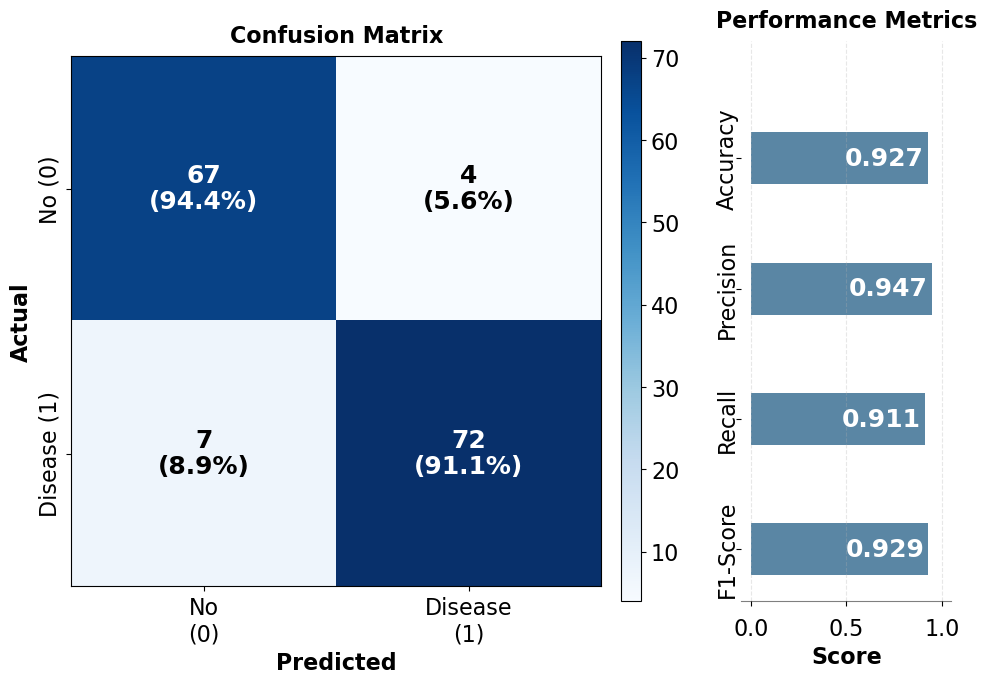

In [78]:
# Show SEL-NNML Evaluation Metrics
y_pred_stack = sel_nnml.predict(X_test)
evaluation_metrics_plot(y_test, y_pred_stack)

In [79]:
# Show SEL-NNM: all fold scores with mean and std 
sel_nnml_cv_scores = cross_val_score(sel_nnml, X_train, y_train, cv=CV_FOLDS, scoring='accuracy', n_jobs=N_JOBS)
print(f'SEL-NNML CV Accuracy Scores [Fold 1, Fold 2, ..., Fold n]: {sel_nnml_cv_scores}')
print(f'Mean: {sel_nnml_cv_scores.mean():.4f}')
print(f'Standard Deviation: {sel_nnml_cv_scores.std():.4f}')

SEL-NNML CV Accuracy Scores [Fold 1, Fold 2, ..., Fold n]: [0.86666667 0.85714286 0.87394958 0.79831933 0.84033613]
Mean: 0.8473
Standard Deviation: 0.0269


In [80]:
# Show SELL-NNML Training Time
Total_training_time = base_models_training_time + meta_model_training_time
print(f'Base Models Tuning & Training Time: {base_models_training_time:.2f} seconds')
print(f'Meta Model Tuning & Training Time: {meta_model_training_time:.2f} seconds')
print(f'Total SEL-NNML Tuning & Training Time: {Total_training_time:.2f} seconds')

Base Models Tuning & Training Time: 47.76 seconds
Meta Model Tuning & Training Time: 102.66 seconds
Total SEL-NNML Tuning & Training Time: 150.42 seconds


### **6.2 Multiple Model Evaluation**

The evaluation below compares all models (base models + SEL-NNML) for the selected sampler. To compare models across different samplers, change the `SELECTED_SAMPLER` variable in the cell above.

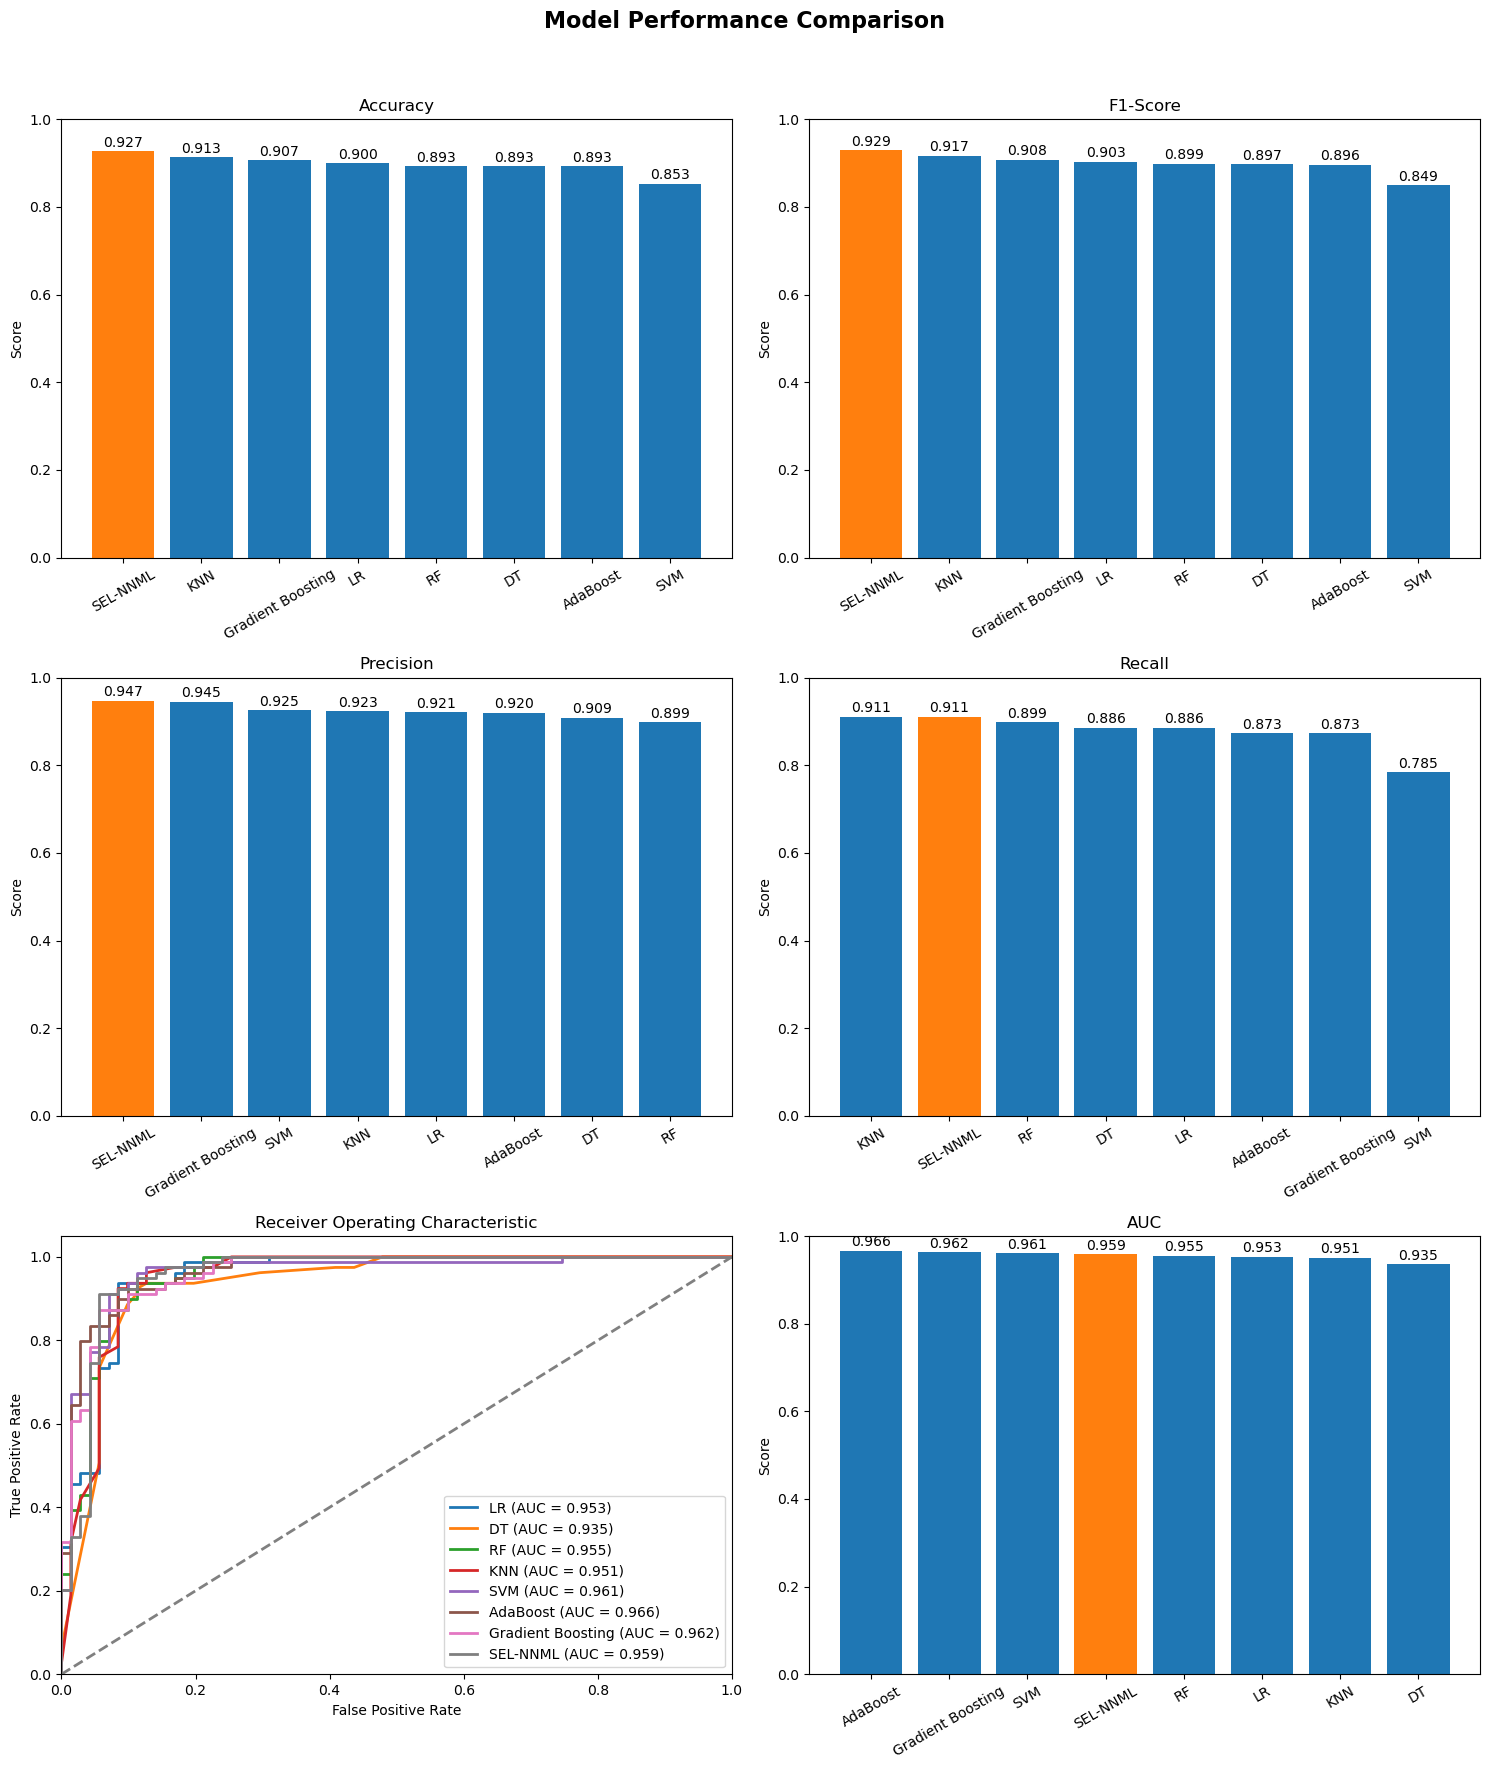

In [81]:
# Use the selected sampler's models for comparison
model_comparison_plot(selected_models, X_test, y_test)

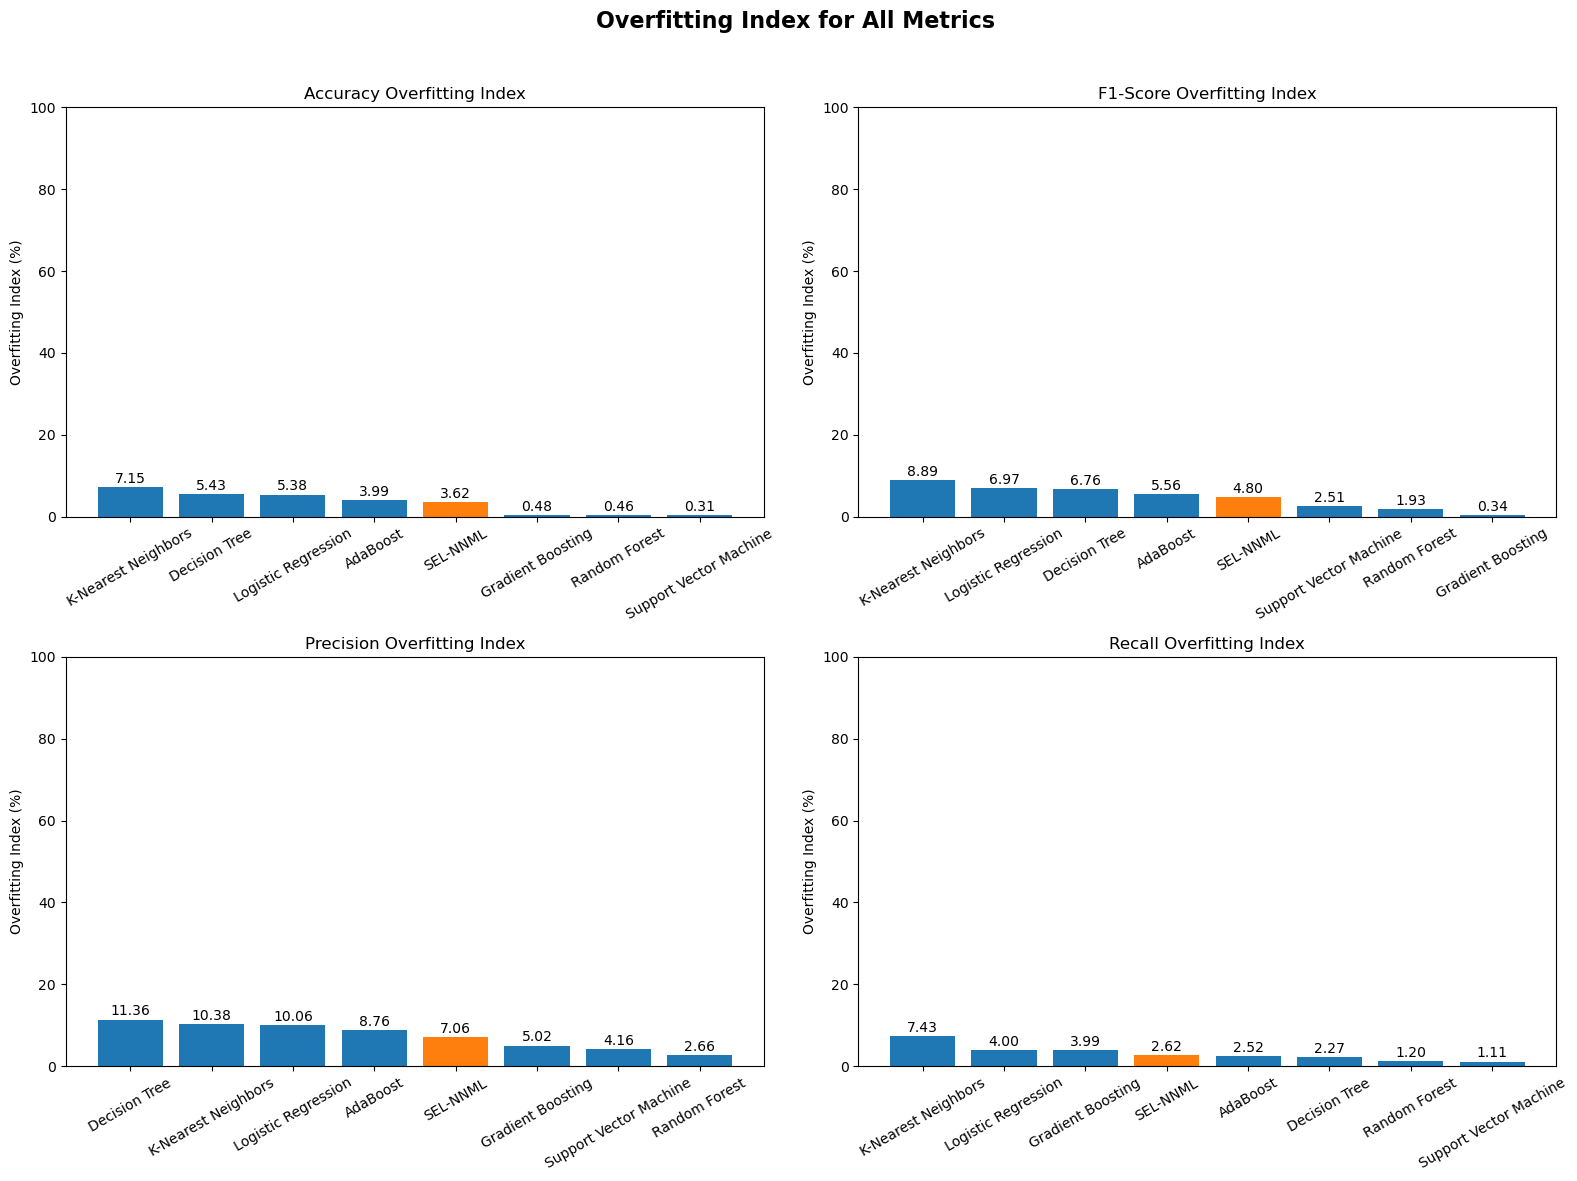

In [82]:
# Use the selected sampler's models for overfitting index comparison
overfitting_index_plot(selected_models, X_train, y_train, X_test, y_test)

In [83]:
# Save feature importance results for all samplers
import os

for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']:
    # Set the sampler
    temp_sampler = sampler
    temp_models = all_models[temp_sampler]
    temp_sel_nnml = temp_models['SEL-NNML']
    
    # Calculate permutation importance for this sampler
    print(f"Calculating feature importance for {temp_sampler}...")
    temp_perm_importance = permutation_importance(
        temp_sel_nnml, X_test, y_test,
        n_repeats=30, random_state=42, n_jobs=-1
    )
    
    # Create dataframe
    temp_importance_df = pd.DataFrame({
        'Feature': X_train.columns.tolist(),
        'Importance Mean': temp_perm_importance.importances_mean,
        'Importance Std': temp_perm_importance.importances_std
    }).sort_values('Importance Mean', ascending=False)
    
    # Save to CSV
    sampler_folder = temp_sampler.lower().replace("-", "")
    os.makedirs(f'../artifacts/ds1/models/{sampler_folder}', exist_ok=True)
    importance_save_path = f'../artifacts/ds1/models/{sampler_folder}/sel-nnml_feature_importance.csv'
    temp_importance_df.to_csv(importance_save_path, index=False)
    print(f"✓ Saved {temp_sampler} feature importance to: {importance_save_path}")

print("\nAll feature importance data saved successfully!")

Calculating feature importance for TPE...
✓ Saved TPE feature importance to: ../artifacts/ds1/models/tpe/sel-nnml_feature_importance.csv
Calculating feature importance for GP...
✓ Saved TPE feature importance to: ../artifacts/ds1/models/tpe/sel-nnml_feature_importance.csv
Calculating feature importance for GP...
✓ Saved GP feature importance to: ../artifacts/ds1/models/gp/sel-nnml_feature_importance.csv
Calculating feature importance for CMA-ES...
✓ Saved GP feature importance to: ../artifacts/ds1/models/gp/sel-nnml_feature_importance.csv
Calculating feature importance for CMA-ES...
✓ Saved CMA-ES feature importance to: ../artifacts/ds1/models/cmaes/sel-nnml_feature_importance.csv
Calculating feature importance for QMC...
✓ Saved CMA-ES feature importance to: ../artifacts/ds1/models/cmaes/sel-nnml_feature_importance.csv
Calculating feature importance for QMC...
✓ Saved QMC feature importance to: ../artifacts/ds1/models/qmc/sel-nnml_feature_importance.csv

All feature importance data sa

### **6.3 Save All Models Metrics (All Samplers)**

This section calculates and saves performance metrics for all models across all samplers. This data will be used for cross-sampler comparisons in the visualization notebook.

In [84]:
# Calculate and save metrics for ALL models from ALL samplers + BASELINE models
from sklearn.metrics import roc_curve, auc
import os

print("Calculating metrics for all models across all samplers + baseline models...")

all_metrics_data = []
all_roc_data = []

# Process baseline models first
print("\nProcessing BASELINE models...")
baseline_models_dict = {
    **{f"{name} (Default)": model for name, model in default_base_models.items()},
    'Stacking + Linear Regression': stacking_lr,
    'Stacking + Default MLP': stacking_mlp
}

for model_name, model in baseline_models_dict.items():
    # Predictions
    y_pred = model.predict(X_test)
    
    # Get probability predictions for AUC and ROC
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Store metrics
    all_metrics_data.append({
        'Sampler': 'Baseline',
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC': roc_auc
    })
    
    # Store ROC curve data
    for f, t in zip(fpr, tpr):
        all_roc_data.append({
            'Sampler': 'Baseline',
            'Model': model_name,
            'FPR': f,
            'TPR': t
        })
    
    print(f"  ✓ {model_name}: Acc={accuracy_score(y_test, y_pred):.4f}, AUC={roc_auc:.4f}")

# Process optimized models
for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']:
    print(f"\nProcessing {sampler} models...")
    models = all_models[sampler]
    
    for model_name, model in models.items():
        # Predictions
        y_pred = model.predict(X_test)
        
        # Get probability predictions for AUC and ROC
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(X_test)
        
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Store metrics
        all_metrics_data.append({
            'Sampler': sampler,
            'Model': model_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'AUC': roc_auc
        })
        
        # Store ROC curve data
        for f, t in zip(fpr, tpr):
            all_roc_data.append({
                'Sampler': sampler,
                'Model': model_name,
                'FPR': f,
                'TPR': t
            })
        
        print(f"  ✓ {model_name}: Acc={accuracy_score(y_test, y_pred):.4f}, AUC={roc_auc:.4f}")

# Create DataFrames
all_metrics_df = pd.DataFrame(all_metrics_data)
all_roc_df = pd.DataFrame(all_roc_data)

# Save to CSV files
os.makedirs('../artifacts/ds1/models', exist_ok=True)
all_metrics_df.to_csv('../artifacts/ds1/models/all_models_metrics.csv', index=False)
all_roc_df.to_csv('../artifacts/ds1/models/all_models_roc_data.csv', index=False)

print(f"\n✅ Saved metrics for {len(all_metrics_data)} model configurations")
print(f"   - Metrics: ../artifacts/ds1/models/all_models_metrics.csv")
print(f"   - ROC Data: ../artifacts/ds1/models/all_models_roc_data.csv")

# Display summary
print("\n" + "="*80)
print("SUMMARY: Top 5 Models by Accuracy")
print("="*80)
display(all_metrics_df.nlargest(5, 'Accuracy')[['Sampler', 'Model', 'Accuracy', 'F1-Score', 'AUC']])

Calculating metrics for all models across all samplers + baseline models...

Processing BASELINE models...
  ✓ Logistic Regression (Default): Acc=0.8867, AUC=0.9577
  ✓ Decision Tree (Default): Acc=0.8600, AUC=0.8621
  ✓ Random Forest (Default): Acc=0.8800, AUC=0.9512
  ✓ K-Nearest Neighbors (Default): Acc=0.8733, AUC=0.9311
  ✓ Support Vector Machine (Default): Acc=0.9067, AUC=0.9490
  ✓ AdaBoost (Default): Acc=0.8800, AUC=0.9583
  ✓ Gradient Boosting (Default): Acc=0.8867, AUC=0.9594
  ✓ Stacking + Linear Regression: Acc=0.9000, AUC=0.9533
  ✓ Stacking + Linear Regression: Acc=0.9000, AUC=0.9533
  ✓ Stacking + Default MLP: Acc=0.9000, AUC=0.9529

Processing TPE models...
  ✓ Logistic Regression: Acc=0.9000, AUC=0.9531
  ✓ Decision Tree: Acc=0.8933, AUC=0.9350
  ✓ Random Forest: Acc=0.8933, AUC=0.9554
  ✓ K-Nearest Neighbors: Acc=0.9133, AUC=0.9508
  ✓ Support Vector Machine: Acc=0.8533, AUC=0.9606
  ✓ AdaBoost: Acc=0.8933, AUC=0.9661
  ✓ Gradient Boosting: Acc=0.9067, AUC=0.9624
  ✓ 

,Sampler,Model,Accuracy,F1-Score,AUC
16,TPE,SEL-NNML,0.926667,0.929032,0.958638
32,CMA-ES,SEL-NNML,0.926667,0.929936,0.961134
24,GP,SEL-NNML,0.920000,0.923077,0.961312
40,QMC,SEL-NNML,0.920000,0.927711,0.961669
12,TPE,K-Nearest Neighbors,0.913333,0.917197,0.950793
